In [1]:
##analysis of discrete threshold networks applied to information diffusion models (IC or LT)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
#ABOVE added to use development version of cana
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
from cana.drawing import draw_canalizing_map_graphviz
from cana.drawing import draw_dynamics_canalization_map_graphviz
import matplotlib as mpl
import matplotlib.style
#mpl.style.use('classic')
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
import random
from copy import copy
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST, LEUKEMIA, BREAST_CANCER
from itertools import combinations
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess
#
import json
import ast
#BELOW added for graphviz to work on windows
#os.environ["PATH"] += os.pathsep + "C:/Anaconda/pkgs/graphviz-2.38.0-4/Library/bin/"
#os.environ["PATH"] += os.pathsep + 'C:/Anaconda/Library/bin/graphviz/'
os.environ["PATH"] += os.pathsep + 'C:\Users\tjparmer\Miniconda2\Lib\site-packages\graphviz'
import networkx as nx
from cana.utils import statenum_to_binstate, binstate_to_statenum
from networkx_addon import information_propagation as ip
import time
from scipy.stats import norm, sem
import copy

ImportError: No module named networkx_addon

#### Data

In [3]:
#read in real network
graph = nx.read_adjlist("../RealNetworks/RealNetworks/net_karate.gml")
print graph.nodes()

[u'24', u'25', u'26', u'27', u'20', u'21', u'22', u'23', u'28', u'29', u'1', u'3', u'2', u'5', u'4', u'7', u'6', u'9', u'8', u'11', u'10', u'13', u'12', u'15', u'14', u'17', u'16', u'19', u'18', u'31', u'30', u'34', u'33', u'32']


In [4]:
#make the graph directed
N = nx.DiGraph(graph)
print len(N.edges()), len(N.nodes())

156 34


In [5]:
#describe the network
for node in N: print node, len(N[node])

24 4
25 2
26 4
27 6
20 5
21 3
22 4
23 3
28 12
29 2
1 9
3 10
2 16
5 3
4 6
7 4
6 4
9 5
8 4
11 3
10 2
13 2
12 1
15 2
14 5
17 3
16 2
19 3
18 2
31 2
30 2
34 17
33 2
32 2


In [6]:
#generate look-up table based on theta (if there at least as many 1's as theta, output is 1)
node='24'
theta=0.5

def output_transitions_LT(n,node,theta):
    """ Given a networkx graph n and node, generate a LUT for node based on theta threshold """
    total=2**len(n[node]) #total combinations to try
    output_list=[]
    for i in range(total):
        trial_string = statenum_to_binstate(i,len(n[node])) #from utils.py in cana
        #print trial_string
        #simply count the 1's to determine if the threshold is met
        if trial_string.count('1')/len(trial_string) >= theta: 
            output_list.append(1)
        else:
            output_list.append(0)
    return output_list
        
print len(output_transitions_LT(N,node,theta))

16


In [7]:
#create BooleanNetwork object by converting all output transitions relative to theta, requires logic dictionary
#NOTE: BooleanNetworks must be 0-based
#from collections import defaultdict
#G = nx.Graph([('a','b'),('b','c')]) #does not work unless nodes 'a', 'b' given integer names
def convert_LT(N,theta):
    """ takes a network and global threshold value (theta) and generates a BooleanNetwork object with LUTs based on theta """
    
    logic = {i:{} for i in range(len(N.nodes()))}
    
    for node in N:
        i=int(node)-1
        logic[i] = {'name': node, 'in':[], 'out':[]} 
        logic[i]['in']=[int(key)-1 for key in N[node]] #assumes nodes with integer names!, must decrease by 1 to make 0-based
        logic[i]['out']=output_transitions_LT(N,node,theta)
        #print len(logic[i]['out'])

    #N = cana.BooleanNetwork(name='', logic=logic, Nnodes=len(N), constants={}, keep_constants=True)
    return cana.BooleanNetwork.from_dict(logic)

theta=0.5
NK = convert_LT(N,theta)
print NK

<BNetwork(Name='', N=34, Nodes=[u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'20', u'21', u'22', u'23', u'24', u'25', u'26', u'27', u'28', u'29', u'30', u'31', u'32', u'33', u'34'])>


In [8]:
#find effective connectivities
#NOTE: this is impossible to do computationally using the traditional Quine-McCluskey CANA method
bound = 'upper'
#print NK.nodes[1].schemata_look_up_table(type="ts") #k=16
df = pd.DataFrame({
        'node':[n.name for n in NK.nodes],
        'k':[n.k for n in NK.nodes],
        #'k_r':[n.input_redundancy(mode='node',bound=bound,norm=False) for n in NK.nodes],
        #'k_e':[n.effective_connectivity(mode='node',bound=bound,norm=False) for n in NK.nodes],
        #'k_s':[n.input_symmetry(mode='node',bound=bound,norm=False) for n in NK.nodes],
        #'k_r*':[n.input_redundancy(mode='node',bound=bound,norm=True) for n in NK.nodes],
        #'k_e*':[n.effective_connectivity(mode='node',bound=bound,norm=True) for n in NK.nodes],
        #'k_s*':[n.input_symmetry(mode='node',bound=bound,norm=True) for n in NK.nodes],
        #'k_e(out-d)':[Neg.out_degree()[n] for n in Neg.out_degree()],
        #'k_e(out-s)':[Neg.out_degree(weight='weight')[n] for n in Neg.out_degree(weight='weight')],
    }).set_index('node')
#df = df[['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)']]
print df

       k
node    
1      9
2     16
3     10
4      6
5      3
6      4
7      4
8      4
9      5
10     2
11     3
12     1
13     2
14     5
15     2
16     2
17     3
18     2
19     3
20     5
21     3
22     4
23     3
24     4
25     2
26     4
27     6
28    12
29     2
30     2
31     2
32     2
33     2
34    17


#### Functions

In [123]:
#TODO: convert from adjacency list to cana representation
#note that this needs to capture the dynamics so the type of model (LT, IC, or general thresholding) needs to be specified

def convert_network_dynamics(n, ntwk_type):
    """ Create a CANA-compatible network from a LT or IC model
    Expects a networkx graph and the relevant parameters for the given model """
    
    n=n.copy() #don't change the original graph
    
    #TODO
    
    return

In [ ]:
#visualize the graph
S = graphviz.Digraph(name='Structural Graph', engine='neato')
S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false')
S.attr('node', shape='oval', fixedsize='true', width='.80', color='gray', style='filled', fillcolor='#515660', penwidth='3', 
       fontname='Helvetica', fontcolor='white',fontsize='12')
S.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for node,d in Nsg.nodes(data=True):
    
    if d['label'] in att:
        natt = att[d['label']]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
        fillcolor = '#515660'
    S.node(name=str(node), label=d['label'], pos=xy, fillcolor=fillcolor)

#alternate
#for node,d in Nsg.nodes(data=True):
#    natt = att[d['label']]
#    S.node(name=str(nid), **natt)    
    
max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    if s==t: continue #include this line to get rid of self-loops
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, )
print 'Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) )
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})
# Export
S._format = 'svg'
efile = u"%s/../experiments/2017 - BioModels/%s/graphs/SG" % (os.getcwd(),foldername)
S.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [ ]:
####TODO: convert cana DCM to threshold graph
#run BFS on graph (modify to simplify function input-output)
##ISSUES: nodes with high k cannot have LUTs reduced
#expansive LUTs -> no useful visualization and no partial knowledge unless all inputs are known
#no useful partial knowledge computation without low k constraints?
#QUESTION: how to obtain the longest trajectories from partial knowledge (largest informational gain)?

In [ ]:
####TODO: create arbitrary function solver
#for low k, it determines if the given inputs solve any symmetry groups
#for larger k, it requires all given inputs to make a decision

In [15]:
#TODO: arbitrary function solver; look at BooleanNode step() function, requires all k inputs specified
def func_solver(n,node,inputs):
    """ For a given node in a BooleanNetwork, calculate its output based on its inputs """
    
    return node.step(inputs)

In [30]:
#TODO: BFS on BooleanNetwork; cannot use BooleanNetwork step() function because it requires a full configuration
def network_BFS(n,seed):
    """ Run BFS on a BooleanNetwork assuming any arbitrary transition functions and input sizes """
    
    return

In [ ]:
####TODO: create configuration sampler to find ground truth probabilities of node activation
#compare to function that implements mean-field approximation

In [9]:
#alternate version of CANA LUT table function that fixes bug, takes a BooleanNode
#NOTE: this first tries to read the look-up-table from an existing data structure, otherwise it calculates it
def look_up_table(node,ds={}):
    if ds:
        return ds[node.name]
    
    d = []
    for statenum, output in zip( xrange(2**node.k), node.outputs):
        # Binary State, Transition
        d.append( (statenum_to_binstate(statenum, base=node.k), output) )
    df = pd.DataFrame(d, columns=['In:','Out:'])
    return df

#### Linear Threshold Model

In [12]:
#each node can be given its own threshold, DG.node[n]['threshold'] = 0.5 by default
#each edge can be given its own influence, DG[e[0]][e[1]]['influence'] = 1.0 / in_deg[e[1]] by default
for node in N.nodes():
    N.node[node]['threshold']=0.5

in_deg = N.in_degree() #note that influence is based on each node's in-degree
for e in N.edges():
    N [e[0]][e[1]]['influence'] = 1.0 / in_deg[e[1]]
    
print N.in_degree()

[(u'24', 4), (u'25', 2), (u'26', 4), (u'27', 6), (u'20', 5), (u'21', 3), (u'22', 4), (u'23', 3), (u'28', 12), (u'29', 2), (u'1', 9), (u'3', 10), (u'2', 16), (u'5', 3), (u'4', 6), (u'7', 4), (u'6', 4), (u'9', 5), (u'8', 4), (u'11', 3), (u'10', 2), (u'13', 2), (u'12', 1), (u'15', 2), (u'14', 5), (u'17', 3), (u'16', 2), (u'19', 3), (u'18', 2), (u'31', 2), (u'30', 2), (u'34', 17), (u'33', 2), (u'32', 2)]


In [13]:
#max diffusion for one node activation
influence={}
ltkmodules={}
for node in N.nodes():
    diffusion = ip.linear_threshold(N,[node])
    nodes_reached = {n for ls in diffusion for n in ls}
    influence[node] = len(nodes_reached)
    ltkmodules[node]=nodes_reached
    
for key in sorted(influence,key=lambda x: influence[x],reverse=True): print key,'\t',influence[key]

34 	14
28 	6
2 	5
1 	3
7 	3
6 	3
24 	2
3 	2
4 	2
25 	1
26 	1
27 	1
20 	1
21 	1
22 	1
23 	1
29 	1
5 	1
9 	1
8 	1
11 	1
10 	1
13 	1
12 	1
15 	1
14 	1
17 	1
16 	1
19 	1
18 	1
31 	1
30 	1
33 	1
32 	1


In [15]:
num=7
seeds=combinations(N.nodes(),num)
seed=random.choice([seed for seed in seeds])
print [s for s in seed],ip.linear_threshold(N,[s for s in seed])

[u'27', u'21', u'2', u'9', u'8', u'11', u'12'] [[u'27', u'21', u'2', u'9', u'8', u'11', u'12'], [u'13', u'16', u'19', u'18', u'5', u'6'], [u'15', u'4', u'7'], [u'1'], [u'3', u'26', u'14', u'17'], [u'10', u'22', u'23'], []]


#### Independent Cascade Model

In [16]:
#each edge can be given its own activation probability, DG[e[0]][e[1]]['act_prob'] = 0.1 by default
#NOTE: a node only gets one chance to influence its neighbors
for e in N.edges():
    N [e[0]][e[1]]['act_prob'] = 0.10

In [18]:
#max diffusion for one node activation
#find average over several runs
num=50
influence={}
for i in range(num):
    for node in N.nodes():
        diffusion = ip.independent_cascade(N,[node])
        nodes_reached = {n for ls in diffusion for n in ls}
        influence.setdefault(node,0)
        influence[node] += len(nodes_reached)
        
influence = {node: influence[node]/num for node in influence}    
for key in sorted(influence,key=lambda x: influence[x],reverse=True): print key,'\t',influence[key]

2 	3.72
34 	3.42
4 	2.98
28 	2.9
1 	2.54
27 	2.38
3 	2.38
9 	2.28
20 	2.18
8 	2.18
26 	2.08
17 	2.08
14 	1.9
23 	1.8
24 	1.76
6 	1.76
25 	1.74
22 	1.68
11 	1.68
32 	1.64
5 	1.6
29 	1.58
10 	1.58
31 	1.58
16 	1.56
13 	1.54
15 	1.54
7 	1.5
30 	1.42
21 	1.38
19 	1.36
33 	1.36
18 	1.32
12 	1.26


#### Dynamic Map Model

In [10]:
import random
#threshold network conversion
def create_threshold_network(n):
    """ Create a digraph compatible with threshold network manipulation
    Expects a DCM-like digraph as input, returns a threshold-like digraph where every node is a literal and/or threshold node
    
    Valid nodes include these properties: label, threshold (tau), type, time delay, variable, state
    Valid edges include these properties: type 
    
    NOTE: the DCM originally has a separate fusion node for each literal enput of the same state involved in the same symmetry group
    However, this means that the same enput can activate multiple edges rather than just one
    As a solution, each group of fusion nodes that are associated with the same state and the same symmetry group are replaced
    by one threshold node with tau=n, where n is the number of fusion nodes that were combined into that threshold node """
    
    n=n.copy() #don't change the original graph
    
    #check for similar fusion nodes
    fusion_nodes=[name for name in n.nodes() if n.node[name]['type']=='fusion']
    groups={} #each group will share the same predecessors and successors
    i=0
    for f in fusion_nodes:
        predecessors=set(n.predecessors(f))
        successors=set(n[f])
        found=False
        for key in groups:
            if groups[key]['predecessors']==predecessors and groups[key]['successors']==successors: #we have a match
                groups[key]['nodes'].append(f)
                found=True
                break
        if not found: #make a new group
            groups[i]={'predecessors':predecessors, 'successors':successors, 'nodes':[f]}
            i+=1
    #delete fusion nodes and replace with new threshold nodes
    for t in groups: #add new threshold nodes
        name="F-T"+str(t)
        tau=len(groups[t]['nodes'])
        group=n.node[random.choice(tuple(groups[t]['successors']))]['group'] #take group attribute of random successor, necessary for visualization
        n.add_node(name,{'label':str(tau),'type':'threshold','tau':tau,'group':group})
        #adjust successor node thresholds; add 1 for new threshold node and then substract for each fusion node deleted
        for successor in groups[t]['successors']: #there should only be one
            n.add_edge(name,successor)
            n.node[successor]['tau'] += 1 - tau
            n.node[successor]['label'] = str(n.node[successor]['tau'])
        #add new edges to threshold nodes from predecessors
        for predecessor in groups[t]['predecessors']:
            n.add_edge(predecessor,name)
        
    #delete fusion nodes and adjacent edges
    for f in fusion_nodes:
        n.remove_node(f)
    #print groups
    
    for name in n.nodes():
        
        if 'label' not in n.node[name]:
            n.node[name]['label']='unknown'
            
        if 'type' not in n.node[name]:
            n.node[name]['type']='unknown'
            
        if 'tau' not in n.node[name]:
            if n.node[name]['type']=='threshold':
                n.node[name]['tau']=1
            else:
                n.node[name]['tau']=0
                
        if 'delay' not in n.node[name]:
            if n.node[name]['type']=='threshold':
                n.node[name]['delay']=0
            else:
                n.node[name]['delay']=1
        
        #assume variable name comes from the label
        if 'variable' not in n.node[name] and n.node[name]['type']=='variable':
            n.node[name]['variable']=n.node[name]['label']
            
        #assume states are only positive integers
        if 'state' not in n.node[name] and n.node[name]['type']=='variable':
            state_str=name.replace(n.node[name]['variable'],"") #remove variable name
            state_str=''.join([s for s in state_str if s.isdigit()]) #concatenate string from all integers left in name (in case of double-digit states)
            n.node[name]['state']=int(state_str)
                
        #print name,n.node[name]
        
    return n

#create_threshold_network(DCM)

In [11]:
from collections import deque
#specialized BFS to work for threshold network
def BFS_threshold(n,seed,input_type='steady',time_limit=1,conversion=True,pinned=set([])):
    
    """ Does specialized BFS on a threshold network n
    input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
    or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    seed may be a single node or a list of starting nodes
    
    Implementation based on BFS with a priority queue of times {t: q} 
    where t is the time when those nodes become active and q are the nodes active at that time step 
    
    Returns a dictionary of nodes visited at each time step
    
    NOTE: a threshold network is required, this will break if fusion nodes have not been removed
    Assume that a conversion is needed; will not run conversion if conversion argument set to False 
    
    NOTE: if run with input_type='steady', unfolding contains only the new states visited at that time step
    while all previous states visited are also considered active
    if run with input_type='pulse', unfolding contains EVERY node that is active at that time step, 
    even if it has been active before
    the pinned argument is used to specify nodes that are pinned in one state, regardless of the input_type,
    and can specify a subset of the seed that's constitutively active when input_type='pulse'
    
    NOTE: if run with input_type='steady', then ignore any node that is a different state of the starting seed;
    because we are pinning control of that variable, we need to remove all other possible variable states from the network """
    
    if conversion: #note conversion is slow due to a network deep copy
        try:
            n=create_threshold_network(n)
        except:
            raise Exception("Network could not be converted to a thresholded representation")
        
    if not isinstance(seed,list): #convert seed to a list if it is a single node
        seed=[seed]
    
    for node in seed:
        if node not in n.nodes():
            raise Exception('Seed not in the network!  Hint: did you specify both the node and current state? e.g. wg-1')
            
    #if there is steady-state input (pinning control), note any contradictions to any node in the seed
    #NOTE: if given a logical contradiction, this function picks only ONE of the states to use
    #however, this doesn't affect steady-state (because the variable was already added to the queue and active step)
    if input_type=='steady':
        vals={n.node[x]['variable']:n.node[x]['state'] for x in seed if n.node[x]['type']=='variable'}
        contradictory_nodes={node for node in n if 
                        n.node[node]['type']=='variable' and n.node[node]['variable'] in vals and n.node[node]['state']!=vals[n.node[node]['variable']]}
    else:
        contradictory_nodes=set([])
    if pinned: #check pinned nodes as well
        vals={n.node[x]['variable']:n.node[x]['state'] for x in pinned if n.node[x]['type']=='variable'}
        contradictory_nodes.update({node for node in n if 
                        n.node[node]['type']=='variable' and n.node[node]['variable'] in vals and n.node[node]['state']!=vals[n.node[node]['variable']]})
        
    counter=0  #this will increment towards the time limit and provide an exit if we get stuck
    visited=set() #visited nodes during the entire history
    thresholds={} #global threshold dictionary to populate with discounted threshold nodes
        
    #create 'priority queue', actually a dictionary of time steps due to difficulty in changing priorities in a heap
    time_steps={0: deque(seed)} #FIFO queue for each time step of nodes to attempt to visit
    time=0 #global chronometer, iterates by one as dynamic unfolding takes place
    unfolding={} #track the unfolding of the dynamics over iterated time, mirrors time_steps but only holds visited nodes    
    active_step=set(seed) #active nodes for this time step, will be different than visited if input_type='pulse'
    for node in pinned:
        time_steps[0].append(node)
        active_step.add(node)
    
    
    while time<=max(time_steps): #allows for possibility of time jumps, i.e. updates further ahead than one time step
        
        #update counter
        old_length=len(visited)
        visited.update(active_step)
        #if len(visited)==old_length: #increase counter if we have not added anything new
        #if any(unfolding[t] == active_step for t in unfolding): #increase counter if we repeat a past partial configuration
        counter+=1
        #print time,len(visited)
        #reset thresholds and active_step if this is pulse (so that we may revisit nodes, including the starting nodes)
        #print time,active_step
        if input_type=='pulse':
            thresholds={}
            active_step=set()
            #add in pinned nodes first
            for node in pinned:
                time_steps.setdefault(time+1,deque())
                time_steps[time+1].append(node)
                active_step.add(node)
        
        #check for exit due to being stuck in a cycle
        if counter>=time_limit: 
            break
            

        #run BFS
        while time_steps.get(time): 
            node=time_steps[time].popleft()
            #add node to unfolding
            unfolding.setdefault(time,set())
            unfolding[time].add(node)
            
            #check neighbors - note that for steady state we assume all past actors are still activated, but pulse requires repeat activation
            for neighbor in n[node]:
                #ignore any contradictory nodes; better to ignore than remove because we don't want BFS to be destructive to the graph
                if neighbor in contradictory_nodes:
                    continue
                if neighbor not in active_step:
                    #check that neighbor passes the threshold test if it has a non-trivial threshold
                    if n.node[neighbor]['tau']>1:
                        thresholds.setdefault(neighbor,set())
                        thresholds[neighbor].add(node)  #add node due to this incoming edge, ensures node can only contribute once
                    if neighbor not in thresholds or len(thresholds[neighbor])>=n.node[neighbor]['tau']:
                        #at this point we have passed the threshold, so insert neighbor at proper time slot t
                        t = time + n.node[neighbor]['delay']
                        time_steps.setdefault(t,deque())
                        time_steps[t].append(neighbor)
                        active_step.add(neighbor)
                           
        #next iteration
        time+=1
    
    return unfolding

#DCM=ND.dynamics_canalization_map(output=None, )
#print BFS_threshold(DCM,['en-1','ptc-1'],'pulse',time_limit=12,pinned={'en-1'}) #'SLP-1','CIR-0','CIA-1', 'SLP-0','nWG-1'

In [12]:
#function to find top modules given a set of modules
def find_top_modules(nu,tm,sizes,candidates,input_type='steady'):
    """ Determines the top modules by seeing which modules can be subsumed into other modules
    Specifically, it tests every candidate to see if it is along the path of a larger module in nu, O(n**2) time 
    Candidates is a dictionary where the keys are node names and the values are actual nodes to check """
    
    nodes_seen=[] #track which nodes the candidate might be found in
    for node in sorted(sizes,key=lambda x:sizes[x],reverse=True): #start with the largest modules

        if node in candidates: #only check our candidates
            
            seen=False
            for step in nodes_seen: #compare against all dynamic steps we've seen before 
                
                if not candidates[node]-step: #the candidate is a subset of the nodes seen
                    #print node,"eaten by",step
                    seen=True
                    break
            
            if not seen:
                #add to top_modules
                tm[node]=nu[node]
                #add the node's unfolding to nodes_seen
                if input_type=='steady':
                    nodes_seen.append({x for t in nu[node] for x in nu[node][t]})
                else: #add a separate set for each time step
                    for t in nu[node]:
                        nodes_seen.append({x for x in nu[node][t]})
                        
            
    return tm

#n,t,s,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True)
#print n

In [13]:
#function to find all dynamic modules of single seed perturbations
def find_dynamic_modules(n,num=1,input_type='steady',time_limit=1,conversion=True,samples=None,tm=True,seeds=None):
    
    """ Test all possible seeds of a network to determine each seed's dynamic unfolding
    If tm=True, combines any unfolding that is a subset of another unfolding and returns the largest unique unfoldings 
    
    input_type may be 'pulse' if a single signal is sent through the network (seed guaranteed ON/OFF for only one time step)
    or 'steady' if the signal is held on (seed guaranteed ON/OFF for all time steps) 
    
    num dictates how many nodes the seed should contain; the default is to only search dynamic modules from one starting node
    NOTE: this function does a combinatoric search over all possible seed configurations, be careful with memory constraints
    when running with high n
    If samples=x, then this will draw x samples from the possible combinations with replacement
    If tm=True, this will try to compute all top modules
    If seeds is not None, this will find all dynamic modules from the seeds contained in that iterable (must be hashable);
    Note that seeds takes precedence over samples
    
    Converts the network n to a thresholded representation """
    
    if conversion:
        try:
                n=create_threshold_network(n)
        except:
                raise Exception("Network could not be converted to a thresholded representation")
    
    network_unfolding,sizes={},{}
    #remove all non-variable nodes for cleaner visibility and comparison
    nodes=[x for x in n if n.node[x]['type']=='variable']

    if not seeds:
        if samples: #sampling to avoid memory issues with high combinations
            seeds=[[random.choice(nodes) for j in range(num)] for i in range(samples)]
        else: #get all combinations
            seeds=combinations(nodes,num)
    #elif num>1:
    #    #find combinations of our starting seeds; may need to be explicitly passed 
    #    seeds=combinations(seeds,num)
    candidates={} #used for top modules later
    #print seeds

    for seed in seeds:
        
        seed=list(seed)
        #quick check for contradiction
        vals=[n.node[x]['variable'] for x in seed]
        if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
            continue
        
        unfolding=BFS_threshold(n,seed,input_type=input_type,time_limit=time_limit,conversion=False)        
        unfolding={t:{x for x in unfolding[t] if n.node[x]['type']=='variable'} for t in unfolding} #simplify
        #if num==1: 
        #    seed=seed[0] #special case for single nodes, allows us to find top modules
        network_unfolding[str(seed)]=unfolding
        sizes[str(seed)]=sum([len(unfolding[t]) for t in unfolding])
        #update candidates
        candidates[str(seed)]=set(seed)
        #if tm: candidates[str(seed)]=set(seed)
 
    #condense down to the top modules by finding which modules are subsets of other modules (only consider variables)
    #NOTE: if a node is turned on at any point, it is guaranteed to follow the trajectory specified by its own module
    #a node along the path of another module can therefore have its trajectory be subsumed into that module
    top_modules={}
    if tm:
        top_modules=find_top_modules(network_unfolding,top_modules,sizes,candidates,input_type=input_type)
    
    
        
    return network_unfolding,top_modules,sizes,candidates

#nu,tm,sizes,c=find_dynamic_modules(DCM,input_type='steady',num=1,samples=None,tm=True,seeds=[['CIA-0'],['en-1','SMO-1'],['en-1']])
#print nu

In [14]:
#convert attractors from the STG of the network to a dictionary representation where each attractor is {variable names:ON or OFF}
def attractors_to_dict(n,mode='stg'):
    
    attractor_dict={}
    attractors=n.attractors(mode=mode)
    for attractor in attractors:
        label=n._stg.node[attractor[0]]['label'] #only pay attention to the first state for now
        #for i,var in enumerate(N.nodes): print i,type(var.name),type(label)
        #attractor_dict[label]={var.name:label[i] for i,var in enumerate(N.nodes)}
        if len(attractor)==1: #fixed point
            attractor_dict[label]={var.name+'-'+label[i] for i,var in enumerate(n.nodes)} #alternative, assumes labeling standard
        else: #limit cycle
            label=tuple([n._stg.node[attractor[i]]['label'] for i in range(len(attractor))])
            attractor_dict[label]=[{var.name+'-'+n._stg.node[attractor[a]]['label'][i] for i,var in enumerate(n.nodes)} for a in range(len(attractor))]
    return attractor_dict

#attractors=attractors_to_dict(n)

In [15]:
#helper functions for DCM modules
#TODO: convert this to work with RBNs
#NOTE: some networks have s-units T-0/T-1, etc; the convention here is that T- or F- with an _ later is a t-unit or fusion unit
#additionally, an s-unit must end with a digit (state) and 'F-T' indicates fusion nodes created in the threshold network
def is_sunit(s):
    """ determines if a particular unit is an s-unit based on the name """
    if not s or len(s)<3 or not s[-1].isdigit() or s[:3]=='F-T' or ((s[:2]=='F-' or s[:2]=='T-') and '_' in s):
        return False
    return True

def reduce_step(step):
    """ reduces a module step to only include s-units """
    new_step={s for s in step if is_sunit(s)}
    return new_step

def reduce_module(module):
    """ reduces a module to only include s-units """
    new_module={t: {s for s in module[t] if is_sunit(s)} for t in module}
    return new_module

def extract_sunits(module,pinned=True):
    """ extracts the unique s-units in a DCM module """
    module=reduce_module(module)
    if pinned:
        units={s for t in module for s in module[t]}
    else:
        units={s for s in module[max(module)]} #extract only the last time step
    return units

def extract_variables(module,pinned=True):
    units=extract_sunits(module,pinned=pinned)
    return {s[:-2] for s in units} #remove the state and force uniqueness of variables

def count_sunits(module,pinned=True):
    """ counts the unique s-units in a DCM module """
    units=extract_sunits(module,pinned=pinned)
    return len(units)

def count_variables(module,pinned=True):
    return len(extract_variables(module,pinned=pinned))

#DCMB=n.dynamics_canalization_map(output=None, )
#diffusion=BFS_threshold(DCMB,['Am-1'],'steady',time_limit=12,pinned={}) #[1]
#print diffusion
#for t in diffusion: 
#    for s in diffusion[t]: pass #print s,is_sunit(s)
#print reduce_module(diffusion)
#print extract_sunits(diffusion,pinned=False), count_sunits(diffusion,pinned=True)

In [16]:
#return all input nodes (no inputs except themselves)
def network_inputs(n):
    return [node for node in n.nodes if not node.inputs or (len(node.inputs)==1 and node.inputs[0]==node.name)]

#[node.name for node in network_inputs(n)]

In [ ]:
#TODO: compare the standard results with our dynamic mapping approach
#using randomized LUTs

#### Mean-field Approximation

In [17]:
#LUT pre-processing to only consider the rows that output to 1 or 0 (whichever state is in the minority)
#NOTE: this only works for Boolean outputs, and it chooses 1 if there is a tie
def LUT_reduce(df):
    """ reduces a LUT (given as a dataframe) to only rows with the minority output """
    
    state=df['Out:'].value_counts().idxmin()
    return pd.DataFrame([row[1:] for row in df.itertuples() if row[2]==state]) #removes first index

#for node in NK.nodes:
#    df=look_up_table(node)
#    #print df['Out:'].value_counts(),df['Out:'].value_counts().argmin()
#    print len(df),"Reduced Length:", len(LUT_reduce(df))#, df['Out:'].value_counts()

In [18]:
#compare general networks using a mean-field approximation
def mf_approx(node,act_prob,i,state=1,reduced=False,ds=None):
    """ mean-field approximation for the activation probability of the given node to the given state at iteration i,
    based on the probabilities of node states in its input configurations 
    
    The reduced argument indicates that LUTs have been reduced to their minority output (only works for binary outputs),
    which is stored in the ds data structure
    
    This function returns the new probability and the number of config rows that result in the given (or reduced) state """
    
    s=0.0
    t=0 #number of rows we check
    for row in look_up_table(node,ds=ds).itertuples(): #look at each input configuration
        #solve equation based on probabilities of inputs
        #NOTE: with reduced, we look at all rows because the LUT has already been reduced
        if row[2]==state or reduced: #ignore those that don't lead to the required state activation
            config=row[1]
            p=1.0
            t+=1
            #TODO: fix this to work with non-binary inputs
            for j,inp in enumerate(config):
                if int(inp)==0: #contribution from OFF node
                    p*=1-act_prob[i-1][node.inputs[j]]
                else: #contribution from ON node
                    p*=act_prob[i-1][node.inputs[j]]
            s+=p
            
    if reduced and row[2]!=state: #only have to check one row because all row outputs are the same
        return 1-s,t
    
    return s,t

In [19]:
#synchronous update
#pinning allows to pin a certain state (e.g. 0,1), pin_start allows to pin the seed
def synchronous_mf(N,act_nodes,act_prob,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True):
    
    #iterate through the mean-field approximation
    for i in range(1,iterations+1):
        for node in N.nodes:
            if node.name in act_nodes and pin_start: #pin the starting nodes
                act_prob[i][node.name]=act_prob[i-1][node.name]
                continue
            s,t=mf_approx(node,act_prob,i,reduced=reduced,ds=ds) #solve equation based on probabilities of inputs
            if s>1: s=1.0 #fix rounding errors
            if s<0: s=0.0 #fix rounding errors
            #allow pinning when state is reached
            if (0 in pinning) and act_prob[i-1][node.name]==0: act_prob[i][node.name]=0.0
            elif (1 in pinning) and act_prob[i-1][node.name]==1: act_prob[i][node.name]=1.0
            else:
                act_prob[i][node.name]=s
            if i==iterations: 
                pass
                #print node.name,act_prob[i][node.name],t,2**node.k,node.inputs
    return act_prob
                    
#act_nodes,act_prob=mf_seed(ND,(0, 3, 31, 32),dsunit_map,dtranslator,p=0.5)
#synchronous_mf(ND,act_nodes,act_prob,iterations=10)[10]

In [20]:
#generate a random node order
def random_node_order(N):
    nodes=[n for n in N.nodes] #so that the original list isn't changed
    random.shuffle(nodes)
    return nodes
    
#print [node.name for node in random_node_order(ND)]
#print [node.name for node in ND.nodes]

In [21]:
#create an order variable from a list of node names
def generate_blocks(N,order):
    new_order=[]
    for block in order:
        new_block=[node for name in block for node in N.nodes if node.name==name]
        new_order.append(new_block)
    return new_order

#order=generate_blocks(ND,[['CIR','SLP'],['SMO'],['CIA','en','PH'],['wg'],['nhhnHH','PTC'],['ptc'],['CI','HH','nWG'],['hh','ci','WG','EN']])
#[[node.name for node in block] for block in order]

In [22]:
#deterministic asynchronous update and stochastic with the constraint that every node is updated between iterations
#pinning allows to pin a certain state (e.g. 0,1), pin_start allows to pin the seed
#order dictates the order to update nodes, allows for sequential block updating
#defaut is random order; set regenerate=True to pick a new random order for each iteration
def asynchronous_mf(N,act_nodes,act_prob,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True,order=None,
                    regenerate=False,oh=False):

    if not order:
        order=[[node] for node in random_node_order(N)] #random by default
    order_history={} #track order to replicate
    #iterate through the mean-field approximation
    current_state={0:{node.name:act_prob[0][node.name] for node in N.nodes}} #state based on which to make updates
    for i in range(1,iterations+1):
        order_history[i]=order
        #print [[node.name for node in block] for block in order]
        #print "Iteration:",i,current_state
        for block in order:
            for node in block:
                if node.name in act_nodes and pin_start: #pin the starting nodes
                    act_prob[i][node.name]=act_prob[i-1][node.name]
                    continue
                #NOTE: we hard-code 1 below to pass current_state as if it were act_prob
                s,t=mf_approx(node,current_state,1,reduced=reduced,ds=ds) #solve equation based on probabilities of inputs
                if s>1: s=1.0 #fix rounding errors
                if s<0: s=0.0 #fix rounding errors
                #allow pinning when state is reached
                if (0 in pinning) and act_prob[i-1][node.name]==0: act_prob[i][node.name]=0.0
                elif (1 in pinning) and act_prob[i-1][node.name]==1: act_prob[i][node.name]=1.0
                else:
                    act_prob[i][node.name]=s
                if i==iterations: 
                    pass
                    #print node.name,act_prob[i][node.name],t,2**node.k,node.inputs
            #update the current state once the block is completed
            for node in block: current_state[0][node.name]=act_prob[i][node.name]
            #print current_state,node.name,s
        if regenerate:
            order=[[node] for node in random_node_order(N)] #new random order
            
    if oh: return act_prob,order_history
    return act_prob
                    
#order=[[node] for node in random_node_order(ND)]
#order=generate_blocks(ND,[['CIR','SLP'],['SMO'],['CIA','en','PH'],['wg'],['nhhnHH','PTC'],['ptc'],['CI','HH','nWG'],['hh','ci','WG','EN']])
#act_nodes,act_prob=mf_seed(ND,(0, 3, 31, 32),dsunit_map,dtranslator,p=0.5)
#asynchronous_mf(ND,act_nodes,act_prob,iterations=10,order=order,regenerate=True)[1]

In [23]:
#stochastic asynchronous update
#pinning allows to pin a certain state (e.g. 0,1), pin_start allows to pin the seed
#order is chosen randomly one node at a time
def stochastic_asynchronous_mf(N,act_nodes,act_prob,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True,oh=False):
 
    order=[random.choice(N.nodes) for node in range(len(N.nodes))] #so that iterations will be as long as with other updating schemes
    order_history={} #track order to replicate
    #iterate through the mean-field approximation
    for i in range(1,iterations+1):
        order_history[i]=order #track order to replicate
        act_prob[i]={node.name:act_prob[i-1][node.name] for node in N.nodes} #state based on which to make updates
        #print [node.name for node in order]
        #print "Iteration:",i,act_prob[i]
        for node in order:
            if node.name in act_nodes and pin_start: #pin the starting nodes
                act_prob[i][node.name]=act_prob[i-1][node.name]
                continue
            #NOTE: we pass i+1 below to pass the current state of act_prob
            s,t=mf_approx(node,act_prob,i+1,reduced=reduced,ds=ds) #solve equation based on probabilities of inputs
            if s>1: s=1.0 #fix rounding errors
            if s<0: s=0.0 #fix rounding errors
            #allow pinning when state is reached
            if (0 in pinning) and act_prob[i][node.name]==0: act_prob[i][node.name]=0.0
            elif (1 in pinning) and act_prob[i][node.name]==1: act_prob[i][node.name]=1.0
            else:
                act_prob[i][node.name]=s
            if i==iterations: 
                pass
                #print node.name,act_prob[i][node.name],t,2**node.k,node.inputs
            #print act_prob[i],node.name,s
        order=[random.choice(N.nodes) for node in range(len(N.nodes))] #new random order
        #order_history[i]=order
    if oh: return act_prob,order_history
    return act_prob
                    
#act_nodes,act_prob=mf_seed(ND,(0, 3, 31, 32),dsunit_map,dtranslator,p=0.5)
#stochastic_asynchronous_mf(ND,act_nodes,act_prob,iterations=10,oh=False)[10]

#### IBMFA Modules

In [24]:
#find top modules by removing those whose unfolding is a subset of another
#NOTE: this only checks the resulting set and therefore only works with pinning perturbation
def top_modules(modules,translator,s=1):
    top_modules={}
    #iterate through modules, largest first
    for seed in sorted(modules,key=lambda x: len(modules[x]),reverse=True):
        if len(translator[seed])!=s: continue #only subsume for a given s value
        subsumed=False 
        for tm in top_modules:
            if not modules[seed] - modules[tm]: #the seed is a subset of a top module already seen
                subsumed=True
                break
        
        if not subsumed:
            top_modules[seed] = modules[seed]
        
    return top_modules               

In [25]:
#solution from https://stackoverflow.com/questions/374626/how-can-i-find-all-the-subsets-of-a-set-with-exactly-n-elements
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))

In [26]:
#NOTE: there is symmetry with powersets (a set and its complement); therefore, we only need to check half of the powerset
#the sum (the set) must be greater (synergistic) than the addition of its parts (addition of all subsets)
ps=list(powerset(set([1,2,3,4])))
for i in range(1,int(len(ps)/2)):
    print i,ps[i],ps[len(ps)-i-1] 

1 (1,) (2, 3, 4)
2 (2,) (1, 3, 4)
3 (3,) (1, 2, 4)
4 (4,) (1, 2, 3)
5 (1, 2) (3, 4)
6 (1, 3) (2, 4)
7 (1, 4) (2, 3)


In [27]:
#find synergistsic modules by removing those whose seed combination does not add synergy
#NOTE: assumes that submodules are already included in modules
#NOTE: based on powersets, requires a standard numbering convention to check the lengths of submodules
def syn_modules(tm,modules,translator,s=1):
    """ checks for synergy within tm (top modules) by checking submodules in modules using 
    translator to map module strings to lists, given seed size s """
    
    sm={}
    for module in tm:
        seed = translator[module]
        if len(seed)!=s: continue
        #seeds of length 1 are automatically synergistic
        if s==1 and len(seed)==1:
            sm[str(seed)] = modules[str(seed)]
            continue
            
        #find powerset for seeds of length > 1
        ps=list(powerset(seed))
        synergistic=True
        for i in range(1,int(len(ps)/2)):
            set1=str(ps[i])
            set2=str(ps[len(ps)-i-1])
            joint_set=modules[set1].union(modules[set2])
            #print i,seed,set1,set2,modules[str(seed)],joint_set
            if not(modules[str(seed)] - joint_set):
                synergistic=False
                break
        if synergistic:
            sm[str(seed)] = modules[str(seed)]
        
    return sm

#len(syn_modules(tm,modules,translator,s=2))

In [28]:
#find modules that are both maximal and synergistic given a seed size s
def info_modules(modules,translator,s=1):
    
    tm = top_modules(modules,translator,s)
    return syn_modules(tm,modules,translator,s)

In [29]:
#list method that ensures that s-unit combinations are in the correct order
#order is based on node number and state, starting with 0
def to_list(seed,smap,translator=None):
    """ determine the sunits involved in the seed, based on the sunit_map 
    this make take either a tuple of s-units, or a string of s-units (requires the translator argument)
    the smap maps individual node numbers to names, the translator maps seed strings to node numbers """
    
    ls = []
    if isinstance(seed,str):
        seed = translator[seed]
        
    for node in seed:
        ls.append(smap[node])
    return ls


In [30]:
#define s-units and modules; map any node set to numbers starting with 0
def get_sunits(N):
    sunits,sunit_map=set([]),{}
    num=0
    for node in N.nodes:
        for state in ['0','1']:
            sunits.add(num)
            sunit_map[num]=node.name+'-'+state
            num+=1
        
    return sunits,sunit_map

In [31]:
#initialize an activation probability table for a given seed, given a starting probability p and number of iterations
def mf_seed(N,seed,sunit_map,translator,p=0.5,iterations=10):
    
    if not str(seed) in translator:
        translator[str(seed)] = seed
    act_units=to_list(seed,sunit_map,translator) #list of activated s-unit names
    act_nodes={sunit[:-2] for sunit in act_units}
    act_prob = {i: {node.name: p for node in N.nodes} for i in range(iterations+1)}
    #print seed, act_units
    for sunit in act_units:
        if '-0' in sunit:
            act_prob[0][sunit[:-2]]=0.0
        elif '-1' in sunit:
            act_prob[0][sunit[:-2]]=1.0
    return act_nodes,act_prob
        
#mf_seed(ND,(0, 3, 31, 32),dsunit_map,dtranslator,p=0.5)

In [32]:
#run the IBMFA for a seed, given an update mode
def run_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True,
            update='synchronous',order=None,regenerate=False,oh=False):
    
    act_nodes,act_prob=mf_seed(N,seed,sunit_map,translator,p=p,iterations=iterations)
    if update=='synchronous':
        return synchronous_mf(N,act_nodes,act_prob,iterations,pinning,reduced,ds,pin_start)
    if update=='asynchronous':
        return asynchronous_mf(N,act_nodes,act_prob,iterations,pinning,reduced,ds,pin_start,order,regenerate,oh)
    if update=='stochastic asynchronous':
        return stochastic_asynchronous_mf(N,act_nodes,act_prob,iterations,pinning,reduced,ds,pin_start,oh)
    
#run_seed_mf(ND,(0, 3, 31, 32),dsunit_map,dtranslator,p=0.5,iterations=10,update='synchronous')[1]

In [33]:
#run the IBMFA for a seed, averaging over possible update schedules
#if models=1, this replicates run_seed_mf
def average_seed_mf(N,seed,sunit_map,translator,p=0.5,iterations=10,pinning=set([]),reduced=False,ds=None,pin_start=True,
            update='synchronous',order=None,regenerate=False,oh=False,models=1):
    
    avg_prob = {i: {node.name: 0.0 for node in N.nodes} for i in range(iterations+1)} #average act_prob
    for m in range(models):
        act_prob=run_seed_mf(N,seed,sunit_map,translator,p,iterations,pinning,reduced,ds,pin_start,update,order,regenerate,oh)
        avg_prob={i: {node.name: avg_prob[i][node.name]+act_prob[i][node.name] for node in N.nodes} for i in range(iterations+1)}
    return {i: {node.name: avg_prob[i][node.name]/models for node in N.nodes} for i in range(iterations+1)}
        
#average_seed_mf(ND,(0, 3, 31, 32),dsunit_map,dtranslator,p=0.5,iterations=10,update='asynchronous',regenerate=False,models=10)[1]

In [34]:
#find all pathway modules per given seed size s using the mean-field approximation
def find_modules(N,s=1,sunits=None,sunit_map=None,modules={},translator={},iterations=10,tau=0.00001,pinning=set([]),
                 reduced=False,ds=None,p=0.5,seeds=None,data=False,samples=None,verbose=True,pin_start=True,
                update='synchronous',order=None,regenerate=False,models=1):
    """ find all pathway modules for a given network N and seed size s, with the given modules and translator,
    can iteratively add to modules for different s values; based on the parameters iterations and tau
    
    set pinning to True to make the assumption that once states are resolved, they never change,
    set reduced to true if the LUTs of the network components have been reduced,
    set ds to a data structure holding the LUTs of the network components to increase speed of computation
    set p to the default probability for each node that is not in the seed 
    set seeds to a list of which seeds you want to find modules for (by s-unit number)
    set data to True to return act_prob in place of module sets 
    set pin_start to True to pin the starting nodes every iteration """
    
    #define s-units if they are not defined outside the function
    if not sunits or not sunit_map:
        sunits,sunit_map = get_sunits(N)
    #sunits={i for i in range(len(lsunits))}
    #define seeds
    if not seeds:
        if samples: #sampling with replacement to avoid memory issues with high combinations
            seeds=[]
            while len(seeds)<samples:
                ls=tuple(sorted([random.choice(list(sunits)) for j in range(s)])) #use a tuple to be consistent
                if len(set(ls))==s:
                    seeds.append(ls)
            #seeds=[sorted([random.choice(list(sunits)) for j in range(s)]) for i in range(samples)]
        else:
            seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
    if verbose: print 'seeds:',len(seeds)
    for seed in seeds:
        modules[str(seed)] = set([])
        translator[str(seed)] = seed #map between the string and the actual seed numbers

    #iterate through given seeds
    for seed in seeds:
        continue
        #set the starting seed
        act_units=to_list(seed,sunit_map,translator) #list of activated s-unit names
        act_nodes={sunit[:-2] for sunit in act_units}
        act_prob = {i: {node.name: p for node in N.nodes} for i in range(iterations+1)}
        #print seed, act_units
        for sunit in act_units:
            if '-0' in sunit:
                act_prob[0][sunit[:-2]]=0.0
            elif '-1' in sunit:
                act_prob[0][sunit[:-2]]=1.0
                
        #iterate through the mean-field approximation
        for i in range(1,iterations+1):
            for node in N.nodes:
                if node.name in act_nodes and pin_start: #pin the starting nodes
                    act_prob[i][node.name]=act_prob[i-1][node.name]
                    continue
                s,t=mf_approx(node,act_prob,i,reduced=reduced,ds=ds) #solve equation based on probabilities of inputs
                if s>1: s=1.0 #fix rounding errors
                if s<0: s=0.0 #fix rounding errors
                #allow pinning
                if (0 in pinning) and act_prob[i-1][node.name]==0: act_prob[i][node.name]=0.0
                elif (1 in pinning) and act_prob[i-1][node.name]==1: act_prob[i][node.name]=1.0
                else:
                    act_prob[i][node.name]=s
                if i==iterations: 
                    pass
                    #print node.name,act_prob[i][node.name],t,2**node.k,node.inputs

    for seed in seeds: #ALTERNATE
        act_prob=average_seed_mf(N,seed,sunit_map,translator,p,iterations,pinning,reduced,ds,pin_start,
                          update,order,regenerate,oh=False,models=models)
        i=iterations
        
        if data:
            modules[str(seed)]=act_prob
            continue
        #extract the module set, checks the final iteration
        for node in N.nodes: 
            if act_prob[i][node.name] < 0+tau:  
                #length+=1 #assume these nodes are known
                modules[str(seed)].add(node.name+'-0')
            if act_prob[i][node.name] > 1-tau:
                #length+=1 #assume these nodes are known
                modules[str(seed)].add(node.name+'-1')

    return modules,translator

#seed=(0, 3, 31, 32) #(0, 3, 31, 32), ()
#find_modules(NK,s=2,samples=2,sunit_map=ksunit_map,sunits={sunit for sunit in ksunits if int(sunit)%2==1},iterations=1)
#find_modules(ND,0,dsunits,dsunit_map,dmodules,dtranslator,seeds=[seed,()],data=True,verbose=True,
#             update='stochastic asynchronous',regenerate=True,models=10)[0][str(seed)]

In [35]:
#create translator function if needing a translator but not wanting to run the actual mf-approximation
def create_translator(N,s=1,sunits=None,sunit_map=None,translator={},seeds=None,samples=None):
    """ find all pathway modules seeds for a given network N and seed size s, with the given translator,
    can iteratively add to translator for different s values; returns updated translator
    set seeds to a list of which seeds you want to find modules for (by s-unit number)
    or set samples to sample the space of possible seeds """
    
    #define s-units if they are not defined outside the function
    if not sunits or not sunit_map:
        sunits,sunit_map = get_sunits(N)
    #sunits={i for i in range(len(lsunits))}
    #define seeds
    if not seeds:
        if samples: #sampling with replacement to avoid memory issues with high combinations
            seeds=[]
            while len(seeds)<samples:
                ls=tuple(sorted([random.choice(list(sunits)) for j in range(s)])) #use a tuple to be consistent
                if len(set(ls))==s:
                    seeds.append(ls)
        else:
            seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
    #print 'seeds:',len(seeds)
    for seed in seeds:
        if isinstance(seed,str): seed=eval(seed) #NOTE: eval in case these are strings
        translator[str(seed)] = seed #map between the string and the actual seed numbers
        
    return translator

#create_translator(ND,s=9,sunits=dsunits,sunit_map=dsunit_map,translator={},seeds=[(1, 4, 8, 12, 20, 25, 26, 30, 33)],samples=None)
#dtranslator=create_translator(ND,s=2,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator,seeds=None,samples=None)

#### Brute-force Computations

In [36]:
#reverse sunit_map (or any dictionary)
def reverse_sunit_map(sunit_map):
    #print sunit_map
    return {sunit_map[key]:key for key in sunit_map}

#reverse_sunit_map(dsunit_map)

In [37]:
#determine ground-truth driver sets based on brute-force computation
#reverse variable:s-unit lookup
def get_variable_map(N,sunit_map):
    var_map={node.name:[] for node in N.nodes}
    for s in sunit_map:
        if sunit_map[s][:-2] not in var_map: #.split("-")[0] not in var_map:
            raise KeyError("Variable Name invalid:",sunit_map[s].split("-")[0])
        var_map[sunit_map[s][:-2]].append(s) #.split("-")[0]].append(s)
    return var_map

#var_map=get_variable_map(ND,dsunit_map)

In [38]:
#create function to only consider subsets of free variables (exponential rather than combinatoric search)
def exponential_configs(N,sunits,sunit_map,pinned_sunits,free_vars=None):
    pinned_vars={sunit_map[x][:-2] for x in pinned_sunits} #.split("-")[0] for x in pinned_sunits}
    var_map=get_variable_map(N,sunit_map)
    if not free_vars: #assume all other variables are free
        free_vars=set(var_map.keys())-pinned_vars
    #print pinned_vars,free_vars
    #implement an exponential search over all combinations of free_vars
    configs=[]
    for statenum in xrange(2**len(free_vars)): #ASSUMES BINARY STATES
        configs.append(statenum_to_binstate(statenum, base=len(free_vars)))
    configs=[[var_map[var][int(binstate[j])] for j,var in enumerate(free_vars)] for i,binstate in enumerate(configs)]
    for config in configs:
        config.extend(list(pinned_sunits)) #include the pinned variables in the config
    #print [[sunit_map[s] for s in x] for x in configs]
    return configs

#configs=exponential_configs(n,dsunits,dsunit_map,{},{}) #{0,2},{'WG','en','EN','ptc','PTC'}
#print len(configs)

In [39]:
#translate a config (list of s-units) into {node: value} dictionary
def translate_config_to_vars(config,N,sunit_map):
    seed=[sunit_map[s] for s in config]
    if len(seed)!=len(N.nodes):
        #print "please provide one value for all variables"
        return
    config={node:'#' for node in N.nodes}
    for s in seed:
        for node in N.nodes:
            if node.name==s[:-2]: #s.split("-")[0]:
                config[node]=s.split("-")[-1] #s.split("-")[1]
    for n in config:
        if config[n]=='#':
            print "could not resolve all variable states in config!"
    return config

#print to_list(configs[1],dsunit_map,dtranslator)
#config=translate_config_to_vars(configs[1],n,dsunit_map)

In [40]:
#for simulation in simulations['()']: pass
simulation="['wg-1', 'WG-1', 'ci-0', 'en-1', 'SLP-1', 'ptc-0', 'CI-1', 'SMO-0', 'CIR-1', 'HH-0', 'nWG-1', 'nhhnHH-0', 'EN-1', 'PH-0', 'hh-1', 'PTC-1', 'CIA-1']"
print simulation

['wg-1', 'WG-1', 'ci-0', 'en-1', 'SLP-1', 'ptc-0', 'CI-1', 'SMO-0', 'CIR-1', 'HH-0', 'nWG-1', 'nhhnHH-0', 'EN-1', 'PH-0', 'hh-1', 'PTC-1', 'CIA-1']


In [41]:
#iterate config dictionary based on LUTs (synchronous)
#NOTE: set nodes to not be all nodes to only update a subset (as in asynchronous updating)
def network_step(config,pinned_vars={},nodes=None):
    if not nodes: nodes=config.keys()
    node_dic={node.name: node for node in config} #lookup node object by name
    new_step={node:config[node] for node in config} #NOTE: don't use a deepcopy or it will duplicate keys
    #print len(new_step),len(config),len(nodes)
    for node in nodes:
        if not node.name in pinned_vars: #otherwise, keep the value the same
            inputs=[str(config[node_dic[x]]) for x in node.inputs]
            input_str=''.join(inputs)
            new_step[node]=node.outputs[binstate_to_statenum(input_str)]
            #print node.name,node.inputs,input_str,new_step[node]#,node.look_up_table()
    #print len(new_step),len(config),{x.name:new_step[x] for x in new_step}
    return new_step

#print {x.name:config[x] for x in config},len(config)
#config=config_from_sunits(ND,eval(simulation),dsunit_map)
#print simulation,[x.name for x in config.keys()[:2]]
#config=network_step(config,{},nodes=config.keys()[:2]) #'Clb5,6', 'CellSize', 'Sic1' #nodes=config.keys()[:2]
#print {x.name:config[x] for x in config},len(config)

In [42]:
#function to determine the length of an attractor
def attractor_length(diffusion):
    diffusion=[diffusion[t] for t in diffusion]
    cycle=1 #assume no limit cycle
    for i,step in enumerate(diffusion):
        if step in diffusion[:i]:
            cycle=i-diffusion.index(step)
            break
    return cycle

#for t in range(15,27): print diffusion[t]
#attractor_length(diffusion) #['UbcH10-0', 'CycB-0', 'Rb-1', 'Cdc20-0', 'E2F-0', 'p27-1', 'CycD-0', 'CycA-0', 'Cdh1-1', 'CycE-0']

In [43]:
#function for solving transfer functions while allowing for pinned nodes
#starts from an initial configuration and continues until a steady-state or time limit is reached
#returns a diffusion dictionary {t: {set of s-units reached}}
def network_dynamics(config,pinned_vars={},time_limit=10,update='synchronous',break_early=True):
    t=0
    diffusion={0: {x.name+'-'+str(config[x]) for x in config}}
    while t<time_limit:
        if update=='synchronous':
            config=network_step(config,pinned_vars=pinned_vars)
        else: #TODO: provide asynchronous functions
            pass
        t+=1
        new_step={x.name+'-'+str(config[x]) for x in config}
        if new_step==diffusion[t-1] and break_early: break #we have found a steady-state
        diffusion[t]=new_step #else, keep iterating
    return diffusion

#diffusion=network_dynamics(config,{},time_limit=10) #{'Clb5,6'}
#print diffusion

In [44]:
#function for solving transfer functions while allowing for pinned nodes and asynchronous update order (deterministic or stochastic)
#starts from an initial configuration and continues until a steady-state or time limit is reached
#returns a diffusion dictionary {t: {set of s-units reached}}
#NOTE: if update is stochastic, then break_early should be False
def network_dynamics_asynchronous(N,config,pinned_vars={},time_limit=10,break_early=True,order=None,
                    regenerate=False,oh=False,replacement=False):
    
    if not order:
        if not replacement: order=[[node] for node in random_node_order(N)] #random by default, sample without replacement
        else: order=[[random.choice(N.nodes)] for node in range(len(N.nodes))] #sample with replacement
    order_history={} #track order to replicate
    t=0
    diffusion={0: {x.name+'-'+str(config[x]) for x in config}}
    while t<time_limit:
        t+=1
        order_history[t]=order
        #print [[node.name for node in block] for block in order]
        #print "Iteration:",t,{x.name:config[x] for x in config}
        for block in order:
            config=network_step(config,pinned_vars=pinned_vars,nodes=block)
        new_step={x.name+'-'+str(config[x]) for x in config}
        if new_step==diffusion[t-1] and break_early: break #we have found a steady-state
        diffusion[t]=new_step #else, keep iterating
        if regenerate:
            if not replacement: order=[[node] for node in random_node_order(N)] #new random order, sample without replacement
            else: order=[[random.choice(N.nodes)] for node in range(len(N.nodes))] #sample with replacement
            
    if oh: return diffusion,order_history
    return diffusion

#order=[[node] for node in random_node_order(ND)]
#order=generate_blocks(ND,[['CIR','SLP'],['SMO'],['CIA','en','PH'],['wg'],['nhhnHH','PTC'],['ptc'],['CI','HH','nWG'],['hh','ci','WG','EN']])
#diffusion=network_dynamics_asynchronous(ND,config,{},time_limit=10,order=None,regenerate=False,break_early=True,replacement=True) #{'Clb5,6'}
#print diffusion

In [45]:
#run network dynamics for synchronous and deterministic/stochastic asynchronous update schedules
#NOTE: should pass break_early=False for stochastic updates
def run_network_dynamics(N,config,sunit_map,pinned_vars={},time_limit=10,update='synchronous',break_early=True,order=None,
                    regenerate=False,oh=False):
        
    config=config_from_sunits(N,config,sunit_map)
    if update=='synchronous':
        return network_dynamics(config,pinned_vars,time_limit,update=update,break_early=break_early)
    if update=='asynchronous':
        return network_dynamics_asynchronous(N,config,pinned_vars,time_limit,break_early,order,regenerate,oh,replacement=False)
    if update=='stochastic asynchronous':
        return network_dynamics_asynchronous(N,config,pinned_vars,time_limit,break_early,order,regenerate,oh,replacement=True)
    
    
#run_network_dynamics(ND,eval(simulation),dsunit_map,update='stochastic asynchronous',break_early=True)

In [46]:
#do a brute-force search over (full or partial) configs to determine all (full or partial) steady-states
#TODO: update to work with asynchronous update schedules
def find_attractors_bruteforce(N,DCM,sunits,sunit_map,pinned_sunits,free_vars=None,time_limit=10,update='synchronous',verbose=False):
    configs=exponential_configs(N,sunits,sunit_map,pinned_sunits,free_vars)
    pinned=[sunit_map[s] for s in pinned_sunits]
    fixed_points={} #may be full or partial
    solutions=set([])
    lengths={} #holds the length of the found attractors (1 for fixed points, >1 for limit cycles)
    for seed in configs:
        nodes_reached=None
        config=translate_config_to_vars(seed,N,sunit_map)
        seed=[sunit_map[s] for s in seed]
        #print seed,pinned
        if len(seed)==len(N.nodes): #exact computation
            diffusion=network_dynamics(config,pinned_vars={x[:-2] for x in pinned},time_limit=time_limit,update=update) #{x.split("-")[0] for x in pinned}
        else: #rely on partial information computation via the DCM
            diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=time_limit,pinned=pinned) #pin seed for steady-state modules
            diffusion=reduce_module(diffusion) #get rid of t-units
        solutions.add(max(diffusion))
        for t in diffusion:
            if frozenset(diffusion[t]) in fixed_points: #check for a configuration already seen (guarantees future iterations are the same)
                nodes_reached=frozenset(diffusion[t])
        if not nodes_reached:
            nodes_reached=frozenset(extract_sunits(diffusion,pinned=False)) #consider only the last iteration (long-term behavior)
        #print nodes_reached,diffusion
        #if max(diffusion)>12: return diffusion #len(nodes_reached)>12
        fixed_points.setdefault(nodes_reached,0)
        fixed_points[nodes_reached]+=1
        lengths.setdefault(nodes_reached,set([]))
        lengths[nodes_reached].add(attractor_length(diffusion))
    if verbose: 
        print "max time:",max(solutions)#,solutions #determine how long it takes to find solutions for a given system
        print "fixed point lengths:",lengths
    return fixed_points    
    
#fixed_points=find_attractors_bruteforce(ND,DCM,dsunits,dsunit_map,{},{},time_limit=15) #{0,2},{'WG','en','EN','ptc','PTC'}
#len(fixed_points)
#configs=find_attractors_bruteforce(n,None,dsunits,dsunit_map,{},{},time_limit=16)

#### Entropy Functions

In [47]:
#entropy function of possible configurations
from scipy.stats import entropy
def config_entropy(diffusion,nodes=None,base=2,binary=True,normalized=True,strict=False):
    """ determine the entropy of an iterable keyed as {timestep: {node: activation_probabilities} }
    to determine information gain from reducing possible network configurations, 
    normalization based on total possible entropy and total possible network configurations,
    strict only reduces configurations based on constants rather than probabilities """
    
    if not diffusion or not diffusion[0]: #no diffusion to measure
        return 0.0
    if not nodes:
        nodes=diffusion[0].keys()
    config_entropy={t:0.0 for t in diffusion}
    configs={t:1.0 for t in diffusion}
    #max possible entropy
    if binary:
        max_entropy=sum([entropy([.5,.5],base=base) for node in nodes])
        max_configs=2**len(nodes)
    #print max_entropy,"{:e}".format(max_configs)
    for t in diffusion:
        for node in nodes:
            config_entropy[t]+=entropy([diffusion[t][node],1-diffusion[t][node]],base=base)
            if strict and diffusion[t][node]<1 and diffusion[t][node]>0: #non-constant so consider both possibilities
                configs[t]*=2
            else:
                configs[t]*=1/max([diffusion[t][node],1-diffusion[t][node]])
        
    if normalized:
        return {t:config_entropy[t]/max_entropy for t in config_entropy},{t:configs[t]/max_configs for t in configs}
    return config_entropy,configs       

#diffusion=lmodules['()'] #'(3,)','(9, 32, 82)'
#config_entropy(diffusion,base=2,normalized=True,strict=False)

In [48]:
#entropy function of possible configurations per node
from scipy.stats import entropy
def config_node_entropy(diffusion,nodes=None,base=2,binary=True,normalized=True,strict=False):
    """ determine the entropy of an iterable keyed as {timestep: {node: activation_probabilities} }
    to determine information gain from reducing possible network configurations, 
    normalization based on total possible entropy and total possible network configurations,
    strict only reduces configurations based on constants rather than probabilities """
    
    if not diffusion or not diffusion[0]: #no diffusion to measure
        return 0.0
    if not nodes:
        nodes=diffusion[0].keys()
    config_entropy={node:{t: 0.0 for t in diffusion} for node in  nodes}
    configs={node:{t: 1.0 for t in diffusion} for node in nodes}
    #max possible entropy
    if binary:
        max_entropy=entropy([.5,.5],base=base) #sum([entropy([.5,.5],base=base) for node in nodes])
        max_configs=2 #2**len(nodes)
    #print max_entropy,"{:e}".format(max_configs)
    for t in diffusion:
        for node in nodes:
            config_entropy[node][t]=entropy([diffusion[t][node],1-diffusion[t][node]],base=base)
            if strict and diffusion[t][node]<1 and diffusion[t][node]>0: #non-constant so consider both possibilities
                configs[node][t]=2
            elif strict:
                configs[node][t]=1 #1/max([diffusion[t][node],1-diffusion[t][node]])
            else:
                configs[node][t]=base**entropy([diffusion[t][node],1-diffusion[t][node]],base=base)
        
    if normalized:
        config_entropy={node:{t: config_entropy[node][t]/max_entropy for t in diffusion} for node in nodes}
        configs={node:{t: configs[node][t]/max_configs for t in diffusion} for node in nodes}
        
    return config_entropy,configs       

#diffusion=dmodules['(7,)'] #'(3,)','(9, 32, 82)'
#config_node_entropy(diffusion,base=2,normalized=False,strict=True)

In [49]:
#reduce seeds based on length (range inclusive) and contradiction
def reduce_seeds(seeds,sunit_map,translator,lrange=None,length=1):
    new_seeds=set([])
    if not lrange: #NOTE: if lrange is set, length argument is ignored
        lrange=[length,length]
    for seed in seeds: 
        sunits=to_list(str(seed),sunit_map,translator)
        if len(sunits)<lrange[0] or len(sunits)>lrange[1]: #incorrect length
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        new_seeds.add(seed)
        
    return new_seeds

#seeds=reduce_seeds(lmodules,lsunit_map,ltranslator,length=0,lrange=[0,4])
#len(seeds),len(lmodules)

In [50]:
#find all seed entropies over time
def seed_entropies(modules,seeds,nodes=None,base=2,binary=True,normalized=True,data=True,strict=False):
    """ determine the entropy of an iterable keyed as {timestep: {node: activation_probabilities} } for given nodes
    to determine information gain from reducing possible network configurations for all seeds from modules """
    
    seed_entropies,seed_configs={},{}
    for seed in seeds:
        ce=config_entropy(modules[seed],nodes=nodes,base=base,binary=binary,normalized=normalized,strict=strict)
        seed_entropies[seed],seed_configs[seed]=ce[0],ce[1]
        
    if data:
        #assume all seeds have the same number of iterations
        print "average entropy:",[np.mean([seed_entropies[seed][t] for seed in seed_entropies]) for t in seed_entropies[seed]]
        print "average configurations:",[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in seed_configs[seed]]
        
    return seed_entropies,seed_configs
    
#seeds=reduce_seeds(lmodules,lsunit_map,ltranslator,length=1) #['()','(3,)']
#len(seed_entropies(lmodules,seeds,normalized=True)[0])

In [51]:
#find all seed entropies over time per node
def seed_node_entropies(modules,seeds,nodes=None,base=2,binary=True,normalized=True,data=True,strict=False):
    """ determine the entropy of an iterable keyed as {timestep: {node: activation_probabilities} } for given nodes
    to determine information gain from reducing possible network configurations for all seeds from modules """
    
    seed_entropies,seed_configs={},{}
    for seed in seeds:
        ce=config_node_entropy(modules[seed],nodes=nodes,base=base,binary=binary,normalized=normalized,strict=strict)
        seed_entropies[seed],seed_configs[seed]=ce[0],ce[1]
        
    if data:
        #assume all seeds have the same number of iterations
        print "average entropy, average configurations"
        for node in seed_entropies[seed]:
            print node,[np.mean([seed_entropies[seed][node][t] for seed in seed_entropies]) for t in seed_entropies[seed][node]]
            print node,[np.mean([seed_configs[seed][node][t] for seed in seed_configs]) for t in seed_configs[seed][node]]
        
    return seed_entropies,seed_configs
    
#seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=1) #['()','(3,)']
#len(seed_node_entropies(dmodules,seeds,normalized=True,data=False)[0])
#seed_node_entropies(dmodules,seeds,normalized=True,strict=False)

#### Simulations

In [52]:
#create subsample of modules
def create_samples(modules,size,sunit_map,translator,s=1):
    subsample={}
    while len(subsample)<size:
        key=random.choice(modules.keys())
        #check that it is a valid length and does not have a contradiction
        sunits=to_list(key,sunit_map,translator)
        if len(sunits)!=s:
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        subsample[key]=modules[key]
        
    return subsample
    
#submodules={seed:dmodules[seed] for seed in dmodules if len(to_list(seed,dsunit_map,dtranslator))==5}
#subsample=create_samples(submodules,1000,dsunit_map,dtranslator,s=5)

In [53]:
#return a config {BooleanNode: state} from a list of sunits
def config_from_sunits(N,seed,sunit_map):
    config=[reverse_sunit_map(sunit_map)[s] for s in seed]
    return translate_config_to_vars(config,N,sunit_map)

#seed=['wg-1', 'WG-0', 'ci-0', 'en-0', 'SLP-0', 'ptc-0', 'CI-1', 'SMO-1', 'CIR-0', 'HH-1', 'nWG-1', 'nhhnHH-1', 'EN-0', 'PH-1', 'hh-0', 'PTC-1', 'CIA-1']
#config_from_sunits(ND,seed,dsunit_map)

In [54]:
#print stats in a human-readable way
def print_stats(stats,total=1):
    
    print 'total seeds:',total
    print 'true positives:',stats['tps']
    print 'false negatives:',stats['fns']
    print 'true negatives:',stats['tns']
    print 'false positives:',stats['fps']
    print 'accuracy:',stats['accuracy']
    print 'recall:',stats['recall']
    print 'precision:',stats['precision']
    print 'average similarity:',stats['avg_sim']
    print 'errors:',stats['errors']

In [55]:
#compare mf probabilities against simulations to check the error in the approximation per iteration
#ASSUMES act_prob stored in dmodules
#also compare only those transitions that are guaranteed to occur (p=1 or p=0) against our pathway modules
def compare_simulations(ND,seeds,dsunit_map,dmodules,dtranslator,length=1,runs=100,tau=0.0,iterations=10,
                        unknown_prob=0.5,stats={},results=True,time_limit=1,update='synchronous',order=None,regenerate=False):
    """ compares a mean-field approximation in dmodules to various simulations (runs) of the seeds 
    prints out metrics and returns the generated simulations 
    iterations refers to the number of iterations past the initial configuration at t=0 (iterations+1 total)
    NOTE: this applies only to Boolean networks with calculable DCMs and assumes steady-state perturbation """
    
    act_prob_sim={}
    simulations={} #store the random simulations per seed
    iterations=iterations+1 #include 0
    #DCM=ND.dynamics_canalization_map(output=None, )
    #p=0.5 #expected probability of unknown nodes
    tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
    total=0
    nodes={node.name for node in ND.nodes}
    for seed in seeds: 
        sunits=to_list(str(seed),dsunit_map,dtranslator)
        if len(sunits)!=length:
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        total+=1
        act_prob_sim[seed] = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
        simulations[seed]={}

        #get the ground truth for the seed based on several runs
        for i in range(runs):
            #initiate a random condition
            alt_seed=[sunit for sunit in sunits]
            for node in nodes-{sunit[:-2] for sunit in alt_seed}:
                if random.random()<unknown_prob:
                    alt_seed.append(node+'-1')
                else:
                    alt_seed.append(node+'-0')
            #find the information diffusion for the sample based on the BFS threshold algorithm
            #print alt_seed
            simulations[seed][str(alt_seed)]={i:{node.name: 0 for node in ND.nodes} for i in range(iterations)} #to calculate a baseline
            #diffusion=BFS_threshold(DCM,alt_seed,'pulse',time_limit=time_limit,pinned=sunits) #pin seed for steady-state modules
            #ALTERNATE based on network_dynamics (does not require DCM calculation) #time_limit=DCM time_limit - 2 = iterations
            diffusion=run_network_dynamics(ND,alt_seed,dsunit_map,pinned_vars=[s[:-2] for s in sunits],time_limit=iterations-1,
                                           update=update,break_early=False,order=order,regenerate=regenerate) #iterations+1 above
            #if len(alt_diffusion)<time_limit-1: #diffusion has stopped early due to finding a fixed point
            #    final_step=len(alt_diffusion)-1
            #    for t in range(final_step+1,time_limit-1): alt_diffusion[t]=alt_diffusion[final_step]
            #print alt_seed,len(diffusion)#,len(alt_diffusion),config
            nodes_reached=set([])
            for index in range(iterations):
                if index < len(diffusion): #otherwise, nodes_reached is already at maximum
                    nodes_reached={node for node in diffusion[index] if is_sunit(node)}
                    #nodes_reached={node for node in diffusion[index] if node in DCM and DCM.node[node]['type']=='variable'}
                for node in nodes_reached:
                    if node[-1]=='1': #only record activation probability (as inactivation is the converse of this)
                        act_prob_sim[seed][index][node[:-2]]+=1
                        simulations[seed][str(alt_seed)][index][node[:-2]]=1
            #print len(nodes_reached),act_prob_sim[seed][0]
            #print act_prob_sim[seed][index]
        #find average (our label)
        act_prob_sim[seed]={index:{node:act_prob_sim[seed][index][node]/runs for node in act_prob_sim[seed][index]} for index in range(iterations)}
        #print seed,sunits,act_prob_sim[seed][iterations-1],dmodules[seed][iterations-1]

        #compare to our prediction
        for i in range(iterations):
            error=0.0 #error based on all node probabilities
            tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
            on_constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==1.0} #our constants (nodes always active)
            off_constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==0.0} #our constants (nodes always inactive)
            #diffusion=ip.linear_threshold(N,[str(s) for s in sorted([int(sunit[:-2]) for sunit in sunits])])
            #constants={node for ls in diffusion for node in ls} #alternate, true module at runs=infinity
            predicted_on={node for node in act_prob_sim[seed][i] if dmodules[seed][i][node]>=(1-tau)}
            predicted_off={node for node in act_prob_sim[seed][i] if dmodules[seed][i][node]<=(tau)}
            #print on_constants,off_constants,predicted_on,predicted_off
            for node in act_prob_sim[seed][i]:
                label=act_prob_sim[seed][i][node]
                error+=abs(label-dmodules[seed][i][node])**2
                #stats based on actual module, NOTE: task is constant vs non-constant
                if label==1 and dmodules[seed][i][node]>=(1-tau) or label==0 and dmodules[seed][i][node]<=(tau): #correct prediction
                    tp+=1
                elif label==1 or label==0:
                    fn+=1
                elif dmodules[seed][i][node]>=(1-tau) or dmodules[seed][i][node]<=(tau): #false prediction
                    fp+=1
                else:
                    tn+=1
        
            intersection=len(on_constants.intersection(predicted_on))+len(off_constants.intersection(predicted_off))
            union=len(on_constants.union(predicted_on))+len(off_constants.union(predicted_off))
            if union:
                avg_sim[i]+=intersection/union
            else: #no predicted or actual constants
                avg_sim[i]+=1
            #errors[i]+=math.sqrt(error)/len(act_prob_sim[seed][i]) #normalize per node
            errors[i]+=error/len(act_prob_sim[seed][i]) #FIXED FORMULA
            #print len(on_constants),len(off_constants),errors[i],avg_sim[i],error
            #print tp,fn,fp,tn
            if on_constants or off_constants:
                tps[i]+=tp/(len(on_constants)+len(off_constants))
                fns[i]+=fn/(len(on_constants)+len(off_constants))
            else: #no true positives
                tps[i]+=1
            other_set=nodes-on_constants-off_constants
            if other_set:
                fps[i]+=fp/len(other_set)
                tns[i]+=tn/len(other_set)
            else: #no true negatives
                tns[i]+=1
            #summary statistics
            accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
            if (tp+fn)!=0:
                recall[i]+=(tp)/(tp+fn)
            else: #no positives in module
                recall[i]+=1
            if (tp+fp)!=0:
                precision[i]+=(tp)/(tp+fp)
            else: #no positive predictions in module
                precision[i]+=1
    
    #normalize by number of seeds and print
    stats['tps']=[round(tps[i]/total,2) for i in range(iterations)]
    stats['fns']=[round(fns[i]/total,2) for i in range(iterations)]
    stats['fps']=[round(fps[i]/total,2) for i in range(iterations)]
    stats['tns']=[round(tns[i]/total,2) for i in range(iterations)]
    stats['accuracy']=[round(accuracy[i]/total,2) for i in range(iterations)]
    stats['recall']=[round(recall[i]/total,2) for i in range(iterations)]
    stats['precision']=[round(precision[i]/total,2) for i in range(iterations)]
    stats['avg_sim']=[round(avg_sim[i]/total,2) for i in range(iterations)]
    stats['errors']=[round(errors[i]/total,3) for i in range(iterations)]
    if results:
        print 'total seeds:',total
        print 'true positives:',stats['tps']
        print 'false negatives:',stats['fns']
        print 'true negatives:',stats['tns']
        print 'false positives:',stats['fps']
        print 'accuracy:',stats['accuracy']
        print 'recall:',stats['recall']
        print 'precision:',stats['precision']
        print 'average similarity:',stats['avg_sim']
        print 'errors:',stats['errors']
    
    return simulations


#seeds=dmodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#subsample #['(0, 33)'], ['(7,)'], ['(13,)']
#dstats={}
#length=0
#simulations=compare_simulations(ND,seeds,dsunit_map,dmodules,dtranslator,length=length,runs=100,tau=0.0,iterations=15,
#        unknown_prob=0.5,stats=dstats,results=True,update='synchronous',order=None,regenerate=False)

In [56]:
#compare simulations against modules by averaging over different update orders
#NOTE: will run deterministic asynchronous update if deterministic=True; stochastic otherwise
#replacement determines if sampling is done with replacement or without; argument is ignored if deterministic=True
#returns dmodules and simulations keyed by model {model: dmodules} or {model: simulations}
def compare_simulations_asynchronous(N,seeds,sunit_map,length=1,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,reduced=False,ds=None,
    stats={},results=True,time_limit=1,deterministic=True,replacement=False,models=10,verbose=True,total=None):
    
    total_modules,total_simulations={},{}
    if not total: total=len(seeds)  #NOTE: seeds expected to be a list of strings
    translator={str(seed):eval(seed) for seed in seeds}  #translator will be the same between models
    stats=['errors','fns','tns','recall','avg_sim','precision','tps','fps','accuracy']
    avg_stats={stat:[0.0 for i in range(iterations+1)] for stat in stats}
    for i in range(models):
        #print "Model:",i
        dstats={}
        modules={} #reset for each model
        if deterministic: #determine the order for deterministic asynchronous
            order=[[node] for node in random_node_order(N)]
            #print [[x.name for x in block] for block in order]
            regenerate=False
            update='asynchronous'
        else: #order will be generated randomly each time step
            order=None
            regenerate=True
            if replacement: update='stochastic asynchronous'
            else: update='asynchronous'
        #run the IBMFA
        for seed in seeds:
            seed=eval(seed)
            modules[str(seed)] = run_seed_mf(N,seed,sunit_map,translator,p=unknown_prob,iterations=iterations,reduced=reduced,
                                             ds=ds,pin_start=True,update=update,order=order,regenerate=regenerate,oh=False)
        #print modules[str(seed)][1]
        #run the simulations; NOTE that all seeds must be the same length 
        simulations=compare_simulations(N,seeds,sunit_map,modules,translator,length=length,runs=runs,tau=tau,iterations=iterations,
            unknown_prob=unknown_prob,stats=dstats,results=results,time_limit=time_limit,update=update,order=order,regenerate=regenerate)
        avg_stats={stat:[avg_stats[stat][i]+dstats[stat][i] for i in range(iterations+1)] for stat in stats}
        #save the results
        total_modules[i]=modules
        total_simulations[i]=simulations
    avg_stats={stat:[round(avg_stats[stat][i]/models,3) for i in range(iterations+1)] for stat in stats}
    if verbose: print_stats(avg_stats,total=total) #NOTE: total may be incorrect if it does not equal len(seeds)
    return total_modules,total_simulations
        
#compare_simulations_asynchronous(ND,['(1,)','(7,)'],dsunit_map,length=1,runs=2,tau=0.0,iterations=10,unknown_prob=0.5,reduced=True,ds=dd,
#    stats=dstats,results=False,deterministic=True,replacement=False,models=2,) #total=1

In [57]:
#updated to work with different update schedules
def create_simulations(ND,seeds,dsunit_map,dtranslator,length=1,runs=100,iterations=10,unknown_prob=0.5,time_limit=12,
                       act_prob_sim={},simulations={},update='synchronous',order=None,regenerate=False):
    """ runs various simulations of the seeds, returns the generated simulations 
    iterations refers to the number of iterations past the initial configuration at t=0 (iterations+1 total)
    NOTE: this applies only to Boolean networks with calculable DCMs and assumes steady-state perturbation """
    
    #act_prob_sim={}
    #simulations={} #store the random simulations per seed
    iterations=iterations+1 #include 0
    #DCM=ND.dynamics_canalization_map(output=None, )
    nodes={node.name for node in ND.nodes}
    #make sure all seeds are in the translator (if no seeds are given, it will find all possible seeds of length s)
    dtranslator=create_translator(ND,s=length,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator,seeds=seeds,samples=None)
    for seed in seeds:
        sunits=to_list(str(seed),dsunit_map,dtranslator)
        if len(sunits)!=length:
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        act_prob_sim[seed] = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
        simulations[seed]={}

        #get the ground truth for the seed based on several runs
        for i in range(runs):
            #initiate a random condition
            alt_seed=[sunit for sunit in sunits]
            for node in nodes-{sunit[:-2] for sunit in alt_seed}:
                if random.random()<unknown_prob:
                    alt_seed.append(node+'-1')
                else:
                    alt_seed.append(node+'-0')
            #find the information diffusion for the sample based on the BFS threshold algorithm
            #print alt_seed
            simulations[seed][str(alt_seed)]={i:{node.name: 0 for node in ND.nodes} for i in range(iterations)} #to calculate a baseline
            #diffusion=BFS_threshold(DCM,alt_seed,'pulse',time_limit=time_limit,pinned=sunits) #pin seed for steady-state modules
            #ALTERNATE based on run_network_dynamics
            diffusion=run_network_dynamics(ND,alt_seed,dsunit_map,pinned_vars=[s[:-2] for s in sunits],time_limit=time_limit-2,
                                           update=update,break_early=False,order=order,regenerate=regenerate)
            nodes_reached=set([])
            #print diffusion
            for index in range(iterations):
                if index < len(diffusion): #otherwise, nodes_reached is already at maximum
                    nodes_reached={node for node in diffusion[index] if is_sunit(node)}
                    #nodes_reached={node for node in diffusion[index] if node in DCM and DCM.node[node]['type']=='variable'}
                for node in nodes_reached:
                    if node[-1]=='1': #only record activation probability (as inactivation is the converse of this)
                        act_prob_sim[seed][index][node[:-2]]+=1
                        simulations[seed][str(alt_seed)][index][node[:-2]]=1
            #print len(nodes_reached),act_prob_sim[seed][0]
            #print act_prob_sim[seed][index]
        #find average (our label)
        act_prob_sim[seed]={index:{node:act_prob_sim[seed][index][node]/runs for node in act_prob_sim[seed][index]} for index in range(iterations)}
        #print seed,sunits,act_prob_sim[seed][iterations-1]
    
    return simulations,act_prob_sim

#length=1
#seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length) #[(1,2,3,4,5,6,7,8,26)]
#simulations=create_simulations(ND,seeds,dsunit_map,dtranslator,length=length,runs=10,iterations=10)[0]
#create_simulations(ND,seeds,dsunit_map,dtranslator,length=length,runs=10,iterations=10,unknown_prob=0.5,time_limit=12,
#                   update='stochastic asynchronous',order=None,regenerate=True)[1]

In [58]:
#find the baseline: compare each simulation against all other simulations per seed
#assumes that the diffusions from the simulations are stored in the simulations dictionary
#TODO: fix formula error
def compare_baseline(ND,seeds,dsunit_map,dtranslator,simulations,length=1,tau=0.0,iterations=10,stats={},results=True):
    """ compares a single simulation with all simulations of the same seed, prints out metrics and returns stats dictionary 
    NOTE: this applies only to Boolean networks """
    
    act_prob_base={seed:{} for seed in seeds}
    iterations=iterations+1 #include 0
    tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
    errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
    total=0
    nodes={node.name for node in ND.nodes}
    for seed in seeds: 
        sunits=to_list(seed,dsunit_map,dtranslator)
        if len(sunits)!=length:
            continue
        if len({sunit[:-2] for sunit in sunits})!=len(sunits): #there is a contradiction
            continue
        runs=len(simulations[seed]) #these should all be the same
    
        #compare each run against all others to get the baseline
        for run in simulations[seed]:
            total+=1
        
            act_prob_base[seed][run] = {i:{node: 0.0 for node in nodes} for i in range(iterations)}
            for i in range(iterations):
                for node in nodes:
                    act_prob_base[seed][run][i][node]=sum([simulations[seed][run2][i][node] for run2 in simulations[seed] if run!=run2])/(runs-1)     
            #print act_prob_base[seed][run]
        
            #compare to our prediction
            for i in range(iterations):
                error=0.0 #error based on all node probabilities
                tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
                on_constants={node for node in act_prob_base[seed][run][i] if act_prob_base[seed][run][i][node]==1.0} #our constants (nodes always active)
                off_constants={node for node in act_prob_base[seed][run][i] if act_prob_base[seed][run][i][node]==0.0} #our constants (nodes always inactive)
                predicted_on={node for node in act_prob_base[seed][run][i] if simulations[seed][run][i][node]>=(1-tau)}
                predicted_off={node for node in act_prob_base[seed][run][i] if simulations[seed][run][i][node]<=(tau)}
            
                for node in act_prob_base[seed][run][i]:
                    label=act_prob_base[seed][run][i][node]
                    error+=abs(label-simulations[seed][run][i][node])**2
                    #stats based on actual module, NOTE: task is constant vs non-constant
                    if label==1 and simulations[seed][run][i][node]>=(1-tau) or label==0 and simulations[seed][run][i][node]<=(tau):
                        tp+=1
                    elif label==1 or label==0:
                        fn+=1
                    elif simulations[seed][run][i][node]>=(1-tau) or simulations[seed][run][i][node]<=(tau):
                        fp+=1
                    else:
                        tn+=1
        
                intersection=len(on_constants.intersection(predicted_on))+len(off_constants.intersection(predicted_off))
                union=len(on_constants.union(predicted_on))+len(off_constants.union(predicted_off))
                avg_sim[i]+=intersection/union
                #errors[i]+=math.sqrt(error)/len(act_prob_base[seed][run][i]) #normalize per node
                errors[i]+=error/len(act_prob_base[seed][run][i]) #FIXED FORMULA
                #print tp,fn,fp,tn,errors[i]
                #print seed,act_prob_base[seed][run][i]
            
                if on_constants or off_constants:
                    tps[i]+=tp/(len(on_constants)+len(off_constants))
                    fns[i]+=fn/(len(on_constants)+len(off_constants))
                else: #no true positives
                    tps[i]+=1
                other_set=nodes-on_constants-off_constants
                if other_set:
                    fps[i]+=fp/len(other_set)
                    tns[i]+=tn/len(other_set)
                else: #no true negatives
                    tns[i]+=1
                
                #summary statistics
                accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
                if (tp+fn)!=0:
                    recall[i]+=(tp)/(tp+fn)
                else: #no positives in module
                    recall[i]+=1
                if (tp+fp)!=0:
                    precision[i]+=(tp)/(tp+fp)
                else: #no positive predictions in module
                    precision[i]+=1
    
    print total,'total runs,',total/runs,'seeds'
    #normalize and print
    stats['tps']=[round(tps[i]/total,2) for i in range(iterations)]
    stats['fns']=[round(fns[i]/total,2) for i in range(iterations)]
    stats['fps']=[round(fps[i]/total,2) for i in range(iterations)]
    stats['tns']=[round(tns[i]/total,2) for i in range(iterations)]
    stats['accuracy']=[round(accuracy[i]/total,2) for i in range(iterations)]
    stats['recall']=[round(recall[i]/total,2) for i in range(iterations)]
    stats['precision']=[round(precision[i]/total,2) for i in range(iterations)]
    stats['avg_sim']=[round(avg_sim[i]/total,2) for i in range(iterations)]
    stats['errors']=[round(errors[i]/total,3) for i in range(iterations)]
    if results:
        print 'true positives:',stats['tps']
        print 'false negatives:',stats['fns']
        print 'true negatives:',stats['tns']
        print 'false positives:',stats['fps']
        print 'accuracy:',stats['accuracy']
        print 'recall:',stats['recall']
        print 'precision:',stats['precision']
        print 'average similarity:',stats['avg_sim']
        print 'errors:',stats['errors']
        

#seeds=dmodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
#dbstats={}
#compare_baseline(ND,seeds,dsunit_map,dtranslator,simulations,length=length,tau=0.0,iterations=15,stats=dbstats,results=True)

In [59]:
#determine simulation stats for a given seed
def aggregate_simulation(seed,simulations,act_prob_sim={}):
    act_prob_sim.setdefault(seed,{})
    runs=len(simulations[seed])
    for run in simulations[seed]:
        for t in simulations[seed][run]:
            act_prob_sim[seed].setdefault(t,{})
            for node in simulations[seed][run][t]:
                act_prob_sim[seed][t].setdefault(node,0.0)
                act_prob_sim[seed][t][node]+=simulations[seed][run][t][node]
                
    #aggregate
    act_prob_sim[seed]={t:{node:act_prob_sim[seed][t][node]/runs for node in act_prob_sim[seed][t]} for t in act_prob_sim[seed]}
    return act_prob_sim

#seed='(107, 111, 116)'
#low_sim=aggregate_simulation(seed,low_simulation)

In [60]:
#general influence measure to compare perturbation to baseline
def influence(diffusion,baseline,nodes=None,normalized=True,strict=False):
    """ determine the influence of an iterable keyed as {timestep: {node: activation_probabilities} }
    compared to a baseline iterable, restricted to nodes (default all), normalization based on size of network N 
    strict counts a distance of 1 if the node probabilities aren't equal (result is the number of mismatched nodes) """
    
    if not diffusion or not diffusion[0] or not baseline or not baseline[0]: #no diffusion to measure
        return 0.0
    if not nodes:
        nodes=diffusion[0].keys()
    if set(nodes)-set(diffusion[0].keys()) or set(nodes)-set(baseline[0].keys()): #bad nodes
        print "Diffusion incompatible with baseline - different nodes"
        return 0.0
    min_length=min([len(diffusion),len(baseline)]) #compare only times with both measures
    diffusion_influence={t:0.0 for t in range(min_length)}
    for t in range(min_length):
        for node in nodes:
            if strict and diffusion[t][node]!=baseline[t][node]: #count the difference
                diffusion_influence[t]+=1
            if not strict: #find actual distance
                diffusion_influence[t]+=(diffusion[t][node]-baseline[t][node])**2
        
    if normalized:
        return {t:diffusion_influence[t]/len(nodes) for t in diffusion_influence}
    return diffusion_influence       

#diffusion={0: {'a':1.0,'b':0.0}, 1: {'a':0.5,'b':0.3}, 2: {'a':0.4,'b':0.4}}
#baseline={0: {'a':1.0,'b':0.0}, 1: {'a':0.6,'b':0.2}, 2: {'a':0.4,'b':0.3}, 3: {'a':0.4,'b':0.4}}
#influence(diffusion,baseline,nodes={'a','b'},normalized=True,strict=False)

#### Finding Driver Sets

In [61]:
#returns a set of s-units by name that are resolved based on tau from a given node: act_prob mapping
#NOTE: this can return multiple variable states if tau is sufficiently large (which it should not be)
def resolved_sunits(node_probs,tau):
    
    sunit_set=set([])
    for node in node_probs:
        if node_probs[node]>=1-tau: sunit_set.add(str(node)+'-1') #inclusive
        if node_probs[node]<=0+tau: sunit_set.add(str(node)+'-0') #inclusive
    return sunit_set
    
#seed='(7,)'
#node_probs=dmodules[str(seed)][10] #{'wg': 0.01, 'WG': 0.0, 'ci': 0.0, 'en': 0.98, 'nWG': 1.0, 'ptc': 0.38}
#print node_probs, resolved_sunits(node_probs,tau=0.05)

In [62]:
#for a given set of s-units, determine if the given attractor is reachable
def attractor_is_reachable(sunit_set,attractors,key):
    return not sunit_set-attractors[key] #active nodes are a subset of the attractor

#sunit_set=resolved_sunits(node_probs,tau=0.05)
#attractor_is_reachable(sunit_set,dattractors,'00011110001000011') #'00011110001000011', '11100001111111010'

In [63]:
#for a given set of s-units, determines which attractors are still reachable
def reachable_attractors(sunit_set,attractors):
    
    #NOTE: this assumes active nodes are present in the attractor, and hence pinning control
    reachables={}
    for attractor in attractors:
        if attractor_is_reachable(sunit_set,attractors,attractor): #helper module to check single attractor
            reachables[attractor]=attractors[attractor]
            
    return reachables #,len(reachables)/len(attractors)

#sunit_set=resolved_sunits(node_probs,tau=0.05)
#reachable_attractors(sunit_set,dattractors).keys()

In [64]:
#determine seed selection to best reduce entropy in the system
#strategies: random, greedy, top x; may solve for specific attractor
#WARNING: if passing modules, make sure the update scheme used is consistent with the parameters passed to this function
def top_selection(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
                  iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,
                  force=False,update='synchronous',order=None,regenerate=False,models=1):
    """ determines seed selection across seed sizes to most reduce entropy in the system, 
    considers the top x per seed size s; returns selections and the entropies dictionary 
    if attractor is given (requires attractors dictionary), only considers seeds that may resolve in that attractor 
    t is the iteration to compare entropies on """
    
    if not seeds:
        if not modules:
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                        iterations=iterations,data=True,seeds=None,p=unknown_prob,verbose=False,pin_start=pin_start,
                                           update=update,order=order,regenerate=regenerate)
        seeds=reduce_seeds(modules,sunit_map,translator,length=1) #all s-units in the network
    candidates,selections=set(['()']),['()'] #top level candidates to reduce entropy; starts with no selection by default
    diffusion=find_modules(N,0,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,iterations=iterations,
        data=True,seeds=[()],p=unknown_prob,verbose=False,pin_start=pin_start,update=update,order=order,regenerate=regenerate)[0]['()']
    seed_entropy,seed_configs=config_entropy(diffusion,base=base,normalized=normalized)
    entropies={'()': seed_entropy[t]}
    print len(modules),len(translator)

    for s in range(1,max_s+1):
        for module in candidates:
            for single in seeds:
                neg,pos=int(translator[single][0]/2)*2,int(translator[single][0]/2)*2+1 #OFF and ON state; assumes binary!
                if neg in translator[module] or pos in translator[module]: continue #repetition or contradiction
                seed=tuple(sorted(set(translator[module]).union(set(translator[single]))))
                if not str(seed) in modules:
                    modules,translator=find_modules(N,s,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                            iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start,
                                                   update=update,order=order,regenerate=regenerate)
                if attractor: #skip all seeds that won't resolve in the given attractor
                    sunit_set=resolved_sunits(modules[str(seed)][t],tau=tau)
                    if not attractor_is_reachable(sunit_set,attractors,attractor): continue
                seed_entropy,seed_configs=config_entropy(modules[str(seed)],base=base,normalized=normalized)
                entropies[str(seed)]=seed_entropy[t] #select based on final entropy if t=iterations
        if force: #enforce selection every iteration; will be random if new node does not reduce entropy
            candidates=reduce_seeds(entropies,sunit_map,translator,length=s) #force a new selection every iteration
            candidates=set(sorted(candidates,key=lambda x: entropies[x])[:top])
        else: 
            candidates=set(sorted(entropies,key=lambda x: entropies[x])[:top])
        if candidates:
            selections.append(min(candidates,key=lambda x: entropies[x])) #select the one with lowest entropy
        #print [to_list(seed,sunit_map,translator) for seed in sorted(entropies,key=lambda x: entropies[x])[:top]]
        #for seed in candidates: print s,candidates,selections,entropies[seed] #,sorted(entropies,key=lambda x: entropies[x]),
    return selections,entropies

#selections,entropies=top_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dd,
#            attractor='00011110001000011',attractors=dattractors,force=True,update='synchronous',regenerate=False) #attractor='01100001111111010'
#for seed in selections: print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator)

In [65]:
#reduce given seed to a set of driver nodes; goal is to find minimal sets that reach an attractor or target entropy
def reduce_selection(seed,N,sunits,sunit_map,modules={},translator={},reduced=False,ds=None,pinning={},
                     iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,pin_start=True,
                     update='synchronous',order=None,regenerate=False):
    """ reduce seed in modules to a subset by removing any nodes that do not increase entropy when removed,
    checks entropy at the specified time step t, returns the reduced set as a seed (tuple)
    NOTE: seed must be passed as a list if it's not in translator """
    
    if not str(seed) in modules:
        #NOTE: s arbitrarily set to 1 in find_modules because its value doesn't matter
        modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                                iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start,
                                        update=update,order=order,regenerate=regenerate)
    seed_entropy,seed_configs=config_entropy(modules[str(seed)],base=base,normalized=normalized)
    min_entropy=seed_entropy[t] #select based on final entropy if t=iterations
    seed=translator[str(seed)] #force seed to be in list form
    
    #test removing nodes one by one
    drivers=set([])
    removed=set([]) #alternatively, remove sunits sequentially from the seed
    for sunit in seed:
        alt_seed=tuple(sorted(set(seed)-{sunit}-removed)) #updated to remove sequentially
        #print seed,sunit,alt_seed
        if not str(alt_seed) in modules:
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                        iterations=iterations,data=True,seeds=[alt_seed],p=unknown_prob,verbose=False,pin_start=pin_start,
                                           update=update,order=order,regenerate=regenerate)
        seed_entropy,seed_configs=config_entropy(modules[str(alt_seed)],base=base,normalized=normalized)
        if seed_entropy[t]>min_entropy: #this is a driver node because it reduces entropy
            drivers.add(sunit)
        else: #alternative
            removed.add(sunit)
    return tuple(sorted(drivers)) #note that this should already be sorted
    
#seed=(0, 7, 31, 33)
#print reduce_selection(seed,ND,dsunits,dsunit_map,{},dtranslator,reduced=True,ds=dd,t=10,update='synchronous',regenerate=True)
#seed=seeds=(1, 6, 11, 13, 16)
#reduce_selection(seed,NY,ysunits,ysunit_map,{},ytranslator,reduced=True,ds=dy,t=10,update='synchronous',regenerate=True)

In [66]:
#determine seed selection to best reduce entropy in the system
#strategies: random, greedy, top x; may solve for specific attractor
#TODO: make compatible with different updating schemes
def top_selection_simulations(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
                  iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,force=False,runs=100,
                             simulations={},act_prob_sim={}):
    """ determines seed selection across seed sizes to most reduce entropy in the system based on simulations, 
    considers the top x per seed size s; returns selections and the entropies dictionary 
    if attractor is given (requires attractors dictionary), only considers seeds that may resolve in that attractor 
    t is the iteration to compare entropies on """
    
    tl=iterations+2
    #simulations,act_prob_sim={},{}
    if not seeds:
        if not modules:
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                                            iterations=iterations,data=True,seeds=None,p=unknown_prob,verbose=False)
        seeds=reduce_seeds(modules,sunit_map,translator,length=1)
        simulations,act_prob_sim=create_simulations(N,seeds,sunit_map,translator,length=1,runs=runs,iterations=iterations,
                                           unknown_prob=unknown_prob,time_limit=tl)
        seeds=reduce_seeds(modules,sunit_map,translator,length=1) #all s-units in the network
    candidates,selections=set(['()']),['()'] #top level candidates to reduce entropy; starts with no selection by default
    simulations,act_prob_sim=create_simulations(N,['()'],sunit_map,translator,length=0,runs=runs,iterations=iterations,
                                           unknown_prob=unknown_prob,time_limit=tl,simulations=simulations,act_prob_sim=act_prob_sim)
    #diffusion=find_modules(N,0,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,iterations=iterations,
    #                       data=True,seeds=[()],p=unknown_prob,verbose=False)[0]['()']
    seed_entropy,seed_configs=config_entropy(act_prob_sim['()'],base=base,normalized=normalized)
    entropies={'()': seed_entropy[t]}
    print len(modules),len(translator)
    #print simulations.keys(),act_prob_sim.keys()

    for s in range(1,max_s+1):
        for module in candidates:
            for single in seeds:
                neg,pos=int(translator[single][0]/2)*2,int(translator[single][0]/2)*2+1 #OFF and ON state; assumes binary!
                if neg in translator[module] or pos in translator[module]: continue #repetition or contradiction
                seed=tuple(sorted(set(translator[module]).union(set(translator[single]))))
                if not str(seed) in act_prob_sim:
                    simulations,act_prob_sim=create_simulations(N,[str(seed)],sunit_map,translator,length=s,runs=runs,iterations=iterations,
                                           unknown_prob=unknown_prob,time_limit=tl,simulations=simulations,act_prob_sim=act_prob_sim)
                    #modules,translator=find_modules(N,s,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                    #        iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False,pin_start=pin_start)
                if attractor: #skip all seeds that won't resolve in the given attractor
                    sunit_set=resolved_sunits(act_prob_sim[str(seed)][t],tau=tau)
                    if not attractor_is_reachable(sunit_set,attractors,attractor): continue
                seed_entropy,seed_configs=config_entropy(act_prob_sim[str(seed)],base=base,normalized=normalized)
                entropies[str(seed)]=seed_entropy[t] #select based on final entropy if t=iterations
        if force: #enforce selection every iteration; will be random if new node does not reduce entropy
            candidates=reduce_seeds(entropies,sunit_map,translator,length=s) #force a new selection every iteration
            candidates=set(sorted(candidates,key=lambda x: entropies[x])[:top])
        else: 
            candidates=set(sorted(entropies,key=lambda x: entropies[x])[:top])
        if candidates:
            selections.append(min(candidates,key=lambda x: entropies[x])) #select the one with lowest entropy
        #print [to_list(seed,sunit_map,translator) for seed in sorted(entropies,key=lambda x: entropies[x])[:top]]
        #for seed in candidates: print s,candidates,selections,entropies[seed] #,sorted(entropies,key=lambda x: entropies[x]),
    return selections,entropies

#dsimulations={}
#selections,entropies=top_selection_simulations(ND,dsunits,dsunit_map,{},dtranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dd,
#    attractor='00011110001000011',attractors=dattractors,force=True,simulations=dsimulations,act_prob_sim=dact_prob_sim) #attractor='01100001111111010'
#for seed in selections: print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator)

In [67]:
#reduce given seed to a set of driver nodes; goal is to find minimal sets that reach an attractor or target entropy
#TODO: make compatible with different updating schemes
def reduce_selection_simulations(seed,N,sunits,sunit_map,translator={},time_limit=12,iterations=10,unknown_prob=0.5,
                                 t=10,base=2,normalized=True,simulations={},act_prob_sim={},length=1,runs=100):
    """ reduce seed in modules to a subset by removing any nodes that do not increase entropy when removed based on simulations,
    checks entropy at the specified time step t, returns the reduced set as a seed (tuple)
    NOTE: seed must be passed as a list if it's not in translator """
    
    if not str(seed) in act_prob_sim:
        #NOTE: s arbitrarily set to 1 in find_modules because its value doesn't matter
        #modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
        #                                iterations=iterations,data=True,seeds=[seed],p=unknown_prob,verbose=False)
        simulations,act_prob_sim=create_simulations(N,[str(seed)],sunit_map,translator,length=length,runs=runs,iterations=iterations,
                                unknown_prob=unknown_prob,time_limit=time_limit,simulations=simulations,act_prob_sim=act_prob_sim)
    seed_entropy,seed_configs=config_entropy(act_prob_sim[str(seed)],base=base,normalized=normalized)
    min_entropy=seed_entropy[t] #select based on final entropy if t=iterations
    seed=translator[str(seed)] #force seed to be in list form
    
    #test removing nodes one by one
    drivers=set([])
    for sunit in seed:
        alt_seed=tuple(sorted(set(seed)-{sunit}))
        if not str(alt_seed) in act_prob_sim:
            simulations,act_prob_sim=create_simulations(N,[str(alt_seed)],sunit_map,translator,length=length-1,runs=runs,iterations=iterations,
                                unknown_prob=unknown_prob,time_limit=time_limit,simulations=simulations,act_prob_sim=act_prob_sim)
            #modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
            #                            iterations=iterations,data=True,seeds=[alt_seed],p=unknown_prob,verbose=False)
        seed_entropy,seed_configs=config_entropy(act_prob_sim[str(alt_seed)],base=base,normalized=normalized)
        if seed_entropy[t]>min_entropy: #this is a driver node because it reduces entropy
            drivers.add(sunit)
    return tuple(sorted(drivers)) #note that this should already be sorted
    
#seed=(0, 7, 31, 33)
#reduce_selection_simulations(seed,ND,dsunits,dsunit_map,dtranslator,t=10,length=4)

In [68]:
def compute_jaccard(set1,set2):
    """ return the jaccard index of two sets: intersection / union """
    return len(set1.intersection(set2)) / len(set1.union(set2))
#compute_jaccard({0, 3, 31, 32},{0, 31, 32})

In [69]:
#driver set for feedback vertex set theory
#NOTE: we assume this takes a BooleanNetwork and so the node indices will match
def fvs_set(N,method=None):
    if method:
        fvs=N.feedback_vertex_set_driver_nodes(method=method) #method='bruteforce'
    else: #use default
        fvs=N.feedback_vertex_set_driver_nodes()
    fset=set([])
    for x in fvs:
        for node in sorted(x):
            #print node,ND.nodes[node].name,dsunit_map[node*2],dsunit_map[node*2+1]
            fset.add('('+str(node*2)+',)') #negative state
            fset.add('('+str(node*2+1)+',)') #positive state
    return fset

#for x in sorted(fvs_set(ND)): print x,dsunit_map[dtranslator[x][0]]

In [70]:
#random seed selection strategy; single sample only
def random_selection(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,entropies={},reduced=False,ds=None,
            pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,
                    update='synchronous',order=None,regenerate=False):
    """ determines seed selection across seed sizes randomly by adding a new s-unit at each iteration, 
    returns selections and the entropies dictionary (which may also be passed in as an argument)
    if attractor is given, only considers seeds that may resolve in that attractor """
    
    if not seeds:
        if not modules:
            modules,translator=find_modules(N,1,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                iterations=iterations,data=True,seeds=None,p=unknown_prob,verbose=False,update=update,order=order,regenerate=regenerate)
        seeds=reduce_seeds(modules,sunit_map,translator,length=1) #all s-units in the network
    selections_rnd,chosen=['()'],set([])
    for s in range(1,max_s+1):
        choice=random.choice(list(seeds-chosen)) #sample without replacement
        if s==0: new_set=choice #add to selections_rnd
        if s>0: #add on to previously chosen set 
            new_set=tuple(sorted([x for x in {translator[choice][0]}.union(set(translator[selections_rnd[-1]]))]))
        selections_rnd.append(str(new_set))
        neg,pos='('+str(int(translator[choice][0]/2)*2)+',)','('+str(int(translator[choice][0]/2)*2+1)+',)' #assumes binary!
        chosen.add(neg) #remove the OFF version of the selected s-unit
        chosen.add(pos) #remove the ON version of the selected s-unit
        if str(new_set) not in modules:
            modules,translator=find_modules(N,s,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,
                iterations=iterations,data=True,seeds=[new_set],p=unknown_prob,verbose=False,update=update,order=order,regenerate=regenerate)
        if attractor: #skip all seeds that won't resolve in the given attractor
            sunit_set=resolved_sunits(modules[str(seed)][t],tau=tau)
            if not attractor_is_reachable(sunit_set,attractors,attractor): continue
        seed_entropy,seed_configs=config_entropy(modules[str(new_set)],base=base,normalized=normalized)
        entropies[str(new_set)]=seed_entropy[t] #select based on final entropy if t=iterations
    return selections_rnd,entropies

#selections_rnd,entropies=random_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,
#                entropies=entropies,reduced=True,ds=dd,attractor=None,attractors=None,update='synchronous',regenerate=False)    
#print selections_rnd
#alternatively, can select completely new sample at each s size
#subsample=create_samples(submodules,1000,dsunit_map,dtranslator,s=5)

In [71]:
### find entropy per s given strategy
def strategy_entropy(selections,N,sunit_map,modules,translator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,stats={},
        results=False,time_limit=12,act_prob_sim={},entropies_sim={},t=10,base=2,normalized=True,update='synchronous',order=None,regenerate=False):
    """ determines the entropy of the seed selections across seed sizes, returns entropies_sim dictionary """

    for i,seed in enumerate(selections):
        if not seed in act_prob_sim:
            length=len(to_list(seed,sunit_map,translator))
            simulation=compare_simulations(N,[seed],sunit_map,modules,translator,length=length,runs=runs,tau=tau,iterations=iterations,
                unknown_prob=unknown_prob,stats=stats,results=results,time_limit=time_limit,update=update,order=order,regenerate=regenerate)
            aggregate_simulation(seed,simulation,act_prob_sim)
        seed_entropy,seed_configs=config_entropy(act_prob_sim[str(seed)],base=base,normalized=normalized)
        entropies_sim[str(seed)]=seed_entropy[t] #select based on final entropy
    return entropies_sim

#dact_prob_sim,entropies_sim={},{}
#entropies_sim=strategy_entropy(selections,ND,dsunit_map,dmodules,dtranslator,runs=100,stats=dstats,
#                act_prob_sim=dact_prob_sim,entropies_sim=entropies_sim,t=10,update='synchronous',regenerate=False)
#for seed in selections: print to_list(seed,dsunit_map,dtranslator), entropies[seed], entropies_sim[seed]

In [72]:
#find average of many random strategies
def avg_random_selections(N,sunits,sunit_map,modules={},translator={},samples=1,seeds=None,max_s=10,entropies={},reduced=False,
        ds=None,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,runs=100,stats={},
        results=False,time_limit=12,act_prob_sim={},entropies_sim={},attractors=None,update='synchronous',order=None,regenerate=False):
    
    avg,selection_ls={i:0.0 for i in range(max_s+1)},[]
    for i in range(samples):
        selections,entropies=random_selection(N,sunits,sunit_map,modules=modules,translator=translator,seeds=seeds,max_s=max_s,
            entropies=entropies,reduced=reduced,ds=ds,pinning=pinning,tau=tau,iterations=iterations,attractors=attractors,
            unknown_prob=unknown_prob,t=t,base=base,normalized=normalized,attractor=attractor,update=update,order=order,regenerate=regenerate)
        selection_ls.append(selections) #record all random selections
        #test against simulations
        entropies_sim=strategy_entropy(selections,N,sunit_map,modules,translator,runs=runs,tau=tau,iterations=iterations,
            unknown_prob=unknown_prob,stats=stats,results=results,time_limit=time_limit,act_prob_sim=act_prob_sim,
            entropies_sim=entropies_sim,t=t,base=base,normalized=normalized,update=update,order=order,regenerate=regenerate)
        #print selections,entropies[selections[-1]],entropies_sim[selections[-1]] #final entropy
        for i in avg:
            avg[i]+=entropies_sim[selections[i]]
    avg={i:avg[i]/samples for i in avg}
        
    return selection_ls,avg

#selection_ls,avg=avg_random_selections(ND,dsunits,dsunit_map,dmodules,dtranslator,samples=10,seeds=None,max_s=10,entropies=entropies,
#    reduced=True,ds=dd,t=10,runs=100,stats=dstats,act_prob_sim=dact_prob_sim,entropies_sim=entropies_sim,attractor=None,attractors=None,
#                                      update='synchronous',regenerate=False)
#print avg,len(selection_ls)

In [73]:
#returns the driver set based on the top selection greedy heuristic 
#NOTE: returns None if no driver set found, () if empty set found
def driver_selection(N,sunits,sunit_map,modules={},translator={},seeds=None,max_s=10,top=1,reduced=False,ds=None,pinning={},tau=0.0,
    iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,attractor=None,attractors=None,pin_start=True,force=False,
                    update='synchronous',order=None,regenerate=False):
    """ return the driver set if possible based on the top selection greedy heuristic"""

    selections,entropies=top_selection(N,sunits,sunit_map,modules,translator,seeds=seeds,max_s=max_s,top=top,reduced=reduced,ds=ds,
        pinning=pinning,tau=tau,iterations=iterations,unknown_prob=unknown_prob,t=t,base=base,normalized=normalized,attractor=attractor,
                        attractors=attractors,pin_start=pin_start,force=force,update=update,order=order,regenerate=regenerate)
    #print selections,entropies
    for seed in selections: 
        if entropies[seed]==0.0:
            rs=reduce_selection(seed,N,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,t=t,
                            iterations=iterations,pin_start=pin_start,update=update,order=order,regenerate=regenerate)
            return rs

#attractor='00011110001000011' #dattractors.keys()[0], '00011110001000011'
#driver_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,attractor=None,attractors=dattractors,update='asynchronous',regenerate=True)
#driver_selection(NY,ysunits,ysunit_map,{},ytranslator,attractor=None,attractors=None,pin_start=True,max_s=5,
#                               update='synchronous',order=None,regenerate=False)

#### Karate Club

In [59]:
#reduce LUTs for the karate network
theta=0.5
NK = convert_LT(N,theta)
ds={node.name: LUT_reduce(look_up_table(node)) for node in NK.nodes}
print len(ds)#,ds
#for node in NK.nodes:
#    print mf_approx(node,act_prob,1,reduced=True,ds=ds)
#    print mf_approx(node,act_prob,1,reduced=False,ds=None)

34


In [17]:
#find probability that node i will be found in state 1 at time t, depends on the marginal probabilities of its input configurations
#NOTE: there is a network threshold of starting activation probability that determines if the majority of nodes tend to 0 or 1
#this occurs for the karate network with theta=0.5 around 0.4 (above this threshold, nodes tend to 1)
#NOTE: this needs to be run enough iterations to fully unfold the respective module (up to max length of the LTM ground truth, it may converge faster)
p=0.5 #global activation probability of nodes
iterations=10 #0 is considered the starting state, then iterations 1,2,3...
act_prob = {i: {node.name: p for node in NK.nodes} for i in range(iterations+1)}
#act_prob[0][NK.nodes[33].name]=1.0
#act_prob[0]['4']=1.0
tau,total=0.0001,[]
total_act=0 #rows that output 1
for i in range(1,iterations+1):
    for node in NK.nodes:
        s,t=mf_approx(node,act_prob,i,reduced=True,ds=ds) #solve equation based on probabilities of inputs
        if act_prob[i-1][node.name]==1: #keep active nodes pinned to 1
            act_prob[i][node.name]=1
        else:
            act_prob[i][node.name]=s
        if i==iterations: 
            print node.name,s,t,2**node.k,node.inputs
            total_act+=t #only need to count once
            if act_prob[i][node.name] > (1-tau): total.append(node.name)

total_rows=0
avg_act=0.0 #average activation value
for node in NK.nodes: 
    total_rows+=2**node.k
    avg_act+=act_prob[i][node.name]
print total_act/total_rows, avg_act/len(NK.nodes), len(total), total, #act_prob,

1 1.0 256 512 [u'26', u'14', u'17', u'16', u'18', u'3', u'2', u'4', u'8']
2 1.0 26333 65536 [u'11', u'13', u'12', u'14', u'17', u'16', u'18', u'1', u'3', u'27', u'5', u'4', u'7', u'6', u'9', u'8']
3 1.0 386 1024 [u'10', u'14', u'22', u'23', u'28', u'1', u'2', u'4', u'9', u'8']
4 1.0 22 64 [u'13', u'14', u'1', u'3', u'2', u'8']
5 1.0 4 8 [u'11', u'2', u'7']
6 1.0 5 16 [u'11', u'2', u'15', u'7']
7 1.0 5 16 [u'5', u'2', u'15', u'6']
8 1.0 5 16 [u'1', u'3', u'2', u'4']
9 1.0 16 32 [u'3', u'2', u'28', u'26', u'34']
10 1.0 1 4 [u'3', u'34']
11 1.0 4 8 [u'2', u'5', u'6']
12 1.0 1 2 [u'2']
13 1.0 1 4 [u'2', u'4']
14 1.0 16 32 [u'1', u'3', u'2', u'4', u'34']
15 1.0 1 4 [u'7', u'6']
16 1.0 1 4 [u'1', u'2']
17 1.0 4 8 [u'1', u'2', u'34']
18 1.0 1 4 [u'1', u'2']
19 1.0 4 8 [u'27', u'20', u'21']
20 1.0 16 32 [u'19', u'24', u'28', u'22', u'34']
21 1.0 4 8 [u'19', u'27', u'22']
22 1.0 5 16 [u'3', u'20', u'21', u'34']
23 1.0 4 8 [u'3', u'27', u'34']
24 1.0 5 16 [u'28', u'25', u'20', u'34']
25 1.0 1 4 

In [18]:
#because the longest chain converges in 4 iterations, it is safe to use iterations=4
print max([len(ip.linear_threshold(N,[node.name])) for node in NK.nodes])
ip.linear_threshold(N,['34'])

7


[['34'],
 [u'10', u'25', u'33', u'32', u'31', u'30', u'29'],
 [u'24'],
 [u'28'],
 [u'26', u'20'],
 [u'9', u'22'],
 []]

In [299]:
#find average activation values per probabiliy p for different theta values
xvalues=np.arange(0.0,1.01,0.01)
yvalues=[]
theta=0.55
NK = convert_LT(N,theta)
ds={node.name: LUT_reduce(look_up_table(node)) for node in NK.nodes}
iterations=10

for p in np.arange(0.0,1.01,0.01):
    act_prob = {i: {node.name: p for node in NK.nodes} for i in range(iterations+1)}
    total_act=0 #rows that output 1
    for i in range(1,iterations+1):
        for node in NK.nodes:
            s,t=mf_approx(node,act_prob,i,reduced=True,ds=ds) #solve equation based on probabilities of inputs
            act_prob[i][node.name]=s
            if i==iterations: 
                #print node.name,s,t,2**node.k,node.inputs
                total_act+=t #only need to count once
                
    total_rows=0
    avg_act=0.0 #average activation value
    for node in NK.nodes: 
        total_rows+=2**node.k
        avg_act+=act_prob[i][node.name]
    print "probability:", p, avg_act/len(NK.nodes)#, act_prob, total_act/total_rows
    yvalues.append(avg_act/len(NK.nodes))

probability: 0.0 0.0
probability: 0.01 0.0
probability: 0.02 0.0
probability: 0.03 0.0
probability: 0.04 0.0
probability: 0.05 0.0
probability: 0.06 0.0
probability: 0.07 0.0
probability: 0.08 0.0
probability: 0.09 0.0
probability: 0.1 0.0
probability: 0.11 0.0
probability: 0.12 0.0
probability: 0.13 0.0
probability: 0.14 0.0
probability: 0.15 0.0
probability: 0.16 0.0
probability: 0.17 0.0
probability: 0.18 0.0
probability: 0.19 0.0
probability: 0.2 0.0
probability: 0.21 0.0
probability: 0.22 0.0
probability: 0.23 0.0
probability: 0.24 0.0
probability: 0.25 0.0
probability: 0.26 0.0
probability: 0.27 0.0
probability: 0.28 0.0
probability: 0.29 0.0
probability: 0.3 0.0
probability: 0.31 0.0
probability: 0.32 0.0
probability: 0.33 0.0
probability: 0.34 0.0
probability: 0.35 0.0
probability: 0.36 0.0
probability: 0.37 0.0
probability: 0.38 0.0
probability: 0.39 0.0
probability: 0.4 0.0
probability: 0.41 0.0
probability: 0.42 0.0
probability: 0.43 0.0
probability: 0.44 0.0
probability: 0.

(-0.01, 1.01)

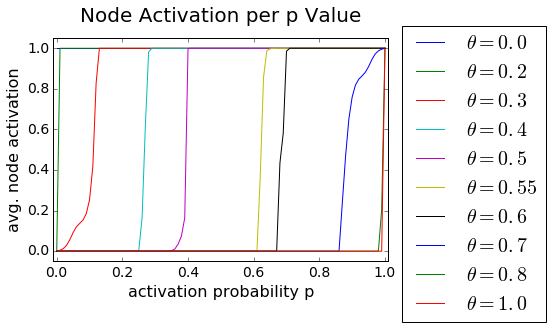

In [329]:
#plot average activation values per probabiliy p for different theta values
#ytvalues={0.0: [1.0 for i in range(101)]} #COMMENT OUT!
#ytvalues[theta]=yvalues
#print xvalues,yvalues

for key in sorted(ytvalues):
    if key==0.25 or key==0.75 or key==0.1 or key==0.9: continue
    plt.plot(xvalues,ytvalues[key],label=r'$\theta='+str(key)+r'$')
    
plt.xlabel("activation probability p", size=16)
plt.ylabel("avg. node activation", size=16)
plt.title("Node Activation per p Value", size=20, y=1.05)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(bbox_to_anchor=(1.5, 1.1), fontsize=20) #0.9
plt.ylim([-.05,1.05])
plt.xlim([-.01,1.01])

In [330]:
for theta in sorted(ytvalues):
    print theta,[(round(xvalues[i],2),ytvalues[theta][i]) for i in range(101)]

0.0 [(0.0, 1.0), (0.01, 1.0), (0.02, 1.0), (0.03, 1.0), (0.04, 1.0), (0.05, 1.0), (0.06, 1.0), (0.07, 1.0), (0.08, 1.0), (0.09, 1.0), (0.1, 1.0), (0.11, 1.0), (0.12, 1.0), (0.13, 1.0), (0.14, 1.0), (0.15, 1.0), (0.16, 1.0), (0.17, 1.0), (0.18, 1.0), (0.19, 1.0), (0.2, 1.0), (0.21, 1.0), (0.22, 1.0), (0.23, 1.0), (0.24, 1.0), (0.25, 1.0), (0.26, 1.0), (0.27, 1.0), (0.28, 1.0), (0.29, 1.0), (0.3, 1.0), (0.31, 1.0), (0.32, 1.0), (0.33, 1.0), (0.34, 1.0), (0.35, 1.0), (0.36, 1.0), (0.37, 1.0), (0.38, 1.0), (0.39, 1.0), (0.4, 1.0), (0.41, 1.0), (0.42, 1.0), (0.43, 1.0), (0.44, 1.0), (0.45, 1.0), (0.46, 1.0), (0.47, 1.0), (0.48, 1.0), (0.49, 1.0), (0.5, 1.0), (0.51, 1.0), (0.52, 1.0), (0.53, 1.0), (0.54, 1.0), (0.55, 1.0), (0.56, 1.0), (0.57, 1.0), (0.58, 1.0), (0.59, 1.0), (0.6, 1.0), (0.61, 1.0), (0.62, 1.0), (0.63, 1.0), (0.64, 1.0), (0.65, 1.0), (0.66, 1.0), (0.67, 1.0), (0.68, 1.0), (0.69, 1.0), (0.7, 1.0), (0.71, 1.0), (0.72, 1.0), (0.73, 1.0), (0.74, 1.0), (0.75, 1.0), (0.76, 1.0), (0

In [55]:
#check modules on the karate network against the LTM
kmodules,ktranslator={},{}
ksunits,ksunit_map=get_sunits(NK)
print len(ksunits),ksunit_map

68 {0: u'1-0', 1: u'1-1', 2: u'2-0', 3: u'2-1', 4: u'3-0', 5: u'3-1', 6: u'4-0', 7: u'4-1', 8: u'5-0', 9: u'5-1', 10: u'6-0', 11: u'6-1', 12: u'7-0', 13: u'7-1', 14: u'8-0', 15: u'8-1', 16: u'9-0', 17: u'9-1', 18: u'10-0', 19: u'10-1', 20: u'11-0', 21: u'11-1', 22: u'12-0', 23: u'12-1', 24: u'13-0', 25: u'13-1', 26: u'14-0', 27: u'14-1', 28: u'15-0', 29: u'15-1', 30: u'16-0', 31: u'16-1', 32: u'17-0', 33: u'17-1', 34: u'18-0', 35: u'18-1', 36: u'19-0', 37: u'19-1', 38: u'20-0', 39: u'20-1', 40: u'21-0', 41: u'21-1', 42: u'22-0', 43: u'22-1', 44: u'23-0', 45: u'23-1', 46: u'24-0', 47: u'24-1', 48: u'25-0', 49: u'25-1', 50: u'26-0', 51: u'26-1', 52: u'27-0', 53: u'27-1', 54: u'28-0', 55: u'28-1', 56: u'29-0', 57: u'29-1', 58: u'30-0', 59: u'30-1', 60: u'31-0', 61: u'31-1', 62: u'32-0', 63: u'32-1', 64: u'33-0', 65: u'33-1', 66: u'34-0', 67: u'34-1'}


In [311]:
#find pathway modules for the LTM
#implement pinning for s=1 (because once a node is active, it is not allowed to change) and starting probability p=0
start_time = time.time()
kmodules,ktranslator=find_modules(NK,5,{sunit for sunit in ksunits if int(sunit)%2==1},ksunit_map,kmodules,ktranslator,
                                  reduced=True,ds=ds,tau=0.0001,iterations=10,pinning={1},p=0.5,seeds=None,data=True,samples=2000) 
#seeds=[[67,38],[66]]
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 2000
--- Total time: 18138.6160002 seconds ---


In [312]:
kmodules['(66, 67)']
kmodules['(67,)']
len(sorted(kmodules, key=lambda x: len(x), reverse=True))

8310

In [152]:
#add s=0 module (all nodes with p=0.5); assumes mf run and act_prob set accordingly
#kmodules['()']=act_prob
ktranslator['()']=()

In [47]:
#find information modules for the LTM
#NOTE: for length, we only want to count nodes that are active (state=1)
length=1
start_time = time.time()
print "All pathway modules:",len(kmodules)
ktm = info_modules(kmodules,ktranslator,s=length)
print "information modules:",len(ktm)
for seed in sorted(kmodules,key=lambda x: len([s for s in kmodules[x] if s[-1]=='1']),reverse=True): #print out top modules
    if len(to_list(seed,ksunit_map,ktranslator))==length and seed in ktm and \
        len([s for s in to_list(seed,ksunit_map,ktranslator) if s[-1]=='1'])==length: #only look at active nodes
        print to_list(seed,ksunit_map,ktranslator),len([s for s in kmodules[seed] if s[-1]=='1'])#,kmodules[seed]
print("--- Total time: %s seconds ---" % (time.time()-start_time))

All pathway modules: 68
information modules: 44
[u'34-1'] 14
[u'2-1'] 13
[u'3-1'] 6
[u'11-1'] 2
[u'5-1'] 2
[u'27-1'] 2
[u'23-1'] 1
[u'21-1'] 1
[u'22-1'] 1
[u'17-1'] 1
[u'19-1'] 1
--- Total time: 0.00200009346008 seconds ---


In [101]:
#find precision and recall of network modules
#check both length and identity of sets
tp,fp=0.0,0.0
avg_sim=0.0 #average similarity based on jaccard index
for seed in kmodules.keys(): 
    sunit=to_list(seed,ksunit_map,ktranslator)[0]
    if '-1' in sunit:
        predicted={s[:-2] for s in kmodules[seed] if '-1' in s}
        label=ltkmodules[sunit[:-2]]
        #print sunit, predicted, label
        if predicted==label:
            tp+=1
        avg_sim+=len(predicted.intersection(label))/len(predicted.union(label))
print "accuracy:",tp/len(ltkmodules)
print "average similarity:",avg_sim/len(ltkmodules)

accuracy: 0.617647058824
average similarity: 0.785198135198


In [41]:
#max diffusion for two node activation, uses influence and ltkmodules from above
s=1
ltktranslator={}
seeds=list(combinations(N.nodes(),s))
print len(seeds)
for seed in seeds:
    seed=sorted([int(unit) for unit in seed])
    diffusion = ip.linear_threshold(N,[str(s) for s in seed])
    nodes_reached = {n for ls in diffusion for n in ls}
    influence[str(seed)] = len(nodes_reached)
    #ltkmodules[str(seed)]=nodes_reached  #store only the active node set
    ltkmodules[str(seed)]=diffusion #ALTERNATIVE: store the whole diffusion process
    ltktranslator[str(seed)] = seed
    
#for key in sorted(influence,key=lambda x: influence[x],reverse=True): print key,'\t',influence[key]

34


In [173]:
#check statistics for higher k values
s=2
tp,fp=0.0,0.0
avg_sim=0.0 #average similarity based on jaccard index
#for seed in kmodules.keys(): #all results
for seed in sorted(kmodules,key=lambda x: len([s for s in kmodules[x] if s[-1]=='1']),reverse=True)[:]: #top results
    sunits=to_list(seed,ksunit_map,ktranslator)
    if len(sunits)!=s: #only check given seed size
        continue
    if sum(['-0' in sunit for sunit in sunits]): #includes inactive s-units
        continue
    predicted={s[:-2] for s in kmodules[seed] if '-1' in s}
    alt_seed=sorted([int(sunit[:-2]) for sunit in sunits])
    label=ltkmodules[str(alt_seed)]
    #print sunits, predicted, label
    if predicted==label:
        tp+=1
    avg_sim+=len(predicted.intersection(label))/len(predicted.union(label))
print "accuracy:",tp/len(ltkmodules)
print "average similarity:",avg_sim/len(ltkmodules)

accuracy: 0.146218487395
average similarity: 0.536638761189


In [172]:
#determine precision and recall based on the activation probabilities of the results
top_ls=sorted(kmodules,key=lambda x: len([s for s in kmodules[x] if s[-1]=='1']),reverse=True)[:108]
top_ls=[seed for seed in top_ls if len(to_list(seed,ksunit_map,ktranslator))==2 and 
        sum(['-0' in sunit for sunit in to_list(seed,ksunit_map,ktranslator)])==0]
print len(top_ls)

100


In [244]:
#compare these results based on their activation probabilities and sampling of possible other network states
length=1
runs=10
tau,iterations=0.0001,3 #match the parameters above
unknown_prob=0.2
act_prob_sim={}
precisions,recalls=[],[]
for seed in kmodules: 
    sunits=to_list(seed,ksunit_map,ktranslator)
    if len(sunits)!=length:
        continue
    if sum(['-0' in sunit for sunit in sunits]): #includes inactive s-units
        continue
        
    module=kmodules[seed]
    print sunits[0],module
    act_prob_sim[seed] = {node: 0.0 for node in N.nodes()}
    for i in range(runs):
        #initiate a random condition
        alt_seed=sorted([int(sunit[:-2]) for sunit in sunits])
        for node in set(N.nodes())-set(alt_seed):
            if random.random()<unknown_prob:
                alt_seed.append(node)
        #find the information diffusion for the sample
        diffusion = ip.linear_threshold(N,[str(s) for s in alt_seed])
        nodes_reached = {n for ls in diffusion for n in ls}
        #print len(alt_seed),len(nodes_reached)
        for node in nodes_reached:
            act_prob_sim[seed][node]+=1
    #find average
    act_prob_sim[seed]={node:act_prob_sim[seed][node]/runs for node in act_prob_sim[seed]}
    
    precision,recall=1.0,0.0
    for sunit in module:
        print sunit,act_prob_sim[seed][sunit[:-2]]
        precision*=act_prob_sim[seed][sunit[:-2]]
        if act_prob_sim[seed][sunit[:-2]]==1: 
            recall+=1
    recall/=len({node for node in act_prob_sim[seed] if act_prob_sim[seed][node]==1})
    precisions.append(precision)
    recalls.append(recall)
    print 'precision:',precision,'recall:',recall
    
print 'average precision:',np.mean(precisions),'average recall:',np.mean(recalls) 

3-1 set([u'4-1', u'2-1', u'3-1', u'8-1', u'10-1', u'14-1'])
4-1 0.8
2-1 0.8
3-1 1.0
8-1 0.8
10-1 1.0
14-1 0.8
precision: 0.4096 recall: 1.0
5-1 set([u'7-1', u'5-1'])
7-1 0.6
5-1 1.0
precision: 0.6 recall: 1.0
27-1 set([u'28-1', u'27-1'])
28-1 0.1
27-1 1.0
precision: 0.1 recall: 1.0
24-1 set([u'25-1', u'24-1'])
25-1 1.0
24-1 1.0
precision: 1.0 recall: 1.0
29-1 set([u'29-1'])
29-1 1.0
precision: 1.0 recall: 1.0
17-1 set([u'17-1'])
17-1 1.0
precision: 1.0 recall: 1.0
26-1 set([u'28-1', u'26-1'])
28-1 0.4
26-1 1.0
precision: 0.4 recall: 1.0
1-1 set([u'4-1', u'2-1', u'1-1', u'3-1', u'14-1', u'18-1', u'13-1', u'16-1', u'8-1'])
4-1 0.8
2-1 0.8
1-1 1.0
3-1 0.8
14-1 0.8
18-1 1.0
13-1 0.8
16-1 1.0
8-1 0.8
precision: 0.262144 recall: 1.0
21-1 set([u'21-1'])
21-1 1.0
precision: 1.0 recall: 1.0
28-1 set([u'28-1', u'34-1', u'31-1', u'30-1', u'33-1', u'32-1', u'26-1', u'24-1', u'29-1', u'25-1', u'10-1'])
28-1 1.0
34-1 0.9
31-1 1.0
30-1 1.0
33-1 1.0
32-1 1.0
26-1 0.9
24-1 1.0
29-1 1.0
25-1 1.0
10-1 0.

In [43]:
#compare mf probabilities against ground truth to check the error in the approximation per iteration
#ASSUMES act_prob stored in kmodules and ltkmodules are known
#also compare only those transitions that are guaranteed to occur (p=1) against our pathway modules
#NOTE that the mean-field approximation converges faster than the ground truth
#NOTE there is no ground truth for mixed seeds OR inactive seeds because the lt model doesn't take nodes pinned at 0 into account
length=1
avg_sim=0.0 #average similarity based on jaccard index
seeds=kmodules.keys() #kmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
tau=0.30 #tolerance if not considering all probabilities
p=0.5 #expected probability of unknown nodes
iterations=10 #NOTE: assumes ALL seeds are run for x iterations
tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
total=0
check_all=1 #check all probabilities, otherwise force strict requirement that p~1 or else it's inactive
for seed in seeds: 
    sunits=to_list(seed,ksunit_map,ktranslator)
    if len(sunits)!=length:
        continue
    if len({int(sunit[:-2]) for sunit in sunits})!=len(sunits): #there is a contradiction
        continue
    alt_seed=sorted([int(sunit[:-2]) for sunit in sunits if '-1' in sunit]) #true diffusion
    if len(alt_seed)==length: #check both or len(alt_seed)==length or len(alt_seed)==0 or alt_seed and len(alt_seed)<length (mixed seeds)
        total+=1
        if not alt_seed: #only have inactive nodes in the seed
            label=[]
        else:
            label=ltkmodules[str(alt_seed)]
        #print label
        nodes_reached=set([]) #keep track of diffusion: once nodes are active they remain active
        for i in range(iterations):
            tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration
            if i < len(label): #otherwise, nodes_reached is already at maximum
                nodes_reached=nodes_reached.union(set(label[i]))
            #print nodes_reached,len(set(N.nodes())-nodes_reached)
            #true positives/false negatives
            for node in nodes_reached: #expected p=1
                if check_all: #check all probabilities, result * expected
                    tp+=kmodules[seed][i][node]
                    fn+=(1-kmodules[seed][i][node])
                elif kmodules[seed][i][node]>=(1-tau):
                    tp+=1
                else:
                    fn+=1
            #false positives/true negatives
            other_set=set(N.nodes())-nodes_reached
            for node in other_set: #expected p=0.5
                if check_all: #check all probabilities, result * expected
                    #fp+=kmodules[seed][i][node]
                    #tn+=(1-kmodules[seed][i][node])
                    fp+=abs(kmodules[seed][i][node]-p)/p
                    tn+=1-abs(kmodules[seed][i][node]-p)/p
                elif kmodules[seed][i][node]>=(1-tau):
                    fp+=1
                else:
                    tn+=1
            if nodes_reached:
                tps[i]+=tp/len(nodes_reached)
                fns[i]+=fn/len(nodes_reached)
            else:
                tps[i]+=1
            if other_set:
                fps[i]+=fp/len(other_set)
                tns[i]+=tn/len(other_set)
            else:
                tns[i]+=1
            #summary statistics
            accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
            if (tp+fn)!=0:
                recall[i]+=(tp)/(tp+fn)
            else: #no positives in module
                recall[i]+=1
            if (tp+fp)!=0:
                precision[i]+=(tp)/(tp+fp)
            else: #no positive predictions in module
                precision[i]+=1
        #print tp,fp,tn,fn       
        #avg_sim+=len(predicted.intersection(label))/len(predicted.union(label))

print total
#normalize and print
tps=[round(tps[i]/total,2) for i in range(iterations)]
fns=[round(fns[i]/total,2) for i in range(iterations)]
fps=[round(fps[i]/total,2) for i in range(iterations)]
tns=[round(tns[i]/total,2) for i in range(iterations)]
accuracy=[round(accuracy[i]/total,2) for i in range(iterations)]
recall=[round(recall[i]/total,2) for i in range(iterations)]
precision=[round(precision[i]/total,2) for i in range(iterations)]
print 'true positives:',tps
print 'false negatives:',fns
print 'true negatives:',tns
print 'false positives:',fps
#accuracy=[(tps[i]+tns[i])/(tps[i]+tns[i]+fps[i]+fns[i]) for i in range(iterations)]
#recall=[tps[i]/(tps[i]+fns[i]) if tps[i]+fns[i]!=0 else 0 for i in range(iterations)]
#precision=[tps[i]/(tps[i]+fps[i]) if tps[i]+fps[i]!=0 else 0 for i in range(iterations)]
print 'accuracy:',accuracy
print 'recall:',recall
print 'precision:',precision
#print "average similarity:",avg_sim/len(ltkmodules)
atau3=accuracy
ptau3=precision
#print ltkmodules['[34]']

34
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [1.0, 0.7, 0.38, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [0.0, 0.3, 0.62, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [1.0, 0.72, 0.41, 0.1, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [1.0, 0.14, 0.08, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06]


In [42]:
#print ltkmodules['[2, 34]']
#kmodules['(18, 67)']
print ltkmodules['[34]']

[['34'], [u'10', u'25', u'33', u'32', u'31', u'30', u'29'], [u'24'], [u'28'], [u'26', u'20'], [u'9', u'22'], []]


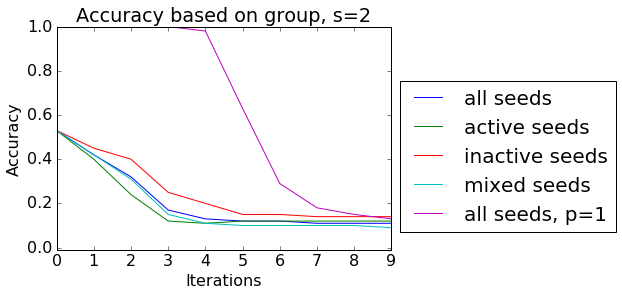

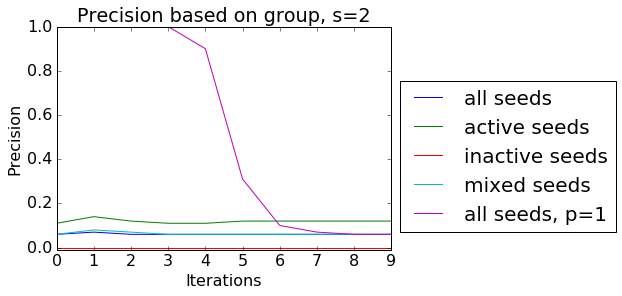

In [573]:
#graph accuracy and precision of different methods of analysis based on yvalues set above (note recall always is 1)
xvalues=[i for i in range(iterations)]
#accuracy
plt.plot(xvalues,avalues1,label='all seeds') 
#plt.plot(xvalues,avalues,label='active seeds') #s=1
plt.plot(xvalues,avalues2,label='active seeds') #s=2
plt.plot(xvalues,avalues3,label='inactive seeds')
plt.plot(xvalues,avalues5,label='mixed seeds') #s=2
plt.plot(xvalues,avalues4,label='all seeds, p=1')
plt.title('Accuracy based on group, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim([-0.01,1])
plt.legend(bbox_to_anchor=(1.7, 0.8), fontsize=20)
plt.show()
#precision
plt.plot(xvalues,pvalues1,label='all seeds') 
#plt.plot(xvalues,pvalues,label='active seeds') #s=1
plt.plot(xvalues,pvalues2,label='active seeds') #s=2
plt.plot(xvalues,pvalues3,label='inactive seeds')
plt.plot(xvalues,pvalues5,label='mixed seeds') #s=2
plt.plot(xvalues,pvalues4,label='all seeds, p=1')
plt.title('Precision based on group, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Precision')
plt.ylim([-0.01,1])
plt.legend(bbox_to_anchor=(1.7, 0.8), fontsize=20)
plt.show()

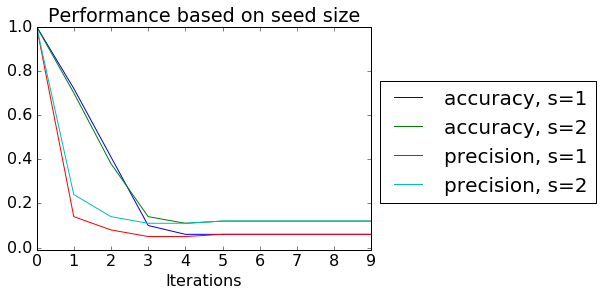

In [591]:
#graph comparison between s=1 and s=2
xvalues=[i for i in range(iterations)]
#accuracy
plt.plot(xvalues,avalues,label='accuracy, s=1')
plt.plot(xvalues,avalues2,label='accuracy, s=2')
#precision
plt.plot(xvalues,pvalues,label='precision, s=1')
plt.plot(xvalues,pvalues2,label='precision, s=2')
plt.title('Performance based on seed size')
plt.xlabel('Iterations')
#plt.ylabel('')
plt.ylim([-0.01,1])
plt.legend(bbox_to_anchor=(1.7, 0.8), fontsize=20)

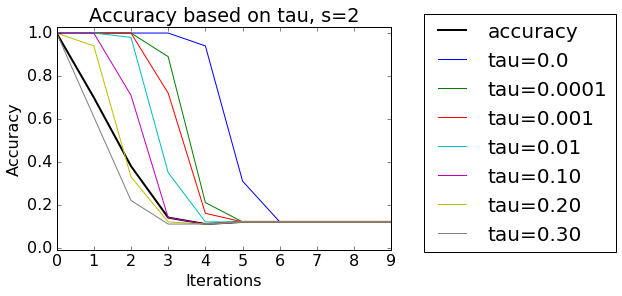

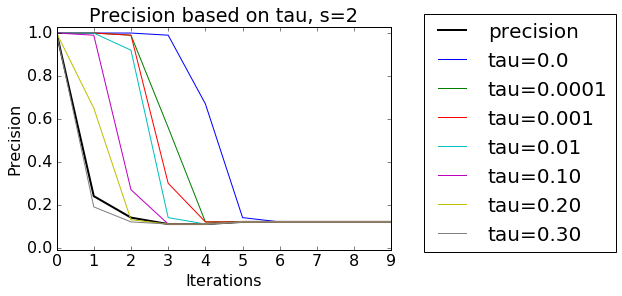

In [631]:
#graph comparison over different tau values
xvalues=[i for i in range(iterations)]
#accuracy
#plt.plot(xvalues,avalues,label='accuracy',color='black',linewidth=2) #s=1
plt.plot(xvalues,avalues2,label='accuracy',color='black',linewidth=2) #s=2
plt.plot(xvalues,atau0,label='tau=0.0')
plt.plot(xvalues,atau0001,label='tau=0.0001')
plt.plot(xvalues,atau001,label='tau=0.001')
plt.plot(xvalues,atau01,label='tau=0.01')
plt.plot(xvalues,atau1,label='tau=0.10')
plt.plot(xvalues,atau2,label='tau=0.20')
plt.plot(xvalues,atau3,label='tau=0.30',color='grey')
plt.title('Accuracy based on tau, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(1.7, 1.1), fontsize=20)
plt.show()
#precision
#plt.plot(xvalues,pvalues,label='precision',color='black',linewidth=2) #s=1
plt.plot(xvalues,pvalues2,label='precision',color='black',linewidth=2) #s=2
plt.plot(xvalues,ptau0,label='tau=0.0')
plt.plot(xvalues,ptau0001,label='tau=0.0001')
plt.plot(xvalues,ptau001,label='tau=0.001')
plt.plot(xvalues,ptau01,label='tau=0.01')
plt.plot(xvalues,ptau1,label='tau=0.10')
plt.plot(xvalues,ptau2,label='tau=0.20')
plt.plot(xvalues,ptau3,label='tau=0.30',color='grey')
plt.title('Precision based on tau, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Precision')
plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(1.7, 1.1), fontsize=20)
plt.show()

In [ ]:
#compare approximation against simulations
#1. compare all probabilities (how well do we estimate the average configuration with uncertainty?)
#2. compare constants (nodes always ON or OFF, how well do we isolate the individual component effects?)

In [314]:
#compare mf probabilities against simulations to check the error in the approximation per iteration
#ASSUMES act_prob stored in kmodules
#also compare only those transitions that are guaranteed to occur (p=1) against our pathway modules
#NOTE that the mean-field approximation converges faster than the ground truth??
#NOTE there is no ground truth for mixed seeds OR inactive seeds because the lt model doesn't take nodes pinned at 0 into account
length=5
runs=100
tau,iterations=0.0,10 #assumes ALL seeds are run for x iterations
unknown_prob=0.5
act_prob_sim={}
seeds=kmodules.keys() #kmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=['(3, 67)']
simulations={} #store the random simulations per seed
#p=0.5 #expected probability of unknown nodes
tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
total=0
nodes=set(N.nodes())
for seed in seeds: 
    sunits=to_list(seed,ksunit_map,ktranslator)
    if len(sunits)!=length:
        continue
    if sum(['-0' in sunit for sunit in sunits]): #includes inactive s-units
        continue
    if len({int(sunit[:-2]) for sunit in sunits})!=len(sunits): #there is a contradiction
        continue
    total+=1
        
    #module=kmodules[seed]
    act_prob_sim[seed] = {i:{node: 0.0 for node in N.nodes()} for i in range(iterations)}
    simulations[seed] = {}
    
    #get the ground truth for the seed based on several runs
    for i in range(runs):
        #initiate a random condition
        alt_seed=sorted([int(sunit[:-2]) for sunit in sunits])
        for node in nodes-set(alt_seed):
            if random.random()<unknown_prob:
                alt_seed.append(node)
        #find the information diffusion for the sample
        diffusion = ip.linear_threshold(N,[str(s) for s in alt_seed])
        nodes_reached = set([])
        simulations[seed][str(alt_seed)]={i:{node: 0.0 for node in N.nodes()} for i in range(iterations)} #to calculate a baseline
        #print len(alt_seed),len(nodes_reached)
        for index in range(iterations):
            if index < len(diffusion): #otherwise, nodes_reached is already at maximum
                nodes_reached=nodes_reached.union(set(diffusion[index]))
            for node in nodes_reached:
                act_prob_sim[seed][index][node]+=1
                simulations[seed][str(alt_seed)][index][node]=1
    #find average (our label)
    act_prob_sim[seed]={index:{node:act_prob_sim[seed][index][node]/runs for node in act_prob_sim[seed][index]} for index in range(iterations)}
    #print seed,act_prob_sim[seed][iterations-1]
    
    #compare to our prediction
    for i in range(iterations):
        error=0.0 #error based on all node probabilities
        tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
        constants={node for node in act_prob_sim[seed][i] if act_prob_sim[seed][i][node]==1.0} #our constants (nodes always active)
        #diffusion=ip.linear_threshold(N,[str(s) for s in sorted([int(sunit[:-2]) for sunit in sunits])])
        #constants={node for ls in diffusion for node in ls} #alternate, true module at runs=infinity
        predicted={node for node in act_prob_sim[seed][i] if kmodules[seed][i][node]>=(1-tau)}
        for node in act_prob_sim[seed][i]:
            label=act_prob_sim[seed][i][node]
            error+=abs(label-kmodules[seed][i][node])**2
            #stats based on actual module
            if label==1 and kmodules[seed][i][node]>=(1-tau):
                tp+=1
            elif label==1:
                fn+=1
            elif kmodules[seed][i][node]>=(1-tau):
                fp+=1
            else:
                tn+=1
        
        if predicted.union(constants):
            avg_sim[i]+=len(predicted.intersection(constants))/len(predicted.union(constants))
        else: #no predicted or actual constants
            avg_sim[i]+=1
        errors[i]+=math.sqrt(error)/len(act_prob_sim[seed][i]) #normalize per node
        #print len(constants),errors[i],avg_sim[i],error
        #print tp,fn,fp,tn
        #print seed,act_prob_sim[seed][i]

        if constants:
            tps[i]+=tp/len(constants)
            fns[i]+=fn/len(constants)
        else: #no true positives
            tps[i]+=1
        other_set=nodes-constants
        if other_set:
            fps[i]+=fp/len(other_set)
            tns[i]+=tn/len(other_set)
        else: #no true negatives
            tns[i]+=1
        #summary statistics
        accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
        if (tp+fn)!=0:
            recall[i]+=(tp)/(tp+fn)
        else: #no positives in module
            recall[i]+=1
        if (tp+fp)!=0:
            precision[i]+=(tp)/(tp+fp)
        else: #no positive predictions in module
            precision[i]+=1
    
print total
#normalize and print
tps=[round(tps[i]/total,2) for i in range(iterations)]
fns=[round(fns[i]/total,2) for i in range(iterations)]
fps=[round(fps[i]/total,2) for i in range(iterations)]
tns=[round(tns[i]/total,2) for i in range(iterations)]
accuracy=[round(accuracy[i]/total,2) for i in range(iterations)]
recall=[round(recall[i]/total,2) for i in range(iterations)]
precision=[round(precision[i]/total,2) for i in range(iterations)]
avg_sim=[round(avg_sim[i]/total,2) for i in range(iterations)]
errors=[round(errors[i]/total,3) for i in range(iterations)]
print 'true positives:',tps
print 'false negatives:',fns
print 'true negatives:',tns
print 'false positives:',fps
#accuracy=[(tps[i]+tns[i])/(tps[i]+tns[i]+fps[i]+fns[i]) for i in range(iterations)]
#recall=[tps[i]/(tps[i]+fns[i]) if tps[i]+fns[i]!=0 else 0 for i in range(iterations)]
#precision=[tps[i]/(tps[i]+fps[i]) if tps[i]+fps[i]!=0 else 0 for i in range(iterations)]
print 'accuracy:',accuracy
print 'recall:',recall
print 'precision:',precision
print 'average similarity:',avg_sim
print 'errors:',errors
#atau3=accuracy
#ptau3=precision

1990
true positives: [1.0, 1.0, 0.83, 0.59, 0.75, 0.99, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.17, 0.41, 0.25, 0.01, 0.0, 0.0, 0.0, 0.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 0.79, 0.41, 0.28, 0.32, 0.33, 0.34]
false positives: [0.0, 0.0, 0.0, 0.0, 0.21, 0.59, 0.72, 0.68, 0.67, 0.66]
accuracy: [1.0, 1.0, 0.94, 0.78, 0.75, 0.78, 0.76, 0.77, 0.78, 0.78]
recall: [1.0, 1.0, 0.83, 0.59, 0.75, 0.99, 1.0, 1.0, 1.0, 1.0]
precision: [1.0, 1.0, 1.0, 1.0, 0.84, 0.77, 0.76, 0.77, 0.78, 0.78]
average similarity: [1.0, 1.0, 0.83, 0.59, 0.65, 0.76, 0.76, 0.77, 0.78, 0.78]
errors: [0.008, 0.023, 0.009, 0.003, 0.002, 0.002, 0.001, 0.001, 0.001, 0.001]


In [315]:
#graph errors and statistics based on tau
if length==1:
    errors1=errors
    sim1=avg_sim
    accuracy1=accuracy
    precision1=precision
    recall1=recall
elif length==2:
    errors2=errors
    sim2=avg_sim
    accuracy2=accuracy
    precision2=precision
    recall2=recall
elif length==0:
    errors0=errors
    sim0=avg_sim
    accuracy0=accuracy
    precision0=precision
    recall0=recall
elif length==3:
    errors3=errors
    sim3=avg_sim
    accuracy3=accuracy
    precision3=precision
    recall3=recall
elif length==4:
    errors4=errors
    sim4=avg_sim
    accuracy4=accuracy
    precision4=precision
    recall4=recall
elif length==5:
    errors5=errors
    sim5=avg_sim
    accuracy5=accuracy
    precision5=precision
    recall5=recall
#tau variables
if tau==0:
    atau0=accuracy
    ptau0=precision
elif tau==0.0001:
    atau0001=accuracy
    ptau0001=precision
elif tau==0.001:
    atau001=accuracy
    ptau001=precision
elif tau==0.01:
    atau01=accuracy
    ptau01=precision
elif tau==0.1:
    atau1=accuracy
    ptau1=precision
elif tau==0.2:
    atau2=accuracy
    ptau2=precision
elif tau==0.3:
    atau3=accuracy
    ptau3=precision

In [316]:
#find the baseline: compare each simulation against all other simulations per seed
#assumes that the diffusions from the simulations are stored in the simulations dictionary
print len(simulations),'nodes'
#np.mean([np.mean([len(sim) for sim in simulations[seed]]) for seed in simulations])
length=5
tau,iterations=0.0,10 #assumes ALL seeds are run for x iterations
seeds=kmodules.keys() #kmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
act_prob_base={seed:{} for seed in seeds}
tps,fps=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
tns,fns=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
accuracy,recall,precision=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)],[0.0 for i in range(iterations)]
errors,avg_sim=[0.0 for i in range(iterations)],[0.0 for i in range(iterations)] #average similarity based on jaccard index
total=0
nodes=set(N.nodes())
for seed in seeds: 
    sunits=to_list(seed,ksunit_map,ktranslator)
    if len(sunits)!=length:
        continue
    if sum(['-0' in sunit for sunit in sunits]): #includes inactive s-units
        continue
    if len({int(sunit[:-2]) for sunit in sunits})!=len(sunits): #there is a contradiction
        continue
    runs=len(simulations[seed]) #these should all be the same
    
    #compare each run against all others to get the baseline
    for run in simulations[seed]:
        total+=1
        
        act_prob_base[seed][run] = {i:{node: 0.0 for node in N.nodes()} for i in range(iterations)}
        for i in range(iterations):
            for node in N.nodes():
                act_prob_base[seed][run][i][node]=sum([simulations[seed][run2][i][node] for run2 in simulations[seed] if run!=run2])/(runs-1)        
        #print act_prob_base[seed][run]
    
        #compare to our prediction
        for i in range(iterations):
            error=0.0 #error based on all node probabilities
            tp,fp,tn,fn=0.0,0.0,0.0,0.0 #keep track of statistics per iteration, based on nodes active within tau
            constants={node for node in act_prob_base[seed][run][i] if act_prob_base[seed][run][i][node]==1.0} #our constants (nodes always active)
            predicted={node for node in act_prob_base[seed][run][i] if simulations[seed][run][i][node]>=(1-tau)}
            
            for node in act_prob_base[seed][run][i]:
                label=act_prob_base[seed][run][i][node]
                error+=abs(label-simulations[seed][run][i][node])**2
                #stats based on actual module
                if label==1 and simulations[seed][run][i][node]>=(1-tau):
                    tp+=1
                elif label==1:
                    fn+=1
                elif simulations[seed][run][i][node]>=(1-tau):
                    fp+=1
                else:
                    tn+=1
        
            avg_sim[i]+=len(predicted.intersection(constants))/len(predicted.union(constants))
            errors[i]+=math.sqrt(error)/len(act_prob_base[seed][run][i]) #normalize per node
            #print i,len(constants),errors[i],avg_sim[i],error
            #print tp,fn,fp,tn
            #print seed,act_prob_base[seed][run][i]
            
            if constants:
                tps[i]+=tp/len(constants)
                fns[i]+=fn/len(constants)
            else: #no true positives
                tps[i]+=1
            other_set=nodes-constants
            if other_set:
                fps[i]+=fp/len(other_set)
                tns[i]+=tn/len(other_set)
            else: #no true negatives
                tns[i]+=1
            #summary statistics
            accuracy[i]+=(tp+tn)/(tp+tn+fp+fn)
            if (tp+fn)!=0:
                recall[i]+=(tp)/(tp+fn)
            else: #no positives in module
                recall[i]+=1
            if (tp+fp)!=0:
                precision[i]+=(tp)/(tp+fp)
            else: #no positive predictions in module
                precision[i]+=1
    
print total,'total runs,',total/runs,'seeds'
#normalize and print
tps=[round(tps[i]/total,2) for i in range(iterations)]
fns=[round(fns[i]/total,2) for i in range(iterations)]
fps=[round(fps[i]/total,2) for i in range(iterations)]
tns=[round(tns[i]/total,2) for i in range(iterations)]
accuracy=[round(accuracy[i]/total,2) for i in range(iterations)]
recall=[round(recall[i]/total,2) for i in range(iterations)]
precision=[round(precision[i]/total,2) for i in range(iterations)]
avg_sim=[round(avg_sim[i]/total,2) for i in range(iterations)]
errors=[round(errors[i]/total,3) for i in range(iterations)]
print 'true positives:',tps
print 'false negatives:',fns
print 'true negatives:',tns
print 'false positives:',fps
print 'accuracy:',accuracy
print 'recall:',recall
print 'precision:',precision
print 'average similarity:',avg_sim
print 'errors:',errors

1990 nodes
199000 total runs, 1990.0 seeds
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.5, 0.15, 0.05, 0.03, 0.1, 0.21, 0.29, 0.33, 0.34, 0.35]
false positives: [0.5, 0.85, 0.95, 0.97, 0.9, 0.79, 0.71, 0.67, 0.66, 0.65]
accuracy: [0.57, 0.37, 0.37, 0.54, 0.66, 0.74, 0.77, 0.78, 0.78, 0.78]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.26, 0.29, 0.35, 0.53, 0.66, 0.74, 0.77, 0.78, 0.78, 0.78]
average similarity: [0.26, 0.29, 0.35, 0.53, 0.66, 0.74, 0.77, 0.77, 0.78, 0.78]
errors: [0.08, 0.048, 0.02, 0.008, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003]


In [317]:
#graph baseline
if length==1:
    berrors1=errors
    bsim1=avg_sim
    baccuracy1=accuracy
    bprecision1=precision
    brecall1=recall
elif length==2:
    berrors2=errors
    bsim2=avg_sim
    baccuracy2=accuracy
    bprecision2=precision
    brecall2=recall
elif length==0:
    berrors0=errors
    bsim0=avg_sim
    baccuracy0=accuracy
    bprecision0=precision
    brecall0=recall
elif length==3:
    berrors3=errors
    bsim3=avg_sim
    baccuracy3=accuracy
    bprecision3=precision
    brecall3=recall
elif length==4:
    berrors4=errors
    bsim4=avg_sim
    baccuracy4=accuracy
    bprecision4=precision
    brecall4=recall
elif length==5:
    berrors5=errors
    bsim5=avg_sim
    baccuracy5=accuracy
    bprecision5=precision
    brecall5=recall

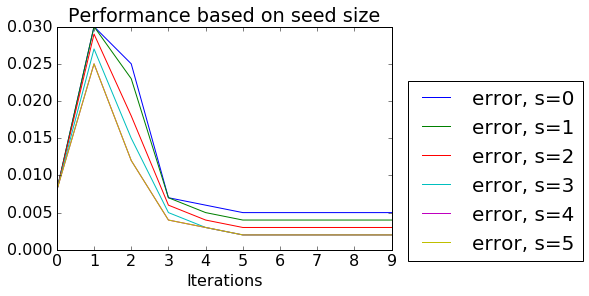

In [320]:
#graph comparison between s=1 and s=2
xvalues=[i for i in range(iterations)]
#accuracy
#plt.plot(xvalues,accuracy5,label='accuracy, s=5')
#plt.plot(xvalues,accuracy2,label='accuracy, s=2')
#precision
#plt.plot(xvalues,precision5,label='precision, s=5')
#plt.plot(xvalues,precision2,label='precision, s=2')
#errors
plt.plot(xvalues,errors0,label='error, s=0')
plt.plot(xvalues,errors1,label='error, s=1')
plt.plot(xvalues,errors2,label='error, s=2')
plt.plot(xvalues,errors3,label='error, s=3')
plt.plot(xvalues,errors4,label='error, s=4')
plt.plot(xvalues,errors4,label='error, s=5')
#average similarity of constants
#plt.plot(xvalues,sim5,label='constant similarity, s=5')
#plt.plot(xvalues,sim2,label='constant similarity, s=2')
#baselines
#plt.plot(xvalues,baccuracy5,label='base accuracy, s=5')
#plt.plot(xvalues,baccuracy2,label='base accuracy, s=2')
#plt.plot(xvalues,bprecision5,label='base precision, s=5')
#plt.plot(xvalues,bprecision2,label='base precision, s=2')
#plt.plot(xvalues,bsim5,label='base similarity, s=5')
#plt.plot(xvalues,bsim2,label='base similarity, s=2')
#plt.plot(xvalues,berrors1,label='base error, s=1')
#plt.plot(xvalues,berrors2,label='base error, s=2')

plt.title('Performance based on seed size')
plt.xlabel('Iterations')
#plt.ylabel('')
#plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(2.0, 0.8), fontsize=20)
plt.legend(bbox_to_anchor=(1.6, 0.8), fontsize=20) #errors
#plt.legend(bbox_to_anchor=(2.0, 0.95), fontsize=20) #with baselines

In [273]:
#data writing
data={}
for seed in kmodules: 
    sunits=to_list(seed,ksunit_map,ktranslator)
    if len(sunits)<=2:
        data[seed]=kmodules[seed]
len(kmodules),len(data)

(6318, 2347)

In [274]:
#json dump and retrieve
#with open('kmodules-s2.json', 'w') as fp:
#    json.dump(data, fp)

In [281]:
m2=json.load(open( "kmodules-s2.json" ))
len(m2)

2347

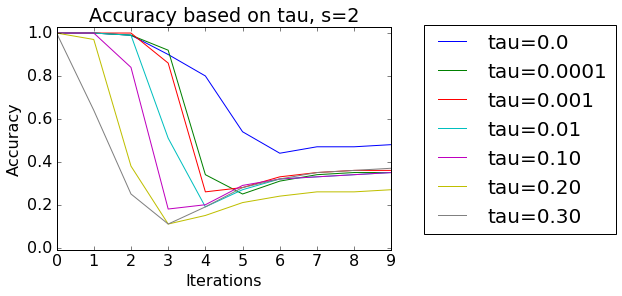

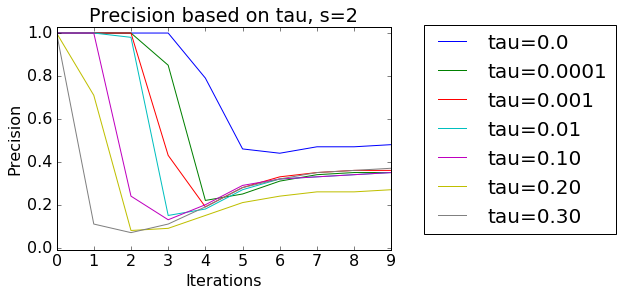

In [190]:
#graph comparison over different tau values
xvalues=[i for i in range(iterations)]
#accuracy
plt.plot(xvalues,atau0,label='tau=0.0')
plt.plot(xvalues,atau0001,label='tau=0.0001')
plt.plot(xvalues,atau001,label='tau=0.001')
plt.plot(xvalues,atau01,label='tau=0.01')
plt.plot(xvalues,atau1,label='tau=0.10')
plt.plot(xvalues,atau2,label='tau=0.20')
plt.plot(xvalues,atau3,label='tau=0.30',color='grey')
plt.title('Accuracy based on tau, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(1.7, 1.05), fontsize=20)
plt.show()
#precision
#plt.plot(xvalues,pvalues,label='precision',color='black',linewidth=2) #s=1
plt.plot(xvalues,ptau0,label='tau=0.0')
plt.plot(xvalues,ptau0001,label='tau=0.0001')
plt.plot(xvalues,ptau001,label='tau=0.001')
plt.plot(xvalues,ptau01,label='tau=0.01')
plt.plot(xvalues,ptau1,label='tau=0.10')
plt.plot(xvalues,ptau2,label='tau=0.20')
plt.plot(xvalues,ptau3,label='tau=0.30',color='grey')
plt.title('Precision based on tau, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Precision')
plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(1.7, 1.05), fontsize=20)
plt.show()

In [62]:
#find arbitrary vector s -> s*, sample from s to find starting conditions sigma over many runs, find average sigma*, compare to s*
#start by sampling from distributions of mostly p=0
p={node.name: 0.0 for node in NK.nodes} #global activation probability of nodes, 0 by default
start_nodes=['34'] #nodes we set to 1
for node in start_nodes: p[node]=1.0
#perturbations
#for i in range(5):
#    p[random.choice(NK.nodes).name]=0.5
for node in ['22','3','4','7','15']:
    p[node]=0.5
print p
iterations=18 #0 is considered the starting state, then iterations 1,2,3...
act_prob_s = {i: {node.name: p[node.name] for node in NK.nodes} for i in range(iterations+1)}
tau,total=0.001,[]
total_act=0 #rows that output 1
for i in range(1,iterations+1):
    for node in NK.nodes:
        s,t=mf_approx(node,act_prob_s,i,reduced=True,ds=ds) #solve equation based on probabilities of inputs
        if act_prob_s[i-1][node.name]==1: #and node.name in start_nodes: #keep active nodes pinned to 1
            act_prob_s[i][node.name]=1
        else:
            act_prob_s[i][node.name]=s
        if i==iterations: 
            print node.name,s,t,2**node.k,node.inputs
            total_act+=t #only need to count once
            if act_prob_s[i][node.name] > (1-tau): total.append(node.name)
    if act_prob_s[i]==act_prob_s[i-1]: #allow for early exit
        print "iterations taken:",i
        break

total_rows=0
avg_act=0.0 #average activation value
for node in NK.nodes: 
    total_rows+=2**node.k
    avg_act+=act_prob_s[i][node.name]
print total_act/total_rows, avg_act/len(NK.nodes), len(total), total
s_prime={node.name: act_prob_s[i][node.name] for node in NK.nodes}
print s_prime
print "activated nodes:",sum([act_prob_s[i][node] for node in act_prob_s[i]])

{u'24': 0.0, u'25': 0.0, u'26': 0.0, u'27': 0.0, u'20': 0.0, u'21': 0.0, u'22': 0.5, u'23': 0.0, u'28': 0.0, u'29': 0.0, u'1': 0.0, u'3': 0.5, u'2': 0.0, u'5': 0.0, u'4': 0.5, u'7': 0.5, u'6': 0.0, u'9': 0.0, u'8': 0.0, u'11': 0.0, u'10': 0.0, u'13': 0.0, u'12': 0.0, u'15': 0.5, u'14': 0.0, u'17': 0.0, u'16': 0.0, u'19': 0.0, u'18': 0.0, u'31': 0.0, u'30': 0.0, u'34': 1.0, u'33': 0.0, u'32': 0.0}
1 0.0 256 512 [u'26', u'14', u'17', u'16', u'18', u'3', u'2', u'4', u'8']
2 0.0 26333 65536 [u'11', u'13', u'12', u'14', u'17', u'16', u'18', u'1', u'3', u'27', u'5', u'4', u'7', u'6', u'9', u'8']
3 1.0 386 1024 [u'10', u'14', u'22', u'23', u'28', u'1', u'2', u'4', u'9', u'8']
4 0.0 22 64 [u'13', u'14', u'1', u'3', u'2', u'8']
5 0.0 4 8 [u'11', u'2', u'7']
6 0.0 5 16 [u'11', u'2', u'15', u'7']
7 0.0 5 16 [u'5', u'2', u'15', u'6']
8 0.0 5 16 [u'1', u'3', u'2', u'4']
9 1.0 16 32 [u'3', u'2', u'28', u'26', u'34']
10 1.0 1 4 [u'3', u'34']
11 0.0 4 8 [u'2', u'5', u'6']
12 0.0 1 2 [u'2']
13 0.0 1 4 


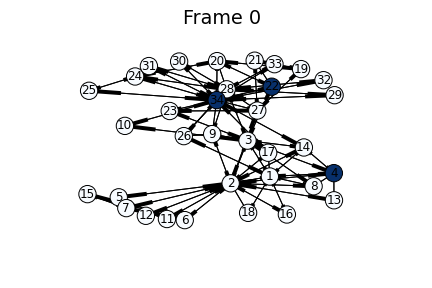
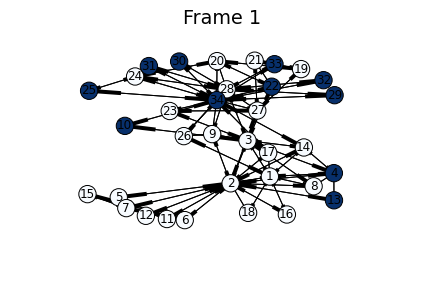
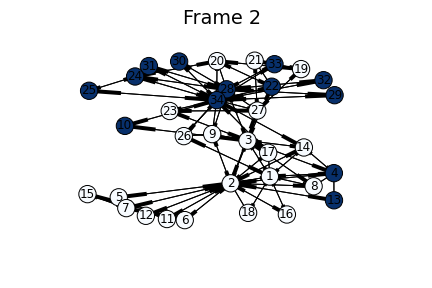
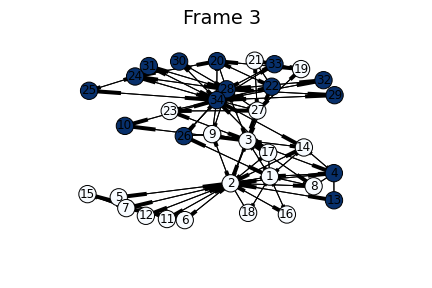
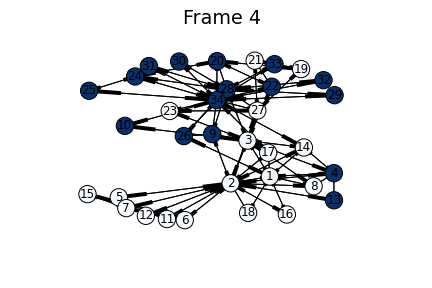
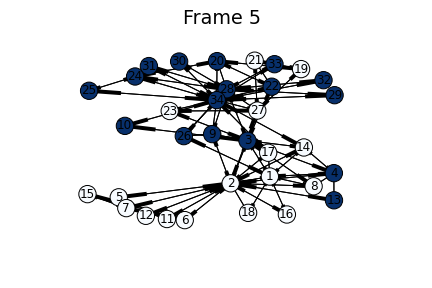
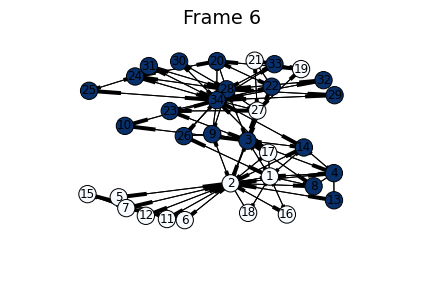
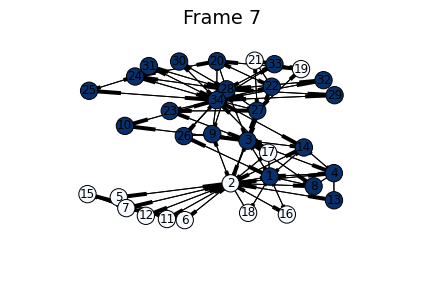
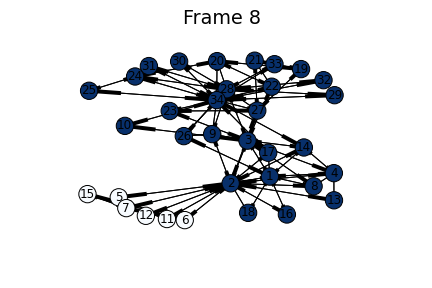
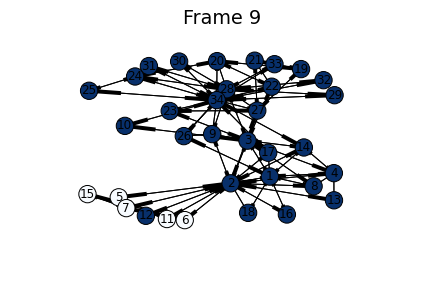
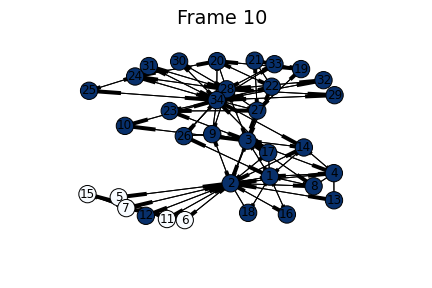
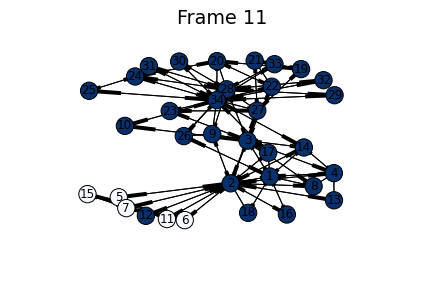
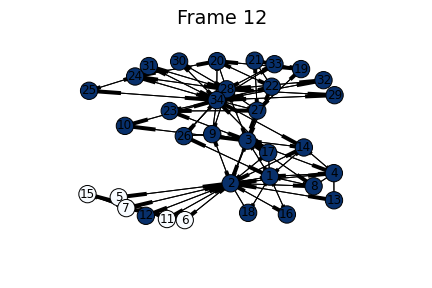
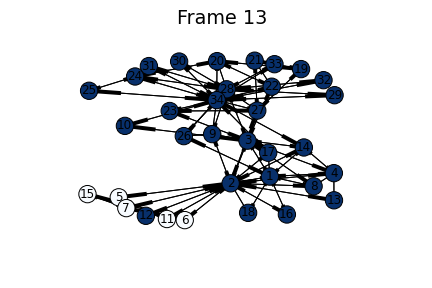
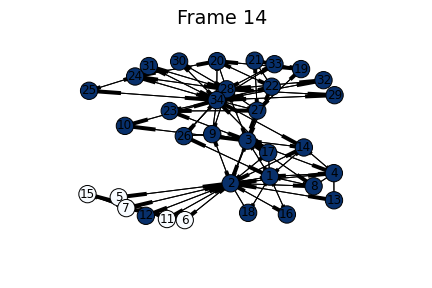
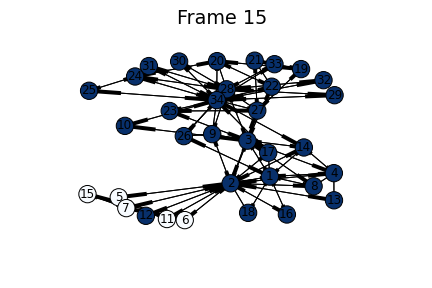
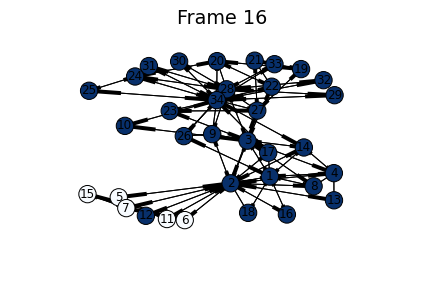
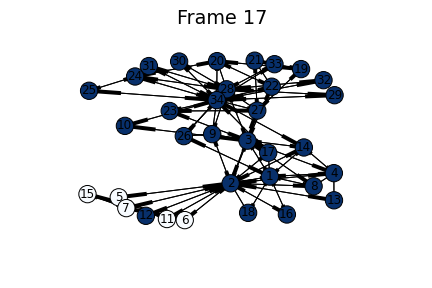

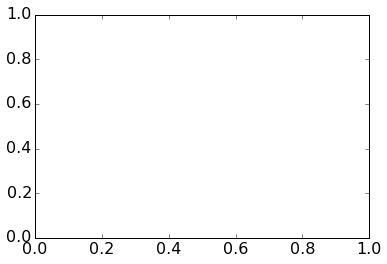

In [89]:
from matplotlib import animation
from JSAnimation import IPython_display

def simple_update(num, G, ax, layout):
    ax.clear()

    # Draw the graph with random node colors
    #random_colors = np.random.randint(2, size=n)
    #nx.draw(G, pos=layout, node_color=random_colors, ax=ax)

    # Set the title
    ax.set_title("Frame {}".format(num))
    
    #arr=[act_prob_s[num][x] for x in act_prob_s[num]]
    arr=[act_prob[num][x] for x in act_prob[num]]
    nx.draw(N, with_labels=True, node_color=arr, cmap=plt.cm.Blues, ax=ax, pos=layout)

def animate():
    fig, ax = plt.subplots(figsize=(6,4))
    layout = nx.spring_layout(N)
    ani = animation.FuncAnimation(fig, simple_update, frames=18, fargs=(N,ax,layout))
    #ani.save('animation_1.gif', writer='imagemagick')
    #plt.show()
    return ani
    
animate()

In [74]:
#compare many initial conditions sigma to s*
#NOTE: if we pin all nodes at 1, then we get rid of any limit cycles
runs=100
activations={node.name: 0.0 for  node in NK.nodes}
iterations=18 #increase iterations to make sure that everything converges
errors={i:0 for i in range(iterations+1)}
for r in range(runs):
    sigma={}
    for node in p:
        if random.random() < p[node]: #compare random floating point number to activation probability
            sigma[node]=1.0
        else:
            sigma[node]=0.0
    #print sigma
    act_prob = {i: {node.name: sigma[node.name] for node in NK.nodes} for i in range(iterations+1)}
    print "Run:",r,[sigma[node] for node in ['22','3','4','7','15']] #starting condition
    total=[] #store the resulting module
    for node in NK.nodes:
        errors[0]+=(act_prob[0][node.name]-act_prob_s[0][node.name])**2
    exiting=False
    for i in range(1,iterations+1):
        for node in NK.nodes:
            if not exiting:   
                if act_prob[i-1][node.name]==1: #and node.name in start_nodes: #keep active starting nodes pinned to 1
                    act_prob[i][node.name]=1
                else:
                    s,t=mf_approx(node,act_prob,i,reduced=True,ds=ds) #solve equation based on probabilities of inputs
                    act_prob[i][node.name]=s
            else:
                act_prob[i][node.name]=act_prob[i-1][node.name]
            if i==iterations: 
                #print node.name,s,t,2**node.k,node.inputs
                if act_prob[i][node.name] > (1-tau): total.append(node.name)
            errors[i]+=(act_prob[i][node.name]-act_prob_s[i][node.name])**2 #add the error
        if i>1 and act_prob[i]==act_prob[i-1]: #allow for early exit
            if not exiting: print "iterations taken:",i
            exiting=True
            #break

    print act_prob[i],sum([act_prob[i][node] for node in act_prob[i]])#,"module length:",len(total)
    #print "previous:",act_prob[i-1]
    for node in NK.nodes:
        activations[node.name]+=act_prob[i][node.name]
        
activations={node.name: activations[node.name]/runs for node in NK.nodes}
print "sigma prime:", activations, '\n', s_prime, activations==s_prime

Run: 0 [1.0, 1.0, 0.0, 1.0, 0.0]
iterations taken: 5
{u'24': 1, u'25': 1, u'26': 1, u'27': 1, u'20': 1, u'21': 1, u'22': 1, u'23': 1, u'28': 1, u'29': 1, u'1': 0.0, u'3': 1, u'2': 0.0, u'5': 0.0, u'4': 0.0, u'7': 1, u'6': 1, u'9': 1, u'8': 0.0, u'11': 0.0, u'10': 1, u'13': 0.0, u'12': 0.0, u'15': 1, u'14': 0.0, u'17': 0.0, u'16': 0.0, u'19': 1, u'18': 0.0, u'31': 1, u'30': 1, u'34': 1, u'33': 1, u'32': 1} 22.0
Run: 1 [1.0, 1.0, 0.0, 1.0, 1.0]
iterations taken: 5
{u'24': 1, u'25': 1, u'26': 1, u'27': 1, u'20': 1, u'21': 1, u'22': 1, u'23': 1, u'28': 1, u'29': 1, u'1': 0.0, u'3': 1, u'2': 0.0, u'5': 0.0, u'4': 0.0, u'7': 1, u'6': 1, u'9': 1, u'8': 0.0, u'11': 0.0, u'10': 1, u'13': 0.0, u'12': 0.0, u'15': 1, u'14': 0.0, u'17': 0.0, u'16': 0.0, u'19': 1, u'18': 0.0, u'31': 1, u'30': 1, u'34': 1, u'33': 1, u'32': 1} 22.0
Run: 2 [0.0, 1.0, 0.0, 0.0, 0.0]
iterations taken: 5
{u'24': 1, u'25': 1, u'26': 1, u'27': 1, u'20': 1, u'21': 1, u'22': 1, u'23': 1, u'28': 1, u'29': 1, u'1': 0.0, u'3': 1

{0: 125.0, 1: 303.25, 2: 445.3720703125, 3: 563.6611804962158, 4: 597.5293925347426, 5: 737.796015480266, 6: 832.1836334859385, 7: 889.1937853298622, 8: 1022.3689279545935, 9: 986.3601542190211, 10: 918.0726539453656, 11: 862.5756769598371, 12: 845.8758163331026, 13: 858.1817967878162, 14: 864.5763452869845, 15: 864.9861323150616, 16: 864.9999999882968, 17: 865.0, 18: 865.0}


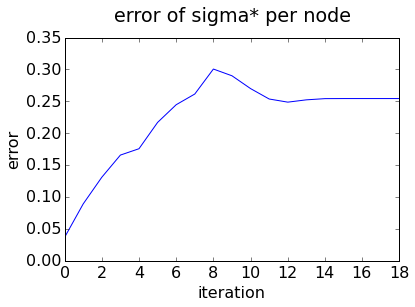

In [76]:
#plot the error of sigma* as the squared difference from s* per iteration
#how much uncertainty can we add before we lose module 34?
print errors
plt.plot([key for key in errors],[errors[key]/(runs*len(NK.nodes)) for key in errors])
plt.title("error of sigma* per node", y=1.05)
plt.xlabel("iteration")
plt.ylabel("error")

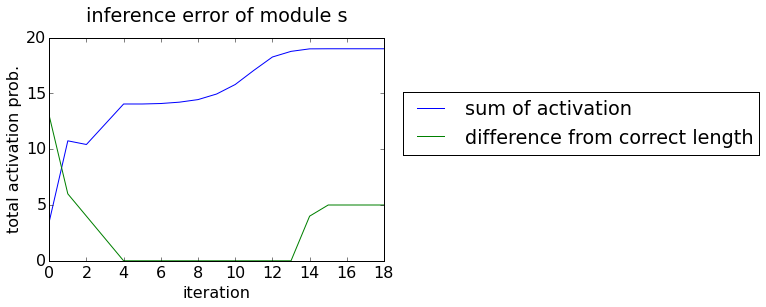

In [88]:
#plot error of s*, as iterations is increased, based on the length (active nodes) of the module
#note that the correct length is reached, and then the model tries to infer too much
#plot average value, 100 iterations of above graph, visualize iterations
lengths=[]
for i in act_prob_s:
    total=0 #active nodes
    for node in NK.nodes:
        if act_prob_s[i][node.name] > (1-tau): total+=1
    lengths.append(total)
    
yvalues=[sum([act_prob_s[i][n] for n in act_prob_s[i]]) for i in act_prob_s]
#print yvalues
#plt.plot([key for key in errors],lengths,label="length of active module")
plt.plot([key for key in errors],yvalues,label="sum of activation")
plt.plot([key for key in errors],[abs(l-14) for l in lengths],label="difference from correct length")
plt.legend(bbox_to_anchor=(2.15, 0.8))
plt.title("inference error of module s", y=1.05)
plt.xlabel("iteration")
plt.ylabel("total activation prob.")

In [ ]:
#TODO: entropy analysis for karate network
#for specific parameters i,tau, find all pathway modules per given seed size s
#figure out how to prune these to only include information modules (track module sets as s is increased)
#TODO: compare pulse modules; these probably will not be discoverable

#### Drosophila

In [81]:
#compare the mean-field approximation to pathway modules in drosophila
#prob p=0 means the node is OFF, p=1 means the node is ON, and p=.5 means the state is completely unknown
ND = DROSOPHILA()

In [57]:
#NOTE: unlike the LT model, the network converges towards certain probabilities that aren't 0 or 1
iterations=10 #0 is considered the starting state, then iterations 1,2,3...
act_prob = {i: {node.name: 0.5 for node in ND.nodes} for i in range(iterations+1)}
act_prob[0] = {'wg': 0.5, 'WG': 0.5, 'ci': 0.5, 'en': 0.5, 'nWG': 0.5, 'ptc': 0.5, 'SLP': 0.5, 
               'HH': 0.5, 'CI': 0.5, 'SMO': 0.5, 'CIR': 0.5, 'hh': 0.5, 'EN': 0.5, 'nhhnHH': 0.5, 
               'PH': 0.5, 'PTC': 0.5, 'CIA': 0.5}
total_act=0

In [58]:
dd={node.name: LUT_reduce(look_up_table(node)) for node in ND.nodes}
print len(dd),dd.keys()
#for node in ND.nodes:
#    print mf_approx(node,act_prob,1,reduced=True,ds=dd)
#    print mf_approx(node,act_prob,1,reduced=False,ds=None)

17 ['wg', 'WG', 'ci', 'en', 'nWG', 'ptc', 'SLP', 'HH', 'CI', 'SMO', 'CIR', 'hh', 'EN', 'nhhnHH', 'PH', 'PTC', 'CIA']


In [61]:
#NOTE: with pinning we can recreate pathway modules, albeit with some extra assumptions
#proper pathways can be recovered with the right tau value (i.e. more stringent precision)
act_prob[0]['en']=1.0
pinning=False
#iterations=10
for i in range(1,iterations+1):
    for node in ND.nodes:
        s,t=mf_approx(node,act_prob,i,reduced=True,ds=dd) #solve equation based on probabilities of inputs
        #allow pinning
        if pinning and act_prob[i-1][node.name]==0: act_prob[i][node.name]=0.0
        elif pinning and act_prob[i-1][node.name]==1: act_prob[i][node.name]=1.0
        else:
            act_prob[i][node.name]=s
        if i==iterations: 
            print node.name,act_prob[i][node.name],t,2**node.k,node.inputs
            total_act+=t #only need to count once

total_rows=0
length,module=0,[]
tau=0.001
for node in ND.nodes: 
    total_rows+=2**node.k
    if act_prob[i][node.name] < 0+tau:  
        length+=1 #assume these nodes are known
        module.append(node.name+'-0')
    if act_prob[i][node.name] > 1-tau:
        length+=1 #assume these nodes are known
        module.append(node.name+'-1')
#print act_prob, total_act/total_rows
print "Nodes known:",length,module

SLP 0.5 1 2 ['SLP']
wg 0.395024361936 4 16 ['SLP', 'wg', 'CIA', 'CIR']
WG 0.44119241804 1 2 ['wg']
en 0.25 1 4 ['SLP', 'nWG']
EN 0.25 1 2 ['en']
hh 0.199594146614 1 4 ['EN', 'CIR']
HH 0.204951080459 1 2 ['hh']
ptc 0.328358270391 1 8 ['EN', 'CIA', 'CIR']
PTC 0.55005749377 3 8 ['ptc', 'PTC', 'nhhnHH']
PH 0.307412053281 1 4 ['PTC', 'nhhnHH']
SMO 0.692587946719 1 4 ['PTC', 'nhhnHH']
ci 0.75 1 2 ['EN']
CI 0.75 1 2 ['ci']
CIA 0.51944096004 3 8 ['PTC', 'CI', 'nhhnHH']
CIR 0.23055903996 1 8 ['PTC', 'CI', 'nhhnHH']
nhhnHH 0.5 1 2 ['nhhnHH']
nWG 0.5 1 2 ['nWG']
Nodes known: 0 []


In [62]:
#define s-units and modules; map any node set to numbers starting with 0
sunits,sunit_map=set([]),{}
num=0
for node in ND.nodes:
    for state in ['0','1']:
        sunits.add(node.name+'-'+state)
        sunit_map[num]=node.name+'-'+state
        num+=1
        
#sunits={node.name+'-0' for node in ND.nodes}
#sunits=sunits.union({node.name+'-1' for node in ND.nodes})
modules,translator={},{}
print len(sunits),sunit_map

34 {0: 'SLP-0', 1: 'SLP-1', 2: 'wg-0', 3: 'wg-1', 4: 'WG-0', 5: 'WG-1', 6: 'en-0', 7: 'en-1', 8: 'EN-0', 9: 'EN-1', 10: 'hh-0', 11: 'hh-1', 12: 'HH-0', 13: 'HH-1', 14: 'ptc-0', 15: 'ptc-1', 16: 'PTC-0', 17: 'PTC-1', 18: 'PH-0', 19: 'PH-1', 20: 'SMO-0', 21: 'SMO-1', 22: 'ci-0', 23: 'ci-1', 24: 'CI-0', 25: 'CI-1', 26: 'CIA-0', 27: 'CIA-1', 28: 'CIR-0', 29: 'CIR-1', 30: 'nhhnHH-0', 31: 'nhhnHH-1', 32: 'nWG-0', 33: 'nWG-1'}


In [372]:
#find all pathway modules per given seed size s
#NOTE: this recreates all pinning information modules with s=1 with iterations=10, tau=0.0001; gets correct unfoldings with tau=0.00001
s=2
iterations=10 #0 is considered the starting state, then iterations 1,2,3...
pinning=True
tau=0.00001
t0=time.time()
timing={'t1':[],'t2':[],'t3':[]}
sunits={i for i in range(len(sunits))}
seeds=list(combinations(sunits,s)) #[['en-1']] or list(combinations(sunits,s)) for example
print len(seeds)
for seed in seeds:
    modules[str(seed)] = set([])
    translator[str(seed)] = seed #map between the string and the actual seed numbers

#iterate through given seeds
for seed in seeds:
    #set the starting seed
    t1 = time.time()
    act_units=to_list(seed,sunit_map) #list of activated s-unit names
    act_prob = {i: {node.name: 0.5 for node in ND.nodes} for i in range(iterations+1)}
    #print seed, act_units
    for sunit in act_units:
        if '-0' in sunit:
            act_prob[0][sunit[:-2]]=0.0
        elif '-1' in sunit:
            act_prob[0][sunit[:-2]]=1.0
    
    #iterate through the mean-field approximation
    t2 = time.time()
    for i in range(1,iterations+1):
        for node in ND.nodes:
            s,t=mf_approx(node,act_prob,i,reduced=True,ds=dd) #solve equation based on probabilities of inputs
            #allow pinning
            if pinning and act_prob[i-1][node.name]==0: act_prob[i][node.name]=0.0
            elif pinning and act_prob[i-1][node.name]==1: act_prob[i][node.name]=1.0
            else:
                act_prob[i][node.name]=s
            if i==iterations: 
                pass
                #print node.name,act_prob[i][node.name],t,2**node.k,node.inputs

    #extract the module set
    t3 = time.time()
    for node in ND.nodes: 
        if act_prob[i][node.name] < 0+tau:  
            length+=1 #assume these nodes are known
            modules[str(seed)].add(node.name+'-0')
        if act_prob[i][node.name] > 1-tau:
            length+=1 #assume these nodes are known
            modules[str(seed)].add(node.name+'-1')
            
    #compare timing
    t4=time.time()
    timing['t1'].append(t2-t1)
    timing['t2'].append(t3-t2)
    timing['t3'].append(t4-t3)
    
print("--- Initialization per seed: %s seconds ---" % (sum(timing['t1'])/len(seeds)))
print("--- Mf-approx per seed: %s seconds ---" % (sum(timing['t2'])/len(seeds)))
print("--- Module extraction per seed: %s seconds ---" % (sum(timing['t3'])/len(seeds)))
print("--- Total time: %s seconds ---" % (time.time()-t0))
#print act_prob[0]

561
--- Initialization per seed: 3.38681878891e-05 seconds ---
--- Mf-approx per seed: 0.0253351159699 seconds ---
--- Module extraction per seed: 2.49553279231e-05 seconds ---
--- Total time: 14.248000145 seconds ---


In [373]:
print len(modules)

331211


In [393]:
start_time = time.time()
print "All pathway modules:",len(modules)
tm = info_modules(modules,translator,s=5)
print "information modules:",len(tm)
for seed in sorted(tm,key=lambda x: len(tm[x]),reverse=True): #print out top modules
    print to_list(seed,sunit_map,translator),len(modules[seed]),modules[seed]
#print modules['(0, 15, 30)'] #we miss this information module: (SLP-0, ptc-1, nHH-0)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

All pathway modules: 331211
information modules: 0
--- Total time: 159.306999922 seconds ---


In [113]:
#recreate pipeline with drosophila and using reduced LUTs
ND = DROSOPHILA()
dd={node.name: LUT_reduce(look_up_table(node)) for node in ND.nodes}
dnodes=dd.keys()
print len(dd),dnodes
dmodules,dtranslator={},{}
dsunits,dsunit_map=get_sunits(ND)
print len(dsunits),dsunit_map

17 ['wg', 'WG', 'ci', 'en', 'nWG', 'ptc', 'SLP', 'HH', 'CI', 'SMO', 'CIR', 'hh', 'EN', 'nhhnHH', 'PH', 'PTC', 'CIA']
34 {0: 'SLP-0', 1: 'SLP-1', 2: 'wg-0', 3: 'wg-1', 4: 'WG-0', 5: 'WG-1', 6: 'en-0', 7: 'en-1', 8: 'EN-0', 9: 'EN-1', 10: 'hh-0', 11: 'hh-1', 12: 'HH-0', 13: 'HH-1', 14: 'ptc-0', 15: 'ptc-1', 16: 'PTC-0', 17: 'PTC-1', 18: 'PH-0', 19: 'PH-1', 20: 'SMO-0', 21: 'SMO-1', 22: 'ci-0', 23: 'ci-1', 24: 'CI-0', 25: 'CI-1', 26: 'CIA-0', 27: 'CIA-1', 28: 'CIR-0', 29: 'CIR-1', 30: 'nhhnHH-0', 31: 'nhhnHH-1', 32: 'nWG-0', 33: 'nWG-1'}


In [834]:
#find pathway modules for drosophila
start_time = time.time()
dmodules,dtranslator=find_modules(ND,1,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,
                pinning={},iterations=15,data=True,pin_start=True,update='synchronous',regenerate=False,models=1)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 34
--- Total time: 6.42300009727 seconds ---


In [835]:
#dmodules['(0, 31, 33)'][10]
dmodules['(7,)'][10]

{'CI': 0.0,
 'CIA': 0.0,
 'CIR': 0.0,
 'EN': 1.0,
 'HH': 1.0,
 'PH': 0.001556396484375,
 'PTC': 0.001556396484375,
 'SLP': 0.5,
 'SMO': 0.998443603515625,
 'WG': 0.009296063333749771,
 'ci': 0.0,
 'en': 1.0,
 'hh': 1.0,
 'nWG': 0.5,
 'nhhnHH': 0.5,
 'ptc': 0.0,
 'wg': 0.0046480316668748856}

In [531]:
#display (information) modules
print "All pathway modules:",len(dmodules)
dtm = info_modules(dmodules,dtranslator,s=2)
print "information modules:",len(dtm)
for seed in sorted(dtm,key=lambda x: len(dtm[x]),reverse=True): #print out top modules
    print to_list(seed,dsunit_map,dtranslator),len(dmodules[seed])#,dmodules[seed]

All pathway modules: 6579
information modules: 11
['SLP-1', 'nhhnHH-1'] 16
['SLP-1', 'PTC-0'] 15
['nhhnHH-1', 'nWG-0'] 14
['SLP-0', 'nWG-1'] 13
['PTC-0', 'nWG-0'] 13
['en-1', 'nhhnHH-1'] 13
['CIR-1', 'nhhnHH-1'] 10
['PTC-1', 'nhhnHH-0'] 8
['ptc-1', 'nhhnHH-0'] 8
['SLP-0', 'ptc-1'] 5
['SLP-0', 'nhhnHH-0'] 5


In [157]:
#add s=0 module (all nodes with p=0.5); assumes mf run and act_prob set accordingly
#dmodules['()']=act_prob
dtranslator['()']=()

In [45]:
#json dump and retrieve
#with open('dmodules-s3.json', 'w') as fp:
#    json.dump(dmodules, fp)

In [52]:
m2=json.load(open( "dmodules-s3.json" ))
print len(m2)
#for key in m2: pass
#print key,m2[key]
dmodules={} #create a clean dmodules that does not have any unicode keys (default)
for seed in m2:
    #dmodules[str(seed)]={int(i):m2[seed][i] for i in m2[seed]}
    dmodules[str(seed)]={int(i):{str(node):m2[seed][i][node] for node in m2[seed][i]} for i in m2[seed]}
#dmodules={str(module):{m2[module]:{int(i):m2[module][i] for i in m2[module]}} for module in m2}

6580


In [58]:
dtranslator=create_translator(ND,s=0,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator)
print len(dtranslator)
for seed in dmodules: pass
#print repr(seed),dmodules[seed]

6580


In [836]:
#NOTE: this is using an older version of cana for python 2 and requires an older networkx (e.g. 1.9.1)
DCM=ND.dynamics_canalization_map(output=None, )

In [86]:
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=3)
submodules={seed:dmodules[seed] for seed in seeds}
#submodules={seed:dmodules[seed] for seed in dmodules if len(to_list(seed,dsunit_map,dtranslator))==3}
#subsample=create_samples(submodules,1000,dsunit_map,dtranslator,s=5)
len(submodules)#,subsample.keys()

5440

In [87]:
seeds=submodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
iterations=15
dstats={}
length=3
start_time = time.time()
simulations=compare_simulations(ND,seeds,dsunit_map,dmodules,dtranslator,length=length,runs=100,tau=0.0,
                iterations=iterations,unknown_prob=0.5,stats=dstats,results=True,time_limit=iterations+2)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 5440
true positives: [1.0, 1.0, 0.99, 0.97, 0.96, 0.95, 0.94, 0.94, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93]
false negatives: [0.0, 0.0, 0.01, 0.03, 0.04, 0.05, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 1.0, 0.99, 0.98, 0.98, 0.97, 0.97, 0.97, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96]
recall: [1.0, 1.0, 0.99, 0.97, 0.96, 0.95, 0.94, 0.94, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 0.99, 0.97, 0.96, 0.95, 0.94, 0.94, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93, 0.93]
errors: [0.011, 0.009, 0.011, 0.017, 0.02, 0.023, 0.025, 0.026, 0.026, 0.027, 0.028, 0.028, 0.028, 0.027, 0.027, 0.027]
--- Total time: 1893.29699993 

In [727]:
#compare synchronous vs asynchronous updates
seeds=['()'] #['(7,)','(28,)','(29,)']
iterations=15
dstats={}
#simulations=compare_simulations(ND,seeds,dsunit_map,dmodules,dtranslator,length=0,runs=100,tau=0.0,
#               iterations=iterations,unknown_prob=0.5,stats=dstats,results=True) #time_limit=iterations+2
d,s=compare_simulations_asynchronous(ND,seeds,dsunit_map,length=0,runs=100,tau=0.0,iterations=iterations,unknown_prob=0.5,reduced=True,ds=dd,
    stats=dstats,results=False,deterministic=False,replacement=True,models=100)

total seeds: 1
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
errors: [0.002, 0.014, 0.014, 0.013, 0.013, 0.014, 0.014, 0.015, 0.016, 0.016, 0.017, 0.017, 0.017, 0.018, 0.018, 0.018]


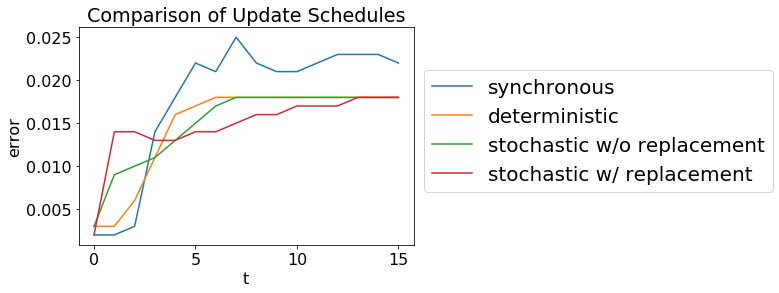

In [728]:
#graph different update schedules
#errors=[0.012, 0.012, 0.012, 0.021, 0.027, 0.029, 0.028, 0.033, 0.032, 0.032, 0.032, 0.034, 0.034, 0.034, 0.034, 0.034]
#errors1=[0.012, 0.012, 0.019, 0.025, 0.03, 0.032, 0.032, 0.032, 0.033, 0.033, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032]
#errors2=[0.012, 0.021, 0.023, 0.026, 0.027, 0.03, 0.031, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032, 0.032]
#errors3=[0.012, 0.028, 0.027, 0.026, 0.028, 0.028, 0.028, 0.029, 0.029, 0.03, 0.03, 0.031, 0.031, 0.031, 0.032, 0.032]
errors=[0.002, 0.002, 0.003, 0.014, 0.018, 0.022, 0.021, 0.025, 0.022, 0.021, 0.021, 0.022, 0.023, 0.023, 0.023, 0.022]
errors1=[0.003, 0.003, 0.006, 0.011, 0.016, 0.017, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018]
errors2=[0.003, 0.009, 0.01, 0.011, 0.013, 0.015, 0.017, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018, 0.018]
errors3=[0.002, 0.014, 0.014, 0.013, 0.013, 0.014, 0.014, 0.015, 0.016, 0.016, 0.017, 0.017, 0.017, 0.018, 0.018, 0.018]
xvalues=range(iterations+1)

plt.title("Comparison of Update Schedules")
plt.xlabel("t")
plt.ylabel("error")
plt.plot(xvalues,errors,label='synchronous')
plt.plot(xvalues,errors1,label='deterministic')
plt.plot(xvalues,errors2,label='stochastic w/o replacement')
plt.plot(xvalues,errors3,label='stochastic w/ replacement')
plt.legend(bbox_to_anchor=(1.0, 0.85), fontsize=20)

In [424]:
#for seed in simulations:
#    for alt in simulations[seed]: 
#        print to_list(seed,dsunit_map,dtranslator),alt
#        for i in simulations[seed][alt]: print simulations[seed][alt][i]
simulations.keys()

['(28,)', '(7,)', '(29,)']

In [88]:
#dact_prob_sim={}
for seed in simulations: dact_prob_sim[seed]={}
for seed in simulations:
    aggregate_simulation(seed,simulations,dact_prob_sim)

len(dact_prob_sim)

6019

In [280]:
#create simulations for aysnchronous update (using ONE model)
#dact_prob_sim={}
length=1
simulations,dact_prob_sim=create_simulations(ND,seeds,dsunit_map,dtranslator,length=length,runs=100,iterations=15,
                  unknown_prob=0.5,time_limit=12,act_prob_sim=dact_prob_sim,update='asynchronous',order=None,regenerate=False)

In [89]:
#json dump and retrieve
#with open('dact_prob_sim-s3_T15.json', 'w') as fp:
#    json.dump(dmodules, fp)
#dact_prob_sim=json.load(open( "dact_prob_sim-s3.json" ))
#len(dact_prob_sim)

In [440]:
#graph errors and statistics based on tau
exec('errors'+str(length)+"=dstats['errors']")
exec('sim'+str(length)+"=dstats['avg_sim']")
exec('accuracy'+str(length)+"=dstats['accuracy']")
exec('precision'+str(length)+"=dstats['precision']")
exec('recall'+str(length)+"=dstats['recall']")

#tau variables
if tau==0:
    atau0=accuracy
    ptau0=precision
elif tau==0.0001:
    atau0001=accuracy
    ptau0001=precision
elif tau==0.001:
    atau001=accuracy
    ptau001=precision
elif tau==0.01:
    atau01=accuracy
    ptau01=precision
elif tau==0.1:
    atau1=accuracy
    ptau1=precision
elif tau==0.2:
    atau2=accuracy
    ptau2=precision
elif tau==0.3:
    atau3=accuracy
    ptau3=precision

In [222]:
#seeds=dmodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
dbstats={}
compare_baseline(ND,seeds,dsunit_map,dtranslator,simulations,length=length,tau=0.0,iterations=15,stats=dbstats,results=True)

99 total runs, 1.0 seeds
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average similarity: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errors: [0.122, 0.112, 0.112, 0.108, 0.103, 0.106, 0.108, 0.106, 0.107, 0.107, 0.107, 0.107, 0.107, 0.107, 0.107, 0.107]


In [442]:
#graph baseline
exec('berrors'+str(length)+"=dbstats['errors']")
exec('bsim'+str(length)+"=dbstats['avg_sim']")
exec('baccuracy'+str(length)+"=dbstats['accuracy']")
exec('bprecision'+str(length)+"=dbstats['precision']")
exec('brecall'+str(length)+"=dbstats['recall']")

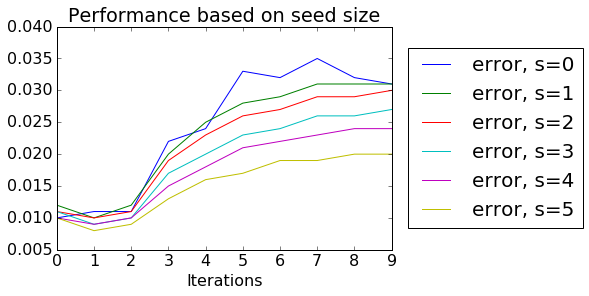

In [448]:
#graph comparison between s=1 and s=2
xvalues=[i for i in range(iterations)]
var1=str(length) #what to graph
#accuracy
#plt.plot(xvalues,eval('accuracy'+var1),label='accuracy, s='+var1)
#plt.plot(xvalues,accuracy2,label='accuracy, s=2')
#precision
#plt.plot(xvalues,eval('precision'+var1),label='precision, s='+var1)
#plt.plot(xvalues,precision2,label='precision, s=2')
#errors
plt.plot(xvalues,errors0,label='error, s=0')
plt.plot(xvalues,errors1,label='error, s=1')
plt.plot(xvalues,errors2,label='error, s=2')
plt.plot(xvalues,errors3,label='error, s=3')
plt.plot(xvalues,errors4,label='error, s=4')
plt.plot(xvalues,errors5,label='error, s=5')
#average similarity of constants
#plt.plot(xvalues,eval('sim'+var1),label='constant similarity, s='+var1)
#plt.plot(xvalues,sim2,label='constant similarity, s=2')
#baselines
#plt.plot(xvalues,eval('baccuracy'+var1),label='base accuracy, s='+var1)
#plt.plot(xvalues,baccuracy2,label='base accuracy, s=2')
#plt.plot(xvalues,eval('bprecision'+var1),label='base precision, s='+var1)
#plt.plot(xvalues,bprecision2,label='base precision, s=2')
#plt.plot(xvalues,eval('bsim'+var1),label='base similarity, s='+var1)
#plt.plot(xvalues,bsim2,label='base similarity, s=2')
#plt.plot(xvalues,berrors1,label='base error, s=1')
#plt.plot(xvalues,berrors2,label='base error, s=2')

plt.title('Performance based on seed size')
plt.xlabel('Iterations')
#plt.ylabel('')
#plt.ylim([-0.01,1.05])
plt.legend(bbox_to_anchor=(2.0, 0.8), fontsize=20)
plt.legend(bbox_to_anchor=(1.6, 0.95), fontsize=20) #errors
#plt.legend(bbox_to_anchor=(2.0, 0.95), fontsize=20) #with baselines

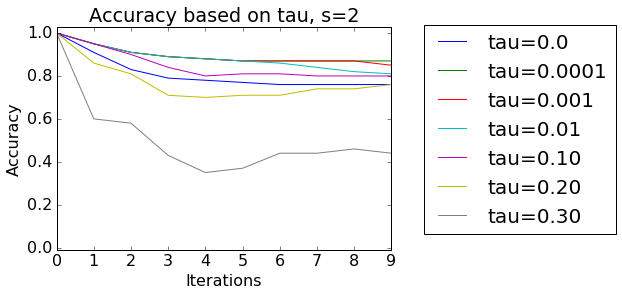

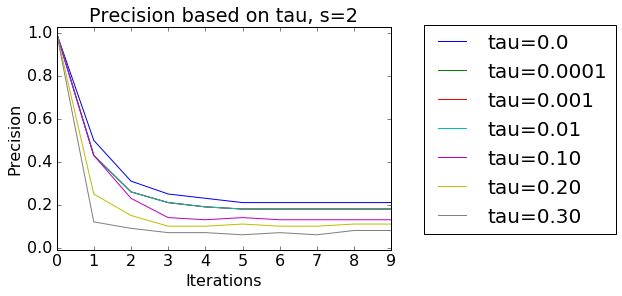

In [377]:
#graph comparison over different tau values
xvalues=[i for i in range(iterations)]
#accuracy
plt.plot(xvalues,atau0,label='tau=0.0')
plt.plot(xvalues,atau0001,label='tau=0.0001')
plt.plot(xvalues,atau001,label='tau=0.001')
plt.plot(xvalues,atau01,label='tau=0.01')
plt.plot(xvalues,atau1,label='tau=0.10')
plt.plot(xvalues,atau2,label='tau=0.20')
plt.plot(xvalues,atau3,label='tau=0.30',color='grey')
plt.title('Accuracy based on tau, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(1.7, 1.05), fontsize=20)
plt.show()
#precision
#plt.plot(xvalues,pvalues,label='precision',color='black',linewidth=2) #s=1
plt.plot(xvalues,ptau0,label='tau=0.0')
plt.plot(xvalues,ptau0001,label='tau=0.0001')
plt.plot(xvalues,ptau001,label='tau=0.001')
plt.plot(xvalues,ptau01,label='tau=0.01')
plt.plot(xvalues,ptau1,label='tau=0.10')
plt.plot(xvalues,ptau2,label='tau=0.20')
plt.plot(xvalues,ptau3,label='tau=0.30',color='grey')
plt.title('Precision based on tau, s='+str(length))
plt.xlabel('Iterations')
plt.ylabel('Precision')
plt.ylim([-0.01,1.03])
plt.legend(bbox_to_anchor=(1.7, 1.05), fontsize=20)
plt.show()

In [388]:
#compare entropies over different update schedules for different seeds
#dact_prob_sim={}
keys=['synchronous','deterministic asynchronous','stochastic without replacement','stochastic with replacement']
#avg_entropy_modules,avg_entropy_sim={key:{} for key in keys},{key:{} for key in keys}

In [397]:
#aggregate synchronous simulations
key='synchronous'
seed='(29,)' #SPECIFY SEED, '()', '(7,)', '(28,)', '(29)'
dact_prob_sim[seed]={}
aggregate_simulation(seed,simulations,dact_prob_sim)
#calculate entropy for dmodules
diffusion=dmodules[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
yvalues=[seed_entropy[x] for x in seed_entropy]
avg_entropy_modules[key][seed]=yvalues
#calculate entropy for simulations
diffusion=dact_prob_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
yvalues=[seed_entropy[x] for x in seed_entropy] 
avg_entropy_sim[key][seed]=yvalues
avg_entropy_modules[key][seed]

[0.9411764705882353,
 0.7260413164251368,
 0.6022960599362828,
 0.5465845998275423,
 0.49572462774463283,
 0.45961970208211717,
 0.44089377747109254,
 0.4297353068260535,
 0.42327628268503953,
 0.4196113940788005,
 0.4175623950382562,
 0.416429902088742,
 0.4158097299569939,
 0.41547269883632715,
 0.4152907151931977,
 0.4151929904415325]

In [431]:
#avg_entropy_modules['stochastic with replacement']

In [428]:
#run entropy comparisons based on various models, then average
key='stochastic with replacement'
seed='(29,)' #SPECIFY SEED, '()', '(7,)', '(28,)', '(29)'

avg_entropy_modules[key][seed]=[0.0 for i in range(iterations+1)]
avg_entropy_sim[key][seed]=[0.0 for i in range(iterations+1)]
for m in range(len(d)):
    dmodules[seed]=d[m][seed]
    dact_prob_sim[seed]={}
    aggregate_simulation(seed,s[m],dact_prob_sim)
    #print 'Model:',m,len(dmodules[seed]),len(dact_prob_sim[seed]),len(avg_entropy_modules[seed])
    #calculate entropy for dmodules
    diffusion=dmodules[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    yvalues=[seed_entropy[x] for x in seed_entropy]
    avg_entropy_modules[key][seed]=[avg_entropy_modules[key][seed][i]+yvalues[i] for i in range(iterations+1)]
    #calculate entropy for simulations
    diffusion=dact_prob_sim[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    yvalues=[seed_entropy[x] for x in seed_entropy] 
    avg_entropy_sim[key][seed]=[avg_entropy_sim[key][seed][i]+yvalues[i] for i in range(iterations+1)]
    #print 'Entropy:',yvalues
avg_entropy_modules[key][seed]=[avg_entropy_modules[key][seed][i]/len(d) for i in range(iterations+1)]
avg_entropy_sim[key][seed]=[avg_entropy_sim[key][seed][i]/len(d) for i in range(iterations+1)]
print avg_entropy_modules[key][seed]
print avg_entropy_sim[key][seed]

[0.9411764705882331, 0.757016694324074, 0.645928113626151, 0.5771902381966847, 0.5285195629905989, 0.4966406901571343, 0.4678405743965451, 0.44976548320959275, 0.43788066705419054, 0.4281170889639355, 0.42233807351613384, 0.4198672350901505, 0.4184397142301337, 0.417071111040604, 0.4164202338770593, 0.4160538109018556]
[0.9341748387108314, 0.8550658441490873, 0.7464725294202461, 0.6597755177986485, 0.6002989582561467, 0.565039902903665, 0.5463878379458953, 0.5355657757743458, 0.5304763633470384, 0.5282322142689087, 0.5272534896985137, 0.5268783274110374, 0.5267021222420035, 0.5265892456037347, 0.5265571985934102, 0.5265179783662162]


In [446]:
seed='(29,)'
#for key in keys: print key+':','\n',[round(avg_entropy_modules[key][seed][i],3) for i in range(iterations+1)]
for key in keys: print key+':','\n',[round(avg_entropy_sim[key][seed][i],3) for i in range(iterations+1)]

synchronous: 
[0.937, 0.727, 0.604, 0.542, 0.536, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537, 0.537]
deterministic asynchronous: 
[0.934, 0.643, 0.536, 0.526, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527]
stochastic without replacement: 
[0.934, 0.696, 0.558, 0.528, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526, 0.526]
stochastic with replacement: 
[0.934, 0.855, 0.746, 0.66, 0.6, 0.565, 0.546, 0.536, 0.53, 0.528, 0.527, 0.527, 0.527, 0.527, 0.527, 0.527]


(1, 32, 30, 17)


Text(0.5,0,'t')

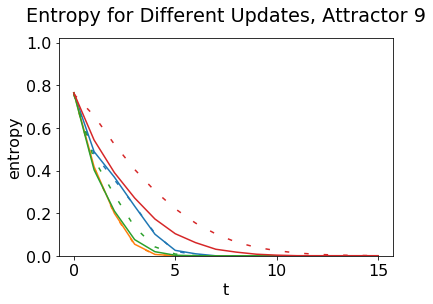

In [473]:
#graph average entropy
k=9
seed=seeds[k]
key='synchronous'
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
xvalues=[i for i in range(iterations+1)]
print seed
for i,key in enumerate(keys[:-1]): #leave out block update
    yvalues=ddriver_entropy_modules[key][seed]
    yvalues_sim=ddriver_entropy_sim[key][seed]
    plt.plot(xvalues,yvalues,label=key)
    plt.plot(xvalues,yvalues_sim,'--',dashes=(3, 10),color=colors[i],markersize=10)

plt.title("Entropy for Different Updates, Attractor "+str(k),y=1.05) #seed={CIR-1}, "Attractor "+str(k)
plt.ylim([0.0,1.02])
#plt.xticks([1,3,5,7,9,11,13,15])
plt.ylabel("entropy")
plt.xlabel("t")
#plt.legend(bbox_to_anchor=(1,0.85), fontsize=20)

In [447]:
#find entropy for driver sets
#ddriver_entropy_modules,ddriver_entropy_sim={key:{} for key in keys},{key:{} for key in keys}
key='synchronous' #deterministic asynchronous
seeds=['(7,)'] #dmodules.keys(), ['()','(1,)']
seeds=['(1, 32, 31)','(0, 32, 31, 3)','(1, 33, 31)','(0, 33, 31)','(1, 33, 30, 17)','(0, 33, 30, 16)','(0, 32, 31, 2)','(0, 33, 30, 17)','(0, 32, 30, 17)','(1, 32, 30, 17)']
avm,avs=compare_entropies_asynchronous(ND,seeds,dsunits,dsunit_map,schedule=key,iterations=15,order=None,runs=100,models=100,verbose=True)
ddriver_entropy_modules[key]=avm
ddriver_entropy_sim[key]=avs
len(avm),len(avs)

(1, 32, 31)
(0, 32, 31, 3)
(1, 33, 31)
(0, 33, 31)
(1, 33, 30, 17)
(0, 33, 30, 16)
(0, 32, 31, 2)
(0, 33, 30, 17)
(0, 32, 30, 17)
(1, 32, 30, 17)


(10, 10)

In [476]:
#ddriver_entropy_sim

Normalized entropy: [1.0, 0.89, 0.88, 0.85, 0.82, 0.84, 0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.88] [1.0, 0.89, 0.88, 0.85, 0.82, 0.84, 0.86, 0.87, 0.88, 0.88, 0.88, 0.87, 0.87, 0.87, 0.87, 0.88]
Probable configurations: ['1.31e+05', '3.40e+04', '3.37e+04', '2.15e+04', '1.55e+04', '1.97e+04', '2.56e+04', '2.82e+04', '3.36e+04', '3.25e+04', '3.11e+04', '2.92e+04', '2.88e+04', '2.92e+04', '2.98e+04', '3.01e+04']


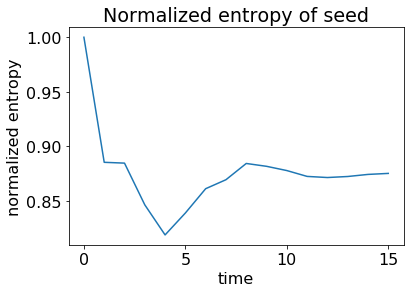

Total possible configurations: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


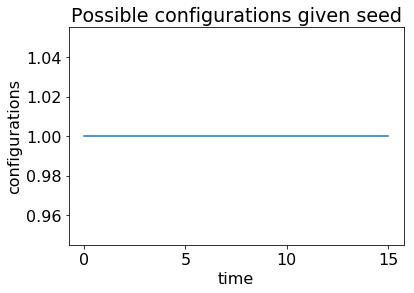

In [329]:
#single seed entropy
seed='()' #'(7,)'
diffusion=dmodules[seed] #dmodules[seed], dact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
xvalues=seed_entropy.keys()
yvalues=[seed_entropy[key] for key in seed_entropy]
#print [round(y*17,2) for y in yvalues]
plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues]) #normalize everything compared to the starting value
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 17) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
#plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True,strict=True)
xvalues=seed_configs.keys()
y1values=[seed_configs[key] for key in seed_configs]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [302]:
avg_entropy_modules[seed]=[avg_entropy_modules[seed][i]+yvalues[i] for i in range(len(avg_entropy_modules[seed]))]
#avg_entropy_sim[seed]=[avg_entropy_sim[seed][i]+yvalues[i] for i in range(len(avg_entropy_sim[seed]))]
avg_entropy_modules[seed]

[2.0,
 1.6864703975811235,
 1.6727300909331242,
 1.7398342880030473,
 1.7610298688208479,
 1.7518262374432443,
 1.7481620364054675,
 1.7485834038092953,
 1.7490396975605278,
 1.7490443416185324,
 1.7489834928599706,
 1.7489699876646454,
 1.7489736654743953,
 1.7489753105533608,
 1.7489749269769845,
 1.748974585325837]

seeds: 34
Average entropy: [15.87, 13.65, 12.7, 12.38, 12.26, 12.18, 12.16, 12.16, 12.16, 12.16, 12.16]
Normalized entropy: [0.93, 0.8, 0.75, 0.73, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72] [1.0, 0.86, 0.8, 0.78, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77, 0.77]
Possible configurations: ['5.99e+04', '1.28e+04', '6.65e+03', '5.32e+03', '4.89e+03', '4.65e+03', '4.59e+03', '4.59e+03', '4.59e+03', '4.59e+03', '4.59e+03']


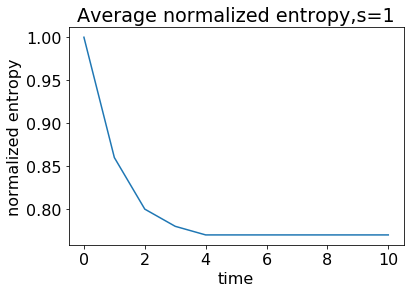

Total possible configurations: [0.5, 0.33, 0.3, 0.28, 0.28, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27] [1.0, 0.67, 0.59, 0.56, 0.55, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54]


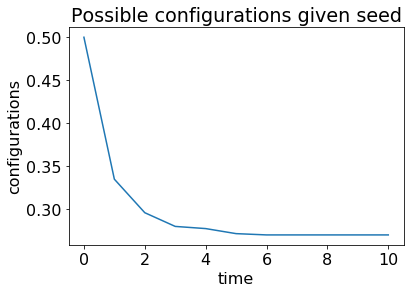

In [264]:
#multiple seed entropies
length,iterations=1,10
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length) #['()','(3,)']
#seeds=simulations.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(dact_prob_sim,seeds,normalized=True,data=False) #dmodules, submodules, dact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * 17,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 17) for y in yvalues]
print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(dact_prob_sim,seeds,normalized=True,data=False,strict=True) #submodules,dact_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [73]:
#yvalues0=[yvalue/yvalues[0] for yvalue in yvalues]
#yvalues1=[yvalue/yvalues[0] for yvalue in yvalues]
#yvalues2=[yvalue/yvalues[0] for yvalue in yvalues]
#yvalues3=[yvalue/yvalues[0] for yvalue in yvalues]
#ysvalues0=[yvalue for yvalue in yvalues]
#ysvalues1=[yvalue*17/16 for yvalue in yvalues]
#ysvalues2=[yvalue*17/15 for yvalue in yvalues]
#ysvalues3=[yvalue*17/14 for yvalue in yvalues]
print [round(yvalue,2) for yvalue in ysvalues0],[round(yvalue*2**17/2**17,2) for yvalue in y1values]
print yvalues0#,yvalues1,yvalues2,yvalues3

[1.0, 0.89, 0.89, 0.87, 0.84, 0.85, 0.89, 0.86, 0.88, 0.87, 0.87] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 0.88543455967910489, 0.88469626843958671, 0.84648810942761887, 0.81893026865374974, 0.83900749926101259, 0.86126834180985168, 0.86948989441116642, 0.88437384814024445, 0.88177208668165763, 0.87788204131166381]


In [297]:
#is there a discrepancy between the mean-field and the simulations?
seeds,t,nodes=submodules.keys(),10,[node.name for node in ND.nodes] #seeds=['(7,)'], simulations or submodules
print len(seeds)
diff={node:0.0 for node in nodes}
for seed in seeds:
    for node in nodes:
        diff[node]+=abs(dmodules[seed][t][node]-dact_prob_sim[seed][t][node])
diff={node:diff[node]/len(seeds) for node in diff}
print 'node','mf','sim','diff'
for node in sorted(diff,key=lambda x: diff[x],reverse=True):
    avg1,avg2=np.mean([dmodules[seed][t][node] for seed in seeds]),np.mean([dact_prob_sim[seed][t][node] for seed in seeds])
    print node,round(avg1,2),round(avg2,2),round(diff[node],2)

5440
node mf sim diff
PTC 0.41 0.62 0.22
SMO 0.73 0.59 0.15
wg 0.33 0.31 0.14
WG 0.36 0.35 0.11
CIA 0.45 0.38 0.08
CIR 0.22 0.29 0.07
ptc 0.28 0.3 0.04
SLP 0.5 0.5 0.03
nhhnHH 0.5 0.5 0.03
PH 0.25 0.27 0.03
nWG 0.5 0.5 0.03
hh 0.32 0.33 0.03
en 0.29 0.29 0.02
HH 0.36 0.36 0.02
EN 0.33 0.33 0.02
ci 0.63 0.63 0.02
CI 0.61 0.6 0.01


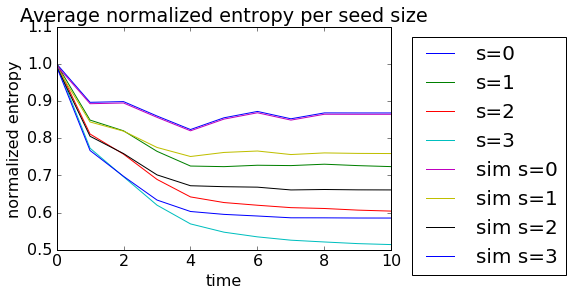

'\n#plot configurations\n#print yvalues3,[2**(y * 14) for y in yvalues3]\nplt.plot(xvalues,[2**(y * 17) for y in yvalues0],label=\'s=0\')\nplt.plot(xvalues,[2**(y * 16) for y in yvalues1],label=\'s=1\')\nplt.plot(xvalues,[2**(y * 15) for y in yvalues2],label=\'s=2\')\nplt.plot(xvalues,[2**(y * 14) for y in yvalues3],label=\'s=3\')\n#plt.plot(xvalues[:-1],ysvalues,label=\'sim s=3\')\nplt.yscale(\'log\')\n#plt.ylim([0,1e8])\nplt.title("Possible configurations given seed")\nplt.ylabel("configurations")\nplt.xlabel("time")\nplt.legend(bbox_to_anchor=(1.4, 0.8), fontsize=20) '

In [300]:
#plot entropy per seed size
iterations=10
xvalues=[t for t in range(iterations+1)]
plt.plot(xvalues,yvalues0,label='s=0')
plt.plot(xvalues,yvalues1,label='s=1')
plt.plot(xvalues,yvalues2,label='s=2')
plt.plot(xvalues,yvalues3,label='s=3')
plt.plot(xvalues,ysvalues0,label='sim s=0')
plt.plot(xvalues,ysvalues1,label='sim s=1')
plt.plot(xvalues,ysvalues2,label='sim s=2')
plt.plot(xvalues,ysvalues3,label='sim s=3')
#plt.ylim([.5,1.03])
plt.title("Average normalized entropy per seed size")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.legend(bbox_to_anchor=(1.55, 1.0), fontsize=20)
plt.show() 
'''
#plot configurations
#print yvalues3,[2**(y * 14) for y in yvalues3]
plt.plot(xvalues,[2**(y * 17) for y in yvalues0],label='s=0')
plt.plot(xvalues,[2**(y * 16) for y in yvalues1],label='s=1')
plt.plot(xvalues,[2**(y * 15) for y in yvalues2],label='s=2')
plt.plot(xvalues,[2**(y * 14) for y in yvalues3],label='s=3')
#plt.plot(xvalues[:-1],ysvalues,label='sim s=3')
plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.legend(bbox_to_anchor=(1.4, 0.8), fontsize=20) '''

In [1266]:
#check against length of constants
hdmodules,hdtranslator=find_modules(ND,1,dsunits,dsunit_map,{},dtranslator,reduced=True,ds=dd,pinning={},seeds=None,
                                   iterations=10,data=False)

seeds: 561


In [1289]:
seed_entropy,seed_configs=seed_entropies(dmodules,seeds,normalized=False,data=False)
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][10]) #sort by final entropy, lowest entropy first
len(sorted_entropies)#,seed_entropy[sorted_entropies[0]]
for seed in sorted_entropies[:10]: 
    print round(seed_entropy[seed][10],2),'bits',to_list(seed,dsunit_map,dtranslator)#,'length:',len(hdmodules[seed])

0.0 bits ['SLP-1', 'nhhnHH-1', 'nWG-0']
0.0 bits ['SLP-1', 'nhhnHH-1', 'nWG-1']
0.0 bits ['SLP-0', 'nhhnHH-1', 'nWG-1']
0.13 bits ['SLP-0', 'nhhnHH-1', 'nWG-0']
1.0 bits ['SLP-1', 'PH-1', 'nhhnHH-1']
1.0 bits ['SLP-1', 'en-0', 'nhhnHH-1']
1.0 bits ['SLP-1', 'hh-1', 'nhhnHH-1']
1.0 bits ['wg-0', 'nhhnHH-1', 'nWG-0']
1.0 bits ['SLP-1', 'PTC-0', 'nhhnHH-1']
1.0 bits ['SLP-1', 'CIR-1', 'nhhnHH-1']


In [1269]:
from scipy.stats import pearsonr
x=[seed_entropy[seed][10] for seed in sorted_entropies] #entropy after 10 iterations
y=[len(hdmodules[seed]) for seed in sorted_entropies] #number of constants resolved from seed
print len(x),len(y),pearsonr(x,y)

544 544 (-0.84790465381764601, 1.6969066446739744e-151)


In [108]:
#graph entropy over time to compare configuration vs perturbation influence
seed='()' #'(7,)'
#diffusion=dmodules[seed] #dmodules[seed], dact_prob_sim[seed], low_sim[seed]
diffusion=dact_prob_sim[seed]
null_entropy,null_configs=config_entropy(diffusion,base=2,normalized=True)
#multiple seeds
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=3)
#submodules={seed:dmodules[seed] for seed in seeds}
submodules={seed:dact_prob_sim[seed] for seed in seeds}
seed_entropy,seed_configs=seed_entropies(submodules,submodules.keys(),normalized=True,data=True)
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][15])
len(sorted_entropies)

average entropy: [0.8175401612629424, 0.6315187973130809, 0.5744828992313133, 0.5219977590479371, 0.4967725847220309, 0.4904296524301921, 0.486935376927953, 0.48299988060689214, 0.4829238616978671, 0.4825216985833308, 0.4824543977356026, 0.4824543977356026, 0.4824543977356026, 0.4824543977356026, 0.4824543977356026, 0.4824543977356026]
average configurations: [0.04453784523481786, 0.0028608423324052966, 0.0019316881967209412, 0.00132732396582516, 0.0011027559343212384, 0.0011706592387103261, 0.0012502264280453087, 0.0012162755800868012, 0.0012546441200538402, 0.0012501518553139023, 0.0012497682216857167, 0.0012497682216857167, 0.0012497682216857167, 0.0012497682216857167, 0.0012497682216857167, 0.0012497682216857167]


5440

In [93]:
#define variables for comparisons over seed sizes
#influences={1:[],2:[],3:[]}
#correlations={1:[],2:[],3:[]}
#influences_sim={1:[],2:[],3:[]}
#correlations_sim={1:[],2:[],3:[]}

[0.04826516382011735, 0.07392514490515686, 0.0910367886055354, 0.10092065422165344, 0.10856512268133157, 0.11266358724801531, 0.11381269422607047, 0.11567660328293808, 0.11627931356608402, 0.11624087087507015, 0.11624017984942284, 0.11624017984942284, 0.11624017984942284, 0.11624017984942284, 0.11624017984942284, 0.11624017984942284]


Text(0.5,1,'Average Influence over time,s=3')

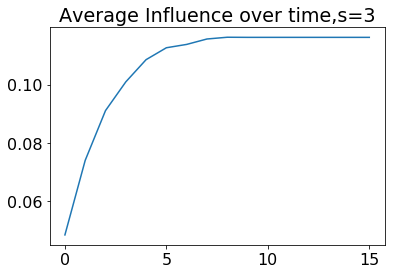

In [109]:
#plot average influence
s=3    #SEED SIZE
baseline=diffusion
seed_influences={t:0.0 for t in range(max(baseline)+1)}
for seed in sorted_entropies:
    #dmodule=dmodules[seed]
    dmodule=dact_prob_sim[seed]
    diff=influence(dmodule,baseline,nodes=None,normalized=True,strict=False)
    for t in range(max(baseline)+1):
        seed_influences[t]+=diff[t]
seed_influences={t:seed_influences[t]/len(sorted_entropies) for t in seed_influences}
#sorted_entropies,seed_influences
#influences[s]=[seed_influences[t] for t in range(max(baseline)+1)]
influences_sim[s]=[seed_influences[t] for t in range(max(baseline)+1)]
print influences_sim[s]
plt.plot([t for t in range(max(baseline)+1)],[seed_influences[t] for t in range(max(baseline)+1)])
plt.title("Average Influence over time,s="+str(s))

In [110]:
#top influencers, define seed_influences by seed
from scipy.stats import spearmanr
yvalues=[]
seed_influences={seed:{t:0.0 for t in range(max(baseline)+1)} for seed in seed_entropy}
for seed in seed_entropy:
    #dmodule=dmodules[seed]
    dmodule=dact_prob_sim[seed]
    diff=influence(dmodule,baseline,nodes=None,normalized=True,strict=False)
    for t in range(max(baseline)+1):
        seed_influences[seed][t]=diff[t]
#print seed_influences['(7,)'].keys()
for t in range(max(baseline)+1):
    sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][t])
    sorted_influences=sorted(seed_influences,key=lambda x: seed_influences[x][t],reverse=True)
    #print sorted_entropies[:5],sorted_influences[:5],spearmanr(sorted_entropies,sorted_influences)[0]
    print [to_list(sorted_entropies[x],dsunit_map,dtranslator) for x in range(2)],
    print [to_list(sorted_influences[x],dsunit_map,dtranslator) for x in range(2)]
    yvalues.append(spearmanr(sorted_entropies,sorted_influences)[0])
#print yvalues
#plt.plot([t for t in range(max(baseline)+1)],yvalues)
#plt.title("Correlation between Configuration Entropy and Influence measures")

[['en-1', 'CI-0', 'nhhnHH-0'], ['PH-1', 'CI-1', 'nWG-1']] [['wg-1', 'WG-0', 'CIR-1'], ['WG-0', 'PH-0', 'CIR-1']]
[['EN-0', 'PTC-0', 'CI-0'], ['EN-0', 'PTC-0', 'CI-1']] [['hh-1', 'ptc-1', 'CIR-1'], ['en-1', 'hh-1', 'CIR-1']]
[['PTC-0', 'ci-0', 'CIR-1'], ['PTC-0', 'ci-1', 'CIR-1']] [['en-1', 'ptc-1', 'nhhnHH-1'], ['wg-1', 'en-1', 'ptc-1']]
[['wg-0', 'EN-1', 'nhhnHH-1'], ['SLP-1', 'EN-1', 'nhhnHH-1']] [['en-1', 'ptc-1', 'nhhnHH-1'], ['wg-1', 'en-1', 'nhhnHH-1']]
[['SLP-0', 'en-1', 'nhhnHH-1'], ['SLP-1', 'ci-1', 'nhhnHH-1']] [['wg-1', 'en-1', 'nhhnHH-1'], ['en-1', 'ptc-1', 'nhhnHH-1']]
[['SLP-0', 'nhhnHH-1', 'nWG-1'], ['SLP-1', 'ci-1', 'nhhnHH-1']] [['SLP-1', 'en-1', 'nhhnHH-1'], ['wg-1', 'en-1', 'nhhnHH-1']]
[['SLP-0', 'nhhnHH-1', 'nWG-1'], ['SLP-1', 'ci-1', 'nhhnHH-1']] [['SLP-1', 'en-1', 'nhhnHH-1'], ['wg-1', 'en-1', 'nhhnHH-1']]
[['SLP-0', 'nhhnHH-1', 'nWG-1'], ['SLP-1', 'nhhnHH-0', 'nWG-0']] [['SLP-1', 'en-1', 'nhhnHH-1'], ['wg-1', 'en-1', 'nhhnHH-1']]
[['SLP-1', 'nhhnHH-1', 'nWG-0'],

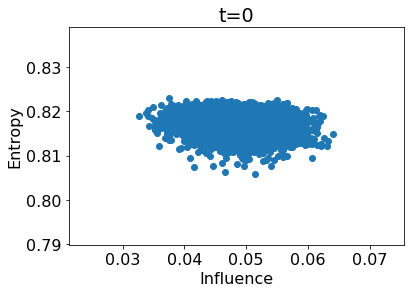

SpearmanrResult(correlation=-0.13864894187376375, pvalue=9.273352199357723e-25)


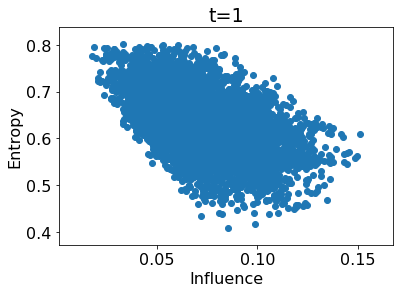

SpearmanrResult(correlation=-0.5047192266134656, pvalue=0.0)


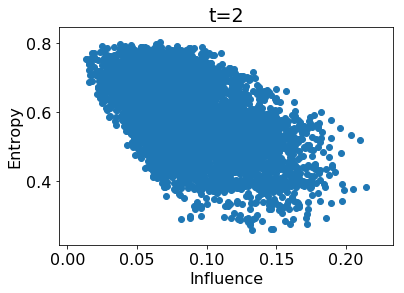

SpearmanrResult(correlation=-0.5092611823334836, pvalue=0.0)


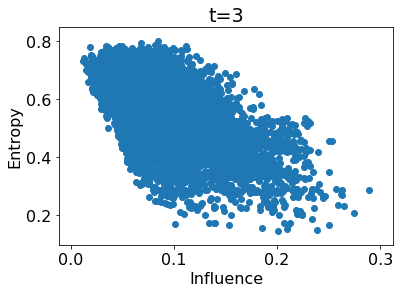

SpearmanrResult(correlation=-0.539266079569348, pvalue=0.0)


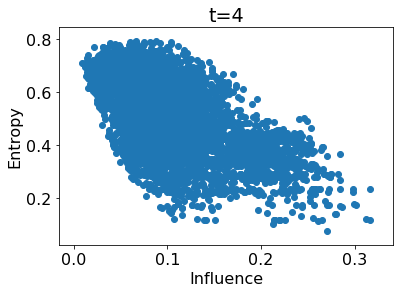

SpearmanrResult(correlation=-0.5620099021121064, pvalue=0.0)


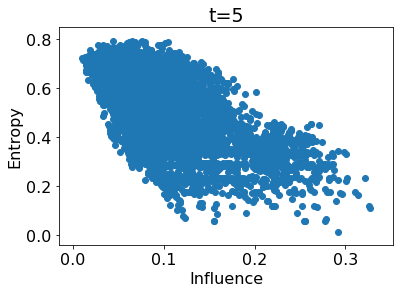

SpearmanrResult(correlation=-0.5983955143632363, pvalue=0.0)


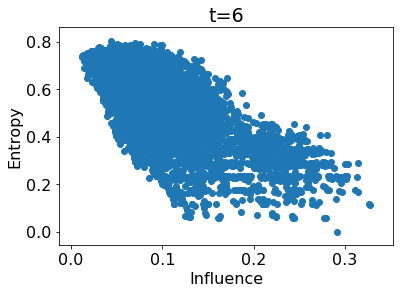

SpearmanrResult(correlation=-0.6462123525374526, pvalue=0.0)


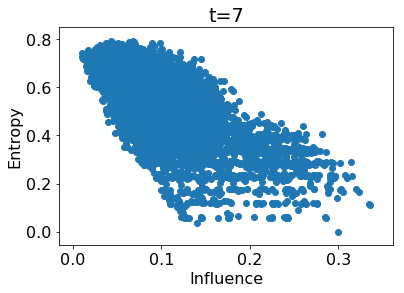

SpearmanrResult(correlation=-0.6675844386821176, pvalue=0.0)


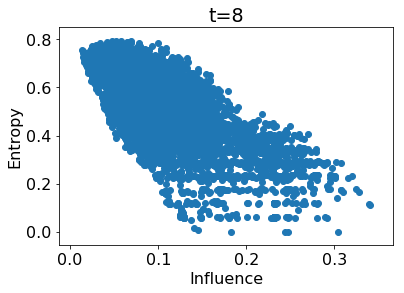

SpearmanrResult(correlation=-0.6826909619925496, pvalue=0.0)


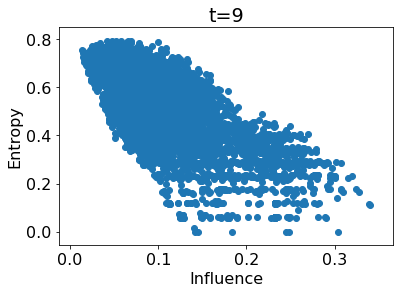

SpearmanrResult(correlation=-0.6812400783307859, pvalue=0.0)


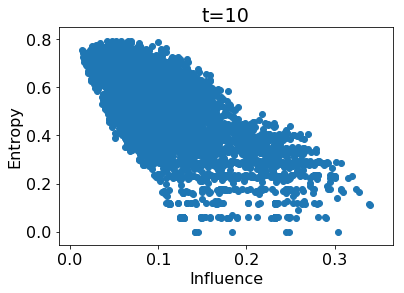

SpearmanrResult(correlation=-0.6811526264859509, pvalue=0.0)


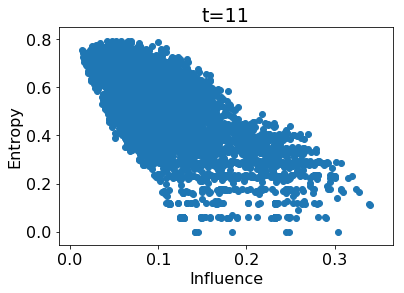

SpearmanrResult(correlation=-0.6811526264859509, pvalue=0.0)


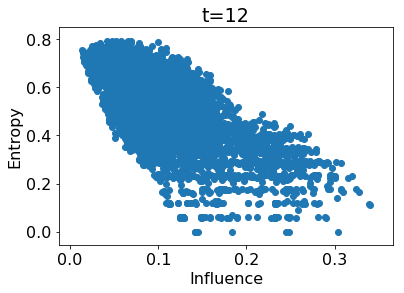

SpearmanrResult(correlation=-0.6811526264859509, pvalue=0.0)


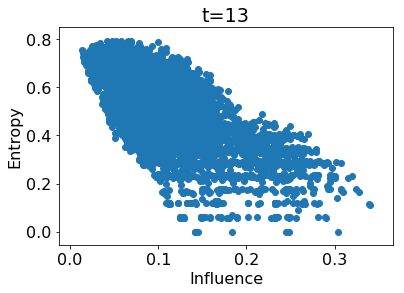

SpearmanrResult(correlation=-0.6811526264859509, pvalue=0.0)


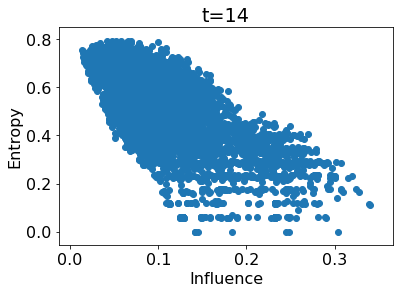

SpearmanrResult(correlation=-0.6811526264859509, pvalue=0.0)


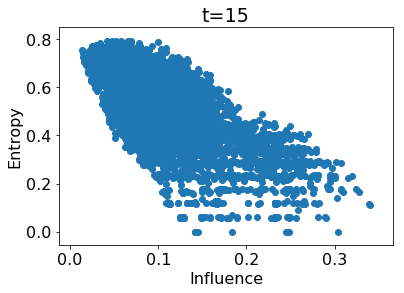

SpearmanrResult(correlation=-0.6811526264859509, pvalue=0.0)
[-0.13864894187376375, -0.5047192266134656, -0.5092611823334836, -0.539266079569348, -0.5620099021121064, -0.5983955143632363, -0.6462123525374526, -0.6675844386821176, -0.6826909619925496, -0.6812400783307859, -0.6811526264859509, -0.6811526264859509, -0.6811526264859509, -0.6811526264859509, -0.6811526264859509, -0.6811526264859509]


Text(0.5,0,'t')

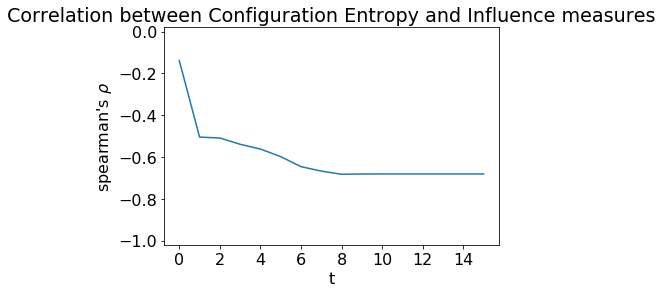

In [111]:
#plot correlation over time between entropy measure and influence measure
s_correlations=[]
for t in range(max(baseline)+1):
    xvalues,yvalues=[seed_influences[seed][t] for seed in seed_influences],[seed_entropy[seed][t] for seed in seed_influences]
    plt.scatter(xvalues,yvalues)
    plt.title("t="+str(t))
    plt.xlabel("Influence")
    plt.ylabel("Entropy")
    plt.show()
    print spearmanr(xvalues,yvalues)
    s_correlations.append(spearmanr(xvalues,yvalues)[0])
print s_correlations
#correlations[s]=s_correlations
correlations_sim[s]=s_correlations
plt.plot([t for t in range(max(baseline)+1)],s_correlations)
plt.title("Correlation between Configuration Entropy and Influence measures")
plt.ylim([-1.02,.02])
plt.xticks([0,2,4,6,8,10,12,14])
plt.ylabel(r"spearman's $\rho$")
plt.xlabel("t")

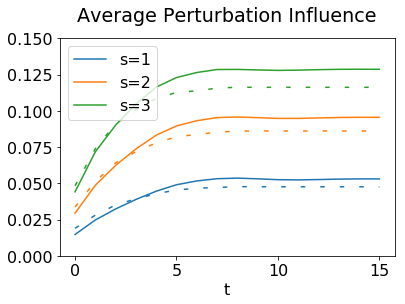

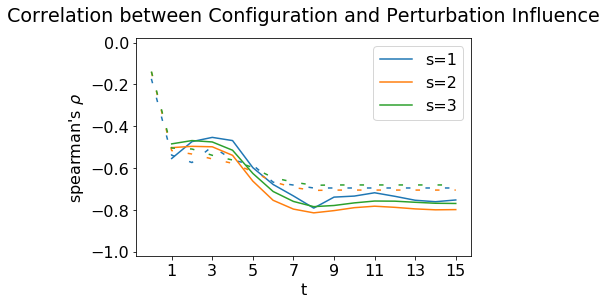

In [113]:
#plot for multiple seed sizes
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for s in influences:
    #print influences[s]
    plt.plot([t for t in range(len(influences[s]))],influences[s],label="s="+str(s))
    plt.plot([t for t in range(len(influences_sim[s]))],influences_sim[s],'--',dashes=(3, 10),color=colors[s-1],markersize=10)
    #plt.title("Average Influence over time",y=1.05)
    plt.title("Average Perturbation Influence",y=1.05)
    plt.legend(loc="upper left")
    plt.xlabel("t")
    plt.ylim([0,.15])
plt.show()
    
for s in correlations:
    #print correlations[s]
    plt.plot([t for t in range(len(correlations[s]))],correlations[s],label="s="+str(s))
    plt.plot([t for t in range(len(correlations_sim[s]))],correlations_sim[s],'--',dashes=(3, 10),color=colors[s-1],markersize=10)
    #plt.title("Correlation between Configuration Entropy and Influence",y=1.05)
    plt.title("Correlation between Configuration and Perturbation Influence",y=1.05)
    plt.legend()
    plt.ylim([-1.02,.02])
    plt.xticks([1,3,5,7,9,11,13,15])
    plt.ylabel(r"spearman's $\rho$")
    plt.xlabel("t")

In [55]:
#json dump for paper figure
#with open('drosophila_entropies_s1.json', 'w') as fp:
#    json.dump(seed_entropy, fp)
#with open('drosophila_dsunit_map.json', 'w') as fp:
#    json.dump(dsunit_map, fp)
#with open('drosophila_translator_s1.json', 'w') as fp:
#    json.dump(dtranslator, fp)
#with open('drosophila_entropies_s3.json', 'w') as fp:
#    json.dump(seed_entropy, fp)
#with open('drosophila_translator_s3.json', 'w') as fp:
#    json.dump(dtranslator, fp)

Lowest: (7,) [0.94, 0.78, 0.67, 0.56, 0.42, 0.34, 0.26, 0.23, 0.21, 0.19, 0.19, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18] ['en-1']
Highest: (28,) [0.94, 0.89, 0.88, 0.86, 0.82, 0.83, 0.84, 0.84, 0.85, 0.86, 0.86, 0.86, 0.86, 0.85, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86] ['CIR-0']


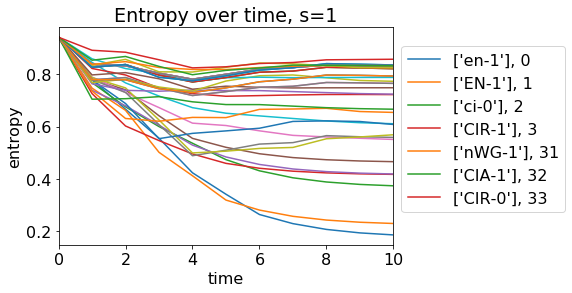

In [51]:
#graph s=1 length modules
iterations,length=11,1
print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]],
print to_list(sorted_entropies[0],dsunit_map,dtranslator)
print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]],
print to_list(sorted_entropies[-1],dsunit_map,dtranslator)
xvalues=range(iterations)
for index,seed in enumerate(sorted_entropies):
    if index<4 or index>30:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues],label=str(to_list(seed,dsunit_map,dtranslator))+', '+str(index))
    else:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues])
plt.title("Entropy over time, s="+str(length))
plt.ylabel("entropy")
plt.xlabel("time")
plt.xlim([0,iterations-1])
plt.legend(bbox_to_anchor=(1.0, 0.95))

Lowest: (1, 31, 32) [0.82, 0.61, 0.53, 0.4, 0.28, 0.21, 0.13, 0.06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] ['SLP-1', 'nhhnHH-1', 'nWG-0']
Highest: (0, 27, 28) [0.82, 0.8, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81, 0.81] ['SLP-0', 'CIA-1', 'CIR-0']


(0, 10)

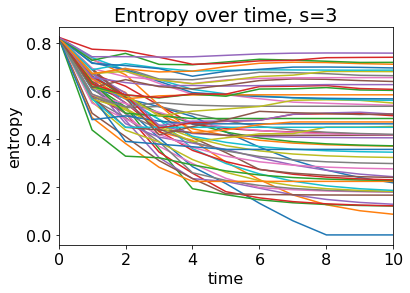

In [59]:
length=3
print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]],
print to_list(sorted_entropies[0],dsunit_map,dtranslator)
print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]],
print to_list(sorted_entropies[-1],dsunit_map,dtranslator)
#plt.plot(xvalues,[y*17 for y in yvalues0],label='s=0')
for index,seed in enumerate(sorted_entropies):
    if index%100==0:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues]) #label=to_list(seed,dsunit_map,dtranslator)
plt.title("Entropy over time, s="+str(length))
plt.ylabel("entropy")
plt.xlabel("time")
plt.xlim([0,iterations-1])
#plt.legend()

In [109]:
#aggregate by node
#NOTE: this is average activation; it is meaningless to take the entropy of this
#the average of the entropies does not equal the entropy of the average, e.g. ent([1,0],[0,1])!=ent([.5,.5])
length=0
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length)
sim_node_act={t:{node: np.mean([dact_prob_sim[seed][t][node] for seed in seeds if len(to_list(seed,dsunit_map,dtranslator))==length]) 
                 for node in dnodes} for t in range(iterations+1)}
mf_node_act={t:{node: np.mean([dmodules[seed][t][node] for seed in seeds if len(to_list(seed,dsunit_map,dtranslator))==length]) 
                for node in dnodes} for t in range(iterations+1)}
#sim_node_act

Normalized sim entropy: [1.0, 0.78, 0.86, 0.89, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84] [1.0, 0.78, 0.86, 0.89, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84]
Normalized mf entropy: [1.0, 0.81, 0.85, 0.83, 0.88, 0.61, 0.38, 0.23, 0.13, 0.08, 0.04] [1.0, 0.81, 0.85, 0.83, 0.88, 0.61, 0.38, 0.23, 0.13, 0.08, 0.04]
Diffusion values: [0.5, 0.23, 0.28, 0.31, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27] [0.5, 0.25, 0.2734375, 0.2603759765625, 0.2974740266799927, 0.14873701333999634, 0.07436850666999817, 0.037184253334999084, 0.018592126667499542, 0.009296063333749771, 0.0046480316668748856]


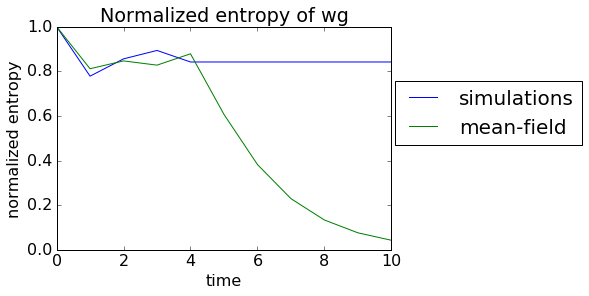

Normalized sim entropy: [1.0, 1.0, 0.78, 0.86, 0.89, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84] [1.0, 1.0, 0.78, 0.86, 0.89, 0.84, 0.84, 0.84, 0.84, 0.84, 0.84]
Normalized mf entropy: [1.0, 1.0, 0.81, 0.85, 0.83, 0.88, 0.61, 0.38, 0.23, 0.13, 0.08] [1.0, 1.0, 0.81, 0.85, 0.83, 0.88, 0.61, 0.38, 0.23, 0.13, 0.08]
Diffusion values: [0.53, 0.5, 0.23, 0.28, 0.31, 0.27, 0.27, 0.27, 0.27, 0.27, 0.27] [0.5, 0.5, 0.25, 0.2734375, 0.2603759765625, 0.2974740266799927, 0.14873701333999634, 0.07436850666999817, 0.037184253334999084, 0.018592126667499542, 0.009296063333749771]


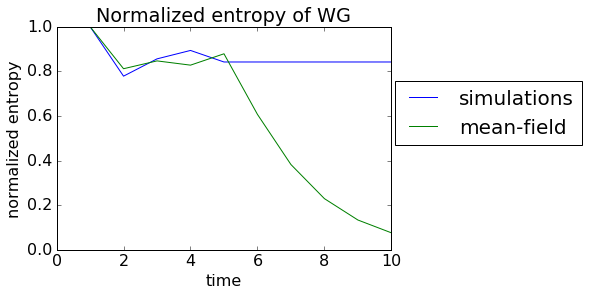

Normalized sim entropy: [1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.47, 0.59, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


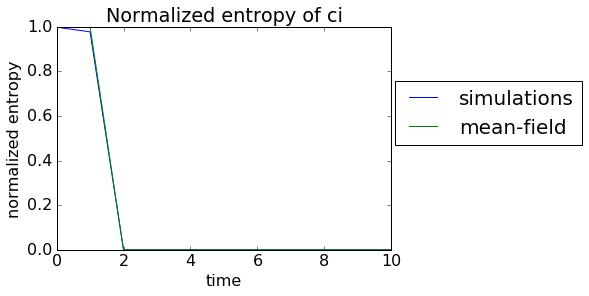

Normalized sim entropy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Normalized mf entropy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Diffusion values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


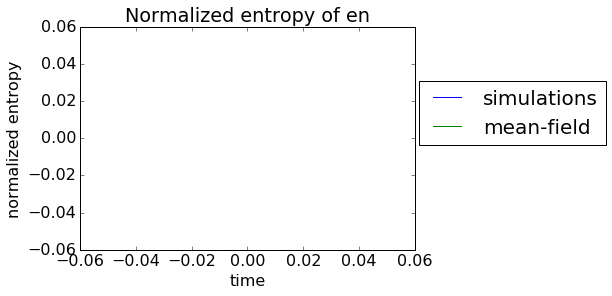

Normalized sim entropy: [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99] [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
Normalized mf entropy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Diffusion values: [0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


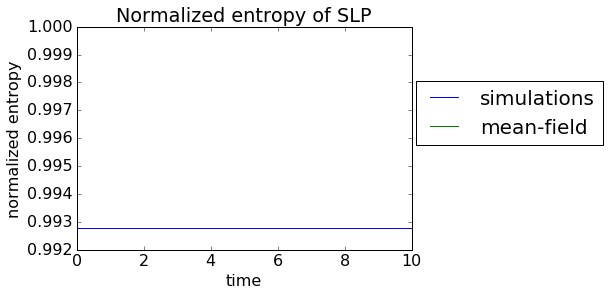

Normalized sim entropy: [1.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.58, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 0.54, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.54, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.54, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.5, 0.125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


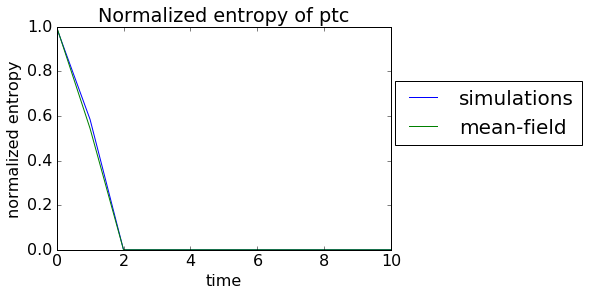

Normalized sim entropy: [0.99, 1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.99, 1.0, 0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.45, 0.47, 0.59, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.5, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


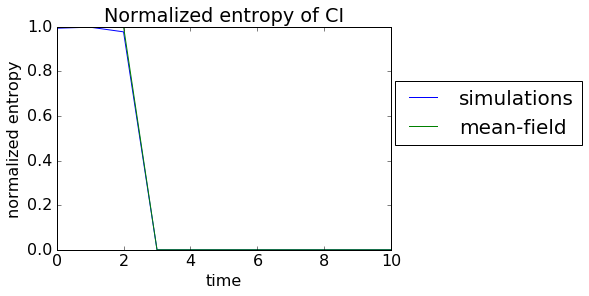

Normalized sim entropy: [1.0, 0.76, 0.91, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96] [1.0, 0.76, 0.91, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96]
Normalized mf entropy: [1.0, 0.81, 0.9, 0.72, 0.47, 0.29, 0.17, 0.1, 0.05, 0.03, 0.02] [1.0, 0.81, 0.9, 0.72, 0.47, 0.29, 0.17, 0.1, 0.05, 0.03, 0.02]
Diffusion values: [0.49, 0.78, 0.67, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62, 0.62] [0.5, 0.75, 0.6875, 0.80078125, 0.900390625, 0.9501953125, 0.97509765625, 0.987548828125, 0.9937744140625, 0.99688720703125, 0.998443603515625]


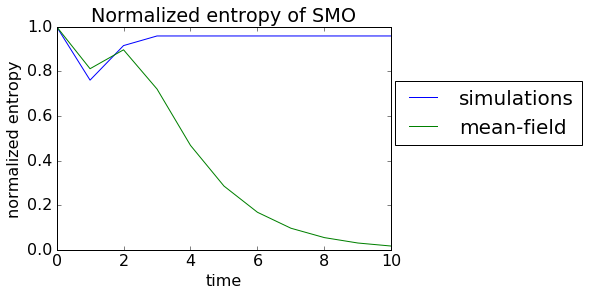

Normalized sim entropy: [0.97, 0.47, 0.63, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.97, 0.47, 0.63, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 0.54, 0.63, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.54, 0.63, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.6, 0.1, 0.16, 0.29, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.5, 0.125, 0.15625, 0.099609375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


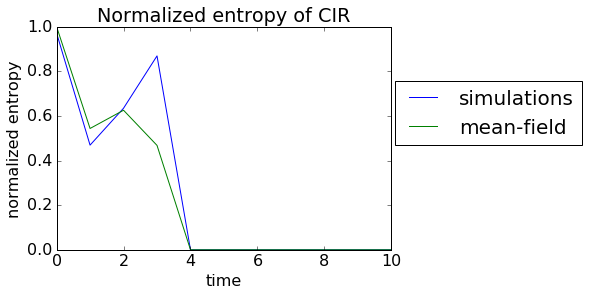

Normalized sim entropy: [0.96, 1.0, 0.7, 0.47, 0.63, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0] [0.96, 1.0, 0.7, 0.47, 0.63, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 1.0, 0.81, 0.54, 0.63, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 1.0, 0.81, 0.54, 0.63, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.61, 0.49, 0.19, 0.9, 0.84, 0.71, 1.0, 1.0, 1.0, 1.0, 1.0] [0.5, 0.5, 0.25, 0.875, 0.84375, 0.900390625, 1.0, 1.0, 1.0, 1.0, 1.0]


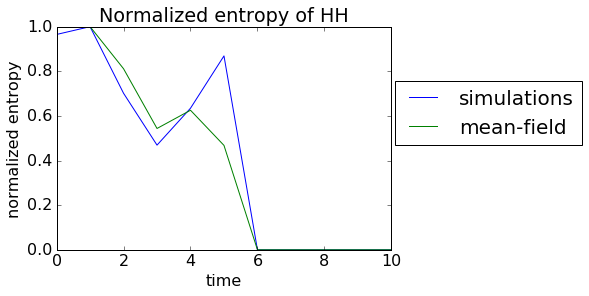

Normalized sim entropy: [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99] [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
Normalized mf entropy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Diffusion values: [0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44, 0.44] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


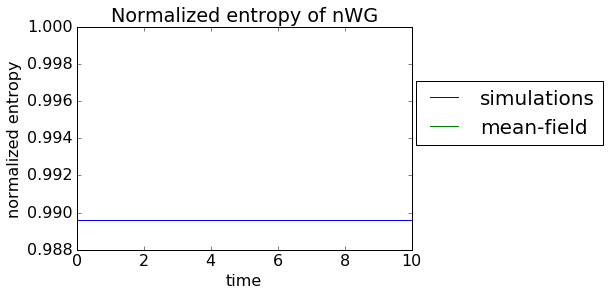

Normalized sim entropy: [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99] [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
Normalized mf entropy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Diffusion values: [0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


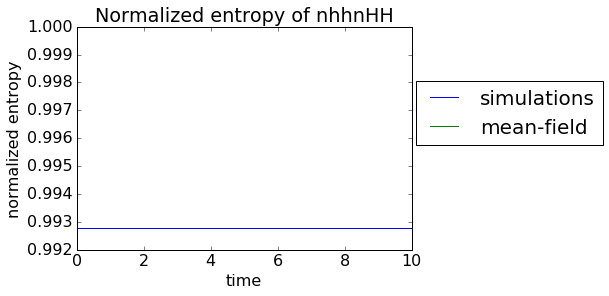

Normalized sim entropy: [0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.98, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.41, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


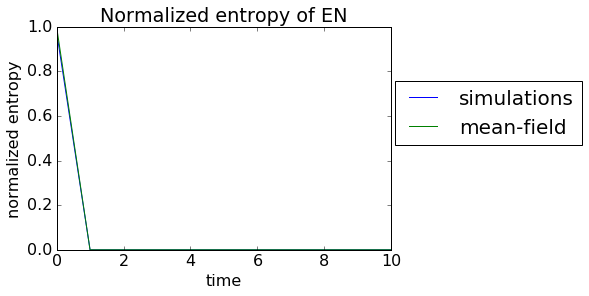

Normalized sim entropy: [1.0, 0.8, 0.88, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.8, 0.88, 0.08, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 0.81, 0.9, 0.72, 0.47, 0.29, 0.17, 0.1, 0.05, 0.03, 0.02] [1.0, 0.81, 0.9, 0.72, 0.47, 0.29, 0.17, 0.1, 0.05, 0.03, 0.02]
Diffusion values: [0.52, 0.24, 0.3, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.5, 0.25, 0.3125, 0.19921875, 0.099609375, 0.0498046875, 0.02490234375, 0.012451171875, 0.0062255859375, 0.00311279296875, 0.001556396484375]


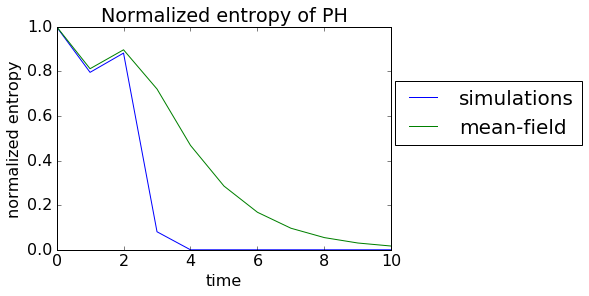

Normalized sim entropy: [1.0, 0.7, 0.47, 0.63, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.7, 0.47, 0.63, 0.87, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 0.81, 0.54, 0.63, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.81, 0.54, 0.63, 0.47, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.49, 0.19, 0.9, 0.84, 0.71, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.5, 0.25, 0.875, 0.84375, 0.900390625, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


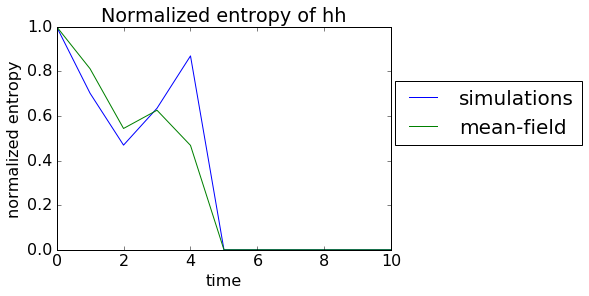

Normalized sim entropy: [1.0, 0.95, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96] [1.0, 0.95, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96]
Normalized mf entropy: [1.0, 0.95, 0.97, 0.72, 0.47, 0.29, 0.17, 0.1, 0.05, 0.03, 0.02] [1.0, 0.95, 0.97, 0.72, 0.47, 0.29, 0.17, 0.1, 0.05, 0.03, 0.02]
Diffusion values: [0.46, 0.63, 0.39, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38] [0.5, 0.625, 0.3984375, 0.19921875, 0.099609375, 0.0498046875, 0.02490234375, 0.012451171875, 0.0062255859375, 0.00311279296875, 0.001556396484375]


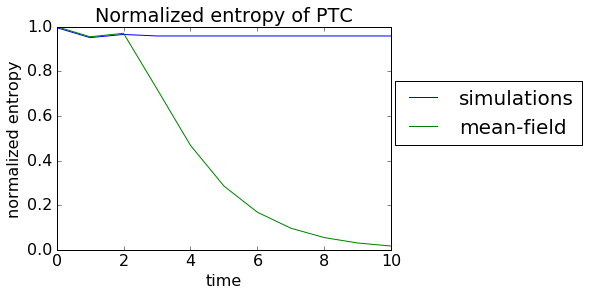

Normalized sim entropy: [0.99, 0.93, 0.89, 0.88, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.99, 0.93, 0.89, 0.88, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Normalized mf entropy: [1.0, 0.95, 0.93, 0.97, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.95, 0.93, 0.97, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Diffusion values: [0.55, 0.35, 0.31, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.5, 0.375, 0.34375, 0.400390625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


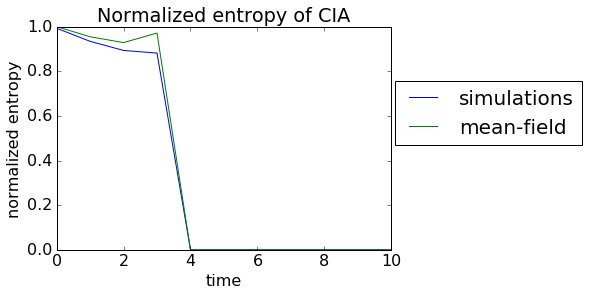

Total possible configurations: [0.5, 0.25, 0.06, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [1.0, 0.5, 0.13, 0.06, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


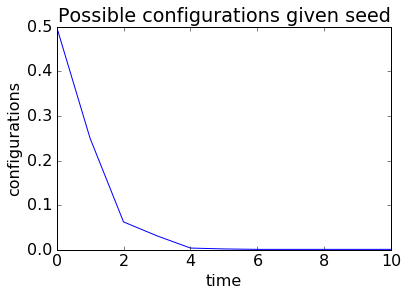

In [209]:
#plot single seed node entropies by node
seed='(7,)' #'(7,)'
diffusion_sim=dact_prob_sim[seed] #dact_prob_sim[seed], low_sim[seed]
diffusion_mf=dmodules[seed] #dmodules[seed]
seed_entropy,seed_configs=config_node_entropy(diffusion_sim,base=2,normalized=True)
seed_entropy2,seed_configs2=config_node_entropy(diffusion_mf,base=2,normalized=True)
for node in seed_entropy:
    xvalues=seed_entropy[node].keys()
    yvalues=[seed_entropy[node][t] for t in xvalues]
    y1values=[seed_entropy2[node][t] for t in xvalues] #mean-field, starts with max possible entropy
    #print [round(y*17,2) for y in yvalues]
    plt.plot(xvalues,[yvalue/y1values[0] for yvalue in yvalues],label='simulations') #normalize everything compared to the starting value
    print 'Normalized sim entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/y1values[0],2) for yvalue in yvalues]
    plt.plot(xvalues,[yvalue/y1values[0] for yvalue in y1values],label='mean-field') #normalize everything compared to the starting value
    print 'Normalized mf entropy:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
    print 'Diffusion values:',[diffusion_sim[t][node] for t in diffusion_sim],[diffusion_mf[t][node] for t in diffusion_mf]
    y1values=[2**(y * 17) for y in yvalues]
    #print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
    #plt.ylim([0.0,1.02])
    plt.title("Normalized entropy of %s" % (node))
    plt.ylabel("normalized entropy")
    plt.xlabel("time")
    plt.legend(bbox_to_anchor=(1.6, 0.8), fontsize=20)
    plt.show()
#plot configs
seed_entropy1,seed_configs1=config_entropy(diffusion_sim,base=2,normalized=True,strict=True)
xvalues=seed_configs1.keys()
y1values=[seed_configs1[key] for key in seed_configs1]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [96]:
#node entropies
length,iterations=3,20
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length)
#seed_entropies1,seed_configs=seed_node_entropies(dact_prob_sim,seeds,base=2,normalized=True,data=False)
#seed_entropies2,seed_configs2=seed_node_entropies(dmodules,seeds,base=2,normalized=True,data=False)
#configuration entropies
seed_entropy,seed_configs=seed_entropies(dact_prob_sim,seeds,normalized=True,data=False) #simulations
seed_entropy2,seed_configs2=seed_entropies(dmodules,seeds,normalized=True,data=False) #approximation
#sn=sorted([seed for seed in seeds],key=lambda x: seed_entropy2[x][10])
#for seed in sn: print to_list(seed,dsunit_map,dtranslator),seed_entropy2[seed][10]

In [99]:
#seed_entropies2
#with open('drosophila_node_entropies_s2.json', 'w') as fp:
#    json.dump(seed_entropies2, fp)
#with open('drosophila_simulations_node_entropies_s2.json', 'w') as fp:
#    json.dump(seed_entropies1, fp)
#with open('drosophila_simulations_entropies_s3.json', 'w') as fp:
#    json.dump(seed_entropy, fp)

Normalized sim entropy: [0.88, 0.66, 0.68, 0.67, 0.66, 0.64, 0.63, 0.62, 0.62, 0.62, 0.62] [0.99, 0.75, 0.77, 0.76, 0.74, 0.73, 0.71, 0.7, 0.7, 0.7, 0.7]
Normalized mf entropy: [0.88, 0.67, 0.65, 0.59, 0.55, 0.52, 0.49, 0.47, 0.45, 0.44, 0.43] [1.0, 0.76, 0.73, 0.67, 0.63, 0.59, 0.56, 0.53, 0.51, 0.49, 0.49]
Average Diffusion values: [0.51000000000000001, 0.29999999999999999, 0.28000000000000003, 0.27000000000000002, 0.23999999999999999, 0.23000000000000001, 0.20999999999999999, 0.19, 0.17999999999999999, 0.17000000000000001, 0.17000000000000001] [0.5, 0.25, 0.2734375, 0.2603759765625, 0.29747402667999268, 0.32787253804372085, 0.41225507995172372, 0.4312836080530601, 0.42825860654689735, 0.39171710836343998, 0.37200780445668474]


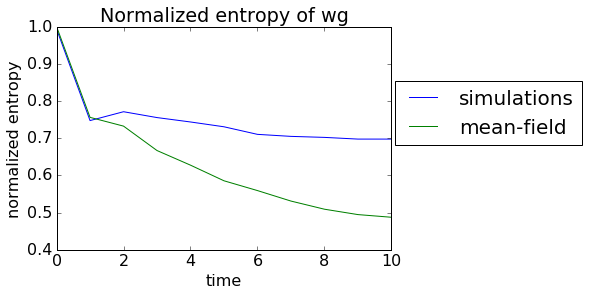

Normalized sim entropy: [0.88, 0.77, 0.57, 0.59, 0.58, 0.57, 0.56, 0.54, 0.54, 0.53, 0.53] [0.99, 0.87, 0.65, 0.67, 0.65, 0.64, 0.63, 0.61, 0.61, 0.61, 0.6]
Normalized mf entropy: [0.88, 0.77, 0.58, 0.56, 0.51, 0.47, 0.44, 0.41, 0.39, 0.37, 0.36] [1.0, 0.88, 0.66, 0.63, 0.57, 0.54, 0.5, 0.47, 0.44, 0.42, 0.41]
Average Diffusion values: [0.39000000000000001, 0.51000000000000001, 0.29999999999999999, 0.28000000000000003, 0.27000000000000002, 0.23999999999999999, 0.23000000000000001, 0.20999999999999999, 0.19, 0.17999999999999999, 0.17000000000000001] [0.5, 0.5, 0.25, 0.2734375, 0.2603759765625, 0.29747402667999268, 0.32787253804372085, 0.41225507995172372, 0.4312836080530601, 0.42825860654689735, 0.39171710836343998]


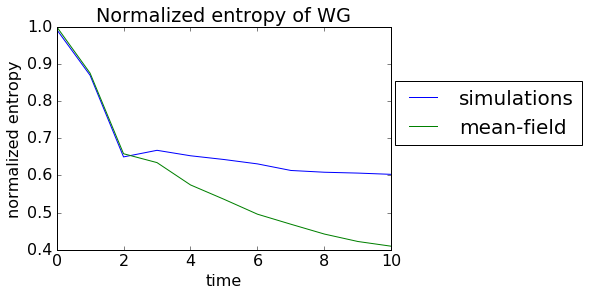

Normalized sim entropy: [0.88, 0.77, 0.66, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48] [0.99, 0.87, 0.75, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54]
Normalized mf entropy: [0.88, 0.77, 0.67, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48] [1.0, 0.88, 0.76, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55, 0.55]
Average Diffusion values: [0.48999999999999999, 0.54000000000000004, 0.45000000000000001, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998] [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]


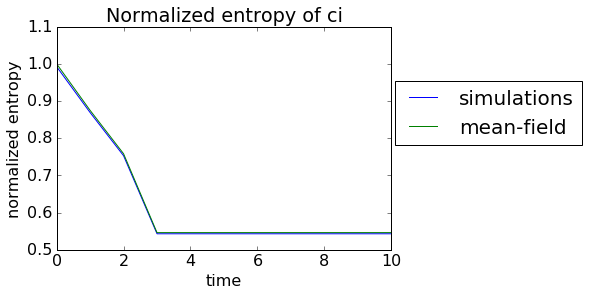

Normalized sim entropy: [0.88, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64] [0.99, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73]
Normalized mf entropy: [0.88, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65, 0.65] [1.0, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73, 0.73]
Average Diffusion values: [0.55000000000000004, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002] [0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


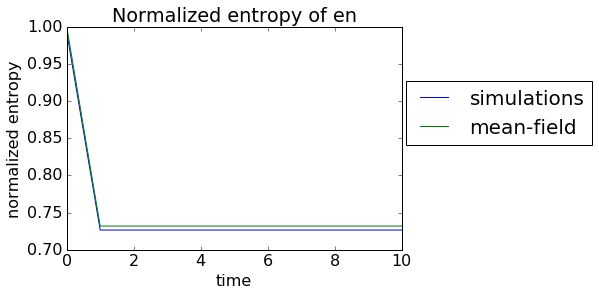

Normalized sim entropy: [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88] [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
Normalized mf entropy: [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Diffusion values: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


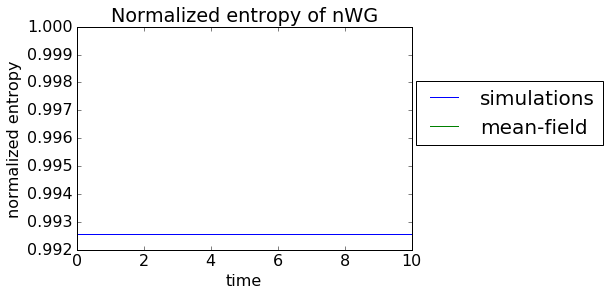

Normalized sim entropy: [0.88, 0.42, 0.47, 0.48, 0.47, 0.46, 0.5, 0.5, 0.49, 0.49, 0.49] [0.99, 0.48, 0.54, 0.54, 0.53, 0.52, 0.57, 0.56, 0.56, 0.55, 0.55]
Normalized mf entropy: [0.88, 0.43, 0.45, 0.46, 0.48, 0.49, 0.5, 0.5, 0.49, 0.49, 0.49] [1.0, 0.49, 0.51, 0.52, 0.55, 0.55, 0.56, 0.56, 0.56, 0.55, 0.55]
Average Diffusion values: [0.53000000000000003, 0.16, 0.14000000000000001, 0.17999999999999999, 0.22, 0.16, 0.40000000000000002, 0.38, 0.37, 0.35999999999999999, 0.35999999999999999] [0.5, 0.125, 0.1640625, 0.217529296875, 0.27038097381591797, 0.28714278670668136, 0.4044645852267128, 0.38375598784744253, 0.3709158538563665, 0.33047110280689235, 0.32456483496788285]


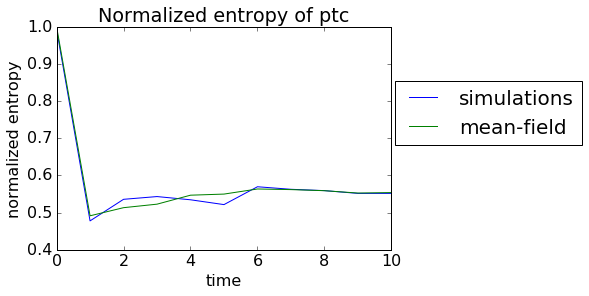

Normalized sim entropy: [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88] [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
Normalized mf entropy: [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Diffusion values: [0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002, 0.46000000000000002] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


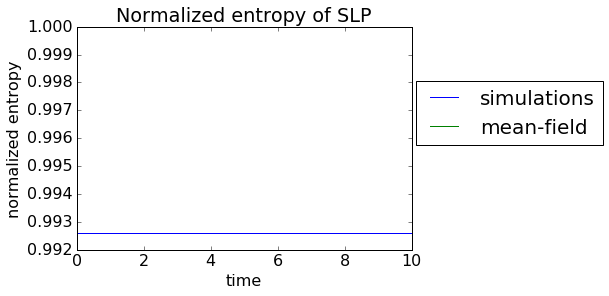

Normalized sim entropy: [0.88, 0.77, 0.55, 0.56, 0.4, 0.38, 0.35, 0.37, 0.37, 0.37, 0.37] [0.99, 0.87, 0.63, 0.64, 0.45, 0.43, 0.4, 0.42, 0.42, 0.42, 0.42]
Normalized mf entropy: [0.88, 0.77, 0.56, 0.57, 0.4, 0.38, 0.36, 0.35, 0.34, 0.34, 0.34] [1.0, 0.88, 0.64, 0.64, 0.46, 0.43, 0.41, 0.39, 0.39, 0.39, 0.39]
Average Diffusion values: [0.55000000000000004, 0.48999999999999999, 0.23000000000000001, 0.48999999999999999, 0.23999999999999999, 0.20999999999999999, 0.25, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002] [0.5, 0.5, 0.25, 0.4375, 0.2109375, 0.22509765625, 0.22933769226074219, 0.21748089056927711, 0.21278850322714887, 0.20981712180026463, 0.20011628161726375]


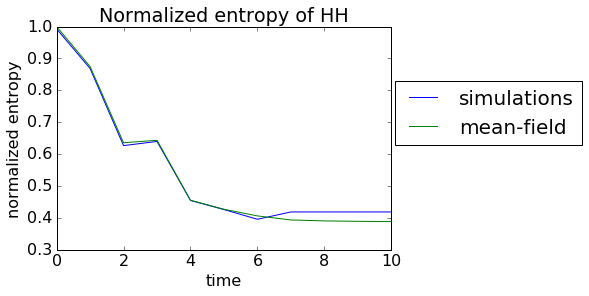

Normalized sim entropy: [0.88, 0.77, 0.66, 0.57, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41] [0.99, 0.87, 0.75, 0.65, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46]
Normalized mf entropy: [0.88, 0.77, 0.67, 0.57, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41, 0.41] [1.0, 0.88, 0.76, 0.65, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46]
Average Diffusion values: [0.46000000000000002, 0.48999999999999999, 0.54000000000000004, 0.45000000000000001, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998, 0.72999999999999998] [0.5, 0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75]


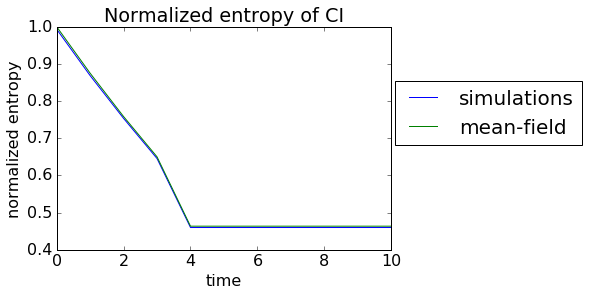

Normalized sim entropy: [0.88, 0.64, 0.72, 0.72, 0.73, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72] [0.99, 0.73, 0.82, 0.82, 0.82, 0.82, 0.82, 0.81, 0.81, 0.81, 0.81]
Normalized mf entropy: [0.88, 0.65, 0.68, 0.56, 0.5, 0.46, 0.45, 0.44, 0.44, 0.43, 0.43] [1.0, 0.73, 0.77, 0.64, 0.56, 0.52, 0.51, 0.5, 0.5, 0.49, 0.48]
Average Diffusion values: [0.52000000000000002, 0.76000000000000001, 0.66000000000000003, 0.63, 0.62, 0.59999999999999998, 0.57999999999999996, 0.56999999999999995, 0.56000000000000005, 0.56000000000000005, 0.56000000000000005] [0.5, 0.75, 0.6875, 0.80078125, 0.8347015380859375, 0.82656474970281124, 0.80153868387812732, 0.78569131626807809, 0.73395350195873998, 0.72614722539023691, 0.72840385362959292]


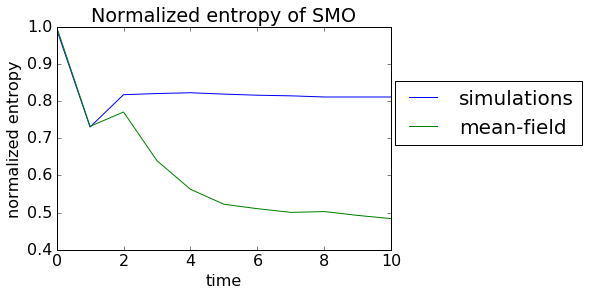

Normalized sim entropy: [0.88, 0.43, 0.51, 0.5, 0.49, 0.54, 0.54, 0.54, 0.54, 0.54, 0.54] [0.99, 0.49, 0.58, 0.57, 0.55, 0.61, 0.61, 0.61, 0.61, 0.61, 0.61]
Normalized mf entropy: [0.88, 0.43, 0.47, 0.37, 0.34, 0.38, 0.4, 0.41, 0.42, 0.42, 0.41] [1.0, 0.49, 0.53, 0.42, 0.39, 0.44, 0.45, 0.46, 0.48, 0.47, 0.46]
Average Diffusion values: [0.46999999999999997, 0.11, 0.17000000000000001, 0.22, 0.17000000000000001, 0.33000000000000002, 0.34999999999999998, 0.35999999999999999, 0.37, 0.37, 0.37] [0.5, 0.125, 0.15625, 0.099609375, 0.08264923095703125, 0.13007643772289157, 0.14884598709140451, 0.16073151279894143, 0.19953487353094507, 0.20538958095732232, 0.20369710977780536]


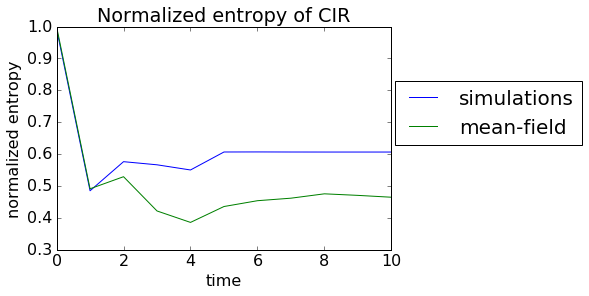

Normalized sim entropy: [0.88, 0.64, 0.66, 0.47, 0.44, 0.41, 0.44, 0.44, 0.44, 0.44, 0.44] [0.99, 0.72, 0.75, 0.53, 0.5, 0.46, 0.49, 0.49, 0.49, 0.49, 0.49]
Normalized mf entropy: [0.88, 0.65, 0.66, 0.47, 0.44, 0.42, 0.41, 0.41, 0.41, 0.41, 0.41] [1.0, 0.73, 0.75, 0.53, 0.5, 0.48, 0.47, 0.46, 0.46, 0.46, 0.46]
Average Diffusion values: [0.48999999999999999, 0.23000000000000001, 0.48999999999999999, 0.23999999999999999, 0.20999999999999999, 0.25, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002] [0.5, 0.25, 0.4375, 0.2109375, 0.22509765625, 0.22933769226074219, 0.21748089056927711, 0.21278850322714887, 0.20981712180026463, 0.20011628161726375, 0.19865260476066943]


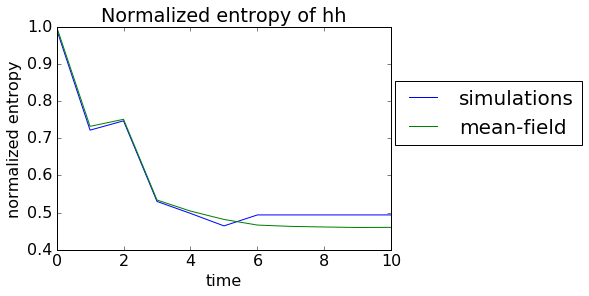

Normalized sim entropy: [0.88, 0.77, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56] [0.99, 0.87, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63, 0.63]
Normalized mf entropy: [0.88, 0.77, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56] [1.0, 0.88, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64, 0.64]
Average Diffusion values: [0.46000000000000002, 0.55000000000000004, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002, 0.27000000000000002] [0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


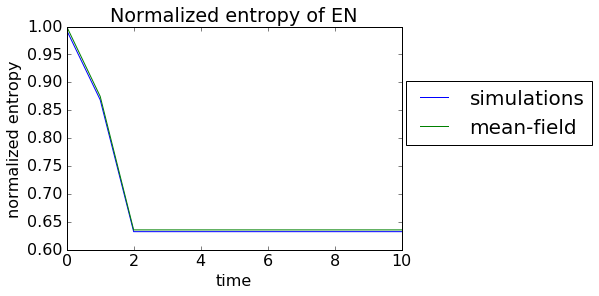

Normalized sim entropy: [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88] [0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
Normalized mf entropy: [0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88, 0.88] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Average Diffusion values: [0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001, 0.51000000000000001] [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


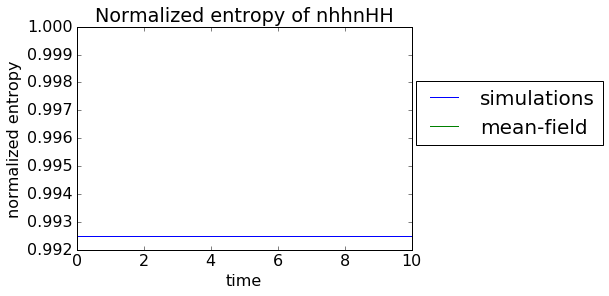

Normalized sim entropy: [0.88, 0.64, 0.6, 0.29, 0.37, 0.4, 0.41, 0.41, 0.44, 0.44, 0.44] [0.99, 0.72, 0.68, 0.33, 0.42, 0.45, 0.46, 0.46, 0.5, 0.5, 0.5]
Normalized mf entropy: [0.88, 0.65, 0.69, 0.55, 0.49, 0.46, 0.45, 0.44, 0.44, 0.43, 0.42] [1.0, 0.73, 0.78, 0.62, 0.56, 0.52, 0.51, 0.5, 0.5, 0.49, 0.48]
Average Diffusion values: [0.54000000000000004, 0.28000000000000003, 0.27000000000000002, 0.10000000000000001, 0.10000000000000001, 0.14000000000000001, 0.19, 0.14000000000000001, 0.35999999999999999, 0.35999999999999999, 0.35999999999999999] [0.5, 0.25, 0.3125, 0.19921875, 0.1652984619140625, 0.17343525029718876, 0.19846131612187268, 0.21430868373192191, 0.26604649804126007, 0.27385277460976309, 0.27159614637040713]


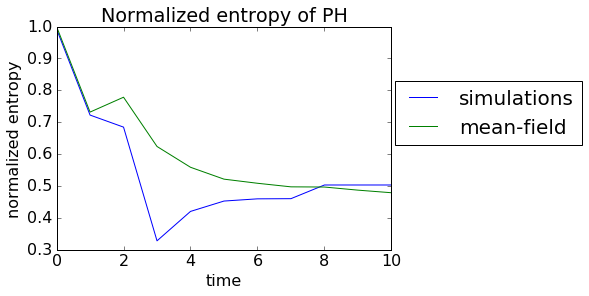

Normalized sim entropy: [0.88, 0.77, 0.76, 0.74, 0.68, 0.64, 0.61, 0.51, 0.51, 0.51, 0.51] [0.99, 0.87, 0.86, 0.84, 0.77, 0.73, 0.69, 0.57, 0.57, 0.57, 0.57]
Normalized mf entropy: [0.88, 0.78, 0.74, 0.66, 0.59, 0.54, 0.5, 0.47, 0.47, 0.47, 0.47] [1.0, 0.88, 0.84, 0.75, 0.67, 0.61, 0.56, 0.53, 0.53, 0.53, 0.53]
Average Diffusion values: [0.52000000000000002, 0.60999999999999999, 0.46999999999999997, 0.47999999999999998, 0.54000000000000004, 0.60999999999999999, 0.56999999999999995, 0.80000000000000004, 0.80000000000000004, 0.80000000000000004, 0.80000000000000004] [0.5, 0.625, 0.3984375, 0.330596923828125, 0.34687050059437752, 0.39692263224374535, 0.42861736746384382, 0.53209299608252014, 0.54770554921952619, 0.54319229274081426, 0.51231257116816886]


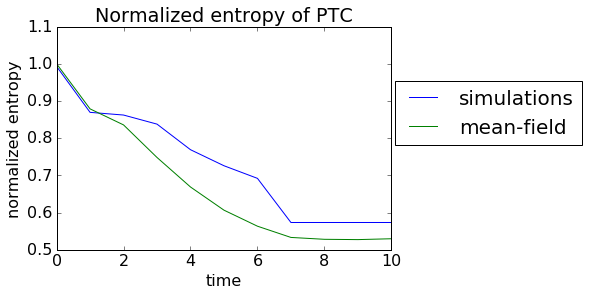

Normalized sim entropy: [0.88, 0.76, 0.68, 0.62, 0.58, 0.59, 0.59, 0.58, 0.58, 0.58, 0.58] [0.99, 0.86, 0.77, 0.71, 0.65, 0.67, 0.67, 0.66, 0.65, 0.65, 0.65]
Normalized mf entropy: [0.88, 0.77, 0.69, 0.63, 0.58, 0.54, 0.56, 0.56, 0.57, 0.56, 0.56] [1.0, 0.87, 0.78, 0.72, 0.66, 0.62, 0.63, 0.64, 0.64, 0.64, 0.63]
Average Diffusion values: [0.54000000000000004, 0.34999999999999998, 0.32000000000000001, 0.32000000000000001, 0.28000000000000003, 0.40000000000000002, 0.38, 0.37, 0.35999999999999999, 0.35999999999999999, 0.35999999999999999] [0.5, 0.375, 0.34375, 0.400390625, 0.41735076904296875, 0.61992356227710843, 0.60115401290859549, 0.58926848720105851, 0.55046512646905499, 0.54461041904267771, 0.54630289022219469]


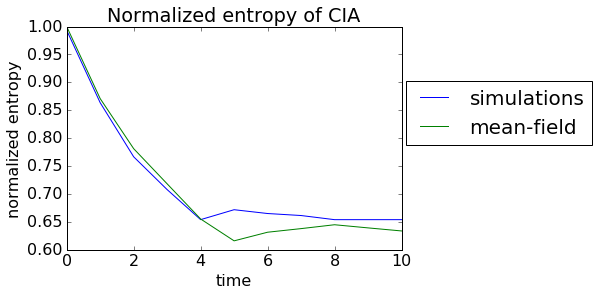

In [226]:
#multiple seed entropies by node
length,iterations=2,10
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length)
seed_entropies1,seed_configs=seed_node_entropies(dact_prob_sim,seeds,base=2,normalized=True,data=False)
seed_entropies2,seed_configs2=seed_node_entropies(dmodules,seeds,base=2,normalized=True,data=False)
for node in dnodes:
    xvalues=range(iterations+1)
    yvalues=[np.mean([seed_entropies1[seed][node][t] for seed in seed_entropies1]) for t in xvalues]
    #print node,[np.mean([seed_configs[seed][node][t] for seed in seed_configs]) for t in xvalues]
    y1values=[np.mean([seed_entropies2[seed][node][t] for seed in seed_entropies2]) for t in xvalues] #mean-field
    #print [round(y*17,2) for y in yvalues]
    plt.plot(xvalues,[yvalue/y1values[0] for yvalue in yvalues],label='simulations') #normalize everything compared to the starting value
    print 'Normalized sim entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/y1values[0],2) for yvalue in yvalues]
    plt.plot(xvalues,[yvalue/y1values[0] for yvalue in y1values],label='mean-field') #normalize everything compared to the starting value
    print 'Normalized mf entropy:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
    print 'Average Diffusion values:',[sim_node_act[t][node] for t in xvalues],[mf_node_act[t][node] for t in xvalues]
    #y1values=[2**(y * 17) for y in yvalues]
    #print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
    #plt.ylim([0.0,1.02])
    plt.title("Normalized entropy of %s" % (node))
    plt.ylabel("normalized entropy")
    plt.xlabel("time")
    plt.legend(bbox_to_anchor=(1.6, 0.8), fontsize=20)
    plt.show()

pearson 1 (0.99987388060010407, 2.0897466372402221e-28)
spearman 1 (0.97148472778611805, 8.7447492264600298e-11)


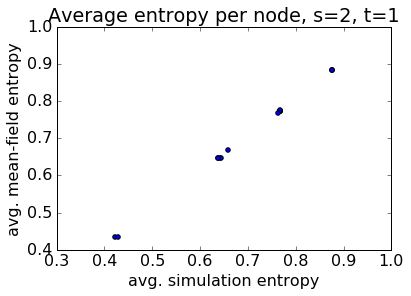

pearson 2 (0.97517763783468692, 3.123480700991495e-11)
spearman 2 (0.90842469533426684, 4.5867324842676082e-07)


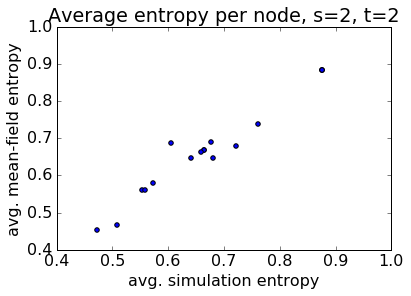

pearson 3 (0.8460562663810457, 1.8691630592834705e-05)
spearman 3 (0.88698056427114835, 2.0842693311417763e-06)


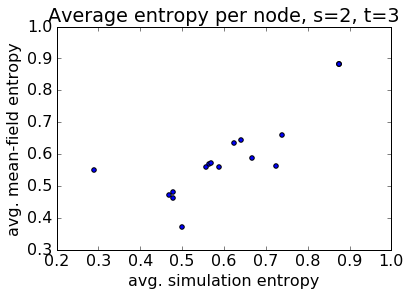

pearson 4 (0.89072821322839768, 1.6368268025913891e-06)
spearman 4 (0.8304693371846209, 3.673056826436463e-05)


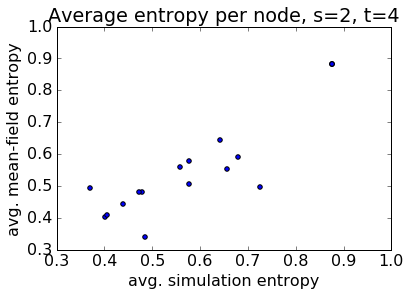

pearson 5 (0.88096272676356346, 3.0203966748852527e-06)
spearman 5 (0.79607119895803902, 0.00013195712406229734)


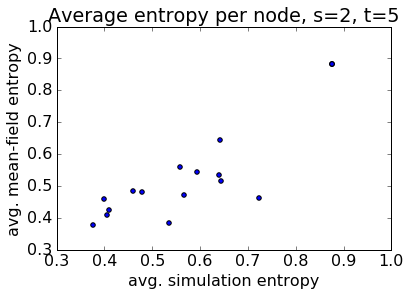

pearson 6 (0.88583752842565422, 2.2399506690400818e-06)
spearman 6 (0.79607119895803902, 0.00013195712406229734)


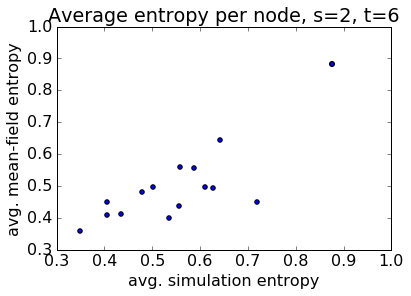

pearson 7 (0.88998209006197271, 1.718681742567737e-06)
spearman 7 (0.75921605085812982, 0.00040846024032722007)


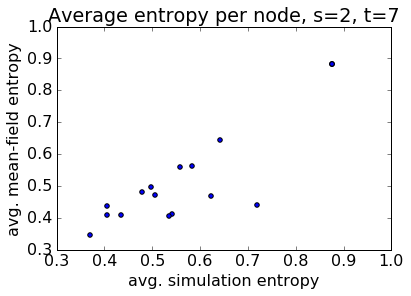

pearson 8 (0.89156095743934893, 1.5494224130254254e-06)
spearman 8 (0.75921605085812982, 0.00040846024032722007)


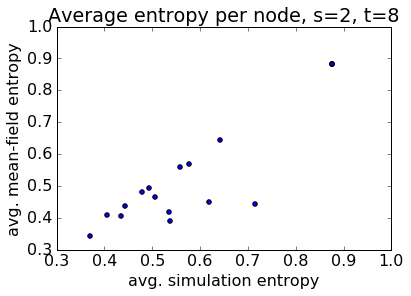

pearson 9 (0.88449975914736945, 2.4346565369855949e-06)
spearman 9 (0.76658708047811164, 0.00033114993114436499)


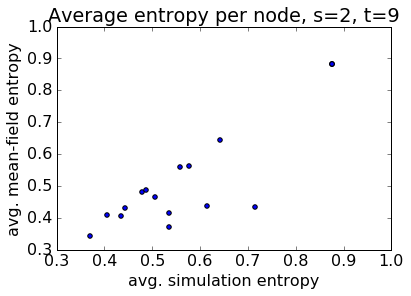

pearson 10 (0.87885429103344559, 3.4236717846685683e-06)
spearman 10 (0.76413007060478433, 0.00035543023413760769)


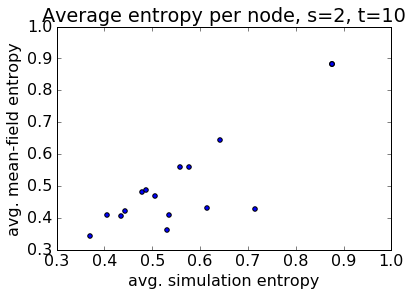

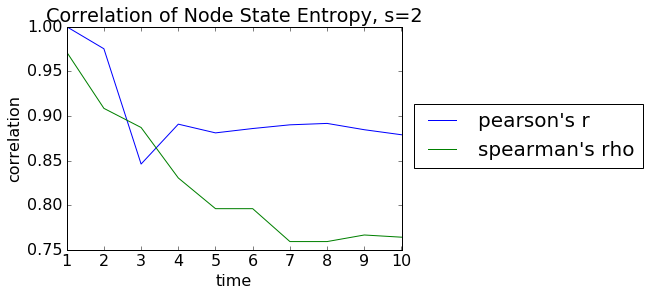

In [229]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr
#test two correlations between the mean-field approximation and the simulations:
# 1. the bias of each node based on the entropy of its state across seeds (what node is most certain?)
# 2. the influence of each node state (seed) based on the average of its node entropies (what seed is most informational?)
#sn=sorted([node for node in dnodes],key=lambda x: seed_entropy[x][10])
yvalues,y1values=[],[]
for t in range(1,iterations+1): #not defined at 0 because all values are 0.5 for the mf-approximation
    avg1=[np.mean([seed_entropies1[seed][node][t] for seed in seed_entropies1]) for node in dnodes] #multiple seeds
    avg2=[np.mean([seed_entropies2[seed][node][t] for seed in seed_entropies2]) for node in dnodes]
    #avg1=[seed_entropy[node][t] for node in dnodes] #single node
    #avg2=[seed_entropy2[node][t] for node in dnodes]
    print 'pearson',t,pearsonr(avg1,avg2)
    print 'spearman',t,spearmanr(avg1,avg2)
    yvalues.append(pearsonr(avg1,avg2)[0])
    y1values.append(spearmanr(avg1,avg2)[0])
    #print 'sim',sorted([node for node in nodes],key=lambda x: seed_entropy[x][t])
    #print [round(seed_entropy[node][t],2) for node in sorted([node for node in dnodes],key=lambda x: seed_entropy[x][t])]
    #print 'mf',sorted([node for node in nodes],key=lambda x: seed_entropy2[x][t])
    #print [round(seed_entropy2[node][t],2) for node in sorted([node for node in dnodes],key=lambda x: seed_entropy2[x][t])]
    plt.scatter(avg1,avg2)
    plt.xlabel("avg. simulation entropy")
    plt.ylabel("avg. mean-field entropy")
    plt.title("Average entropy per node, s=%d, t=%d" % (length,t))
    plt.show()

#plot correlation of node uncertainty
xvalues=range(1,iterations+1)
#yvalues=[pearsonr([seed_entropy[node][t] for node in sn],[seed_entropy2[node][t] for node in sn])[0] for t in xvalues]
plt.plot(xvalues,yvalues,label="pearson's r")
plt.plot(xvalues,y1values,label="spearman's rho")
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Correlation of Node State Entropy, s=%d" % (length))
plt.legend(bbox_to_anchor=(1.75, 0.7), fontsize=20)

In [230]:
#look at node entropy per seed; does seed entropy correlate with node entropy correlation?
length,t,iterations=2,10,10 #compare last iteration
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length)
seed_entropy_mf,seed_configs_mf=seed_entropies(dmodules,seeds,normalized=True,data=False) #sort by simulation
seed_entropy_sim,seed_configs_sim=seed_entropies(dact_prob_sim,seeds,normalized=True,data=False) #sort by simulation
pcorrelations={i:[] for i in range(iterations+1)}
scorrelations={i:[] for i in range(iterations+1)}
for seed in sorted(seeds,key=lambda x: seed_entropy_sim[x][t]):
    diffusion_sim=dact_prob_sim[seed] #dact_prob_sim[seed], low_sim[seed], sim_node_act
    diffusion_mf=dmodules[seed] #dmodules[seed], mf_node_act
    seed_entropy,seed_configs=config_node_entropy(diffusion_sim,base=2,normalized=True)
    seed_entropy2,seed_configs2=config_node_entropy(diffusion_mf,base=2,normalized=True)
    #print to_list(seed,dsunit_map,dtranslator)[0], seed_entropy_mf[seed][t],
    #print pearsonr([seed_entropy[node][t] for node in dnodes],[seed_entropy2[node][t] for node in dnodes])
    for i  in range(iterations+1):
        corr1=pearsonr([seed_entropy[node][i] for node in dnodes],[seed_entropy2[node][i] for node in dnodes])[0]
        corr2=spearmanr([seed_entropy[node][i] for node in dnodes],[seed_entropy2[node][i] for node in dnodes])[0]
        if float(corr1)==corr1: #skip over any seeds with 0 entropy (results in nan correlation)
            pcorrelations[i].append(corr1)
            scorrelations[i].append(corr2)

#seed_entropy_sim['(1, 31, 33)']
print len(pcorrelations[0]),len(scorrelations[0])

544 544


correlation between node state entropies and seed entropies
0 (0.52612572586101736, 4.6695273011999334e-40)
1 (-0.39443153913560297, 1.0775034922828338e-21)
2 (-0.56326454764555711, 7.3169045669715991e-47)
3 (-0.35719184019819539, 8.1728036871713083e-18)
4 (-0.31867243169607418, 2.6373691591405916e-14)
5 (-0.3092140909693406, 1.618839152991181e-13)
6 (-0.34845230749555839, 5.6476554044784772e-17)
7 (-0.39696661628738716, 5.6200318824983418e-22)
8 (-0.44027204747789983, 3.3728248722577066e-27)
9 (-0.42189137743360117, 6.8752346173203132e-25)
10 (-0.38241115105087647, 2.1872874788887676e-20)
avergae correlation of node state entropies
0 0.999579896671
1 0.993461549264
2 0.986067465378
3 0.945540418068
4 0.926739364084
5 0.903924601027
6 0.887811523512
7 0.863555527672
8 0.854019324706
9 0.846252713446
10 0.840278010895


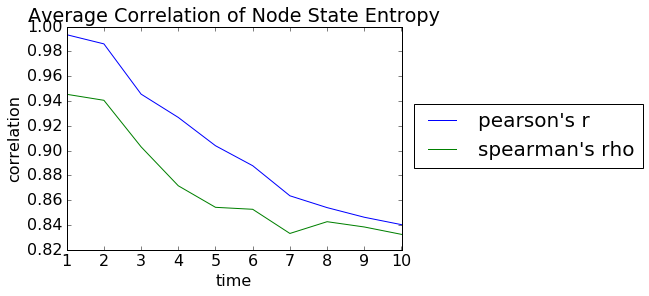

In [234]:
#graph correlations; be careful about trying to correlate seeds with no entropy (skip these seeds)
print 'correlation between node state entropies and seed entropies'
for i in range(iterations+1):
    print i,spearmanr(scorrelations[i],[seed_entropy_sim[seed][i] for seed in sorted(seeds,key=lambda x: seed_entropy_sim[x][t]) if
                                     seed_entropy_sim[seed][i]>0])
print 'avergae correlation of node state entropies'
for i in range(iterations+1):
    print i,np.mean(pcorrelations[i])

#plot correlation
xvalues=range(1,iterations+1)
yvalues=[np.mean(pcorrelations[i]) for i in xvalues] #average of node correlations
y1values=[np.mean(scorrelations[i]) for i in xvalues] #average of node correlations
#yvalues=[spearmanr(pcorrelations[i],[seed_entropy_sim[seed][i] for seed in sorted(seeds,key=lambda x: seed_entropy_sim[x][t]) if
#                                     seed_entropy_sim[seed][i]>0])[0] for i in xvalues]
#y1values=[spearmanr(scorrelations[i],[seed_entropy_sim[seed][i] for seed in sorted(seeds,key=lambda x: seed_entropy_sim[x][t]) if
#                                     seed_entropy_sim[seed][i]>0])[0] for i in xvalues]
plt.plot(xvalues,yvalues,label="pearson's r")
plt.plot(xvalues,y1values,label="spearman's rho")
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Average Correlation of Node State Entropy")
#plt.title("Correlation of Node State Entropy with Seed Entropy Correlation")
plt.legend(bbox_to_anchor=(1.75, 0.7), fontsize=20)

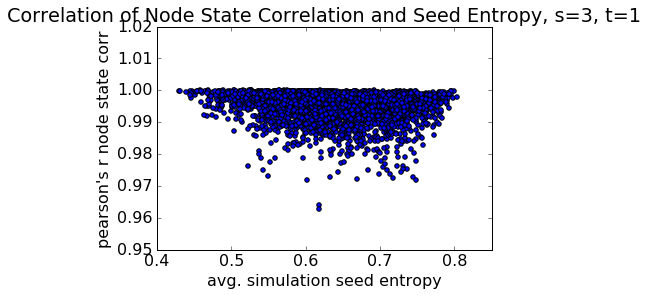

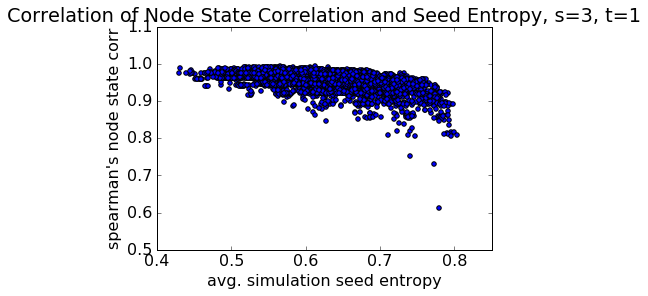

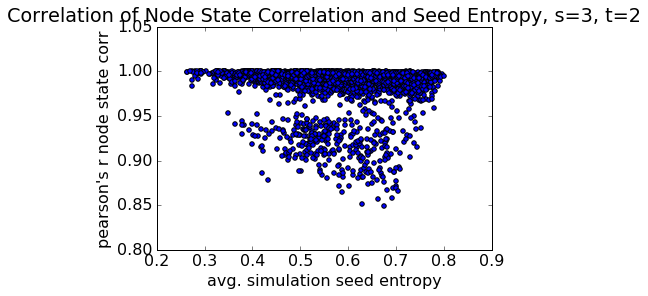

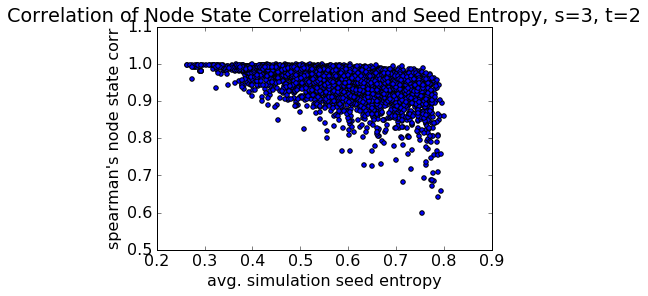

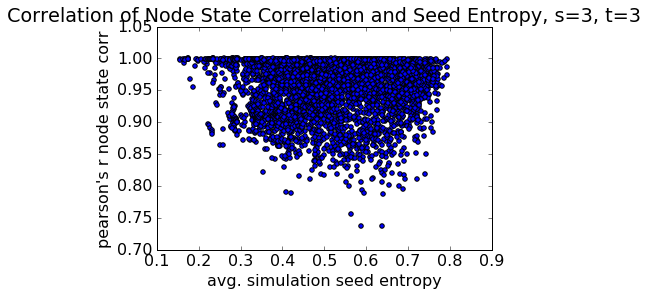

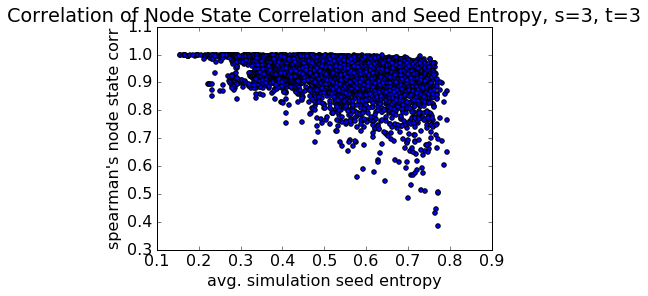

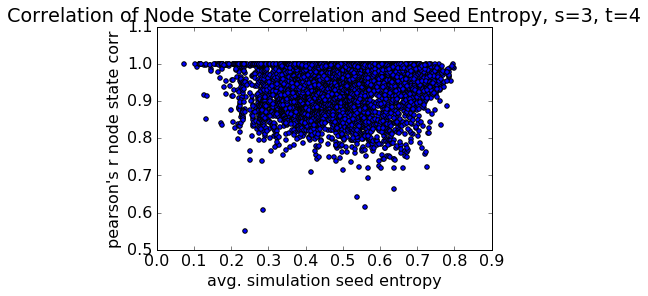

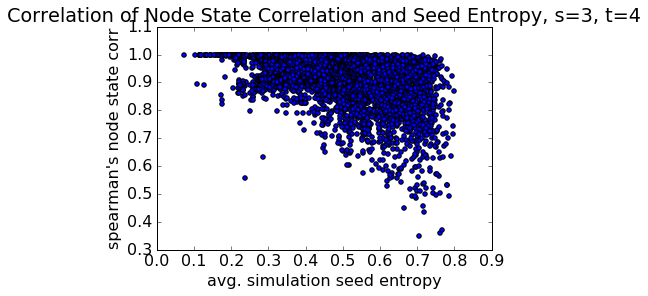

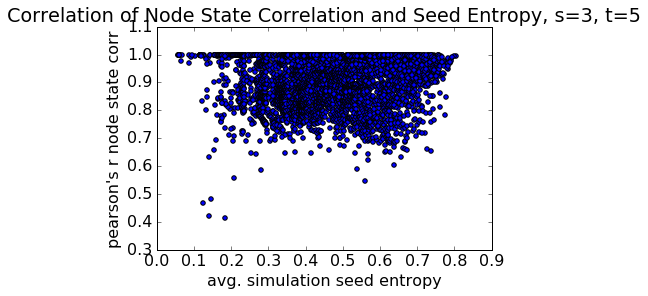

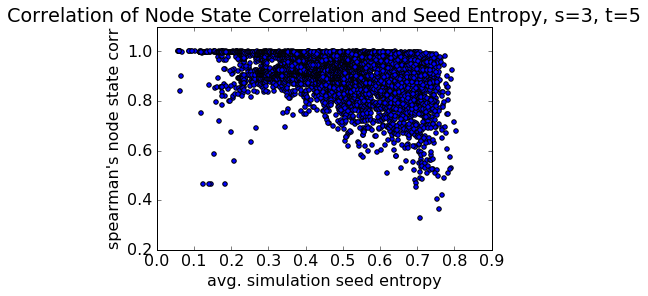

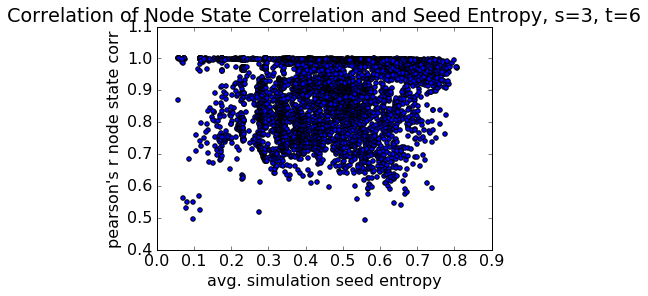

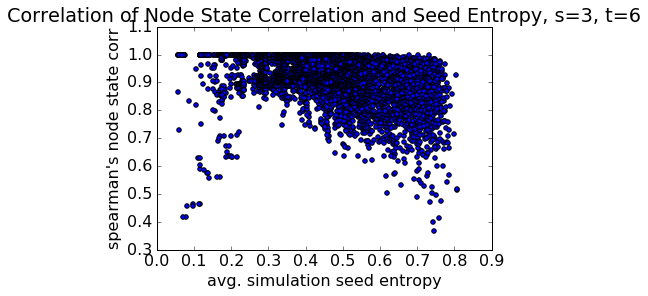

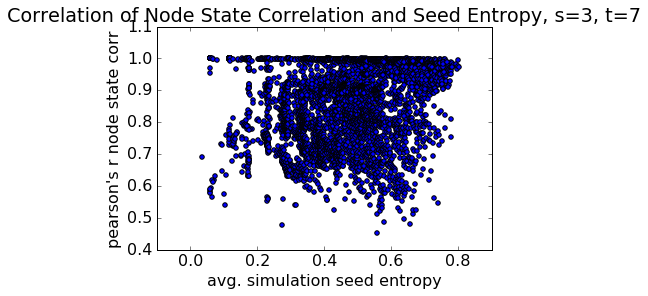

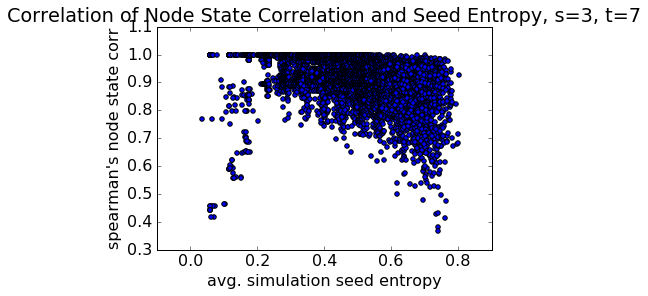

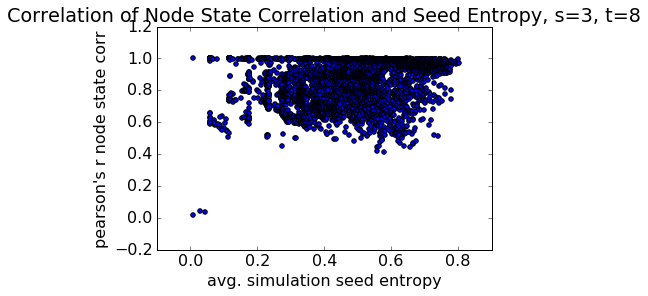

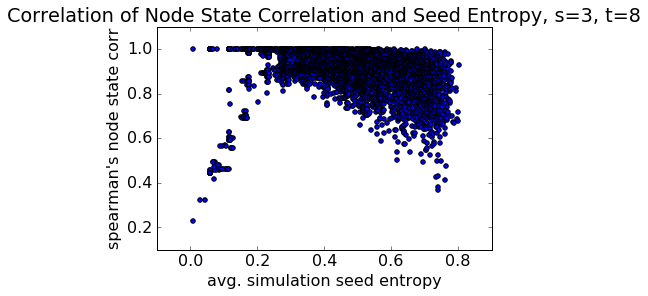

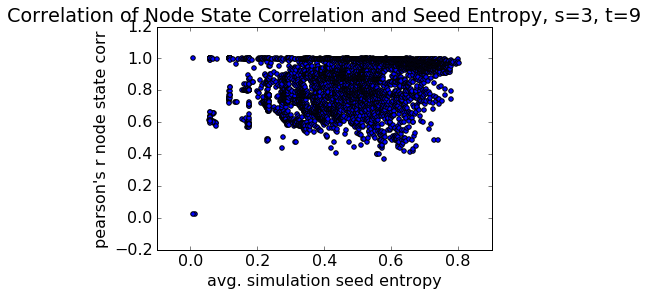

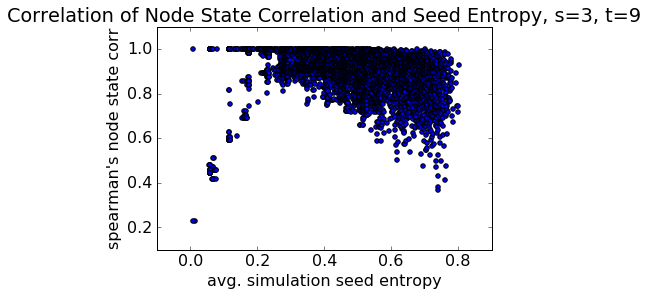

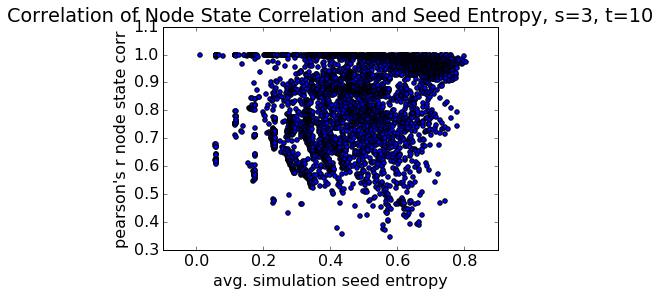

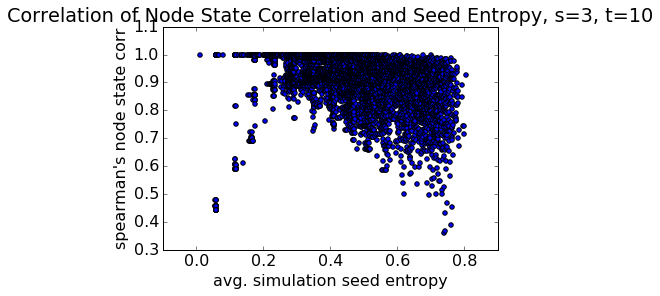

In [192]:
#graph actual values of correlation vs. seed entropy
for i in xvalues:
    #pearson's r
    plt.scatter([seed_entropy_sim[seed][i] for seed in sorted(seeds,key=lambda x: seed_entropy_sim[x][t]) if
                                     seed_entropy_sim[seed][i]>0],pcorrelations[i])
    plt.ylabel("pearson's r node state corr")
    plt.xlabel("avg. simulation seed entropy")
    plt.title("Correlation of Node State Correlation and Seed Entropy, s=%d, t=%d" % (length,i))
    plt.show()
    #spearman's rho
    plt.scatter([seed_entropy_sim[seed][i] for seed in sorted(seeds,key=lambda x: seed_entropy_sim[x][t]) if
                                     seed_entropy_sim[seed][i]>0],scorrelations[i])
    plt.ylabel("spearman's node state corr")
    plt.xlabel("avg. simulation seed entropy")
    plt.title("Correlation of Node State Correlation and Seed Entropy, s=%d, t=%d" % (length,i))
    plt.show()

In [235]:
#correlation of entropy of rank order of seed influence
length=2
seeds=reduce_seeds(dmodules,dsunit_map,dtranslator,length=length)
seed_entropy,seed_configs=seed_entropies(dact_prob_sim,seeds,normalized=True,data=False) #simulations
seed_entropy2,seed_configs2=seed_entropies(dmodules,seeds,normalized=True,data=False) #approximation
sn=sorted([seed for seed in seeds],key=lambda x: seed_entropy2[x][10])
#for seed in sn: print to_list(seed,dsunit_map,dtranslator),seed_entropy2[seed][10]

1 (0.97380096101787605, 0.0)
2 (0.98809483496295447, 0.0)
3 (0.97926579072787667, 0.0)
4 (0.96568513396169997, 1.6138160255758477e-319)
5 (0.94834176722778174, 2.0785272596105831e-272)
6 (0.92674484934009527, 1.3370627272754258e-232)
7 (0.9106570752448806, 3.2587445877886468e-210)
8 (0.9029655618038207, 5.7754758534423509e-201)
9 (0.90164439903938165, 1.8711950675137946e-199)
10 (0.90063257255220508, 2.5974477297035125e-198)


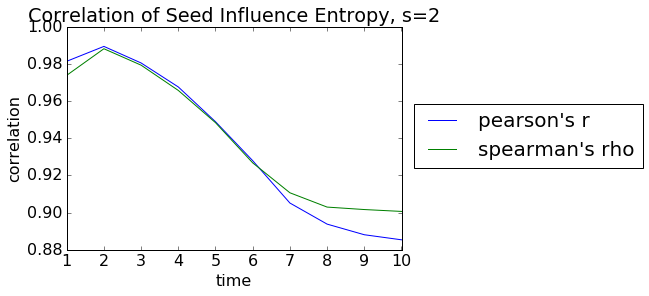

In [237]:
for t in range(1,iterations+1): #not defined at 0 because all values are 0.5 for the mf-approximation
    print t,spearmanr([seed_entropy[seed][t] for seed in seeds],[seed_entropy2[seed][t] for seed in seeds])
    #print 'sim',[to_list(seed,dsunit_map,dtranslator)[0] for seed in sorted([seed for seed in seeds],key=lambda x: seed_entropy[x][t])]
    #print [round(seed_entropy[seed][t],2) for seed in sorted([seed for seed in seeds],key=lambda x: seed_entropy[x][t])]
    #print 'mf',[to_list(seed,dsunit_map,dtranslator)[0] for seed in sorted([seed for seed in seeds],key=lambda x: seed_entropy2[x][t])]
    #print [round(seed_entropy2[seed][t],2) for seed in sorted([seed for seed in seeds],key=lambda x: seed_entropy2[x][t])]
    
#plot correlation of seed influence
xvalues=range(1,iterations+1)
yvalues=[pearsonr([seed_entropy[seed][t] for seed in seeds],[seed_entropy2[seed][t] for seed in seeds])[0] for t in xvalues]
y1values=[spearmanr([seed_entropy[seed][t] for seed in seeds],[seed_entropy2[seed][t] for seed in seeds])[0] for t in xvalues]
plt.plot(xvalues,yvalues,label="pearson's r")
plt.plot(xvalues,y1values,label="spearman's rho")
plt.xlabel("time")
plt.ylabel("correlation")
plt.title("Correlation of Seed Influence Entropy, s=%d" % length)
plt.legend(bbox_to_anchor=(1.75, 0.7), fontsize=20)

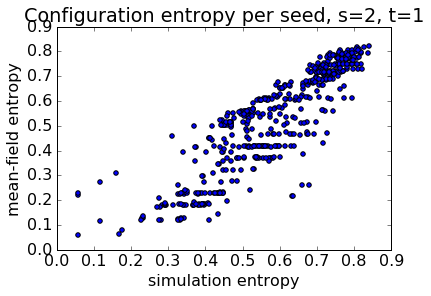

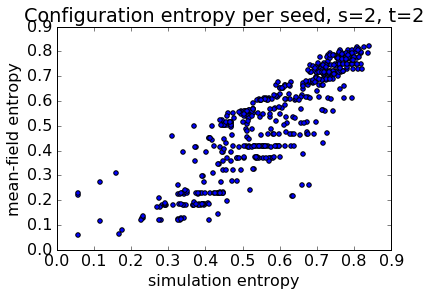

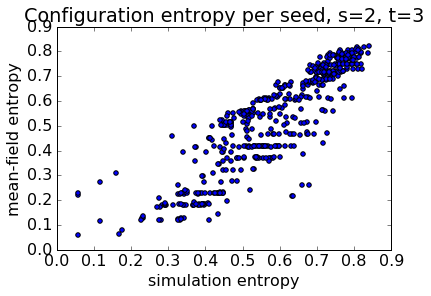

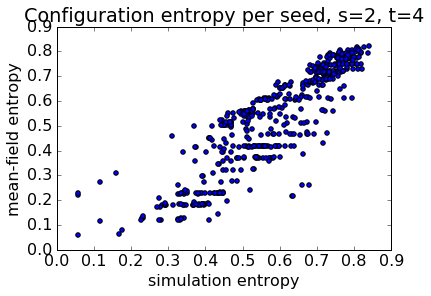

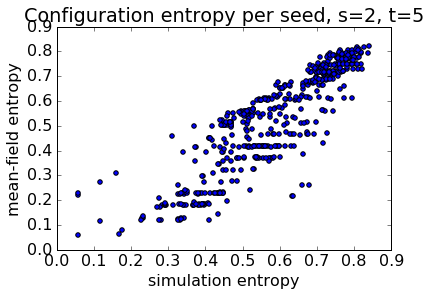

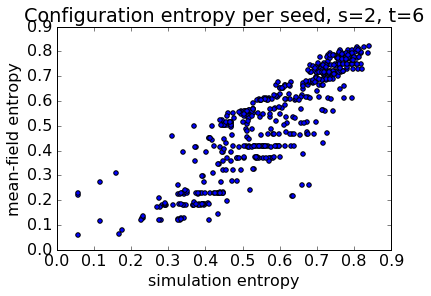

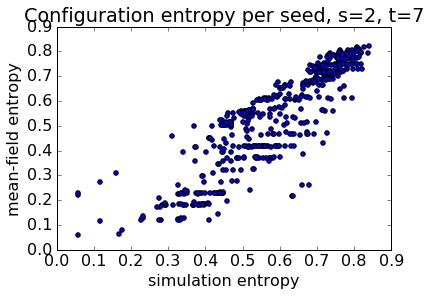

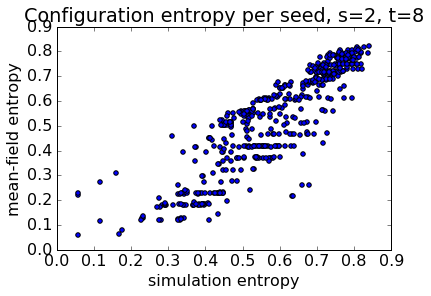

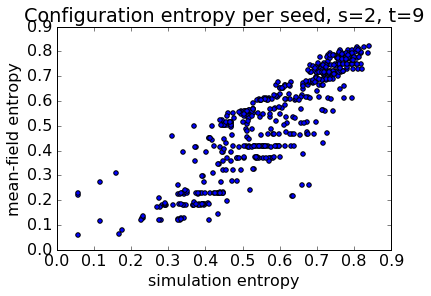

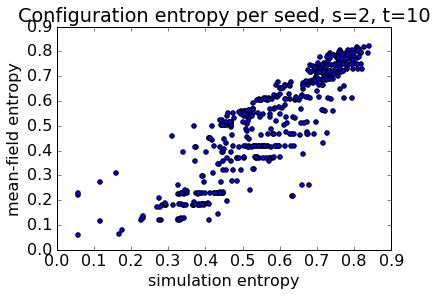

In [240]:
#plot actual values of approximation vs. simulation entropies
for i in xvalues:
    plt.scatter([seed_entropy[seed][t] for seed in seeds],[seed_entropy2[seed][t] for seed in seeds])
    plt.xlabel("simulation entropy")
    plt.ylabel("mean-field entropy")
    plt.title("Configuration entropy per seed, s=%d, t=%d" % (length,i))
    plt.show()

In [837]:
#analyze attractors for drosophila
dattractors=attractors_to_dict(ND)
print dattractors

{'11100001111111010': set(['nhhnHH-1', 'nWG-0', 'hh-0', 'CIR-0', 'EN-0', 'SMO-1', 'ptc-1', 'PTC-1', 'CI-1', 'ci-1', 'HH-0', 'wg-1', 'WG-1', 'SLP-1', 'PH-1', 'CIA-1', 'en-0']), '01100001111111010': set(['nhhnHH-1', 'nWG-0', 'hh-0', 'CIR-0', 'EN-0', 'SMO-1', 'ptc-1', 'PTC-1', 'CI-1', 'ci-1', 'HH-0', 'WG-1', 'SLP-0', 'wg-1', 'PH-1', 'CIA-1', 'en-0']), '11100001111111011': set(['nhhnHH-1', 'hh-0', 'CIR-0', 'EN-0', 'SMO-1', 'ptc-1', 'PTC-1', 'CI-1', 'ci-1', 'HH-0', 'wg-1', 'WG-1', 'SLP-1', 'PH-1', 'CIA-1', 'en-0', 'nWG-1']), '00011110001000011': set(['hh-1', 'PH-0', 'CIR-0', 'nWG-1', 'ptc-0', 'PTC-0', 'wg-0', 'CI-0', 'HH-1', 'CIA-0', 'SMO-1', 'ci-0', 'WG-0', 'nhhnHH-1', 'en-1', 'SLP-0', 'EN-1']), '10000000100110101': set(['hh-0', 'CIR-1', 'ptc-0', 'en-0', 'CI-1', 'CIA-0', 'nWG-1', 'ci-1', 'HH-0', 'SLP-1', 'wg-0', 'SMO-0', 'PTC-1', 'PH-0', 'nhhnHH-0', 'EN-0', 'WG-0']), '00011110001000001': set(['hh-1', 'PH-0', 'CIR-0', 'nWG-1', 'ptc-0', 'PTC-0', 'wg-0', 'CI-0', 'HH-1', 'CIA-0', 'SMO-1', 'ci-

In [471]:
#del dmodules['(0, 3, 5, 8, 31, 32)']
seed='(0, 7, 31, 33)' #selections[10]
seed=(0, 3, 5, 8, 31, 32)
print seed,reduce_selection(seed,ND,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=10)
print seed,reduce_selection_simulations(seed,ND,dsunits,dsunit_map,dtranslator,t=10,length=6,act_prob_sim=dact_prob_sim)

(0, 3, 5, 8, 31, 32) (0, 3, 31, 32)
(0, 3, 5, 8, 31, 32) (0, 31, 32)


In [83]:
#compare to FVS drivers
dfvs=fvs_set(ND)
for x in sorted(dfvs): 
    #print x,dsunit_map[dtranslator[x][0]]
    seed_entropy,seed_configs=config_entropy(dmodules[x],base=2,normalized=True)
    print x,dsunit_map[dtranslator[x][0]],seed_entropy[10]

(0,) SLP-0 0.7222275070035824
(1,) SLP-1 0.5687666798206945
(16,) PTC-0 0.8782294015117814
(17,) PTC-1 0.8776839626372809
(2,) wg-0 0.8778738900807991
(3,) wg-1 0.8778901834714139
(30,) nhhnHH-0 0.5509761315269198
(31,) nhhnHH-1 0.7238683644061636
(32,) nWG-0 0.5588149602092368
(33,) nWG-1 0.83281351590204


In [89]:
#determine selections based on top x chosen; resolves s=3 at top x=8
selections,entropies=top_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dd,
                pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False,pin_start=False)
for seed in selections: print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator)
print reduce_selection(seed,ND,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=10)
#for seed in sorted(entropies,key=lambda x: entropies[x])[:top]: print seed,entropies[seed]

6661 6661
() 0.8778820413116638 []
(30,) 0.5509761315269198 ['nhhnHH-0']
(30, 32) 0.22058292571420166 ['nhhnHH-0', 'nWG-0']
(17, 30, 32) 0.058823529411764705 ['PTC-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 23, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'ci-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 23, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'ci-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 23, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'ci-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 23, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'ci-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 23, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'ci-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 23, 30, 32) 0.0 ['SLP-0', 'PTC-1', 'ci-1', 'nhhnHH-0', 'nWG-0']
(0, 17, 30, 32)


In [950]:
#determine selections based on different updating schemes
selections,entropies=top_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dd,
        iterations=10,attractor=None,attractors=dattractors,force=False,pin_start=True,update='synchronous',regenerate=False)
for seed in selections: print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator)
print reduce_selection(seed,ND,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=10)

1142 1197
() 0.8778820413116638 []
(7,) 0.18641653786297874 ['en-1']
(0, 7) 0.12060489322658603 ['SLP-0', 'en-1']
(0, 7, 31) 0.058823529411764705 ['SLP-0', 'en-1', 'nhhnHH-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 7, 31, 33) 0.0 ['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1']
(0, 31, 33)


In [118]:
#average over different models
#davg_drivers={'synchronous':{},'deterministic asynchronous':{},'stochastic without replacement':{},'stochastic with replacement':{}}
models=100
key='stochastic with replacement'
for m in range(models):
    print m
    selection=driver_selection(ND,dsunits,dsunit_map,{},dtranslator,attractor=None,attractors=None,
                               update='stochastic asynchronous',order=None,regenerate=True)
    print selection
    davg_drivers[key].setdefault(str(selection),0)
    davg_drivers[key][str(selection)]+=1
davg_drivers[key]

0
35 371
(0, 31, 33)
1
35 371
(0, 31, 33)
2
35 371
(0, 7, 31, 33)
3
35 371
(0, 9, 31, 32)
4
35 508
(0, 31, 33)
5
35 508
(0, 7, 31, 33)
6
35 508
(0, 7, 31, 33)
7
35 508
(0, 7, 31, 32)
8
35 508
(0, 9, 31, 32)
9
35 508
(0, 31, 33)
10
35 508
(0, 31, 33)
11
35 508
(0, 31, 33)
12
35 508
(0, 31, 33)
13
35 508
(0, 7, 31, 32)
14
35 508
(0, 7, 31, 32)
15
35 508
(0, 31, 33)
16
35 508
(0, 31, 33)
17
35 508
(0, 7, 31, 33)
18
35 508
(0, 31, 33)
19
35 508
(0, 31, 33)
20
35 508
(0, 7, 31, 32)
21
35 531
(0, 31, 33)
22
35 531
(0, 9, 31, 32)
23
35 557
(0, 31, 33)
24
35 557
(0, 31, 33)
25
35 557
(0, 31, 33)
26
35 557
(1, 27, 31, 32)
27
35 633
(0, 9, 31, 32)
28
35 633
(0, 31, 33)
29
35 633
(0, 31, 33)
30
35 633
(0, 31, 33)
31
35 633
(0, 31, 33)
32
35 681
(0, 31, 33)
33
35 681
(0, 7, 31, 32)
34
35 681
(0, 9, 31, 32)
35
35 681
(0, 31, 33)
36
35 681
(0, 31, 33)
37
35 681
(0, 24, 31, 32)
38
35 684
(0, 31, 33)
39
35 684
(0, 7, 31, 33)
40
35 684
(0, 31, 33)
41
35 684
(0, 31, 33)
42
35 684
(0, 9, 31, 32)
43
35 68

{'(0, 15, 30, 32)': 1,
 '(0, 24, 31, 32)': 2,
 '(0, 31, 33)': 63,
 '(0, 7, 31, 32)': 10,
 '(0, 7, 31, 33)': 11,
 '(0, 9, 31, 32)': 12,
 '(1, 27, 31, 32)': 1}

In [121]:
print dsunit_map

{0: 'SLP-0', 1: 'SLP-1', 2: 'wg-0', 3: 'wg-1', 4: 'WG-0', 5: 'WG-1', 6: 'en-0', 7: 'en-1', 8: 'EN-0', 9: 'EN-1', 10: 'hh-0', 11: 'hh-1', 12: 'HH-0', 13: 'HH-1', 14: 'ptc-0', 15: 'ptc-1', 16: 'PTC-0', 17: 'PTC-1', 18: 'PH-0', 19: 'PH-1', 20: 'SMO-0', 21: 'SMO-1', 22: 'ci-0', 23: 'ci-1', 24: 'CI-0', 25: 'CI-1', 26: 'CIA-0', 27: 'CIA-1', 28: 'CIR-0', 29: 'CIR-1', 30: 'nhhnHH-0', 31: 'nhhnHH-1', 32: 'nWG-0', 33: 'nWG-1'}


Text(0,0.5,'proportion of driver sets')

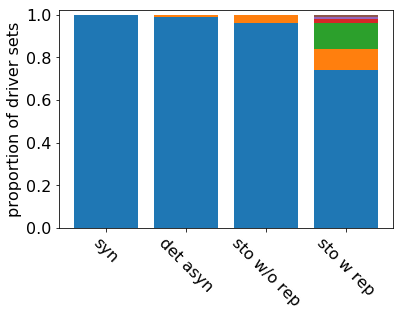

In [125]:
#graph attractor basins for the unconstrained greedy selection process
xvalues=[0,1,2,3]
yvalues=[1,0.99,0.96,0.74] #(0, 31, 33) [1,1,1,0.8] [1,0.99,0.96,0.74] -> attractor 4
yvalues1=[0,0.01,0.04,0.1] #(0, 7, 31, 32) [1-y for y in yvalues] [0,0.01,0.04,0.1] -> new attractor
yvalues2=[0,0,0,0.12] #(0, 9, 31, 32) -> new attractor
yvalues3=[0,0,0,0.02] #(0, 24, 31, 32) -> new attractor
yvalues4=[0,0,0,0.01] #(0, 15, 30, 32) -> new attractor
yvalues5=[0,0,0,0.01] #(1, 27, 31, 32) -> attractor 2 or 7?
plt.bar(xvalues,yvalues,label='Attractor 4')
plt.bar(xvalues,yvalues1,bottom=yvalues,label='New Attractor')
plt.bar(xvalues,yvalues2,bottom=[yvalues[i]+yvalues1[i] for i in range(4)])
plt.bar(xvalues,yvalues3,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i] for i in range(4)])
plt.bar(xvalues,yvalues4,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i]+yvalues3[i] for i in range(4)])
plt.bar(xvalues,yvalues5,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i]+yvalues3[i]+yvalues4[i] for i in range(4)])
plt.ylim([0.0,1.02])
plt.xticks(xvalues,['syn','det asyn','sto w/o rep','sto w rep'],rotation=-45)
plt.ylabel("proportion of driver sets")
#plt.legend()

In [154]:
#determine top selections for attractors
iterations=10
t=iterations
for i,attractor in enumerate(dattractors):
    selections,entropies=top_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=20,top=1,reduced=True, t=t,
    ds=dd,attractor=attractor,attractors=dattractors,pin_start=False,force=True,iterations=iterations)
    #use xs to dynamically choose the best strategy, top=xs[i]
    exec('a'+str(i)+'=[entropies[x] for x in selections]') #entropy of selection
    exec('sa'+str(i)+'=[x for x in selections]') #selection
    exec('rsa'+str(i)+'=[]') #reduced selection
    print attractor #,eval('a'+str(i))
    for seed in selections: 
        print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator),
        print to_list(reduce_selection(seed,ND,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=t,iterations=iterations,
                                      pin_start=False),dsunit_map)
        rs=reduce_selection(seed,ND,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=t,iterations=iterations,
                                      pin_start=False)
        exec('rsa'+str(i)+'.append(rs)')
        if entropies[seed]==0.0: break #no need to print out the rest

8982 8982
11100001111111010
() 0.8778820413116638 [] []
(32,) 0.5588149602092368 ['nWG-0'] ['nWG-0']
(31, 32) 0.07790944168135353 ['nhhnHH-1', 'nWG-0'] ['nhhnHH-1', 'nWG-0']
(1, 31, 32) 0.0 ['SLP-1', 'nhhnHH-1', 'nWG-0'] ['SLP-1', 'nhhnHH-1', 'nWG-0']
8982 8982
01100001111111010
() 0.8778820413116638 [] []
(32,) 0.5588149602092368 ['nWG-0'] ['nWG-0']
(31, 32) 0.07790944168135353 ['nhhnHH-1', 'nWG-0'] ['nhhnHH-1', 'nWG-0']
(0, 31, 32) 0.007754636746263728 ['SLP-0', 'nhhnHH-1', 'nWG-0'] ['SLP-0', 'nhhnHH-1', 'nWG-0']
(0, 5, 31, 32) 0.007754636746263728 ['SLP-0', 'WG-1', 'nhhnHH-1', 'nWG-0'] ['SLP-0', 'nhhnHH-1', 'nWG-0']
(0, 5, 12, 31, 32) 0.007754636746263728 ['SLP-0', 'WG-1', 'HH-0', 'nhhnHH-1', 'nWG-0'] ['SLP-0', 'nhhnHH-1', 'nWG-0']
(0, 5, 11, 12, 31, 32) 0.007754636746263728 ['SLP-0', 'WG-1', 'hh-1', 'HH-0', 'nhhnHH-1', 'nWG-0'] ['SLP-0', 'nhhnHH-1', 'nWG-0']
(0, 5, 11, 12, 15, 31, 32) 0.007754636746263728 ['SLP-0', 'WG-1', 'hh-1', 'HH-0', 'ptc-1', 'nhhnHH-1', 'nWG-0'] ['SLP-0', 'nh

In [52]:
#check on attractors that require different top x strategies
attractor0='11100001111111010' #top x=1, s=3
attractor1='01100001111111010' #top x=1, s=4
attractor2='11100001111111011' #top x=1, s=3
attractor3='00011110001000011' #top x=8, s=3
attractor4='10000000100110101' #top x=9, s=4
attractor5='00011110001000001' #top x=9, s=4
attractor6='00000001111111010' #top x=1, s=4
attractor7='00011110100000001' #top x=15, s=4
attractor8='00000000100110100' #top x=7, s=4
attractor9='10000000100110100' #top x=10, s=4
xs=[1,1,1,8,9,9,1,15,7,10] #parallel array, how many top x we need to consider to be optimal
ss=[3,4,3,3,4,4,4,4,4,4] #parallel array, how large a seed size we need to be optimal

#attractors=[attractor7]

In [110]:
a5.append(0)

(-0.01, 0.9)

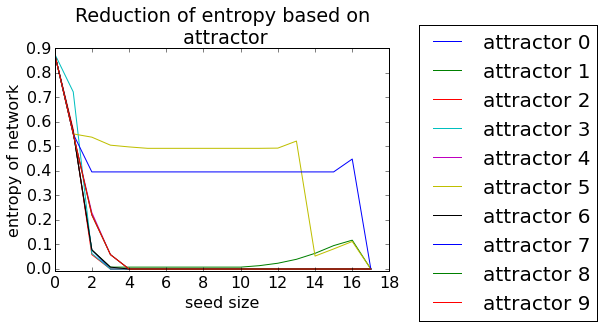

In [111]:
#graph attractors based on mf estimates
xvalues=range(18)
for i in range(len(dattractors)):
    plt.plot(xvalues,eval('a'+str(i)),label='attractor '+str(i)) #given top x value
    #plt.plot(xvalues,eval('a'+str(i)),label='attractor '+str(i)+', x='+str(xs[i])) #best over top x values
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.65, 1.15), fontsize=20)
plt.title("Reduction of entropy based on \n attractor")#, top x=1")
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [286]:
#dact_prob_sim={}
#entropies_sim={}

In [287]:
#entropy of strategy; requires a and sa variables above
for i,strategy in enumerate([sa0,sa1,sa2,sa3,sa4,sa5,sa6,sa7,sa8,sa9]):
    print 'a'+str(i)
    entropies_sim=strategy_entropy(strategy,ND,dsunit_map,dmodules,dtranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=dstats,results=False,time_limit=12,act_prob_sim=dact_prob_sim,entropies_sim=entropies_sim,t=10)
    for j,seed in enumerate(strategy): print to_list(seed,dsunit_map,dtranslator), eval('a'+str(i)+'['+str(j)+']'), entropies_sim[seed]

a0
[] 0.877882041312 0.868455697904
['nWG-0'] 0.558814960209 0.518842797065
['nhhnHH-1', 'nWG-0'] 0.0779094416814 0.176096983125
['SLP-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'PH-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'PTC-1', 'PH-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'ptc-1', 'PTC-1', 'PH-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'hh-0', 'ptc-1', 'PTC-1', 'PH-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'hh-0', 'ptc-1', 'PTC-1', 'PH-1', 'CI-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-1', 'WG-1', 'hh-0', 'HH-0', 'ptc-1', 'PTC-1', 'PH-1', 'CI-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
a1
[] 0.877882041312 0.868455697904
['nWG-0'] 0.558814960209 0.518842797065
['nhhnHH-1', 'nWG-0'] 0.0779094416814 0.176096983125
['SLP-0', 'nhhnHH-1', 'nWG-0'] 0.00775463674626 0.0
['SLP-0', 'wg-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-0', 'wg-1', 'ci-1', 'nhhnHH-1', 'nWG-0'] 0.0 0.0
['SLP-0', 'wg-1', 'hh-0', 'ci-1', 'nhhnHH-1

(-0.01, 0.9)

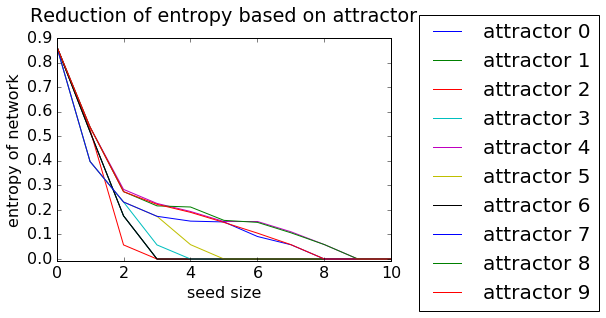

In [288]:
#graph attractors based on simulations of mf selections
xvalues=range(11)
for i in range(len(dattractors)):
    plt.plot(xvalues,[entropies_sim[seed] for seed in eval('sa'+str(i))],label='attractor '+str(i))
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.65, 1.15), fontsize=20)
plt.title("Reduction of entropy based on attractor",y=1.05)
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [302]:
#entropy of random seed selections averaged over multiple samples for different attractors
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s
#selections_rnd,entropies=random_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,entropies=entropies,
#                            reduced=True,ds=dd,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True)
for i,attractor in enumerate(dattractors): 
    selections_ls,avg=avg_random_selections(ND,dsunits,dsunit_map,dmodules,dtranslator,samples=samples,seeds=None,max_s=10,entropies=entropies,
        reduced=True,ds=dd,t=10,runs=runs,stats=dstats,act_prob_sim=dact_prob_sim,entropies_sim=entropies_sim,attractor=attractor,attractors=dattractors)
    exec('davg'+str(i)+'=[avg[x] for x in avg]') #entropy of selection
    print avg,len(selections_ls)

{0: 0.86845569790400101, 1: 0.7097024800292594, 2: 0.60084219862593402, 3: 0.50150996294973982, 4: 0.43355973519736701, 5: 0.34529094272655897, 6: 0.28563691113684686, 7: 0.22601769702058164, 8: 0.1866337383872429, 9: 0.15044917108023972, 10: 0.12879924629448125} 100
{0: 0.86845569790400101, 1: 0.6899868968753633, 2: 0.582640866428347, 3: 0.47731943808403471, 4: 0.40590736772743319, 5: 0.34071052552946568, 6: 0.2740866504787357, 7: 0.22859813662348386, 8: 0.18320323049022399, 9: 0.14611675218877515, 10: 0.11425740185448655} 100
{0: 0.86845569790400101, 1: 0.68879540375227988, 2: 0.56101351979735736, 3: 0.46160198500837379, 4: 0.40942298065748689, 5: 0.33067162800886463, 6: 0.26185929119683427, 7: 0.20992089911373923, 8: 0.17208617703509141, 9: 0.1378216887412741, 10: 0.11359666522800958} 100
{0: 0.86845569790400101, 1: 0.70274016101947179, 2: 0.59085897750386773, 3: 0.48045018619429314, 4: 0.40367089408590273, 5: 0.33429343383173232, 6: 0.27177137029307469, 7: 0.21884853478963162, 8: 0

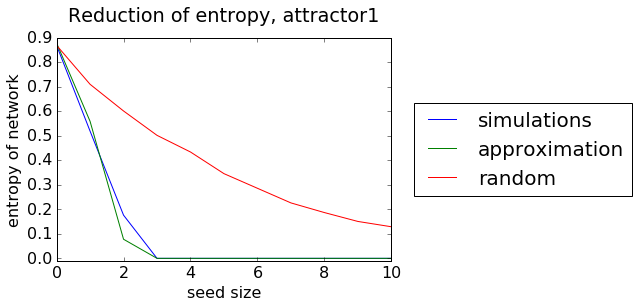

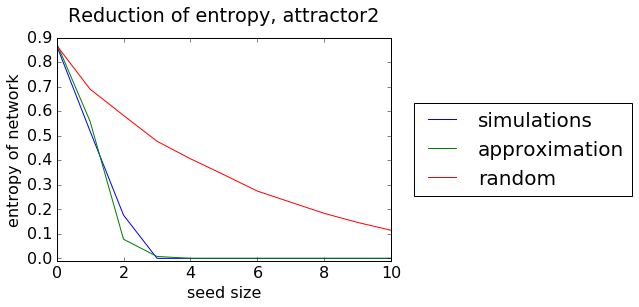

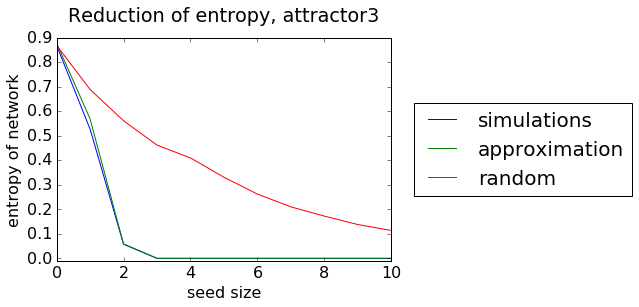

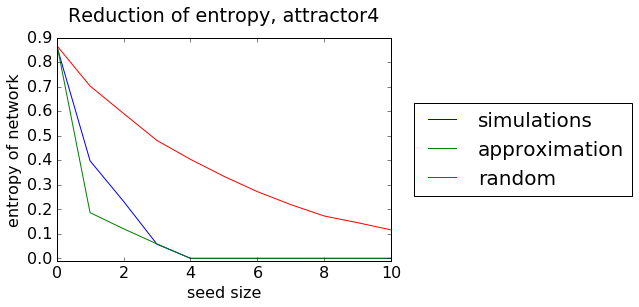

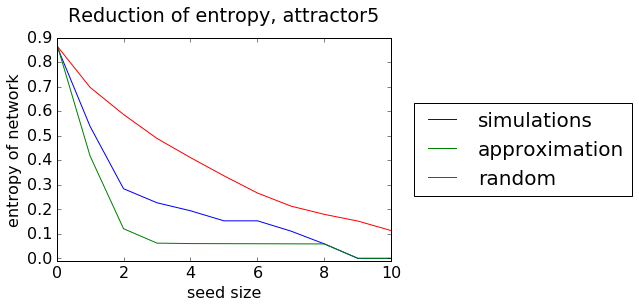

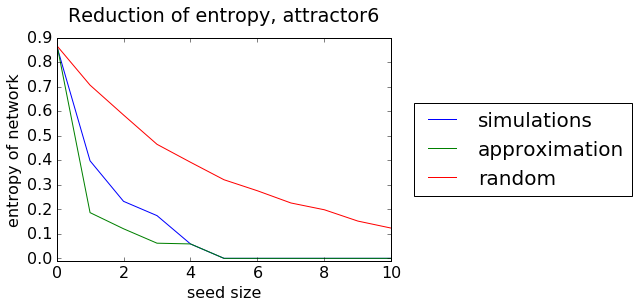

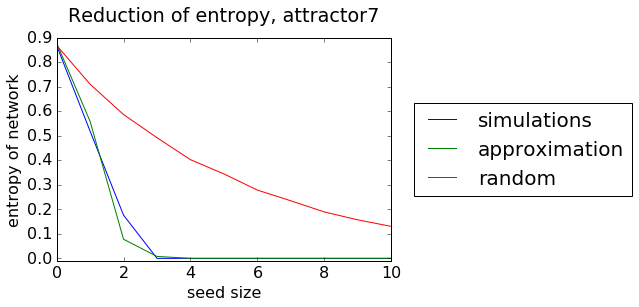

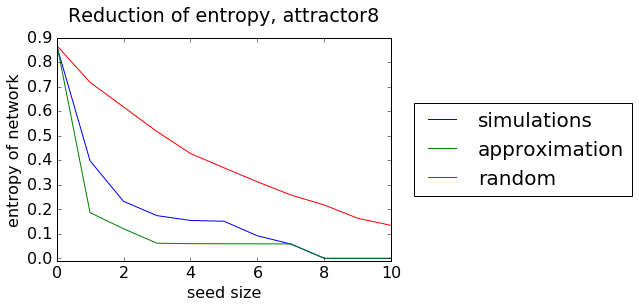

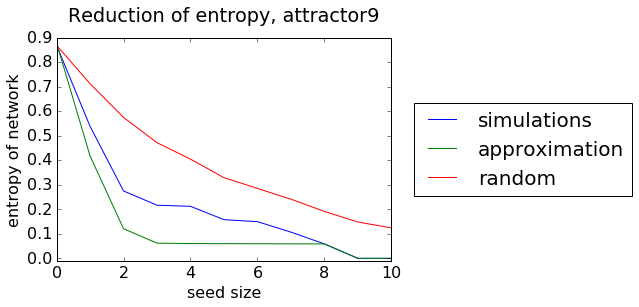

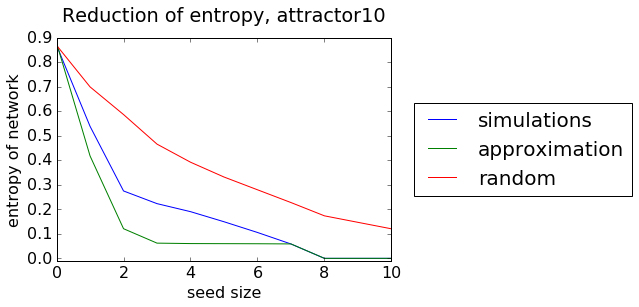

In [304]:
#graph single attractor to compare approximation with simulations of mf selections
xvalues=range(11)
for i in range(len(dattractors)):
    plt.plot(xvalues,[entropies_sim[seed] for seed in eval('sa'+str(i))],label='simulations')
    plt.plot(xvalues,eval('a'+str(i)),label='approximation')
    plt.plot(xvalues,eval('davg'+str(i)),label='random')
    plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20)
    plt.title("Reduction of entropy, attractor"+str(i+1),y=1.05)
    plt.ylabel("entropy of network")
    plt.xlabel("seed size")
    plt.yticks(np.arange(0,1,.1))
    plt.ylim([-.01,0.9])
    plt.show()

In [62]:
#selections_rnd,entropies=random_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,
#                                          entropies=entropies,reduced=True,ds=dd,attractor=None,attractors=None)

In [84]:
#entropy of strategy; selections or selections_rnd
entropies_sim=strategy_entropy(selections,ND,dsunit_map,dmodules,dtranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=dstats,results=False,time_limit=12,act_prob_sim=dact_prob_sim,entropies_sim=entropies_sim,t=10)
for seed in selections: print to_list(seed,dsunit_map,dtranslator), entropies[seed], entropies_sim[seed]

[] 0.877882041312 0.899176327393
['en-1'] 0.186416537863 0.392360021982
['SLP-0', 'en-1'] 0.120604893227 0.226109493221
['SLP-0', 'en-1', 'nhhnHH-1'] 0.0588235294118 0.0582110306601
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0
['SLP-0', 'en-1', 'nhhnHH-1', 'nWG-1'] 0.0 0.0


In [654]:
#entropy of random seed selections averaged over multiple samples
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s
#selections_rnd,entropies=random_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,entropies=entropies,
#                            reduced=True,ds=dd,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True)
selections_ls,avg=avg_random_selections(ND,dsunits,dsunit_map,dmodules,dtranslator,samples=samples,seeds=None,max_s=10,entropies=entropies,
                      reduced=True,ds=dd,t=10,runs=runs,stats=dstats,act_prob_sim=dact_prob_sim,entropies_sim=entropies_sim)
#print selections_rnd,len(entropies),len(entropies_sim)
print avg,len(selections_ls)

{0: 0.88033439727280549, 1: 0.71547521879168885, 2: 0.59221683361830468, 3: 0.47743704460946873, 4: 0.40046065460869246, 5: 0.35337635285912106, 6: 0.29919824911561149, 7: 0.22773605669967212, 8: 0.18455349804156307, 9: 0.14592900054900379, 10: 0.11728803073319512} 100


In [731]:
#top x
xvalues=[s for s in range(max_s+1)]
exec('top'+str(top)+'=[entropies_sim[x] for x in selections]') #base on 'ground truth' simulations
#yrnd=[entropies_sim[x] for x in selections_rnd] #single random sample
yrnd=[avg[x] for x in avg] #average of multiple random samples
print top1,yrnd
print top8

[0.88033439727280682, 0.3840984011569874, 0.2317298975779489, 0.058755619764423631, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] [0.88033439727280549, 0.71547521879168885, 0.59221683361830468, 0.47743704460946873, 0.40046065460869246, 0.35337635285912106, 0.29919824911561149, 0.22773605669967212, 0.18455349804156307, 0.14592900054900379, 0.11728803073319512]
[0.88033439727280682, 0.3840984011569874, 0.17645759988859164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


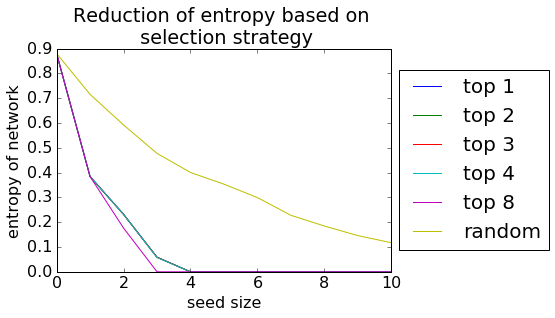

In [857]:
#plot entropy reduction
for i in range(1,5):
    plt.plot(xvalues,eval('top'+str(i)),label='top '+str(i))
plt.plot(xvalues,top8,label='top 8') #reduces to 0 entropy faster
plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.5, 0.95), fontsize=20)
plt.title("Reduction of entropy based on \n selection strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")

In [541]:
#create translator entries for missing seeds
#dtranslator={}
dtranslator=create_translator(ND,s=4,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator,seeds=None,samples=None)
#seeds=[(1, 4, 8, 12, 20, 22, 25, 30, 33)]
len(dtranslator)
#dtranslator['(1, 4, 8, 12, 20, 25, 26, 30, 33)']

seeds: 46376


52955

In [649]:
#employ a greedy strategy based on simulations for comparison
#determine top selections for attractors
iterations=10
t=iterations
for i,attractor in enumerate(dattractors):
    selections,entropies=top_selection_simulations(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,top=1,reduced=True,t=t,
    ds=dd,attractor=attractor,attractors=dattractors,pin_start=True,force=True,iterations=iterations,simulations=dsimulations,act_prob_sim=dact_prob_sim)
    #selections,entropies=top_selection_simulations(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,top=1,reduced=True, t=t,
    #ds=dd,attractor=attractor,attractors=dattractors,pin_start=True,force=True,iterations=iterations)
    exec('asim'+str(i)+'=[entropies[x] for x in selections]') #entropy of selection
    exec('sasim'+str(i)+'=[x for x in selections]') #selection
    print attractor #,eval('a'+str(i))
    for j,seed in enumerate(selections): 
        print seed, entropies[seed], to_list(seed,dsunit_map,dtranslator),
        print to_list(reduce_selection_simulations(seed,ND,dsunits,dsunit_map,dtranslator,t=t,iterations=iterations,length=j),dsunit_map)
        if entropies[seed]==0.0: break #no need to print out the rest

596 781
11100001111111010
() 0.865669319243 [] []
(32,) 0.508976558465 ['nWG-0'] ['nWG-0']
(31, 32) 0.17519549188 ['nhhnHH-1', 'nWG-0'] ['nhhnHH-1', 'nWG-0']
(1, 31, 32) 0.0 ['SLP-1', 'nhhnHH-1', 'nWG-0'] ['SLP-1', 'nhhnHH-1', 'nWG-0']
596 965
01100001111111010
() 0.886890532438 [] []
(32,) 0.509775549401 ['nWG-0'] ['nWG-0']
(31, 32) 0.17519549188 ['nhhnHH-1', 'nWG-0'] ['nhhnHH-1', 'nWG-0']
(3, 31, 32) 0.0587556197644 ['wg-1', 'nhhnHH-1', 'nWG-0'] ['wg-1', 'nhhnHH-1', 'nWG-0']
(0, 3, 31, 32) 0.0 ['SLP-0', 'wg-1', 'nhhnHH-1', 'nWG-0'] ['SLP-0', 'wg-1', 'nhhnHH-1', 'nWG-0']
596 1118
11100001111111011
() 0.893878253343 [] []
(1,) 0.52927597259 ['SLP-1'] ['SLP-1']
(1, 31) 0.0587556197644 ['SLP-1', 'nhhnHH-1'] ['SLP-1', 'nhhnHH-1']
(1, 31, 33) 0.0 ['SLP-1', 'nhhnHH-1', 'nWG-1'] ['SLP-1', 'nhhnHH-1', 'nWG-1']
596 1301
00011110001000011
() 0.844735477639 [] []
(7,) 0.390959209678 ['en-1'] ['en-1']
(0, 7) 0.233285532304 ['SLP-0', 'en-1'] ['SLP-0', 'en-1']
(0, 7, 31) 0.0588235294118 ['SLP-0', '

In [722]:
#check the similarity between driver sets chosen by the approximation and by the simulations
asets,ssets=[],[]
for i,attractor in enumerate(dattractors):
    for j,evalue in enumerate(eval('a'+str(i))):
        if evalue==0:
            #print attractor,j,eval('a'+str(i)+'[j]'),dtranslator[eval('sa'+str(i)+'[j]')]#,entropies_sim[eval('sa'+str(i)+'[j]')]
            try: dtranslator[eval('sa'+str(i)+'[j]')]
            except KeyError: #dtranslator key error
                create_translator(ND,s=1,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator,seeds=[eval('sa'+str(i)+'[j]')])
            #reduce selection for the solution
            seed=eval(eval('sa'+str(i)+'[j]'))
            sel=reduce_selection(seed,ND,dsunits,dsunit_map,dmodules,dtranslator,reduced=True,ds=dd,t=t,iterations=iterations)
            asets.append({s for s in sel})
            break
    for k,evalue in enumerate(eval('asim'+str(i))):
        if evalue==0:
            #print attractor,k,eval('asim'+str(i)+'[k]'),dtranslator[eval('sasim'+str(i)+'[k]')]
            seed=eval(eval('sasim'+str(i)+'[k]'))
            sel=reduce_selection_simulations(seed,ND,dsunits,dsunit_map,dtranslator,t=t,iterations=iterations,length=k)
            ssets.append({s for s in sel})
            break
jmeasures=[]
for set1,set2 in zip(asets,ssets):
    print set1,set2,compute_jaccard(set1,set2)
    jmeasures.append(compute_jaccard(set1,set2))

set([32, 1, 31]) set([32, 1, 31]) 1.0
set([0, 32, 3, 31]) set([0, 32, 3, 31]) 1.0
set([1, 33, 31]) set([1, 33, 31]) 1.0
set([0, 33, 31]) set([0, 33, 31]) 1.0
set([1, 33, 30, 17]) set([1, 30, 33]) 0.75
set([0, 16, 30, 33]) set([0, 16, 30, 33]) 1.0
set([0, 32, 2, 31]) set([0, 32, 31]) 0.75
set([0, 17, 30, 33]) set([0, 17, 30, 33]) 1.0
set([0, 17, 30, 32]) set([0, 32, 30]) 0.75
set([32, 1, 30, 17]) set([32, 1, 30]) 0.75


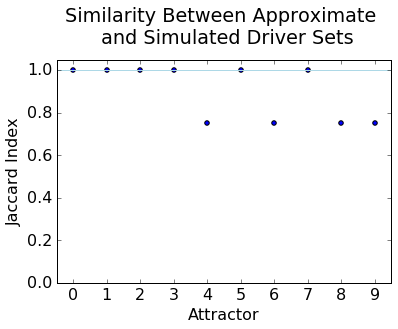

In [751]:
#graph differences in driver sets chosen via the Jaccard measure
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Approximate \n and Simulated Driver Sets",y=1.05)

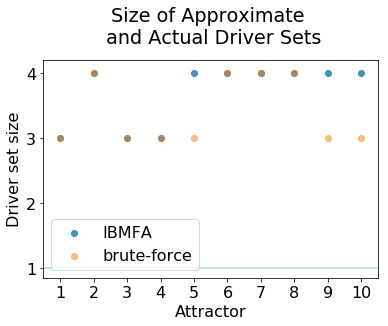

In [991]:
#compare brute-force solutions with the mean-field approximation (G1 solution is the same)
mf_solutions=[{1,32,31},{0,32,31,3},{1,33,31},{0,33,31},{1,33,30,17},{0,33,30,16},{0,32,31,2},{0,33,30,17},{0,32,30,17},{1,32,30,17}]
bf_solutions=[{1,32,31},{0,32,31,3},{1,33,31},{0,33,31},{1,33,30},{0,33,30,16},{0,32,31,2},{0,33,30,17},{0,32,30},{1,32,30}]

#graph size of driver set of IBMFA compared to brute-force solution
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],[len(x) for x in mf_solutions],label='IBMFA',alpha=0.8)
plt.scatter([i for i in range(10)],[len(x) for x in bf_solutions],label='brute-force',alpha=0.5)
#plt.ylim([0,1.05])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)],range(1,11))
plt.ylabel("Driver set size")
plt.xlabel("Attractor")
plt.title("Size of Approximate \n and Actual Driver Sets",y=1.05)
plt.legend()

In [992]:
jmeasures=[]
for set1,set2 in zip(mf_solutions,bf_solutions):
    print set1,set2,compute_jaccard(set1,set2)
    jmeasures.append(compute_jaccard(set1,set2))

set([32, 1, 31]) set([32, 1, 31]) 1.0
set([0, 32, 3, 31]) set([0, 32, 3, 31]) 1.0
set([1, 31, 33]) set([1, 31, 33]) 1.0
set([0, 33, 31]) set([0, 33, 31]) 1.0
set([1, 17, 30, 33]) set([1, 30, 33]) 0.75
set([0, 33, 30, 16]) set([0, 33, 30, 16]) 1.0
set([0, 32, 2, 31]) set([0, 32, 2, 31]) 1.0
set([0, 33, 30, 17]) set([0, 33, 30, 17]) 1.0
set([0, 32, 30, 17]) set([0, 32, 30]) 0.75
set([32, 1, 30, 17]) set([32, 1, 30]) 0.75


Text(0.5,1.05,'Similarity Between Approximate \n and Actual Driver Sets')

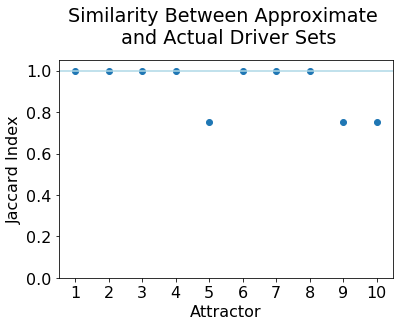

In [995]:
#graph differences in driver sets chosen by the IBMFA and the bruteforce method via the Jaccard measure
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)],range(1,11))
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Approximate \n and Actual Driver Sets",y=1.05)

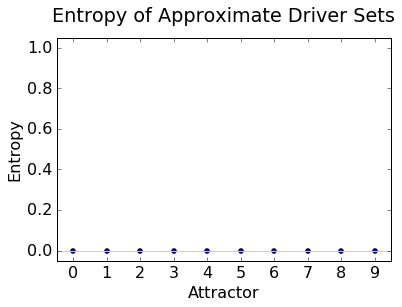

In [769]:
#graph actual entropy of approximate solutions based on simulations
iterations,yvalues=10,[]
for i,attractor in enumerate(dattractors):
    for j,evalue in enumerate(eval('a'+str(i))):
        if evalue==0:
            seed=eval('sa'+str(i)+'['+str(j)+']')
            yvalues.append(entropies_sim[seed])
            break

plt.hlines(0.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],yvalues)
plt.ylim([-0.05,1.05])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Entropy")
plt.xlabel("Attractor")
plt.title("Entropy of Approximate Driver Sets",y=1.05)

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


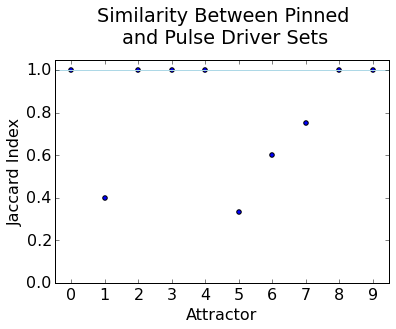

In [115]:
#graph differences in driver sets chosen via the Jaccard measure for pinned and pulse perturbations
#NOTE: the value for attractor 6 is incorrect due to an error in our seed selection
jmeasures=[1,0.4,1,1,1,1/3,0.6,0.75,1,1]
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Pinned \n and Pulse Driver Sets",y=1.05)

In [151]:
#confirm approximate solutions by comparing to DCM modules
yvalues=[]
for i,attractor in enumerate(dattractors):
    print attractor,
    for j,evalue in enumerate(eval('a'+str(i))):
        if evalue==0:
            seed=eval('sa'+str(i)+'['+str(j)+']')
            seed=to_list(seed,dsunit_map,dtranslator)
            diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=10,pinned={})
            print count_sunits(diffusion,pinned=False)#seed
            yvalues.append(count_sunits(diffusion,pinned=False))
            diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=15,pinned={})
            #print count_sunits(diffusion,pinned=False)
            break

11100001111111010 17
01100001111111010 17
11100001111111011 17
00011110001000011 17
10000000100110101 17
00011110001000001 15
00000001111111010 17
00011110100000001 17
00000000100110100 17
10000000100110100 17


In [162]:
#check the results based on reduced selections
reduced_selections=[eval('rsa'+str(i)+'[-1]') for i in range(10)] #in order of attractor
yvalues=[]
for i,attractor in enumerate(dattractors):
    print attractor,
    seed=reduced_selections[i]
    seed=to_list(seed,dsunit_map,dtranslator)
    diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=10,pinned={})
    print count_sunits(diffusion,pinned=False)#seed
    yvalues.append(count_sunits(diffusion,pinned=False))
    diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=15,pinned={})
    #print count_sunits(diffusion,pinned=False)

11100001111111010 17
01100001111111010 17
11100001111111011 17
00011110001000011 17
10000000100110101 17
00011110001000001 13
00000001111111010 17
00011110100000001 15
00000000100110100 17
10000000100110100 17


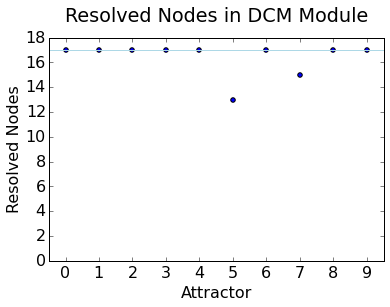

In [163]:
#graph the number of resolved nodes in the DCM using pulse perturbation
plt.hlines(17.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],yvalues)
plt.ylim([0,18])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Resolved Nodes")
plt.xlabel("Attractor")
plt.title("Resolved Nodes in DCM Module",y=1.05)

In [63]:
#compare to actual fixed points found via brute-force search
#fixed_points=find_attractors_bruteforce(ND,DCM,dsunits,dsunit_map,{},{},time_limit=15) #{0,2},{'WG','en','EN','ptc','PTC'}

In [210]:
#check fixed points found
print {len(x) for x in fixed_points}
for x in fixed_points:
    found=False
    for a in dattractors:
        if x==dattractors[a]:
            print "Found previous attractor"
            found=True
            break
    if not found: 
        print "New attractor found:",x
        break
#diffusion=BFS_threshold(DCM,list(x),'pulse',time_limit=3,pinned={})
#extract_sunits(diffusion,pinned=False)

set([17])
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor


In [524]:
#check each solution that it's a valid driver set
solutions=[{1,32,31},{0,32,31,3},{1,33,31},{0,33,31},{1,33,30,17},{0,33,30,16},{0,32,31,2},{0,33,30,17},{0,32,30,17},{1,32,30,17}]
for solution in solutions:
    fixed_points=find_attractors_bruteforce(ND,DCM,dsunits,dsunit_map,solution,{},time_limit=15)
    print solution,len(fixed_points)
    for x in fixed_points:
        for i,a in enumerate(dattractors):
            if x==dattractors[a]:
                print "Attractor found:",i+1,a,[fixed_points[x] for x in fixed_points]

set([32, 1, 31]) 1
Attractor found: 1 11100001111111010 [16384]
set([0, 32, 3, 31]) 1
Attractor found: 2 01100001111111010 [8192]
set([1, 31, 33]) 1
Attractor found: 3 11100001111111011 [16384]
set([0, 33, 31]) 1
Attractor found: 4 00011110001000011 [16384]
set([1, 17, 30, 33]) 1
Attractor found: 5 10000000100110101 [8192]
set([0, 33, 30, 16]) 1
Attractor found: 6 00011110001000001 [8192]
set([0, 32, 2, 31]) 1
Attractor found: 7 00000001111111010 [8192]
set([0, 33, 30, 17]) 1
Attractor found: 8 00011110100000001 [8192]
set([0, 32, 30, 17]) 1
Attractor found: 9 00000000100110100 [8192]
set([32, 1, 30, 17]) 1
Attractor found: 10 10000000100110100 [8192]


In [236]:
#compare to FVS drivers
dfvs=fvs_set(ND)
for x in sorted(dfvs): 
    print x,to_list(x,dsunit_map,dtranslator)[0]
#make sure translator is updated for higher s
dtranslator=create_translator(ND,s=3,sunits=dsunits,sunit_map=dsunit_map,translator=dtranslator)
len(dtranslator)

(0,) SLP-0
(1,) SLP-1
(16,) PTC-0
(17,) PTC-1
(2,) wg-0
(3,) wg-1
(30,) nhhnHH-0
(31,) nhhnHH-1
(32,) nWG-0
(33,) nWG-1


6580

In [529]:
#search for smaller solutions using FVS nodes (NOTE: solutions must be at least 3 because there are 3 input nodes)
seeds=combinations(dfvs,3)
for seed in seeds:
    seed=[dtranslator[s][0] for s in sorted(list(seed))] #extract number from tuple
    #quick check for contradiction
    vals=[dsunit_map[x][:-2] for x in seed]
    if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
        continue
    if not 'SLP' in vals or not 'nhhnHH' in vals or not 'nWG' in vals: continue #solution must contain the input nodes
    print seed,vals
    fixed_points=find_attractors_bruteforce(ND,DCM,dsunits,dsunit_map,seed,{},time_limit=12)
    print {len(x) for x in fixed_points},len(fixed_points),[fixed_points[x] for x in fixed_points]
    #if len(fixed_points)==1: 
    for x in fixed_points:
        for i,a in enumerate(dattractors):
            if x==dattractors[a]:
                print "Attractor found:",i+1,a,fixed_points[x]
    #break

[1, 30, 33] ['SLP', 'nhhnHH', 'nWG']
set([17]) 1 [16384]
Attractor found: 5 10000000100110101 16384
[0, 30, 33] ['SLP', 'nhhnHH', 'nWG']
set([17]) 2 [2688, 13696]
Attractor found: 6 00011110001000001 2688
Attractor found: 8 00011110100000001 13696
[1, 31, 33] ['SLP', 'nhhnHH', 'nWG']
set([17]) 1 [16384]
Attractor found: 3 11100001111111011 16384
[0, 31, 33] ['SLP', 'nhhnHH', 'nWG']
set([17]) 1 [16384]
Attractor found: 4 00011110001000011 16384
[1, 30, 32] ['SLP', 'nhhnHH', 'nWG']
set([17]) 1 [16384]
Attractor found: 10 10000000100110100 16384
[0, 30, 32] ['SLP', 'nhhnHH', 'nWG']
set([17]) 1 [16384]
Attractor found: 9 00000000100110100 16384
[1, 31, 32] ['SLP', 'nhhnHH', 'nWG']
set([17]) 1 [16384]
Attractor found: 1 11100001111111010 16384
[0, 31, 32] ['SLP', 'nhhnHH', 'nWG']
set([17]) 2 [16256, 128]
Attractor found: 7 00000001111111010 16256
Attractor found: 2 01100001111111010 128


In [255]:
#NOTE: attractors 5, 9, and 10 do NOT require PTC-1 because PTC-0 will always lead to PTC-1 given the orange and brown modules
diffusion=BFS_threshold(DCM,['SLP-1', 'nhhnHH-0', 'nWG-1','PTC-0'],'pulse',time_limit=12,pinned={'SLP-1', 'nhhnHH-0', 'nWG-1'})
extract_sunits(diffusion,pinned=False)

{0: set(['T-0_CIR-0', 'nWG-1', 'F-T2', 'F-T1', 'SLP-1', 'PTC-0', 'nhhnHH-0', 'T-0_PH-0']), 1: set(['nhhnHH-0', 'CIR-0', 'SMO-1', 'F-T2', 'nWG-1', 'SLP-1', 'PH-0', 'T-0_PH-0', 'en-0']), 2: set(['nhhnHH-0', 'F-T2', 'nWG-1', 'SLP-1', 'en-0', 'PH-0', 'T-0_PH-0', 'EN-0']), 3: set(['nWG-1', 'PH-0', 'F-T2', 'ci-1', 'hh-0', 'SLP-1', 'en-0', 'nhhnHH-0', 'T-0_PH-0', 'EN-0']), 4: set(['HH-0', 'nWG-1', 'PH-0', 'CI-1', 'F-T2', 'ci-1', 'hh-0', 'SLP-1', 'en-0', 'nhhnHH-0', 'T-0_PH-0', 'EN-0']), 5: set(['HH-0', 'nWG-1', 'PH-0', 'CI-1', 'F-T2', 'ci-1', 'hh-0', 'SLP-1', 'en-0', 'nhhnHH-0', 'T-0_PH-0', 'EN-0']), 6: set(['HH-0', 'nWG-1', 'PH-0', 'CI-1', 'F-T2', 'ci-1', 'hh-0', 'SLP-1', 'en-0', 'nhhnHH-0', 'T-0_PH-0', 'EN-0']), 7: set(['HH-0', 'nWG-1', 'PH-0', 'CI-1', 'F-T2', 'ci-1', 'hh-0', 'SLP-1', 'en-0', 'nhhnHH-0', 'T-0_PH-0', 'EN-0']), 8: set(['HH-0', 'nWG-1', 'PH-0', 'CI-1', 'F-T2', 'ci-1', 'hh-0', 'SLP-1', 'en-0', 'nhhnHH-0', 'T-0_PH-0', 'EN-0']), 9: set(['HH-0', 'nWG-1', 'PH-0', 'CI-1', 'F-T2', 'c

{'CI-1',
 'EN-0',
 'HH-0',
 'PH-0',
 'SLP-1',
 'ci-1',
 'en-0',
 'hh-0',
 'nWG-1',
 'nhhnHH-0'}

#### Drosophila Parasegment

In [161]:
#recreate pipeline with drosophila and using reduced LUTs
NP = cana.BooleanNetwork.from_file('cana/datasets/drosophila_parasegment.txt',file_type='logical')
dp={node.name: LUT_reduce(look_up_table(node)) for node in NP.nodes}
dpnodes=dp.keys()
print len(dp),dpnodes
dpmodules,dptranslator={},{}
dpsunits,dpsunit_map=get_sunits(NP)
print len(dpsunits),len(dpsunit_map)

60 ['PTC_P4', 'ci_P3', 'PTC_P1', 'PTC_P2', 'PTC_P3', 'ptc_P3', 'CI_P2', 'CI_P3', 'CI_P1', 'CI_P4', 'WG_P2', 'hh_P2', 'hh_P3', 'hh_P1', 'WG_P1', 'SLP_P2', 'SLP_P3', 'PH_P2', 'PH_P3', 'PH_P1', 'PH_P4', 'hh_P4', 'HH_P4', 'CIR_P4', 'wg_P4', 'ptc_P4', 'en_P1', 'CIA_P3', 'en_P3', 'en_P2', 'WG_P3', 'CIA_P4', 'SLP_P4', 'CIA_P1', 'WG_P4', 'ci_P2', 'SMO_P1', 'SMO_P2', 'ci_P1', 'SMO_P4', 'SLP_P1', 'ci_P4', 'ptc_P1', 'HH_P2', 'HH_P3', 'HH_P1', 'wg_P1', 'wg_P2', 'wg_P3', 'CIA_P2', 'en_P4', 'ptc_P2', 'SMO_P3', 'CIR_P3', 'CIR_P2', 'CIR_P1', 'EN_P1', 'EN_P3', 'EN_P2', 'EN_P4']
120 120


In [163]:
#find pathway modules for drosophila
start_time = time.time()
iterations=20
dpmodules,dptranslator=find_modules(NP,1,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,
                                    ds=dp,pinning={},iterations=iterations,data=True,pin_start=True)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

seeds: 120
--- Total time: 104.555999994 seconds ---


In [167]:
seeds=reduce_seeds(dpmodules,dpsunit_map,dptranslator,length=1)
submodules={seed:dpmodules[seed] for seed in seeds}
len(submodules)

120

In [168]:
seeds=submodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
dpstats={}
length=1
iterations=20
start_time = time.time()
simulations=compare_simulations(NP,seeds,dpsunit_map,dpmodules,dptranslator,length=length,runs=100,
            tau=0.0,iterations=iterations,unknown_prob=0.5,stats=dpstats,results=True,time_limit=12)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 120
true positives: [1.0, 0.75, 0.97, 0.88, 0.9, 0.93, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
false negatives: [0.0, 0.25, 0.03, 0.12, 0.1, 0.07, 0.09, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 0.99, 1.0, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]
recall: [1.0, 0.75, 0.97, 0.88, 0.9, 0.93, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 0.75, 0.97, 0.88, 0.9, 0.93, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0

In [81]:
#compare to baselines
pbstats={}
compare_baseline(NP,seeds,dpsunit_map,dptranslator,simulations,length=length,tau=0.0,iterations=10,stats=pbstats,results=True)

100 total runs, 1.0 seeds
true positives: [1.0, 0.99, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.01, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
recall: [1.0, 0.99, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average similarity: [0.0, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errors: [0.065, 0.059, 0.059, 0.058, 0.058, 0.058, 0.059, 0.06, 0.061, 0.061, 0.061]


In [169]:
#dpact_prob_sim={}
for seed in simulations: dpact_prob_sim[seed]={}
for seed in simulations:
    aggregate_simulation(seed,simulations,dpact_prob_sim)

len(dpact_prob_sim)

121

['en_P1-1']
Normalized entropy: [0.98, 0.82, 0.78, 0.72, 0.68, 0.66, 0.65, 0.65, 0.66, 0.65, 0.64] [1.0, 0.83, 0.8, 0.73, 0.7, 0.67, 0.66, 0.66, 0.67, 0.66, 0.65]
Probable configurations: ['5.76e+17', '5.39e+14', '1.34e+14', '1.11e+13', '2.25e+12', '8.65e+11', '5.64e+11', '6.25e+11', '6.88e+11', '4.65e+11', '3.93e+11']


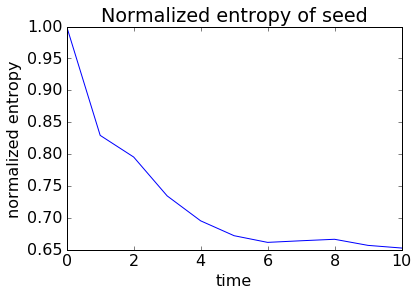

Total possible configurations: [0.5, 0.25, 0.0625, 0.03125, 0.00781, 0.00391, 0.00049, 0.00012, 0.00012, 0.00012, 0.00012] [1.0, 0.5, 0.125, 0.0625, 0.01563, 0.00781, 0.00098, 0.00024, 0.00024, 0.00024, 0.00024]


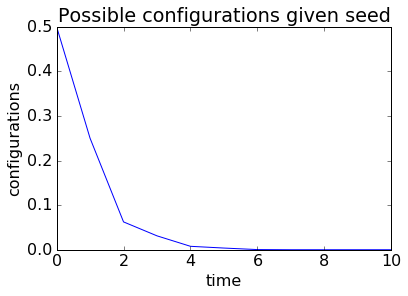

In [207]:
#single seed entropy
seed='(7,)' #'(7,)'
print to_list(seed,dpsunit_map,dptranslator)
diffusion=dpmodules[seed] #dmodules[seed], dact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
xvalues=seed_entropy.keys()
yvalues=[seed_entropy[key] for key in seed_entropy]
#print [round(y*60,2) for y in yvalues]
plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues]) #normalize everything compared to the starting value
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
#plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True,strict=True)
xvalues=seed_configs.keys()
y1values=[seed_configs[key] for key in seed_configs]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
print 'Total possible configurations:',[round(yvalue,5) for yvalue in y1values],[round(yvalue/y1values[0],5) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

seeds: 120
Average entropy: [58.57, 48.91, 48.97, 47.37, 47.48, 47.97, 48.52, 49.79, 50.82, 50.47, 50.59]
Normalized entropy: [0.98, 0.82, 0.82, 0.79, 0.79, 0.8, 0.81, 0.83, 0.85, 0.84, 0.84] [1.0, 0.84, 0.84, 0.81, 0.81, 0.82, 0.83, 0.85, 0.87, 0.86, 0.86]
Possible configurations: ['4.29e+17', '5.31e+14', '5.52e+14', '1.82e+14', '1.96e+14', '2.76e+14', '4.03e+14', '9.76e+14', '1.98e+15', '1.56e+15', '1.70e+15']


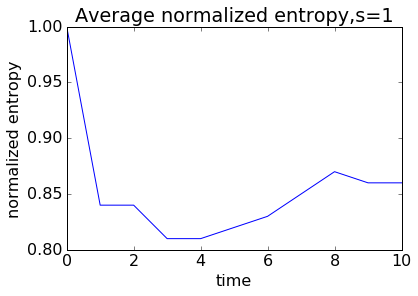

Total possible configurations: [0.5, 0.22, 0.28, 0.24, 0.24, 0.26, 0.24, 0.24, 0.24, 0.24, 0.24] [1.0, 0.45, 0.55, 0.48, 0.47, 0.51, 0.49, 0.48, 0.48, 0.48, 0.48]


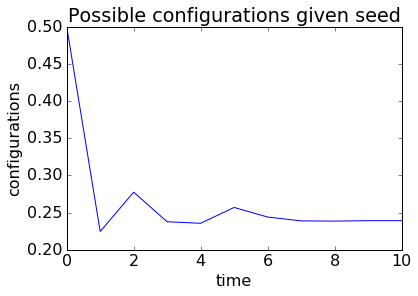

In [211]:
#multiple seed entropies
length,iterations=1,10
seeds=reduce_seeds(dpmodules,dpsunit_map,dptranslator,length=length) #['()','(3,)']
#seeds=simulations.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(dpact_prob_sim,seeds,normalized=True,data=False) #dpmodules, submodules, dpact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * 60,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(dpact_prob_sim,seeds,normalized=True,data=False,strict=True) #submodules,dact_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [348]:
#graph entropy over time
seed_entropy,seed_configs=seed_entropies(dpmodules,dpmodules.keys(),normalized=True,data=True)
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][20])
#sorted_entropies

average entropy: [0.9834710743801649, 0.823231429774801, 0.8233523920136729, 0.7918900735638389, 0.7891499619732643, 0.7840592543486986, 0.7911483468579358, 0.8169434460743341, 0.8325575338539837, 0.8296458386013239, 0.8305423972620429, 0.8260782170203, 0.8202333462959053, 0.8153550497085582, 0.8129866170922632, 0.8113666786662882, 0.8111624169318321, 0.8105418462421062, 0.8095993209208563, 0.808215666856619, 0.8067627678391979]
average configurations: [0.5041322314049587, 1.4502323514815152e-06, 1.6499816228776127e-07, 5.8411571097164333e-08, 2.4090152243797193e-08, 1.8688657240146535e-08, 3.678457416411662e-08, 8.674749508966069e-08, 3.162069335012482e-07, 2.862116999104382e-07, 4.165582659492401e-07, 4.615070595484922e-07, 4.2442955719167734e-07, 3.799570958202984e-07, 3.5842791694620264e-07, 3.3288807857194383e-07, 3.4158058253539085e-07, 3.441762717707617e-07, 3.4927949267165893e-07, 3.4973546169304644e-07, 3.535864950996008e-07]


Lowest: (37,) [0.98, 0.82, 0.78, 0.72, 0.68, 0.66, 0.65, 0.65, 0.66, 0.65, 0.64, 0.64, 0.64, 0.63, 0.63, 0.62, 0.62, 0.61, 0.61, 0.6, 0.6] ['en_P2-1']
Highest: () [1.0, 0.85, 0.86, 0.83, 0.84, 0.84, 0.85, 0.89, 0.91, 0.91, 0.91, 0.91, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9] []


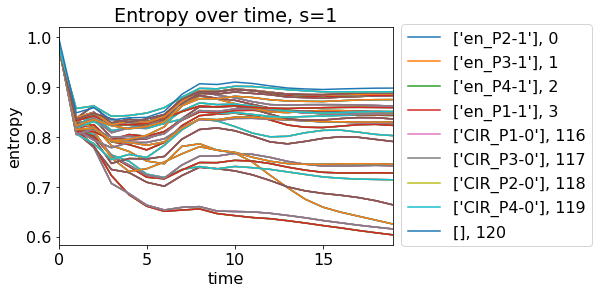

In [356]:
#graph s=1 length modules
iterations,length=20,1
print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]],
print to_list(sorted_entropies[0],dpsunit_map,dptranslator)
print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]],
print to_list(sorted_entropies[-1],dpsunit_map,dptranslator)
xvalues=range(iterations)
for index,seed in enumerate(sorted_entropies):
    if index<4 or index>115:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues],label=str(to_list(seed,dpsunit_map,dptranslator))+', '+str(index))
    #elif index%2==0: continue
    else:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues])
plt.title("Entropy over time, s="+str(length))
plt.ylabel("entropy")
plt.xlabel("time")
plt.xlim([0,iterations-1])
plt.legend(bbox_to_anchor=(1.0, 1.05))

In [317]:
#compare to FVS drivers
dpfvs=fvs_set(NP,method='bruteforce')
print len(dpfvs)
for x in sorted(dpfvs): 
    #print x,dpsunit_map[dptranslator[x][0]]
    seed_entropy,seed_configs=config_entropy(dpmodules[x],base=2,normalized=True)
    print x,dpsunit_map[dptranslator[x][0]],seed_entropy[10]

40
(0,) SLP_P1-0 0.767802312911
(1,) SLP_P1-1 0.769077021858
(10,) hh_P1-0 0.865748955702
(100,) hh_P4-0 0.865748955702
(101,) hh_P4-1 0.837084906818
(106,) PTC_P4-0 0.855944102561
(107,) PTC_P4-1 0.895113511959
(11,) hh_P1-1 0.837084906818
(118,) CIR_P4-0 0.901541364401
(119,) CIR_P4-1 0.731728263452
(16,) PTC_P1-0 0.855944102561
(17,) PTC_P1-1 0.895113511959
(2,) wg_P1-0 0.847754379263
(28,) CIR_P1-0 0.901541364401
(29,) CIR_P1-1 0.731728263452
(3,) wg_P1-1 0.848861676107
(30,) SLP_P2-0 0.767802312911
(31,) SLP_P2-1 0.769077021858
(32,) wg_P2-0 0.847754379263
(33,) wg_P2-1 0.848861676107
(40,) hh_P2-0 0.865748955702
(41,) hh_P2-1 0.837084906818
(46,) PTC_P2-0 0.855944102561
(47,) PTC_P2-1 0.895113511959
(58,) CIR_P2-0 0.901541364401
(59,) CIR_P2-1 0.731728263452
(60,) SLP_P3-0 0.767802312911
(61,) SLP_P3-1 0.769077021858
(62,) wg_P3-0 0.847754379263
(63,) wg_P3-1 0.848861676107
(70,) hh_P3-0 0.865748955702
(71,) hh_P3-1 0.837084906818
(76,) PTC_P3-0 0.855944102561
(77,) PTC_P3-1 0.89

In [170]:
#reduce entropy in the parasegment with or without the driver nodes
start_time = time.time()
t=20
selections,entropies=top_selection(NP,dpsunits,dpsunit_map,dpmodules,dptranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dp,
                    pinning={},tau=0.0,iterations=t,unknown_prob=0.5,t=t,base=2,normalized=True,force=True,pin_start=True)
for seed in selections: print seed, entropies[seed], to_list(seed,dpsunit_map,dptranslator)
print reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=t,iterations=t)
#for seed in sorted(entropies,key=lambda x: entropies[x])[:top]: print seed,entropies[seed]
print("--- Total time: %s seconds ---" % (time.time()-start_time))

121 121
() 0.8978782605273133 []
(37,) 0.599433598266786 ['en_P2-1']
(37, 97) 0.07308950430620022 ['en_P2-1', 'en_P4-1']
(30, 37, 97) 0.054109206268261274 ['SLP_P2-0', 'en_P2-1', 'en_P4-1']
(30, 37, 90, 97) 0.03581738170830054 ['SLP_P2-0', 'en_P2-1', 'SLP_P4-0', 'en_P4-1']
(30, 37, 60, 90, 97) 0.017270499009500232 ['SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'SLP_P4-0', 'en_P4-1']
(0, 30, 37, 60, 90, 97) 0.0002998079653382075 ['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'SLP_P4-0', 'en_P4-1']
(0, 30, 37, 60, 90, 93, 97) 0.0 ['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1']
(0, 30, 37, 60, 79, 90, 93, 97) 0.0 ['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'PH_P3-1', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1']
(0, 30, 37, 60, 73, 79, 90, 93, 97) 0.0 ['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'HH_P3-1', 'PH_P3-1', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1']
(0, 18, 30, 37, 60, 73, 79, 90, 93, 97) 0.0 ['SLP_P1-0', 'PH_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'HH_P3-1', 'PH_P3-

In [174]:
len(dpmodules)

1119

In [175]:
#check for error in modules based on #iterations
print len(dpmodules)
l={}
bads=[]
for module in dpmodules:
    if len(dpmodules[module])!=21: bads.append(module)
    l.setdefault(len(dpmodules[module]),0)
    l[len(dpmodules[module])]+=1
print l,len(bads),bads
#for b in bads: del dpmodules[b]

1119
{21: 1119} 0 []


In [249]:
print selections
selections2=['()','(7,)','(7, 69)','(7, 69, 91)','(7, 31, 69, 91)','(7, 31, 60, 69, 91)','(0, 7, 31, 60, 69, 91)',
    '(0, 7, 31, 60, 69, 91, 103)','(0, 7, 31, 60, 69, 91, 103, 119)','(0, 7, 31, 60, 69, 91, 103, 106, 119)']
#for seed in selections2: print seed, entropies[seed], to_list(seed,dpsunit_map,dptranslator)
seed=(7, 69)
diffusion=find_modules(NP,2,dpsunits,dpsunit_map,{},dptranslator,seeds=[seed],data=True,verbose=True,iterations=10)[0][str(seed)]
#print diffusion
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
seed_entropy

['()', '(7,)', '(7, 69)', '(7, 69, 91)', '(7, 31, 69, 91)', '(7, 31, 60, 69, 91)', '(0, 7, 31, 60, 69, 91)', '(0, 7, 31, 41, 60, 69, 91)', '(0, 7, 26, 31, 41, 60, 69, 91)', '(0, 7, 26, 31, 41, 53, 60, 69, 91)', '(0, 7, 26, 31, 41, 53, 60, 62, 69, 91)']
seeds: 1


{0: 0.9666666666666667,
 1: 0.7763562617651262,
 2: 0.7024245843369226,
 3: 0.598916920165403,
 4: 0.5466561163501933,
 5: 0.5053571294147594,
 6: 0.48046869184601976,
 7: 0.4611171008789938,
 8: 0.4363891756178545,
 9: 0.39565541240732477,
 10: 0.35046661256992323}

In [78]:
#actual entropy of solution based on simulations
entropies_sim={}
t=20
entropies_sim=strategy_entropy(selections,NP,dpsunit_map,dpmodules,dptranslator,runs=100,tau=0.0,iterations=t,unknown_prob=0.5,
                               stats=dpstats,results=False,time_limit=12,act_prob_sim=dpact_prob_sim,entropies_sim=entropies_sim,t=t)
for j,seed in enumerate(selections): print to_list(seed,dpsunit_map,dptranslator), entropies_sim[seed]

[] 0.8997596757643345
['en_P2-1'] 0.6940359992761462
['en_P2-1', 'en_P4-1'] 0.5253494902358269
['SLP_P2-0', 'en_P2-1', 'en_P4-1'] 0.4158803363886753
['SLP_P2-0', 'en_P2-1', 'SLP_P4-0', 'en_P4-1'] 0.14465123507128483
['SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'SLP_P4-0', 'en_P4-1'] 0.10540917075043658
['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'SLP_P4-0', 'en_P4-1'] 0.06778050968277902
['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1'] 0.0
['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'PH_P3-1', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1'] 0.0
['SLP_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'HH_P3-1', 'PH_P3-1', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1'] 0.0
['SLP_P1-0', 'PH_P1-0', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-0', 'HH_P3-1', 'PH_P3-1', 'SLP_P4-0', 'wg_P4-1', 'en_P4-1'] 0.0


In [333]:
#top selection based on FVS
selections,entropies=top_selection(NP,dpsunits,dpsunit_map,dpmodules,dptranslator,seeds=dpfvs,max_s=10,top=1,reduced=True,ds=dp,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False)
for seed in selections: print seed, entropies[seed], to_list(seed,dpsunit_map,dptranslator)
print reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=10)
#for seed in sorted(entropies,key=lambda x: entropies[x])[:top]: print seed,entropies[seed]

1499 1499
() 0.91003133888 []
(29,) 0.731728263452 ['CIR_P1-1']
(29, 89) 0.276328442507 ['CIR_P1-1', 'CIR_P3-1']
(29, 89, 107) 0.195553184677 ['CIR_P1-1', 'CIR_P3-1', 'PTC_P4-1']
(29, 47, 89, 107) 0.090022465642 ['CIR_P1-1', 'PTC_P2-1', 'CIR_P3-1', 'PTC_P4-1']
(29, 47, 89, 90, 107) 0.0634961897695 ['CIR_P1-1', 'PTC_P2-1', 'CIR_P3-1', 'SLP_P4-0', 'PTC_P4-1']
(29, 30, 47, 89, 90, 107) 0.0344448809869 ['CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'CIR_P3-1', 'SLP_P4-0', 'PTC_P4-1']
(29, 30, 47, 61, 89, 90, 107) 0.0177782143203 ['CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'CIR_P3-1', 'SLP_P4-0', 'PTC_P4-1']
(0, 29, 30, 47, 61, 89, 90, 107) 0.00111154765359 ['SLP_P1-0', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'CIR_P3-1', 'SLP_P4-0', 'PTC_P4-1']
(0, 29, 30, 47, 61, 63, 89, 90, 107) 0.0 ['SLP_P1-0', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'wg_P3-1', 'CIR_P3-1', 'SLP_P4-0', 'PTC_P4-1']
(0, 29, 30, 47, 61, 63, 70, 89, 90, 107) 0.0 ['SLP_P1-0', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP

In [187]:
seed=(1, 3, 5, 7, 26, 28, 30, 41, 61, 90)
reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=10,pin_start=False)

(1, 3, 5, 7, 26, 28, 30, 41, 61, 90)

In [79]:
#check the known parasegment attractors
dpattractors={}
nodes=['SLP_P1','wg_P1','WG_P1','en_P1','EN_P1','hh_P1','HH_P1','ptc_P1','PTC_P1','PH_P1','SMO_P1','ci_P1','CI_P1','CIA_P1','CIR_P1',
      'SLP_P2','wg_P2','WG_P2','en_P2','EN_P2','hh_P2','HH_P2','ptc_P2','PTC_P2','PH_P2','SMO_P2','ci_P2','CI_P2','CIA_P2','CIR_P2',
      'SLP_P3','wg_P3','WG_P3','en_P3','EN_P3','hh_P3','HH_P3','ptc_P3','PTC_P3','PH_P3','SMO_P3','ci_P3','CI_P3','CIA_P3','CIR_P3',
      'SLP_P4','wg_P4','WG_P4','en_P4','EN_P4','hh_P4','HH_P4','ptc_P4','PTC_P4','PH_P4','SMO_P4','ci_P4','CI_P4','CIA_P4','CIR_P4']
#wildtype
dpattractors['wildtype']={'wg_P1-0','wg_P2-0','wg_P3-0','wg_P4-1','WG_P1-0','WG_P2-0','WG_P3-0','WG_P4-1','en_P1-1','en_P2-0','en_P3-0',
          'en_P4-0','EN_P1-1','EN_P2-0','EN_P3-0','EN_P4-0','hh_P1-1','hh_P2-0','hh_P3-0','hh_P4-0','HH_P1-1','HH_P2-0','HH_P3-0','HH_P4-0',
          'ptc_P1-0','ptc_P2-1','ptc_P3-0','ptc_P4-1','PTC_P1-0','PTC_P2-1','PTC_P3-1','PTC_P4-1','PH_P1-0','PH_P2-1','PH_P3-0','PH_P4-1',
          'SMO_P1-1','SMO_P2-1','SMO_P3-0','SMO_P4-1','ci_P1-0','ci_P2-1','ci_P3-1','ci_P4-1','CI_P1-0','CI_P2-1','CI_P3-1','CI_P4-1',
          'CIA_P1-0','CIA_P2-1','CIA_P3-0','CIA_P4-1','CIR_P1-0','CIR_P2-0','CIR_P3-1','CIR_P4-0','SLP_P1-0','SLP_P2-0','SLP_P3-1','SLP_P4-1'}
#broad stripes
dpattractors['broad']={'wg_P3-1', 'wg_P4-1', 'WG_P3-1','WG_P4-1', 'en_P1-1', 'en_P2-1', 'EN_P1-1', 'EN_P2-1', 'hh_P1-1', 'hh_P2-1','HH_P1-1',
            'HH_P2-1','ptc_P3-1', 'ptc_P4-1', 'PTC_P3-1', 'PTC_P4-1', 'ci_P3-1', 'ci_P4-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P3-1', 'CIA_P4-1', 
            'SLP_P3-1', 'SLP_P4-1','SMO_P1-1', 'SMO_P2-1', 'PH_P3-1', 'SMO_P3-1', 'PH_P4-1', 'SMO_P4-1'}
#no segmentation
dpattractors['noseg']={'ci_P1-1', 'ci_P2-1', 'ci_P3-1', 'ci_P4-1', 'CI_P1-1', 'CI_P2-1', 'CI_P3-1', 'CI_P4-1', 'PTC_P1-1', 'PTC_P2-1',
           'PTC_P3-1', 'PTC_P4-1', 'CIR_P1-1', 'CIR_P2-1', 'CIR_P3-1', 'CIR_P4-1', 'SLP_P3-1', 'SLP_P4-1'}
#wildtype variant
dpattractors['wildvar']={'wg_P4-1', 'WG_P4-1', 'en_P1-1', 'EN_P1-1', 'hh_P1-1', 'HH_P1-1', 'ptc_P2-1', 'ptc_P4-1', 'PTC_P1-1', 'PTC_P2-1', 
            'PTC_P3-1', 'PTC_P4-1', 'ci_P2-1', 'ci_P3-1', 'ci_P4-1', 'CI_P2-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P2-1', 'CIA_P4-1', 'CIR_P3-1', 
            'SLP_P3-1', 'SLP_P4-1','PH_P2-1', 'SMO_P2-1', 'PH_P4-1', 'SMO_P4-1'}
#ectopic
dpattractors['ectopic']={'wg_P3-1', 'WG_P3-1', 'en_P2-1', 'EN_P2-1', 'hh_P2-1', 'HH_P2-1', 'ptc_P1-1', 'ptc_P3-1', 'PTC_P1-1', 'PTC_P3-1', 
            'PTC_P4-1','ci_P1-1', 'ci_P3-1', 'ci_P4-1', 'CI_P1-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P1-1', 'CIA_P3-1', 'CIR_P4-1', 'SLP_P3-1', 
            'SLP_P4-1','PH_P1-1', 'SMO_P1-1', 'SMO_P2-1', 'PH_P3-1', 'SMO_P3-1'}
#ectopic variant
dpattractors['ectopvar']={'wg_P3-1', 'WG_P3-1', 'en_P2-1', 'EN_P2-1', 'hh_P2-1', 'HH_P2-1', 'ptc_P1-1', 'ptc_P3-1', 'PTC_P1-1', 'PTC_P2-1', 
            'PTC_P3-1', 'PTC_P4-1','ci_P1-1', 'ci_P3-1', 'ci_P4-1', 'CI_P1-1', 'CI_P3-1', 'CI_P4-1', 'CIA_P1-1', 'CIA_P3-1', 'CIR_P4-1', 
            'SLP_P3-1', 'SLP_P4-1','PH_P1-1', 'SMO_P1-1', 'PH_P3-1', 'SMO_P3-1'}
#add in null nodes
for attractor in dpattractors:
    seen_nodes={s[:-2] for s in dpattractors[attractor]}
    for node in nodes: 
        if node not in seen_nodes: dpattractors[attractor].add(node+'-0')
for attractor in dpattractors: print len(dpattractors[attractor])

60
60
60
60
60
60


In [299]:
#helper functions for DCM modules
#DCMP=NP.dynamics_canalization_map(output=None, )
#diffusion=BFS_threshold(DCMP,['en_P1-1'],'steady',time_limit=12,pinned={})
def is_sunit(s):
    """ determines if a particular unit is an s-unit based on the name """
    if not s or len(s)<3 or s[:2]=='F-' or s[:2]=='T-':
        return False
    return True

def reduce_step(step):
    """ reduces a module step to only include s-units """
    new_step={s for s in step if is_sunit(s)}
    return new_step

def reduce_module(module):
    """ reduces a module to only include s-units """
    new_module={t: {s for s in module[t] if is_sunit(s)} for t in module}
    return new_module

def extract_sunits(module,pinned=True):
    """ extracts the unique s-units in a DCM module """
    module=reduce_module(module)
    if pinned:
        units={s for t in module for s in module[t]}
    else:
        units={s for s in module[max(module)]} #extract only the last time step
    return units

def extract_variables(module,pinned=True):
    units=extract_sunits(module,pinned=pinned)
    return {s[:-2] for s in units} #remove the state and force uniqueness of variables

def count_sunits(module,pinned=True):
    """ counts the unique s-units in a DCM module """
    units=extract_sunits(module,pinned=pinned)
    return len(units)

def count_variables(module,pinned=True):
    return len(extract_variables(module,pinned=pinned))

#for t in diffusion: 
#    for s in diffusion[t]: pass #print s,is_sunit(s)
#print reduce_module(diffusion)
#print extract_sunits(diffusion,pinned=False), count_sunits(diffusion,pinned=True)

In [572]:
#dpmodules={}
dpact_prob_sim={}
entropies_sim={}

In [227]:
dpattractors.keys()

['wildvar', 'broad', 'ectopvar', 'ectopic', 'noseg', 'wildtype']

In [229]:
#determine top selections for attractors
iterations=20
t=iterations
for i,attractor in enumerate(dpattractors):
    if attractor!='noseg': continue
    selections,entropies=top_selection(NP,dpsunits,dpsunit_map,dpmodules,dptranslator,seeds=None,max_s=50,top=1,reduced=True,
            ds=dp,attractor=attractor,attractors=dpattractors,pin_start=True,force=True,t=t,iterations=iterations)
    exec('ap'+str(i)+'=[entropies[x] for x in selections]') #entropy
    exec('sp'+str(i)+'=[x for x in selections]') #selection
    exec('rsp'+str(i)+'=[]') #reduced selection
    print attractor #,eval('a'+str(i))
    for seed in selections: 
        print seed, entropies[seed], to_list(seed,dpsunit_map,dptranslator),
        print to_list(reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=t,
                                       iterations=iterations,pin_start=True),dpsunit_map)
        rs=reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=t,
                                       iterations=iterations,pin_start=True)
        exec('rsp'+str(i)+'.append(rs)')
        if entropies[seed]==0.0: break #no need to print out the rest

16571 16571
noseg
() 0.8978782605273133 [] []
(0,) 0.6162601997349245 ['SLP_P1-0'] ['SLP_P1-0']
(0, 86) 0.2002613943615676 ['SLP_P1-0', 'CIA_P3-0'] ['SLP_P1-0', 'CIA_P3-0']
(0, 14, 86) 0.15397701032277616 ['SLP_P1-0', 'ptc_P1-0', 'CIA_P3-0'] ['SLP_P1-0', 'ptc_P1-0', 'CIA_P3-0']
(0, 14, 66, 86) 0.07299789352785704 ['SLP_P1-0', 'ptc_P1-0', 'en_P3-0', 'CIA_P3-0'] ['SLP_P1-0', 'ptc_P1-0', 'en_P3-0', 'CIA_P3-0']
(0, 14, 66, 86, 91) 0.03693165248352512 ['SLP_P1-0', 'ptc_P1-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1'] ['SLP_P1-0', 'ptc_P1-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1']
(0, 14, 30, 66, 86, 91) 0.025346407497538588 ['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1'] ['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1']
(0, 14, 30, 66, 86, 91, 115) 0.02034334235302694 ['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1', 'CI_P4-1'] ['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1', 'CI_P4-1']
(0, 14, 30, 66, 77, 86, 9

(0, 2, 4, 14, 18, 20, 26, 30, 32, 44, 47, 48, 50, 53, 55, 56, 61, 66, 68, 74, 77, 78, 80, 83, 85, 86, 89, 91, 96, 98, 100, 108, 110, 113, 115) 0.0025567635419098556 ['SLP_P1-0', 'wg_P1-0', 'WG_P1-0', 'ptc_P1-0', 'PH_P1-0', 'SMO_P1-0', 'CIA_P1-0', 'SLP_P2-0', 'wg_P2-0', 'ptc_P2-0', 'PTC_P2-1', 'PH_P2-0', 'SMO_P2-0', 'ci_P2-1', 'CI_P2-1', 'CIA_P2-0', 'SLP_P3-1', 'en_P3-0', 'EN_P3-0', 'ptc_P3-0', 'PTC_P3-1', 'PH_P3-0', 'SMO_P3-0', 'ci_P3-1', 'CI_P3-1', 'CIA_P3-0', 'CIR_P3-1', 'SLP_P4-1', 'en_P4-0', 'EN_P4-0', 'hh_P4-0', 'PH_P4-0', 'SMO_P4-0', 'ci_P4-1', 'CI_P4-1'] ['SLP_P1-0', 'ptc_P1-0', 'SMO_P1-0', 'CIA_P1-0', 'SLP_P2-0', 'PH_P2-0', 'SMO_P2-0', 'CIA_P2-0', 'SLP_P3-1', 'PTC_P3-1', 'SLP_P4-1', 'PH_P4-0', 'SMO_P4-0', 'CI_P4-1']
(0, 2, 4, 14, 18, 20, 26, 30, 32, 44, 47, 48, 50, 53, 55, 56, 61, 62, 66, 68, 74, 77, 78, 80, 83, 85, 86, 89, 91, 96, 98, 100, 108, 110, 113, 115) 0.0031481366416297434 ['SLP_P1-0', 'wg_P1-0', 'WG_P1-0', 'ptc_P1-0', 'PH_P1-0', 'SMO_P1-0', 'CIA_P1-0', 'SLP_P2-0', 'wg

In [178]:
for i in range(len(dpattractors)):
    print(eval('ap'+str(i)),eval('sp'+str(i)),eval('rsp'+str(i)))

([0.8978782605273133, 0.5994335982667863, 0.15407467247029644, 0.054165926131515364, 0.03619260224882849, 0.017419230179378686, 0.001505866759414684, 0.0008002944338275648, 0.00013613229697743938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], ['()', '(7,)', '(7, 89)', '(7, 61, 89)', '(0, 7, 61, 89)', '(0, 7, 30, 61, 89)', '(0, 7, 30, 61, 89, 91)', '(0, 7, 17, 30, 61, 89, 91)', '(0, 7, 17, 30, 61, 77, 89, 91)', '(0, 7, 17, 30, 32, 61, 77, 89, 91)', '(0, 7, 17, 30, 32, 61, 68, 77, 89, 91)', '(0, 7, 14, 17, 30, 32, 61, 68, 77, 89, 91)', '(0, 7, 13, 14, 17, 30, 32, 61, 68, 77, 89, 91)', '(0, 7, 13, 14, 17, 30, 32, 51, 61, 68, 77, 89, 91)', '(0, 7, 9, 13, 14, 17, 30, 32, 51, 61, 68, 77, 89, 91)', '(0, 7, 9, 13, 14, 17, 30, 32, 51, 57, 61, 68, 77, 89, 91)', '(0, 7, 9, 13, 14, 17, 30, 32, 51, 57, 61, 68, 77, 89, 91, 115)', '(0, 7, 9, 13, 14, 17, 30, 32, 51, 57, 61, 68, 77, 80, 89, 91, 115)', '(0, 7, 9, 13, 14, 17, 30, 32, 34, 51

In [240]:
rsp4[-1],to_list(rsp4[-1],dpsunit_map,dptranslator)

((0, 17, 30, 47, 61, 77, 91, 107, 119),
 ['SLP_P1-0',
  'PTC_P1-1',
  'SLP_P2-0',
  'PTC_P2-1',
  'SLP_P3-1',
  'PTC_P3-1',
  'SLP_P4-1',
  'PTC_P4-1',
  'CIR_P4-1'])

In [241]:
#check unfolding for the parasegment attractors
DCMP=NP.dynamics_canalization_map(output=None, )
seed=['SLP_P1-0', 'en_P1-1', 'PTC_P1-0', 'SLP_P2-0', 'wg_P2-0', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1'] #wildtype
seed=['SLP_P1-0', 'en_P1-1', 'PTC_P1-1', 'SLP_P2-0', 'wg_P2-0', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1'] #wildvar
seed=['SLP_P1-0', 'en_P1-1', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-1', 'SLP_P4-1'] #broad
seed=['SLP_P1-0', 'wg_P1-0', 'SLP_P2-0', 'en_P2-1', 'PTC_P2-1', 'SLP_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #ectopvar
seed=['SLP_P1-0', 'en_P1-0', 'PTC_P1-1', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1', 'PTC_P4-1']  #noseg
#seed=['SLP_P1-0', 'wg_P1-0', 'SLP_P2-0', 'en_P2-1', 'PTC_P2-0', 'SLP_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #ectopic
#seed=['SLP_P1-0', 'PTC_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'PTC_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #noseg, T=20
diffusion=BFS_threshold(DCMP,seed,'steady',time_limit=16,pinned={})
count_sunits(diffusion)

60

In [496]:
#compare top selections for attractors if only considering FVS driver nodes
iterations=20
t=iterations
for i,attractor in enumerate(dpattractors):
    selections,entropies=top_selection(NP,dpsunits,dpsunit_map,dpmodules,dptranslator,seeds=dpfvs,max_s=16,top=1,reduced=True,
            ds=dp,attractor=attractor,attractors=dpattractors,pin_start=True,force=True,t=t,iterations=iterations)
    exec('a'+str(i)+'=[entropies[x] for x in selections]')
    print attractor #,eval('a'+str(i))
    for seed in selections: 
        print seed, entropies[seed], to_list(seed,dpsunit_map,dptranslator),
        print to_list(reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=t,
                                      iterations=iterations),dpsunit_map)
        if entropies[seed]==0.0: break #no need to print out the rest

10325 17819
wildvar
() 0.897878260527 [] []
(0,) 0.616260199735 ['SLP_P1-0'] ['SLP_P1-0']
(0, 62) 0.259685294008 ['SLP_P1-0', 'wg_P3-0'] ['SLP_P1-0', 'wg_P3-0']
(0, 61, 62) 0.197516250542 ['SLP_P1-0', 'SLP_P3-1', 'wg_P3-0'] ['SLP_P1-0', 'SLP_P3-1', 'wg_P3-0']
(0, 61, 62, 93) 0.0696480492193 ['SLP_P1-0', 'SLP_P3-1', 'wg_P3-0', 'wg_P4-1'] ['SLP_P1-0', 'SLP_P3-1', 'wg_P3-0', 'wg_P4-1']
(0, 61, 62, 77, 93) 0.0406815628197 ['SLP_P1-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'wg_P4-1'] ['SLP_P1-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'wg_P4-1']
(0, 30, 61, 62, 77, 93) 0.0194017000244 ['SLP_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'wg_P4-1'] ['SLP_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'wg_P4-1']
(0, 30, 61, 62, 77, 91, 93) 0.00518344387528 ['SLP_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'SLP_P4-1', 'wg_P4-1'] ['SLP_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'SLP_P4-1', 'wg_P4-1']
(0, 17, 30, 61, 62, 77, 91, 93) 0.00023907974793 ['SLP_P1-0', 'PTC_

In [188]:
#check unfolding for the parasegment attractors using FVS nodes
DCMP=NP.dynamics_canalization_map(output=None, )
seed=['SLP_P1-0', 'PTC_P1-0', 'SLP_P2-0', 'wg_P2-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'SLP_P4-1', 'wg_P4-1'] #wildtype
seed=['SLP_P1-0', 'PTC_P1-1', 'SLP_P2-0', 'wg_P2-0', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'SLP_P4-1', 'wg_P4-1'] #wildvar
seed=['SLP_P1-0', 'SLP_P2-0', 'PTC_P2-0', 'SLP_P3-1', 'wg_P3-1', 'SLP_P4-1', 'wg_P4-1'] #broad
seed=['SLP_P1-0', 'SLP_P2-0', 'hh_P2-1', 'SLP_P3-1', 'SLP_P4-1', 'CIR_P4-0'] #broad, ERROR with the mean-field
seed=['SLP_P1-0', 'wg_P1-0', 'PTC_P1-1', 'SLP_P2-0', 'hh_P2-1', 'PTC_P2-1', 'SLP_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #ectopvar, ERROR
seed=['SLP_P1-0', 'wg_P1-0', 'SLP_P2-0', 'wg_P2-0', 'PTC_P2-1', 'CIR_P2-0', 'SLP_P3-1', 'wg_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #ectopar
seed=['SLP_P1-0', 'PTC_P1-1', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'PTC_P3-1', 'SLP_P4-1', 'PTC_P4-1']  #noseg, ERROR
seed=['SLP_P1-0', 'wg_P1-0', 'PTC_P1-1', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'wg_P3-0', 'PTC_P3-1', 'CIR_P3-1', 
      'SLP_P4-1', 'hh_P4-0', 'PTC_P4-1', 'CIR_P4-1'] #noseg, t=20
seed=['SLP_P1-0', 'PTC_P1-1', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1', 'wg_P4-0', 'PTC_P4-1'] #noseg
seed=['SLP_P1-0', 'wg_P1-0', 'PTC_P1-1', 'SLP_P2-0', 'hh_P2-1', 'PTC_P2-0', 'SLP_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #ectopic, ERROR
seed=['SLP_P1-0', 'wg_P1-0', 'SLP_P2-0', 'wg_P2-0', 'PTC_P2-0', 'SLP_P3-1', 'wg_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1'] #ectopic
seed=['SLP_P1-1', 'wg_P1-1', 'WG_P1-1', 'en_P1-1', 'CIA_P1-0', 'CIR_P1-0', 'SLP_P2-0', 'hh_P2-1', 'SLP_P3-1', 'SLP_P4-0'] #non-pinned
seed=['SLP_P1-1', 'wg_P1-1', 'en_P1-1', 'SLP_P2-0', 'SLP_P3-1', 'SLP_P4-0'] #pinned reduction of pulse perturbation
diffusion=BFS_threshold(DCMP,seed,'steady',time_limit=18,pinned={})
count_sunits(diffusion,pinned=True)

60

In [508]:
#check for reduced driver set lengths
for seed in [(0, 2, 7, 17, 30, 32, 61, 77, 89, 91),(0, 7, 30, 37, 61, 91),(0, 2, 30, 32, 37, 47, 61, 91, 107, 119),
    (0, 2, 30, 32, 37, 46, 61, 91, 107, 119),(0, 6, 17, 29, 30, 47, 61, 77, 89, 91, 107),(0, 2, 7, 16, 30, 32, 61, 77, 89, 91)]:
    print len(to_list(reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=10),dpsunit_map))
#print '\n'
for seed in [(0, 2, 17, 28, 30, 32, 61, 77, 89, 91, 93),(0, 30, 46, 61, 63, 91, 93),(0, 2, 30, 32, 47, 58, 61, 63, 91, 107, 119),
    (0, 2, 30, 32, 46, 61, 63, 91, 107, 119),(0, 17, 29, 30, 47, 61, 77, 89, 91, 92, 107),(0, 2, 16, 30, 32, 61, 77, 89, 91, 93)]:
    #print len((to_list(reduce_selection(seed,NP,dpsunits,dpsunit_map,dpmodules,dptranslator,reduced=True,ds=dp,t=10),dpsunit_map)))
    pass

10
6
10
10
11
10


In [416]:
#check the wildtype attractor
#NOTE: the discrepancy is fixed by running the mf-approximation longer
diffusion=dpmodules['(0, 16, 30, 32, 61, 77, 89, 91, 93)'] #dmodules[seed], dact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
print diffusion[10]
seed=(0, 16, 30, 32, 61, 77, 89, 91, 93)
find_modules(NP,1,dpsunits,dpsunit_map,{},dptranslator,seeds=[seed],data=True,verbose=True,iterations=20)[0][str(seed)][16]
len(find_modules(NP,1,dpsunits,dpsunit_map,{},dptranslator,seeds=[seed],data=False,verbose=True,iterations=16,tau=0.00001)[0][str(seed)])
#print NP.nodes[20].look_up_table(), NP.nodes[20].inputs

{'PTC_P4': 1.0, 'ci_P3': 1.0, 'PTC_P1': 0.0, 'PTC_P2': 0.93017578125, 'PTC_P3': 1.0, 'ptc_P3': 0.0, 'CI_P2': 0.9921875, 'CI_P3': 1.0, 'CI_P1': 0.0, 'CI_P4': 1.0, 'WG_P2': 0.0, 'hh_P2': 0.001953125, 'hh_P3': 0.0, 'hh_P1': 1.0, 'WG_P1': 0.0, 'SLP_P2': 0.0, 'SLP_P3': 1.0, 'PH_P2': 0.861328125, 'PH_P3': 0.015625, 'PH_P1': 0.0, 'PH_P4': 1.0, 'hh_P4': 0.0, 'HH_P4': 0.0, 'CIR_P4': 0.0, 'wg_P4': 1.0, 'ptc_P4': 1.0, 'en_P1': 1.0, 'CIA_P3': 0.0233154296875, 'en_P3': 0.0, 'en_P2': 0.0, 'WG_P3': 0.0, 'CIA_P4': 1.0, 'SLP_P4': 1.0, 'CIA_P1': 0.0, 'WG_P4': 1.0, 'ci_P2': 0.998046875, 'SMO_P1': 1.0, 'SMO_P2': 1.0, 'ci_P1': 0.0, 'SMO_P4': 1.0, 'SLP_P1': 0.0, 'ci_P4': 1.0, 'ptc_P1': 0.0, 'HH_P2': 0.0078125, 'HH_P3': 0.0, 'HH_P1': 1.0, 'wg_P1': 0.0, 'wg_P2': 0.0, 'wg_P3': 0.0, 'CIA_P2': 0.984375, 'en_P4': 0.0, 'ptc_P2': 0.96685791015625, 'SMO_P3': 0.015625, 'CIR_P3': 1.0, 'CIR_P2': 0.0, 'CIR_P1': 0.0, 'EN_P1': 1.0, 'EN_P3': 0.0, 'EN_P2': 0.0, 'EN_P4': 0.0}
seeds: 1
seeds: 1


60

In [515]:
#check the FVS broad stripes attractor
#NOTE: these modules are not resolved at t=10 but are at t=20; however, this doesn't agree with our DCM modules
diffusion=dpmodules['(0, 2, 16, 30, 41, 46, 61, 70, 77, 91, 100, 118)'] #dmodules[seed], dact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
#print diffusion[20]
seed=(0, 30, 41, 61, 91, 118) #reduced version
print find_modules(NP,1,dpsunits,dpsunit_map,{},dptranslator,seeds=[seed],data=True,verbose=True,iterations=20)[0][str(seed)][20]
len(find_modules(NP,1,dpsunits,dpsunit_map,{},dptranslator,seeds=[seed],data=False,verbose=True,iterations=16,tau=0.00001)[0][str(seed)])
#print NP.nodes[20].look_up_table(), NP.nodes[20].inputs

seeds: 1
{'PTC_P4': 1.0, 'ci_P3': 1.0, 'PTC_P1': 0.0, 'PTC_P2': 0.0, 'PTC_P3': 1.0, 'ptc_P3': 1.0, 'CI_P2': 0.0, 'CI_P3': 1.0, 'CI_P1': 0.0, 'CI_P4': 1.0, 'WG_P2': 0.0, 'hh_P2': 1.0, 'hh_P3': 0.0, 'hh_P1': 1.0, 'WG_P1': 0.0, 'SLP_P2': 0.0, 'SLP_P3': 1.0, 'PH_P2': 0.0, 'PH_P3': 1.0, 'PH_P1': 0.0, 'PH_P4': 1.0, 'hh_P4': 0.0, 'HH_P4': 0.0, 'CIR_P4': 0.0, 'wg_P4': 1.0, 'ptc_P4': 1.0, 'en_P1': 1.0, 'CIA_P3': 1.0, 'en_P3': 0.0, 'en_P2': 1.0, 'WG_P3': 1.0, 'CIA_P4': 1.0, 'SLP_P4': 1.0, 'CIA_P1': 0.0, 'WG_P4': 1.0, 'ci_P2': 0.0, 'SMO_P1': 1.0, 'SMO_P2': 1.0, 'ci_P1': 0.0, 'SMO_P4': 1.0, 'SLP_P1': 0.0, 'ci_P4': 1.0, 'ptc_P1': 0.0, 'HH_P2': 1.0, 'HH_P3': 0.0, 'HH_P1': 1.0, 'wg_P1': 0.0, 'wg_P2': 0.0, 'wg_P3': 1.0, 'CIA_P2': 0.0, 'en_P4': 0.0, 'ptc_P2': 0.0, 'SMO_P3': 1.0, 'CIR_P3': 0.0, 'CIR_P2': 0.0, 'CIR_P1': 0.0, 'EN_P1': 1.0, 'EN_P3': 0.0, 'EN_P2': 1.0, 'EN_P4': 0.0}
seeds: 1


60

In [196]:
len(ap0)

33

['wildvar', 'broad', 'ectopvar', 'ectopic', 'noseg', 'wildtype']


(-0.01, 0.9)

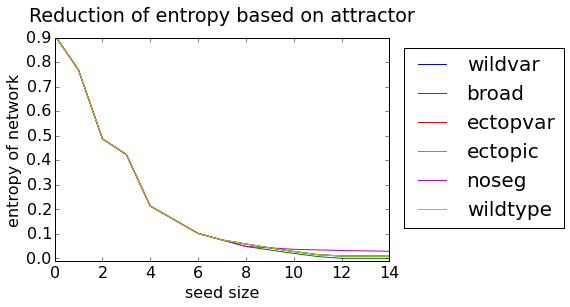

In [202]:
#graph the results
xvalues=range(0,15)
labels=dpattractors.keys()
print labels
#graph attractors
for i,attractor in enumerate(dpattractors):
    plt.plot(xvalues,eval('ap'+str(i)+'[:15]'),label=attractor)
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.55, 1.0), fontsize=20)
plt.title("Reduction of entropy based on attractor",y=1.05)
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [233]:
#rerun noseg attractor
#for seed in sp4:
#    if seed!='()':
#        del entropies_sim[seed]
#        del dpact_prob_sim[seed]
len(sp4)

51

In [234]:
#entropy of strategy; requires ap and sp variables above
t=20
for i,strategy in enumerate(dpattractors): #[sp0,sp1,sp2,sp3,sp4,sp5]
    if strategy!='noseg': continue
    print strategy
    selection=eval('sp'+str(i))
    entropies_sim=strategy_entropy(selection,NP,dpsunit_map,dpmodules,dptranslator,runs=100,tau=0.0,iterations=t,unknown_prob=0.5,
                               stats=dpstats,results=False,time_limit=12,act_prob_sim=dpact_prob_sim,entropies_sim=entropies_sim,t=t)
    for j,seed in enumerate(selection): print to_list(seed,dpsunit_map,dptranslator), eval('ap'+str(i)+'['+str(j)+']'), entropies_sim[seed]

noseg
[] 0.8978782605273133 0.9250000552299288
['SLP_P1-0'] 0.6162601997349245 0.796033782151602
['SLP_P1-0', 'CIA_P3-0'] 0.2002613943615676 0.5917701689223255
['SLP_P1-0', 'ptc_P1-0', 'CIA_P3-0'] 0.15397701032277616 0.569770530189074
['SLP_P1-0', 'ptc_P1-0', 'en_P3-0', 'CIA_P3-0'] 0.07299789352785704 0.4897287650382396
['SLP_P1-0', 'ptc_P1-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1'] 0.03693165248352512 0.2383394414083124
['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1'] 0.025346407497538588 0.2893990250099702
['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'CIA_P3-0', 'SLP_P4-1', 'CI_P4-1'] 0.02034334235302694 0.18065190729361652
['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'en_P3-0', 'PTC_P3-1', 'CIA_P3-0', 'SLP_P4-1', 'CI_P4-1'] 0.01973693224735586 0.20042830535272896
['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'en_P3-0', 'PTC_P3-1', 'CIA_P3-0', 'SLP_P4-1', 'CI_P4-1'] 0.0041574084294328136 0.26397866661455544
['SLP_P1-0', 'ptc_P1-0', 'SLP_P2-0', 'PH_P2-0', 'SLP_P3-1', 

[0.9250000552299288, 0.6857966413153754, 0.5223624254044161, 0.4378826208839132, 0.11770798009948266, 0.07731558853035075, 0.015135900220248594, 0.02254649616305069, 0.017155185038684673, 0.030757143017447103, 0.044190280050878016]
[0.9250000552299288, 0.6840738911186368, 0.490891610528357, 0.47154552430034496, 0.3565837381725553, 0.1480801142199347, 0.09975933424626551, 0.0487833447596319, 0.0, 0.0, 0.0]
[0.9250000552299288, 0.6840738911186368, 0.4995948662635799, 0.40612481112380505, 0.13863812601184952, 0.08312264672833335, 0.020514676711240253, 0.019869396937075786, 0.010514361248261321, 0.009060328879068224, 0.017846322861744483]
[0.9250000552299288, 0.6840738911186368, 0.4995948662635799, 0.40612481112380505, 0.13863812601184952, 0.08312264672833335, 0.020514676711240253, 0.01754515723891792, 0.03428129182082816, 0.019903953258036906, 0.028856936586298496]
[0.9250000552299288, 0.796033782151602, 0.5917701689223255, 0.569770530189074, 0.4897287650382396, 0.2383394414083124, 0.2893

(-0.01, 0.9)

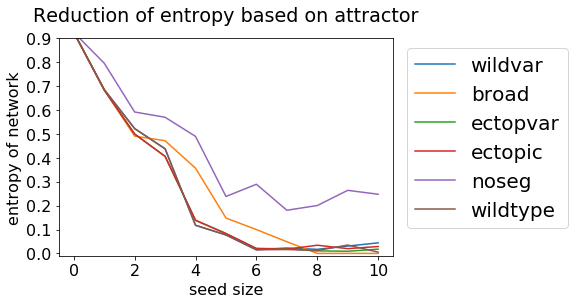

In [185]:
#graph attractors based on simulations of mf selections
#NOTE: seed selection does much better at T=10 than T=20
xvalues=range(11)
for i,attractor in enumerate(dpattractors):
    plt.plot(xvalues,[entropies_sim[seed] for seed in eval('sp'+str(i)+'[:len(xvalues)]')],label=attractor)
    print [entropies_sim[seed] for seed in eval('sp'+str(i)+'[:len(xvalues)]')]
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.55, 1.0), fontsize=20)
plt.title("Reduction of entropy based on attractor",y=1.05)
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [87]:
#entropy of random seed selections averaged over multiple samples
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s 
t=20
selections_ls,avg=avg_random_selections(NP,dpsunits,dpsunit_map,dpmodules,dptranslator,samples=samples,seeds=None,max_s=10,entropies=entropies,
        reduced=True,ds=dp,t=t,runs=runs,stats=dpstats,act_prob_sim=dpact_prob_sim,entropies_sim=entropies_sim,attractor=None,attractors=None,
                                       iterations=t)
print avg,len(selections_ls)

{0: 0.8997596757643335, 1: 0.8396617639941435, 2: 0.7738667829137585, 3: 0.700910829790152, 4: 0.660597842012118, 5: 0.614072366357648, 6: 0.5687733932874405, 7: 0.52659255626584, 8: 0.4792155442616093, 9: 0.4368620386850587, 10: 0.4012152136380689} 100


In [330]:
#entropy of random seed selections averaged over multiple samples for different attractors
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s
#selections_rnd,entropies=random_selection(ND,dsunits,dsunit_map,dmodules,dtranslator,seeds=None,max_s=10,entropies=entropies,
#                            reduced=True,ds=dd,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True)
for i,attractor in enumerate(dpattractors): 
    selections_ls,avg=avg_random_selections(NP,dpsunits,dpsunit_map,dpmodules,dptranslator,samples=samples,seeds=None,max_s=10,entropies=entropies,
        reduced=True,ds=dp,t=10,runs=runs,stats=dpstats,act_prob_sim=dpact_prob_sim,entropies_sim=entropies_sim,attractor=attractor,attractors=dpattractors)
    exec('dpavg'+str(i)+'=[avg[x] for x in avg]') #entropy of selection
    print avg,len(selections_ls)

{0: 0.91552881258740126, 1: 0.83705501803302751, 2: 0.77713157387520904, 3: 0.71587391154678215, 4: 0.6581466383869593, 5: 0.60467449760332115, 6: 0.55203878991519562, 7: 0.49580366688856164, 8: 0.45987349581767412, 9: 0.42487841992229186, 10: 0.39636723561985937} 100
{0: 0.91552881258740126, 1: 0.83871106888880675, 2: 0.77272280351282996, 3: 0.7150600180710045, 4: 0.66271175880896183, 5: 0.60593928359208316, 6: 0.54719136911192368, 7: 0.51433189440315052, 8: 0.4652521113186191, 9: 0.4381447522921908, 10: 0.4040801009911611} 100
{0: 0.91552881258740126, 1: 0.85190282499369918, 2: 0.7895123861673814, 3: 0.73418871488974491, 4: 0.6837565654663158, 5: 0.63420514492547286, 6: 0.58525766722854033, 7: 0.54015664596220136, 8: 0.48806185735595525, 9: 0.44939283386037149, 10: 0.4056752429870209} 100
{0: 0.91552881258740126, 1: 0.84313288912916395, 2: 0.76586702065268752, 3: 0.69892104185782, 4: 0.64618711212247859, 5: 0.59334762166412358, 6: 0.54269287988558201, 7: 0.49826898742409509, 8: 0.446

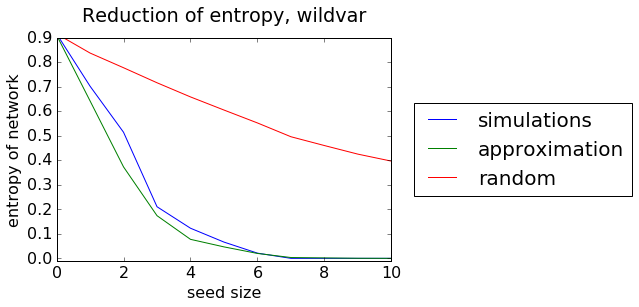

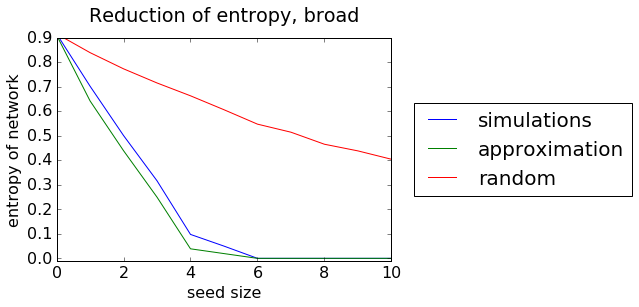

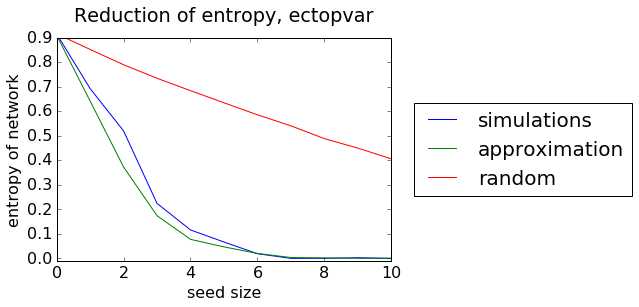

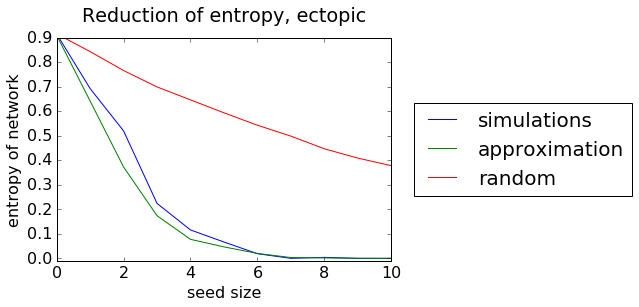

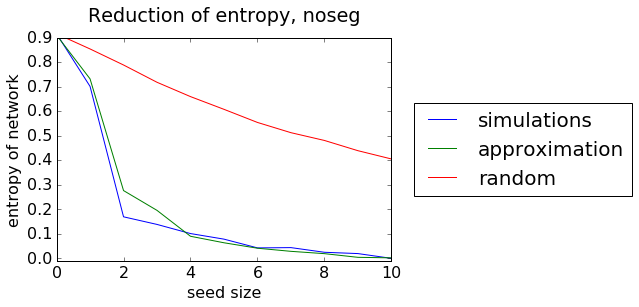

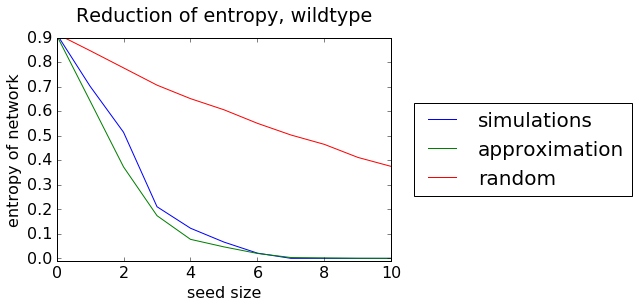

In [333]:
#graph single attractor to compare approximation with simulations of mf selections
xvalues=range(11)
for i,attractor in enumerate(dpattractors):
    plt.plot(xvalues,[entropies_sim[seed] for seed in eval('sp'+str(i)+'[:11]')],label='simulations')
    plt.plot(xvalues,eval('ap'+str(i)+'[:11]'),label='approximation')
    plt.plot(xvalues,eval('dpavg'+str(i)),label='random')
    plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20)
    plt.title("Reduction of entropy, "+attractor,y=1.05)
    plt.ylabel("entropy of network")
    plt.xlabel("seed size")
    plt.yticks(np.arange(0,1,.1))
    plt.ylim([-.01,0.9])
    plt.show()

In [344]:
#see how far actual values are from 0 for our estimated solution
for i,attractor in enumerate(dpattractors):
    for j,evalue in enumerate(eval('ap'+str(i))):
        if evalue==0:
            print attractor,j,eval('ap'+str(i)+'[j]'),entropies_sim[eval('sp'+str(i)+'[j]')]
            break

wildvar 10 0.0 0.0
broad 6 0.0 0.0
ectopvar 10 0.0 0.0
ectopic 10 0.0 0.0
noseg 11 0.0 0.0
wildtype 10 0.0 0.0


wildvar
broad
ectopvar
ectopic
noseg
wildtype


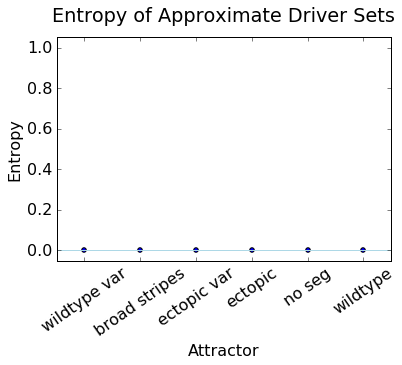

In [787]:
#graph actual entropy of approximate solutions based on simulations
yvalues=[]
for i,attractor in enumerate(dpattractors):
    print attractor
    for j,evalue in enumerate(eval('ap'+str(i))):
        if evalue==0:
            seed=eval('sp'+str(i)+'['+str(j)+']')
            yvalues.append(entropies_sim[seed])
            break

plt.hlines(0.0,-1,6,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(6)],yvalues)
plt.ylim([-0.05,1.05])
plt.xlim([-0.5,5.5])
plt.xticks([i for i in range(6)],['wildtype var','broad stripes','ectopic var','ectopic','no seg', 'wildtype'],rotation=35)
plt.ylabel("Entropy")
plt.xlabel("Attractor")
plt.title("Entropy of Approximate Driver Sets",y=1.05)

In [797]:
#confirm approximate solutions by comparing to DCM modules
for i,attractor in enumerate(dpattractors):
    print attractor,
    for j,evalue in enumerate(eval('ap'+str(i))):
        if evalue==0:
            seed=eval('sp'+str(i)+'['+str(j)+']')
            seed=to_list(seed,dpsunit_map,dptranslator)
            diffusion=BFS_threshold(DCMP,seed,'steady',time_limit=10,pinned={})
            print count_sunits(diffusion),#seed
            diffusion=BFS_threshold(DCMP,seed,'steady',time_limit=11,pinned={})
            print count_sunits(diffusion),
            diffusion=BFS_threshold(DCMP,seed,'steady',time_limit=12,pinned={})
            print count_sunits(diffusion)
            break

wildvar 57 59 60
broad 58 60 60
ectopvar 57 59 60
ectopic 58 59 60
noseg 60 60 60
wildtype 58 59 60


In [216]:
#compare sets between pinned and pulse
wildtype=['SLP_P1-0', 'en_P1-1', 'PTC_P1-0', 'SLP_P2-0', 'wg_P2-0', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1']
wildvar=['SLP_P1-0', 'en_P1-1', 'PTC_P1-1', 'SLP_P2-0', 'wg_P2-0', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1']
broad=['SLP_P1-0', 'en_P1-1', 'SLP_P2-0', 'en_P2-1', 'SLP_P3-1', 'SLP_P4-1']
ectopvar=['SLP_P1-0', 'wg_P1-0', 'SLP_P2-0', 'en_P2-1', 'PTC_P2-1', 'SLP_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1']
noseg=['SLP_P1-0', 'en_P1-0', 'PTC_P1-1', 'CIR_P1-1', 'SLP_P2-0', 'PTC_P2-1', 'SLP_P3-1', 'PTC_P3-1', 'CIR_P3-1', 'SLP_P4-1', 'PTC_P4-1']
ectopic=['SLP_P1-0', 'wg_P1-0', 'SLP_P2-0', 'en_P2-1', 'PTC_P2-0', 'SLP_P3-1', 'SLP_P4-1', 'PTC_P4-1', 'CIR_P4-1']
wv2=['SLP_P1-0', 'en_P1-0', 'EN_P1-0', 'PTC_P1-0', 'ci_P1-1', 'CI_P1-1', 'CIA_P1-1', 'CIR_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'wg_P3-1', 'en_P3-1', 'hh_P3-1', 'CI_P3-1', 'SLP_P4-1', 'en_P4-1', 'EN_P4-1', 'CIA_P4-1', 'CIR_P4-0']
broad2=['SLP_P1-0', 'wg_P1-1', 'en_P1-1', 'SLP_P2-0', 'wg_P2-1', 'SLP_P3-1', 'hh_P3-1', 'CI_P3-1', 'SLP_P4-1', 'en_P4-1', 'hh_P4-1', 'CI_P4-1']
ev2=['SLP_P1-0', 'WG_P1-1', 'SLP_P2-0', 'wg_P2-1', 'en_P2-0', 'EN_P2-0', 'PTC_P2-0', 'ci_P2-1', 'CI_P2-1', 'CIR_P2-0', 'SLP_P3-1', 'EN_P3-1', 'CIA_P3-1', 'CIR_P3-0', 'SLP_P4-1', 'wg_P4-1', 'en_P4-1', 'hh_P4-1', 'CI_P4-1']
ectopic2=['SLP_P1-0', 'WG_P1-1', 'en_P1-1', 'SLP_P2-0', 'wg_P2-1', 'en_P2-0', 'EN_P2-0', 'PTC_P2-0', 'ci_P2-1', 'CI_P2-1', 'CIR_P2-0', 'SLP_P3-1', 'wg_P3-1', 'EN_P3-1', 'CIR_P3-0', 'SLP_P4-1', 'wg_P4-1', 'en_P4-1', 'hh_P4-1', 'CI_P4-1']
noseg2=['SLP_P1-0', 'ci_P1-1', 'CI_P1-1', 'CIA_P1-1', 'CIR_P1-0', 'SLP_P2-0', 'ci_P2-1', 'CI_P2-1', 'CIA_P2-1', 'CIR_P2-0', 'SLP_P3-1', 'hh_P3-1', 'ci_P3-0', 'CI_P3-1', 'CIR_P3-0', 'SLP_P4-1', 'hh_P4-1', 'ci_P4-0', 'CI_P4-1', 'CIR_P4-0']
wildtype2=['SLP_P1-0', 'en_P1-0', 'EN_P1-0', 'PTC_P1-0', 'ci_P1-1', 'CI_P1-1', 'CIA_P1-1', 'CIR_P1-0', 'SLP_P2-0', 'SLP_P3-1', 'wg_P3-1', 'en_P3-1', 'CI_P3-1', 'SLP_P4-1', 'wg_P4-1', 'en_P4-1', 'EN_P4-1', 'CIR_P4-0']
jmeasures=[]
for set1,set2 in zip([wildtype,wildvar,broad,ectopic,ectopvar,noseg],[wildtype2,wv2,broad2,ectopic2,ev2,noseg2]):
    set1,set2=set(set1),set(set2)
    print compute_jaccard(set1,set2)
    jmeasures.append(compute_jaccard(set1,set2))

0.227272727273
0.166666666667
0.384615384615
0.208333333333
0.166666666667
0.148148148148


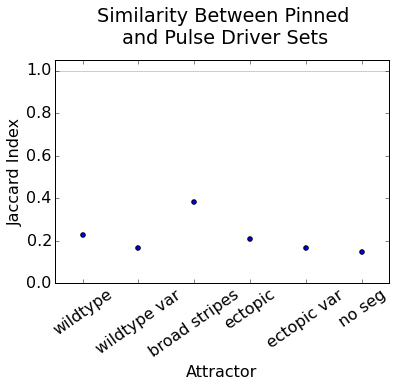

In [217]:
#graph differences in driver sets chosen via the Jaccard measure for pinned and pulse perturbations
#NOTE: the value for attractor 6 is incorrect due to an error in our seed selection
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(6)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,5.5])
plt.xticks([i for i in range(6)],['wildtype','wildtype var','broad stripes','ectopic','ectopic var','no seg'],rotation=35)
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Pinned \n and Pulse Driver Sets",y=1.05)

In [211]:
#check the results based on reduced selections
reduced_selections=[eval('rsp'+str(i)+'[-1]') for i in range(6)] #in order of attractor
yvalues=[]
for i,attractor in enumerate(dpattractors):
    print attractor, 
    seed=reduced_selections[i]
    seed=to_list(seed,dpsunit_map,dptranslator)
    diffusion=BFS_threshold(DCMP,seed,'pulse',time_limit=10,pinned={})
    print count_sunits(diffusion,pinned=False)#seed
    yvalues.append(count_sunits(diffusion,pinned=False))
    #diffusion=BFS_threshold(DCM,seed,'pulse',time_limit=15,pinned={})
    #print count_sunits(diffusion,pinned=False)

 wildvar 30
broad 59
ectopvar 39
ectopic 43
noseg 22
wildtype 26


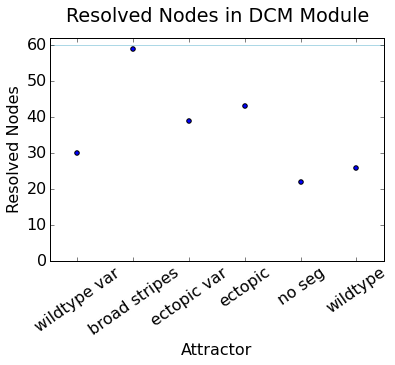

In [218]:
#graph resolved nodes for pulse perturbation
plt.hlines(60.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(6)],yvalues)
plt.ylim([0,62])
plt.xlim([-0.5,5.5])
plt.xticks([i for i in range(6)],['wildtype var','broad stripes','ectopic var','ectopic','no seg', 'wildtype'],rotation=35)
plt.ylabel("Resolved Nodes")
plt.xlabel("Attractor")
plt.title("Resolved Nodes in DCM Module",y=1.05)

#### Leukemia

In [808]:
#compare the mean-field approximation to pathway modules in leukemia
#prob p=0 means the node is OFF, p=1 means the node is ON, and p=.5 means the state is completely unknown
NL = LEUKEMIA()

In [809]:
iterations=10
dl={node.name: LUT_reduce(look_up_table(node)) for node in NL.nodes}
print len(dl),dl.keys()
act_prob = {i: {node.name: 0.5 for node in NL.nodes} for i in range(iterations+1)}
for node in NL.nodes:
    print mf_approx(node,act_prob,1,reduced=True,ds=dl)
    print mf_approx(node,act_prob,1,reduced=False,ds=None)

60 ['TAX', 'FasT', 'FYN', 'SPHK1', 'FLIP', 'PLCG1', 'DISC', 'TPL2', 'Stimuli2', 'ERK', 'Proliferation', 'STAT3', 'IL2RBT', 'Fas', 'BID', 'TCR', 'Caspase', 'TRADD', 'GAP', 'CD45', 'GPCR', 'PDGF', 'ZAP70', 'FasL', 'IL15', 'SOCS', 'RAS', 'P2', 'CTLA4', 'sFas', 'Cytoskeleton_signaling', 'PI3K', 'IFNG', 'Stimuli', 'S1P', 'PDGFR', 'TNF', 'JAK', 'SMAD', 'IFNGT', 'BclxL', 'IAP', 'NFAT', 'A20', 'IL2RA', 'IL2RB', 'GZMB', 'NFKB', 'Ceramide', 'TBET', 'MEK', 'P27', 'GRB2', 'IL2', 'Apoptosis', 'CREB', 'RANTES', 'LCK', 'IL2RAT', 'MCL1']
(0.5, 1)
(0.5, 1)
(0.25, 1)
(0.25, 1)
(0.75, 1)
(0.75, 3)
(0.75, 1)
(0.75, 3)
(0.5, 1)
(0.5, 1)
(0.6875, 5)
(0.6875, 11)
(0.25, 1)
(0.25, 1)
(0.75, 1)
(0.75, 3)
(0.75, 1)
(0.75, 3)
(0.375, 3)
(0.375, 3)
(0.15625, 5)
(0.15625, 5)
(0.5, 1)
(0.5, 1)
(0.25, 1)
(0.25, 1)
(0.75, 1)
(0.75, 3)
(0.78125, 7)
(0.78125, 25)
(0.5, 1)
(0.5, 1)
(0.5, 1)
(0.5, 1)
(0.4375, 7)
(0.4375, 7)
(0.25, 1)
(0.25, 1)
(0.375, 3)
(0.375, 3)
(0.375, 3)
(0.375, 3)
(0.125, 1)
(0.125, 1)
(0.234375, 1

In [810]:
lmodules,ltranslator={},{}
lsunits,lsunit_map=get_sunits(NL)
print len(lsunits),lsunit_map

120 {0: 'CTLA4-0', 1: 'CTLA4-1', 2: 'TCR-0', 3: 'TCR-1', 4: 'PDGFR-0', 5: 'PDGFR-1', 6: 'FYN-0', 7: 'FYN-1', 8: 'Cytoskeleton_signaling-0', 9: 'Cytoskeleton_signaling-1', 10: 'LCK-0', 11: 'LCK-1', 12: 'ZAP70-0', 13: 'ZAP70-1', 14: 'GRB2-0', 15: 'GRB2-1', 16: 'PLCG1-0', 17: 'PLCG1-1', 18: 'RAS-0', 19: 'RAS-1', 20: 'GAP-0', 21: 'GAP-1', 22: 'MEK-0', 23: 'MEK-1', 24: 'ERK-0', 25: 'ERK-1', 26: 'PI3K-0', 27: 'PI3K-1', 28: 'NFKB-0', 29: 'NFKB-1', 30: 'NFAT-0', 31: 'NFAT-1', 32: 'RANTES-0', 33: 'RANTES-1', 34: 'IL2-0', 35: 'IL2-1', 36: 'IL2RBT-0', 37: 'IL2RBT-1', 38: 'IL2RB-0', 39: 'IL2RB-1', 40: 'IL2RAT-0', 41: 'IL2RAT-1', 42: 'IL2RA-0', 43: 'IL2RA-1', 44: 'JAK-0', 45: 'JAK-1', 46: 'SOCS-0', 47: 'SOCS-1', 48: 'STAT3-0', 49: 'STAT3-1', 50: 'P27-0', 51: 'P27-1', 52: 'Proliferation-0', 53: 'Proliferation-1', 54: 'TBET-0', 55: 'TBET-1', 56: 'CREB-0', 57: 'CREB-1', 58: 'IFNGT-0', 59: 'IFNGT-1', 60: 'IFNG-0', 61: 'IFNG-1', 62: 'P2-0', 63: 'P2-1', 64: 'GZMB-0', 65: 'GZMB-1', 66: 'TPL2-0', 67: 'TPL2

In [811]:
#find pathway modules for leukemia (slow)
start_time = time.time() #samples=280
lmodules,ltranslator=find_modules(NL,0,lsunits,lsunit_map,lmodules,ltranslator,
                                  reduced=True,ds=dl,pinning={},iterations=15,data=True,samples=None)
print("--- %s seconds ---" % (time.time() - start_time))

seeds: 1
--- 0.710999965668 seconds ---


In [812]:
len(lmodules)
#lmodules['()'].keys()

1

In [400]:
#find information modules for leukemia (fast)
start_time = time.time()
print "All pathway modules:",len(lmodules)
ltm = info_modules(lmodules,ltranslator,s=2)
print "information modules:",len(ltm)
for seed in sorted(ltm,key=lambda x: len(ltm[x]),reverse=True): #print out top modules
    print to_list(seed,lsunit_map,ltranslator),len(lmodules[seed])#,lmodules[seed]
print("--- %s seconds ---" % (time.time() - start_time))

All pathway modules: 7260
information modules: 178
['TBET-0', 'S1P-1'] 41
['PDGFR-0', 'RAS-1'] 30
['S1P-1', 'IL15-1'] 30
['Ceramide-1', 'S1P-1'] 30
['SPHK1-0', 'PDGF-1'] 29
['S1P-0', 'PDGF-1'] 29
['MCL1-1', 'S1P-1'] 29
['TBET-0', 'PDGF-1'] 27
['NFKB-0', 'JAK-1'] 27
['IL2RB-1', 'TBET-0'] 26
['NFKB-0', 'PDGF-1'] 26
['IL2RBT-1', 'TBET-0'] 26
['IL2-1', 'IL2RBT-1'] 26
['IL2RBT-1', 'IL15-1'] 25
['PDGFR-0', 'TAX-1'] 25
['FasT-0', 'PDGF-1'] 25
['FasL-0', 'PDGF-1'] 25
['RAS-1', 'JAK-1'] 25
['GAP-1', 'JAK-1'] 24
['ZAP70-1', 'TBET-0'] 24
['RAS-0', 'JAK-1'] 24
['PI3K-0', 'JAK-1'] 23
['PI3K-0', 'TAX-0'] 22
['PDGF-1', 'IL15-1'] 22
['sFas-0', 'S1P-1'] 22
['NFKB-0', 'CD45-1'] 22
['ZAP70-1', 'IL2-1'] 21
['RAS-0', 'NFKB-0'] 20
['NFKB-0', 'IL2RB-1'] 20
['GAP-1', 'NFKB-0'] 20
['ZAP70-1', 'IL15-1'] 20
['NFKB-0', 'SOCS-1'] 20
['JAK-1', 'IL15-0'] 20
['PDGFR-0', 'GRB2-0'] 19
['MCL1-1', 'PDGF-1'] 19
['BclxL-1', 'PDGF-1'] 19
['RAS-1', 'FasT-0'] 19
['TBET-1', 'CD45-1'] 19
['RAS-1', 'FasL-0'] 18
['RAS-1', 'IFNG-1

In [101]:
#json dump and retrieve
#with open('lmodules-s2.json', 'w') as fp:
#    json.dump(lmodules, fp)

In [109]:
#m3=json.load(open( "lmodules-s2.json" ))
#print len(m3)
#lmodules={} #create a clean lmodules that does not have any unicode keys (default)
#for seed in m3:
#    lmodules[str(seed)]={int(i):m3[seed][i] for i in m3[seed]}

In [111]:
ltranslator=create_translator(NL,s=0,sunits=lsunits,sunit_map=lsunit_map,translator=ltranslator) #create translator
print len(ltranslator),len(lmodules)
for seed in lmodules: pass
#print repr(seed),lmodules[seed]
#print lmodules['()'][10]

7261 7261


In [196]:
#s=0, NOTE inherent biases, such as TRADD=0 and IFNGT=1
lstats={}
t=15
lsimulations=compare_simulations(NL,['()'],lsunit_map,lmodules,ltranslator,length=0,runs=100,tau=0.0,iterations=t,
                        unknown_prob=0.5,stats=lstats,results=False,time_limit=12)
aggregate_simulation('()',lsimulations)['()'][t]

{'A20': 0.89,
 'Apoptosis': 0.89,
 'BID': 0.9,
 'BclxL': 0.05,
 'CD45': 0.59,
 'CREB': 0.06,
 'CTLA4': 0.22,
 'Caspase': 0.89,
 'Ceramide': 0.32,
 'Cytoskeleton_signaling': 0.51,
 'DISC': 0.41,
 'ERK': 0.57,
 'FLIP': 0.55,
 'FYN': 0.51,
 'Fas': 0.41,
 'FasL': 0.93,
 'FasT': 0.89,
 'GAP': 0.33,
 'GPCR': 0.55,
 'GRB2': 0.55,
 'GZMB': 0.83,
 'IAP': 0.13,
 'IFNG': 0.13,
 'IFNGT': 0.99,
 'IL15': 0.47,
 'IL2': 0.17,
 'IL2RA': 0.08,
 'IL2RAT': 0.17,
 'IL2RB': 0.28,
 'IL2RBT': 0.35,
 'JAK': 0.23,
 'LCK': 0.77,
 'MCL1': 0.04,
 'MEK': 0.6,
 'NFAT': 0.86,
 'NFKB': 0.92,
 'P2': 0.58,
 'P27': 0.25,
 'PDGF': 0.54,
 'PDGFR': 0.61,
 'PI3K': 0.86,
 'PLCG1': 0.82,
 'Proliferation': 0.03,
 'RANTES': 0.89,
 'RAS': 0.55,
 'S1P': 0.46,
 'SMAD': 0.47,
 'SOCS': 0.08,
 'SPHK1': 0.61,
 'STAT3': 0.2,
 'Stimuli': 0.5,
 'Stimuli2': 0.4,
 'TAX': 0.42,
 'TBET': 0.83,
 'TCR': 0.24,
 'TNF': 0.89,
 'TPL2': 0.86,
 'TRADD': 0.0,
 'ZAP70': 0.24,
 'sFas': 0.55}

In [813]:
#DCM=NL.dynamics_canalization_map(output=None, )
submodules={seed:lmodules[seed] for seed in lmodules if len(to_list(seed,lsunit_map,ltranslator))==0}
#subsample=create_samples(submodules,1000,lsunit_map,ltranslator,s=3)
len(submodules)

1

In [816]:
#compare to simulations
#seeds=lmodules.keys() #lmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
seeds=submodules.keys() #['(0, 33)'], ['(7,)'], ['(13,)']
lstats={}
length=0
simulations=compare_simulations(NL,seeds,lsunit_map,lmodules,ltranslator,length=length,runs=100,
                tau=0.0,iterations=15,unknown_prob=0.5,stats=lstats,results=True) #time_limit=12

total seeds: 1
true positives: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false negatives: [0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 0.98, 0.98, 0.98, 0.95, 0.88, 0.97, 0.98, 0.97, 0.97, 0.97, 0.98, 0.97, 0.97, 0.97]
recall: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errors: [0.003, 0.002, 0.003, 0.004, 0.005, 0.005, 0.005, 0.006, 0.007, 0.007, 0.008, 0.009, 0.009, 0.01, 0.011, 0.014]


In [817]:
#NOTE: network tends towards apoptosis and no proliferation
len(simulations)#,simulations['()'][random.choice(simulations['()'].keys())]
lmodules.keys()

['()']

In [819]:
#compare to baseline
seeds=lmodules.keys() #lmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample.keys() #['(0, 33)'], ['(7,)'], ['(13,)']
lbstats={}
compare_baseline(NL,seeds,lsunit_map,ltranslator,simulations,length=length,tau=0.0,iterations=15,stats=lbstats,results=True)

100 total runs, 1.0 seeds
true positives: [1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.01, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.0, 0.0, 0.02, 0.02, 0.02, 0.05, 0.12, 0.03, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03, 0.03]
recall: [1.0, 0.99, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.0, 0.0, 0.02, 0.02, 0.02, 0.05, 0.12, 0.03, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03, 0.03]
average similarity: [0.0, 0.0, 0.02, 0.02, 0.02, 0.05, 0.12, 0.03, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03, 0.03]
errors: [0.252, 0.202, 0.182, 0.169, 0.171, 0.172, 0.166, 0.168, 0.169, 0.173, 0.171, 0.174, 0.173, 0.172, 0.171, 0.175]


In [596]:
#graph stats
exec('errors'+str(length)+"=lstats['errors']")
exec('sim'+str(length)+"=lstats['avg_sim']")
exec('accuracy'+str(length)+"=lstats['accuracy']")
exec('precision'+str(length)+"=lstats['precision']")
exec('recall'+str(length)+"=lstats['recall']")
#graph baseline
exec('berrors'+str(length)+"=lbstats['errors']")
exec('bsim'+str(length)+"=lbstats['avg_sim']")
exec('baccuracy'+str(length)+"=lbstats['accuracy']")
exec('bprecision'+str(length)+"=lbstats['precision']")
exec('brecall'+str(length)+"=lbstats['recall']")

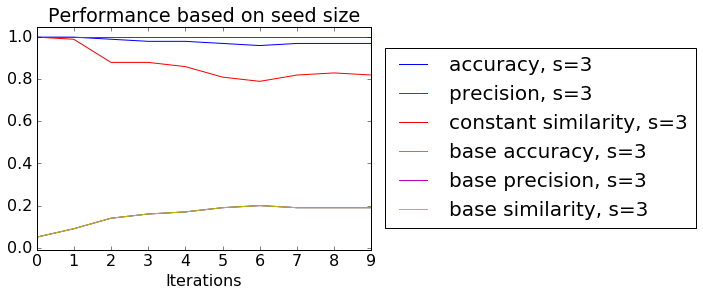

In [603]:
#graph comparison between s=1 and s=2
xvalues=[i for i in range(iterations)]
var1=str(length) #what to graph
#accuracy
plt.plot(xvalues,eval('accuracy'+var1),label='accuracy, s='+var1)
#plt.plot(xvalues,accuracy2,label='accuracy, s=2')
#precision
plt.plot(xvalues,eval('precision'+var1),label='precision, s='+var1)
#plt.plot(xvalues,precision2,label='precision, s=2')
#errors
#plt.plot(xvalues,errors0,label='error, s=0')
#plt.plot(xvalues,errors1,label='error, s=1')
#plt.plot(xvalues,errors2,label='error, s=2')
#plt.plot(xvalues,errors3,label='error, s=3')
#plt.plot(xvalues,errors4,label='error, s=4')
#plt.plot(xvalues,errors5,label='error, s=5')
#average similarity of constants
plt.plot(xvalues,eval('sim'+var1),label='constant similarity, s='+var1)
#plt.plot(xvalues,sim2,label='constant similarity, s=2')
#baselines
plt.plot(xvalues,eval('baccuracy'+var1),label='base accuracy, s='+var1)
#plt.plot(xvalues,baccuracy2,label='base accuracy, s=2')
plt.plot(xvalues,eval('bprecision'+var1),label='base precision, s='+var1)
#plt.plot(xvalues,bprecision2,label='base precision, s=2')
plt.plot(xvalues,eval('bsim'+var1),label='base similarity, s='+var1)
#plt.plot(xvalues,bsim2,label='base similarity, s=2')
#plt.plot(xvalues,berrors0,label='base error, s=0')
#plt.plot(xvalues,berrors1,label='base error, s=1')
#plt.plot(xvalues,berrors2,label='base error, s=2')
#plt.plot(xvalues,berrors3,label='base error, s=3')

plt.title('Performance based on seed size')
plt.xlabel('Iterations')
#plt.ylabel('')
plt.ylim([-0.01,1.05])
#plt.ylim([-0.0,0.015])
plt.legend(bbox_to_anchor=(2.0, 0.8), fontsize=20)
#plt.legend(bbox_to_anchor=(1.75, 1.05), fontsize=20) #errors
plt.legend(bbox_to_anchor=(2.0, 0.95), fontsize=20) #with baselines

In [1048]:
seeds=['(107, 111, 116)',] #lowest entropy seed
low_simulation=compare_simulations(NL,seeds,lsunit_map,submodules,ltranslator,length=3,runs=100,tau=0.0,iterations=10,
                        unknown_prob=0.5,stats={},results=True,time_limit=12)

#act_prob_sim[seed]={index:{node:act_prob_sim[seed][index][node]/runs for node in act_prob_sim[seed][index]} for index in range(iterations)}

total seeds: 1
true positives: [1.0, 0.89, 0.86, 0.89, 0.89, 0.8, 0.76, 0.84, 0.85, 0.9]
false negatives: [0.0, 0.11, 0.14, 0.11, 0.11, 0.2, 0.24, 0.16, 0.15, 0.1]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 0.98, 0.97, 0.97, 0.95, 0.88, 0.83, 0.88, 0.88, 0.92]
recall: [1.0, 0.89, 0.86, 0.89, 0.89, 0.8, 0.76, 0.84, 0.85, 0.9]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 0.89, 0.86, 0.89, 0.89, 0.8, 0.76, 0.84, 0.85, 0.9]
errors: [0.006, 0.006, 0.008, 0.007, 0.008, 0.009, 0.009, 0.009, 0.008, 0.008]


In [ ]:
#check the configuration with the least resulting entropy
seed='(107, 111, 116)'
low_sim=aggregate_simulation(seed,low_simulation)

In [162]:
del subsimulations
subsimulations={}
for i,seed in enumerate(simulations):
    if i<7001: continue
    subsimulations[seed]=simulations[seed]
len(subsimulations)

79

In [163]:
#find entropies of simulations
#act_prob_sim={seed:{} for seed in simulations}
for seed in subsimulations: act_prob_sim[seed]={}
for seed in subsimulations:
    aggregate_simulation(seed,subsimulations,act_prob_sim)

len(act_prob_sim)

7201

In [179]:
#node entropies
length=2
seeds=reduce_seeds(act_prob_sim,lsunit_map,ltranslator,length=length)
seed_entropies1,seed_configs=seed_node_entropies(act_prob_sim,seeds,base=2,normalized=True,data=False)
seed_entropy,seed_configs=seed_entropies(act_prob_sim,seeds,normalized=True,data=False) #simulations
len(seed_entropies1),len(seed_entropy)

(7080, 7080)

In [181]:
#json dump and retrieve
#with open('leukemia_simulations_s2', 'w') as fp:
#    json.dump(simulations, fp)
#with open('lact_prob_sim-s2', 'w') as fp:
#    json.dump(act_prob_sim, fp)
#seed_entropies2

#with open('leukemia_simulations_node_entropies_s2.json', 'w') as fp:
#    json.dump(seed_entropies1, fp)
#with open('leukemia_simulations_entropies_s2.json', 'w') as fp:
#    json.dump(seed_entropy, fp)

1.0
Normalized entropy: [1.0, 0.84, 0.76, 0.73, 0.72, 0.71, 0.71, 0.72, 0.72, 0.73, 0.74] [1.0, 0.84, 0.76, 0.73, 0.72, 0.71, 0.71, 0.72, 0.72, 0.73, 0.74]
Probable configurations: ['9.47e+17', '1.38e+15', '6.39e+13', '1.25e+13', '1.24e+13', '8.09e+12', '6.69e+12', '8.79e+12', '1.22e+13', '1.79e+13', '1.91e+13']


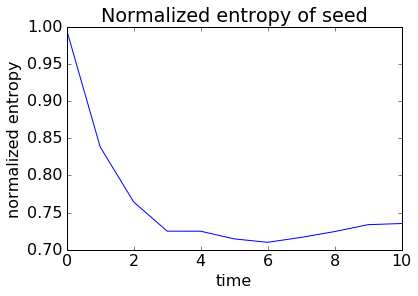

{0: 0.99526774268759821, 1: 0.83827456220411278, 2: 0.76432923105405848, 3: 0.72506216975453719, 4: 0.72499416495110813, 5: 0.71466477275020879, 6: 0.710088732009171, 7: 0.71665043079126522, 8: 0.72446805014375004, 9: 0.73377330546543407, 10: 0.73532049127130172}
{0: 1.0, 1: 1.0, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.25, 6: 0.25, 7: 0.5, 8: 0.25, 9: 0.5, 10: 0.25}
Total possible configurations: [1.0, 1.0, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25] [1.0, 1.0, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25]


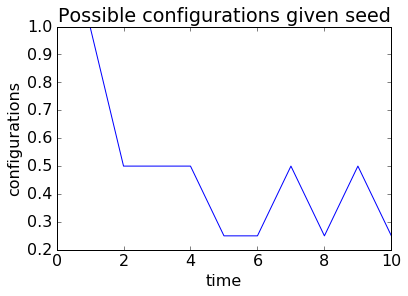

In [222]:
#single seed entropy
seed='()' #'(3,)','(9, 32, 82)','(107, 111, 116)','(109, 111)'
diffusion=act_prob_sim[seed] #lmodules[seed], act_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
xvalues=seed_entropy.keys()
yvalues=[seed_entropy[key] for key in seed_entropy]
#yvalues=[yvalue/yvalues[0] for yvalue in yvalues]
plt.plot(xvalues,yvalues)
#plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed")
plt.ylabel("normalized entropy")
plt.xlabel("time")
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.show()
#plot configs
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True,strict=True)
print seed_entropy
print seed_configs
xvalues=seed_configs.keys()
y1values=[seed_configs[key] for key in seed_configs]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [190]:
#low_sim
submodules={seed:lmodules[seed] for seed in lmodules if len(to_list(seed,lsunit_map,ltranslator))==1}
len(act_prob_sim),len(simulations),len(lmodules),len(submodules)

(7201, 120, 7261, 120)

Normalized entropy: [0.98, 0.82, 0.74, 0.69, 0.68, 0.67, 0.66, 0.68, 0.68, 0.69, 0.69] [1.0, 0.83, 0.75, 0.7, 0.69, 0.68, 0.68, 0.69, 0.69, 0.7, 0.7]
Probable configurations: ['5.60e+17', '5.55e+14', '2.08e+13', '3.20e+12', '1.83e+12', '1.13e+12', '9.65e+11', '1.58e+12', '1.79e+12', '2.58e+12', '2.46e+12']


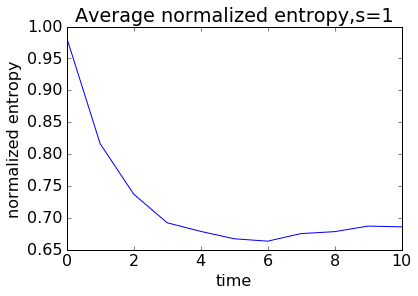

Total possible configurations: [0.5, 0.33, 0.16, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.14] [1.0, 0.66, 0.31, 0.3, 0.3, 0.3, 0.3, 0.29, 0.29, 0.29, 0.29]


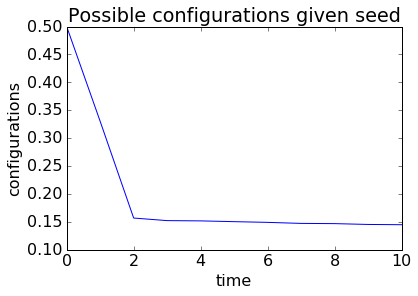

In [191]:
#multiple seed entropies
length,iterations=1,10
#seeds=reduce_seeds(lmodules,lsunit_map,ltranslator,length=length) #['()','(3,)']
seeds=simulations.keys() #simulation entropies or submodules
seed_entropy,seed_configs=seed_entropies(act_prob_sim,seeds,normalized=True,data=False) #submodules,act_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
#yvalues=[yvalue/yvalues[0] for yvalue in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,yvalues)
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(act_prob_sim,seeds,normalized=True,data=False,strict=True) #submodules,act_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [889]:
#fix seeds
for seed in lmodules:
    for t in range(iterations+1):
        for node in lmodules[seed][t]:
            if lmodules[seed][t][node]>1: lmodules[seed][t][node]=1.0
            
            if lmodules[seed][t][node]<0: lmodules[seed][t][node]=0.0

In [192]:
#entropies3={key:seed_entropy[key] for key in seed_entropy}
#entropies2={key:seed_entropy[key] for key in seed_entropy}
#entropies1={key:seed_entropy[key] for key in seed_entropy}
#entropies0={'()': seed_entropy}
#yvalues3=[np.mean([entropies3[seed][t] for seed in entropies3])/60 for t in xvalues]
#yvalues2=[np.mean([entropies2[seed][t] for seed in entropies2])/yvalues[0] for t in xvalues]
#yvalues1=[np.mean([entropies1[seed][t] for seed in entropies1])/yvalues[0] for t in xvalues]
#yvalues0=[np.mean([entropies0[seed][t] for seed in entropies0]) for t in xvalues]
#ysvalues2=[yvalue*60/58 for yvalue in yvalues]
#ysvalues1=[yvalue*60/59 for yvalue in yvalues]
ysvalues1_2=[yvalue*60/59 for yvalue in yvalues]
#ysvalues0=[yvalue for yvalue in yvalues]
#print entropies0,seed_entropy
print ysvalues1_2,yvalues0,yvalues1,yvalues2#,yvalues3

[0.99929376383319912, 0.83014276118816055, 0.74984922393542919, 0.70411621108318989, 0.69040022444308335, 0.67862580913463966, 0.67478713411503333, 0.68687270432384573, 0.68993994294354255, 0.69879992772628829, 0.69763761840769523] [1.0, 0.84097036267286995, 0.77138724746513054, 0.72800513368827724, 0.7146167103922495, 0.68966570612154365, 0.66754326872706726, 0.65210027843521956, 0.63526516176202985, 0.62707145379633122, 0.62312976566454303] [1.0, 0.83088893820037668, 0.75529217565640061, 0.70837093292542541, 0.69174524934520787, 0.6653373848699653, 0.64301021851130102, 0.62717483767496762, 0.61041420281062608, 0.60141023638308433, 0.59585999551519386] [1.0, 0.82080934891295221, 0.73934351993882164, 0.68902496497319965, 0.66944149965507471, 0.64190873679992955, 0.61949613332059428, 0.60346381318721942, 0.58694730768621506, 0.5773382463827883, 0.5706254914259723]


In [193]:
#why is there a discrepancy between the mean-field and the simulations starting around t=5?
seeds,t,nodes=simulations.keys(),10,[node.name for node in NL.nodes] #seeds=['(3,)'], simulations or submodules
print len(seeds)
diff={node:0.0 for node in nodes} #{node:abs(lmodules[seed][t][node]-act_prob_sim[seed][t][node]) for node in lmodules[seed][t]}
for seed in seeds:
    for node in nodes:
        diff[node]+=abs(lmodules[seed][t][node]-act_prob_sim[seed][t][node])
diff={node:diff[node]/len(seeds) for node in diff}
print 'node','mf','sim','diff'
for node in sorted(diff,key=lambda x: diff[x],reverse=True)[:10]:
    avg1,avg2=np.mean([lmodules[seed][t][node] for seed in seeds]),np.mean([act_prob_sim[seed][t][node] for seed in seeds])
    print node,round(avg1,2),round(avg2,2),round(diff[node],2)
    #print node,round(lmodules[seed][t][node],2),act_prob_sim[seed][t][node],round(diff[node],2)

120
node mf sim diff
P2 0.21 0.485 0.26
S1P 0.67 0.447 0.2
Ceramide 0.13 0.351 0.19
PDGFR 0.82 0.616 0.19
SPHK1 0.8 0.614 0.18
Proliferation 0.24 0.055 0.17
GRB2 0.45 0.591 0.13
IL2RBT 0.59 0.455 0.12
TBET 1.0 0.884 0.11
DISC 0.3 0.401 0.11


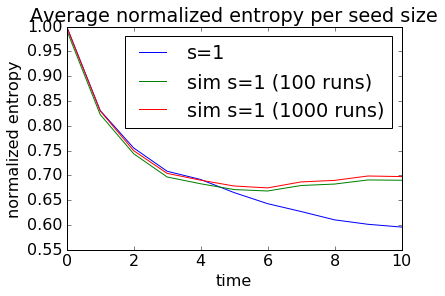

In [196]:
#plot entropy per seed size
iterations=10
xvalues=[t for t in range(iterations+1)]
#plt.plot(xvalues,yvalues0,label='s=0')
plt.plot(xvalues,yvalues1,label='s=1')
#plt.plot(xvalues,yvalues2,label='s=2')
#plt.plot(xvalues,yvalues3,label='s=3')
#plt.plot(xvalues,ysvalues0,label='sim s=0')
plt.plot(xvalues,ysvalues1,label='sim s=1 (100 runs)')
plt.plot(xvalues,ysvalues1_2,label='sim s=1 (1000 runs)')
#plt.plot(xvalues,ysvalues2,label='sim s=2')
#plt.ylim([.5,1.03])
plt.title("Average normalized entropy per seed size")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.legend() #bbox_to_anchor=(1.5, 0.95)

Normalized entropy: [1.0, 0.84, 0.77, 0.73, 0.71, 0.69, 0.67, 0.65, 0.64, 0.63, 0.62]
Possible configurations: ['1.15e+18', '1.55e+15', '8.56e+13', '1.41e+13', '8.08e+12', '2.86e+12', '1.14e+12', '6.00e+11', '2.98e+11', '2.12e+11', '1.80e+11']
Normalized entropy: [0.98, 0.82, 0.74, 0.7, 0.68, 0.65, 0.63, 0.62, 0.6, 0.59, 0.59]
Possible configurations: ['5.76e+17', '5.72e+14', '2.60e+13', '3.81e+12', '1.93e+12', '6.56e+11', '2.63e+11', '1.38e+11', '6.94e+10', '4.80e+10', '3.83e+10']
Normalized entropy: [0.97, 0.79, 0.71, 0.67, 0.65, 0.62, 0.6, 0.58, 0.57, 0.56, 0.55]
Possible configurations: ['2.88e+17', '2.14e+14', '8.08e+12', '1.07e+12', '4.86e+11', '1.60e+11', '6.51e+10', '3.42e+10', '1.76e+10', '1.19e+10', '9.11e+09']
Normalized entropy: [0.95, 0.77, 0.69, 0.64, 0.61, 0.59, 0.57, 0.55, 0.54, 0.53, 0.52]
Possible configurations: ['1.44e+17', '8.08e+13', '2.57e+12', '3.10e+11', '1.28e+11', '4.17e+10', '1.72e+10', '9.12e+09', '4.82e+09', '3.24e+09', '2.41e+09']


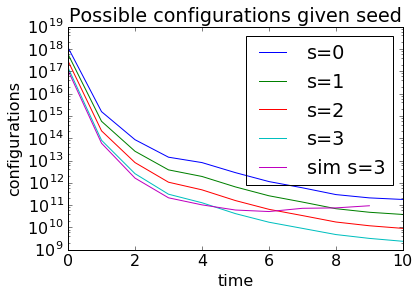

In [1035]:
#plot configurations per seed size
#sum([entropy([.5,.5],base=2) for node in NL.nodes]) #max entropy
#plot configs
xvalues1=xvalues
for i,yvalues in enumerate([yvalues0,yvalues1,yvalues2,yvalues3]): #[yvalues0,yvalues1,yvalues2,yvalues3]
    print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues]
    yvalues=[2**(y * 60) for y in yvalues]
    print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in yvalues]
    plt.plot(xvalues1,yvalues,label='s='+str(i))
plt.plot(xvalues[:-1],[2**(y * 60) for y in ysvalues],label='sim s=3') #simulations
plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.legend()

In [994]:
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][10]) #sort by final entropy, lowest entropy first
len(sorted_entropies)

120

In [54]:
#graph entropy over time
seeds=reduce_seeds(lmodules,lsunit_map,ltranslator,length=3)
submodules={seed:lmodules[seed] for seed in seeds}
seed_entropy,seed_configs=seed_entropies(submodules,submodules.keys(),normalized=True,data=True)
sorted_entropies=sorted(seed_entropy,key=lambda x: seed_entropy[x][10])
len(sorted_entropies)

average entropy: [0.95, 0.7715034988583467, 0.6889356177664846, 0.6387574348444142, 0.6165947665699958, 0.588716849122559, 0.5675350384690946, 0.5529949534411254, 0.5373641221983906, 0.5281550412976843, 0.5212525260120381]
average configurations: [0.125, 2.3965082794282206e-08, 1.5259935792553237e-10, 3.097127733048793e-11, 6.587027836406582e-11, 7.561201977984336e-11, 5.275636887353504e-11, 3.8803762048039346e-11, 1.8874590120680244e-11, 1.4192701956248153e-11, 1.1664141292238788e-11]


269

In [56]:
#json dump for paper figure
#with open('leukemia_entropies_s1.json', 'w') as fp:
#    json.dump(seed_entropy, fp)
#with open('leukemia_sunit_map.json', 'w') as fp:
#    json.dump(lsunit_map, fp)
#with open('leukemia_entropies_s3_sample269.json', 'w') as fp:
#    json.dump(seed_entropy, fp)
#with open('leukemia_translator_s3_sample269.json', 'w') as fp:
#    json.dump(ltranslator, fp)

Lowest: (107,) [59.0, 47.21, 40.32, 34.81, 31.52, 29.16, 27.68, 27.2, 26.59, 26.46, 26.49]
Highest: (64,) [59.0, 49.61, 45.91, 43.29, 42.01, 41.27, 41.03, 41.1, 40.51, 39.95, 39.59]


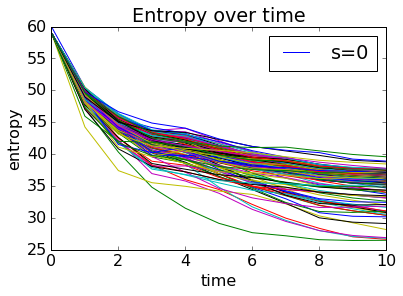

In [999]:
print 'Lowest:',sorted_entropies[0],[round(seed_entropy[sorted_entropies[0]][t],2) for t in seed_entropy[sorted_entropies[0]]]
print 'Highest:',sorted_entropies[-1],[round(seed_entropy[sorted_entropies[-1]][t],2) for t in seed_entropy[sorted_entropies[-1]]]
plt.plot(xvalues,[y*60 for y in yvalues0],label='s=0')
for index,seed in enumerate(sorted_entropies):
    if index%1==0:
        plt.plot(xvalues,[seed_entropy[seed][t] for t in xvalues])
plt.title("Entropy over time")
plt.ylabel("entropy")
plt.xlabel("time")
plt.legend()

In [1169]:
#testing various hypotheses
seeds=[[109, 111],[108],[99, 108],[29, 105],[29, 53, 105],[27,99],[29,99],[29, 55],[99],[27],[29],[26]]
hlmodules,htranslator=find_modules(NL,1,lsunits,lsunit_map,{},ltranslator,reduced=True,ds=dl,pinning={},seeds=seeds,
                                   iterations=10,data=False)
print len(hlmodules)

seeds: 12
12


In [1168]:
for seed in hlmodules: print seed,hlmodules[seed]
#lmodules['(29, 55)'][10]

[108] set(['PDGF-0'])
[27] set(['IFNGT-1', 'NFAT-1', 'TRADD-0', 'FasL-1', 'NFKB-1', 'TPL2-1', 'TNF-1', 'FasT-1', 'RANTES-1', 'A20-1', 'PI3K-1'])
[29, 105] set(['TNF-1', 'FasL-1', 'NFKB-1', 'FasT-1', 'TRADD-0', 'RANTES-1', 'A20-1', 'Ceramide-0', 'SPHK1-1'])
[109, 111] set(['SOCS-0', 'PLCG1-1', 'FasT-1', 'ERK-1', 'IL15-1', 'IFNGT-1', 'NFAT-1', 'FasL-1', 'MEK-1', 'TPL2-1', 'PDGF-1', 'GAP-0', 'NFKB-1', 'PDGFR-1', 'RAS-1', 'PI3K-1', 'SPHK1-1', 'TNF-1', 'TRADD-0', 'RANTES-1', 'A20-1', 'Ceramide-0'])
[29, 53, 105] set(['NFKB-1', 'TNF-1', 'FasL-1', 'Proliferation-1', 'FasT-1', 'TRADD-0', 'RANTES-1', 'A20-1', 'Ceramide-0', 'SPHK1-1'])
[29] set(['TNF-1', 'FasL-1', 'NFKB-1', 'FasT-1', 'TRADD-0', 'RANTES-1', 'A20-1'])
[26] set(['NFAT-0', 'MCL1-0', 'IL2RBT-0', 'CREB-0', 'PI3K-0', 'ERK-0', 'IL2RB-0'])
[29, 99] set(['TNF-1', 'FasL-1', 'NFKB-1', 'FasT-1', 'TRADD-0', 'RANTES-1', 'A20-1', 'Apoptosis-1'])
[27, 99] set(['IFNGT-1', 'NFAT-1', 'TRADD-0', 'FasL-1', 'NFKB-1', 'TPL2-1', 'TNF-1', 'FasT-1', 'RANT

In [220]:
#check for subsets at higher top x values
seed=(64, 91, 107, 108, 111, 112, 115, 116, 119)    
print to_list(seed,lsunit_map)
print to_list(reduce_selection(seed,NL,lsunits,lsunit_map,lmodules,ltranslator,reduced=True,ds=dl,t=10),lsunit_map)
d={'(24, 93, 107, 108, 111, 112, 115, 116, 119)':0,'(93, 107, 108, 111, 112, 115, 116, 119) ':0,
             '(64, 91, 107, 108, 111, 112, 115, 116, 119)':0}
print sorted(d,key=lambda x: d[x]) #selection among equivalents appears to be random?

['GZMB-0', 'BID-1', 'S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
['S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
['(64, 91, 107, 108, 111, 112, 115, 116, 119)', '(93, 107, 108, 111, 112, 115, 116, 119) ', '(24, 93, 107, 108, 111, 112, 115, 116, 119)']


In [204]:
#determine selections based on top x chosen; resolves s=8 at top x=1
top=1
selections,entropies=top_selection(NL,lsunits,lsunit_map,lmodules,ltranslator,seeds=None,max_s=10,top=top,reduced=True,ds=dl,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True)
for seed in selections: 
    print seed, entropies[seed], to_list(seed,lsunit_map,ltranslator)
    print to_list(reduce_selection(seed,NL,lsunits,lsunit_map,lmodules,ltranslator,reduced=True,ds=dl,t=10),lsunit_map)
#for seed in sorted(entropies,key=lambda x: entropies[x])[:top]: print seed,entropies[seed],to_list(seed,lsunit_map,ltranslator)

1139 1139
() 0.623129765665 []
[]
(107,) 0.441504828332 ['S1P-1']
['S1P-1']
(107, 111) 0.267964325025 ['S1P-1', 'IL15-1']
['S1P-1', 'IL15-1']
(107, 111, 116) 0.102139374515 ['S1P-1', 'IL15-1', 'CD45-0']
['S1P-1', 'IL15-1', 'CD45-0']
(107, 111, 112, 116) 0.0550499286193 ['S1P-1', 'IL15-1', 'Stimuli-0', 'CD45-0']
['S1P-1', 'IL15-1', 'Stimuli-0', 'CD45-0']
(107, 111, 112, 116, 119) 0.0378169769169 ['S1P-1', 'IL15-1', 'Stimuli-0', 'CD45-0', 'TAX-1']
['S1P-1', 'IL15-1', 'Stimuli-0', 'CD45-0', 'TAX-1']
(107, 111, 112, 115, 116, 119) 0.0208207112676 ['S1P-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
['S1P-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
(107, 108, 111, 112, 115, 116, 119) 0.00415404460092 ['S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
['S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
(64, 107, 108, 111, 112, 115, 116, 119) 0.0 ['GZMB-0', 'S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD

In [906]:
#entropy of strategy; selections or selections_rnd
lentropies_sim=strategy_entropy(selections,NL,lsunit_map,lmodules,ltranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=lstats,results=False,time_limit=12,act_prob_sim=act_prob_sim,entropies_sim=lentropies_sim,t=10)
for seed in selections: print to_list(seed,lsunit_map,ltranslator), entropies[seed], lentropies_sim[seed]

[] 0.623129765665 0.715457150307
['S1P-1'] 0.441504828332 0.52975581917
['S1P-1', 'IL15-1'] 0.267964325025 0.361858791131
['S1P-1', 'IL15-1', 'CD45-0'] 0.102139374515 0.116406482469
['S1P-1', 'IL15-1', 'Stimuli-0', 'CD45-0'] 0.0550499286193 0.0726210109339
['S1P-1', 'IL15-1', 'Stimuli-0', 'CD45-0', 'TAX-1'] 0.0378169769169 0.0537969778002
['S1P-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1'] 0.0208207112676 0.0221240819859
['S1P-1', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1'] 0.00415404460092 0.00323986429719
['IAP-1', 'S1P-1', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1'] 0.0 0.0
['GZMB-0', 'BID-1', 'S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1'] 0.0 0.0
['GZMB-0', 'BID-1', 'S1P-1', 'PDGF-0', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1'] 0.0 0.0


In [898]:
#entropy of random seed selections averaged over multiple samples
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s
#selections_rnd,entropies=random_selection(NL,lsunits,lsunit_map,lmodules,ltranslator,seeds=None,max_s=10,entropies=entropies,
#                            reduced=True,ds=dl,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True)
lselections_ls,lavg=avg_random_selections(NL,lsunits,lsunit_map,lmodules,ltranslator,samples=samples,seeds=None,max_s=10,entropies=entropies,
                      reduced=True,ds=dl,t=10,runs=runs,stats=lstats,act_prob_sim=act_prob_sim,entropies_sim=lentropies_sim)
#print selections_rnd,len(entropies),len(lentropies_sim)
print lavg,len(lselections_ls)

{0: 0.71545715030685497, 1: 0.68077598387744398, 2: 0.64187152081305077, 3: 0.59962166272064887, 4: 0.56059453237432111, 5: 0.52818106435126377, 6: 0.49159153928578697, 7: 0.46531942800712955, 8: 0.42932728578237189, 9: 0.40881322150657806, 10: 0.39179975005659906} 100


In [907]:
#top x
xvalues=[s for s in range(max_s+1)]
exec('ltop'+str(top)+'=[lentropies_sim[x] for x in selections]') #base on 'ground truth' simulations
#lyrnd=[lentropies_sim[x] for x in selections_rnd] #single random sample
lyrnd=[lavg[x] for x in lavg] #average of multiple random samples
print ltop6#,lyrnd
print ltop10

[0.71545715030685553, 0.52975581916998449, 0.36185879113073322, 0.11640648246931382, 0.072621010933936664, 0.053796977800235742, 0.022124081985907939, 0.0032398642971929368, 0.0, 0.0, 0.0]
[0.71545715030685553, 0.52975581916998449, 0.36185879113073322, 0.11640648246931382, 0.072621010933936664, 0.053796977800235742, 0.022124081985907939, 0.0032398642971929368, 0.0, 0.0, 0.0]


(-0.01, 0.8)

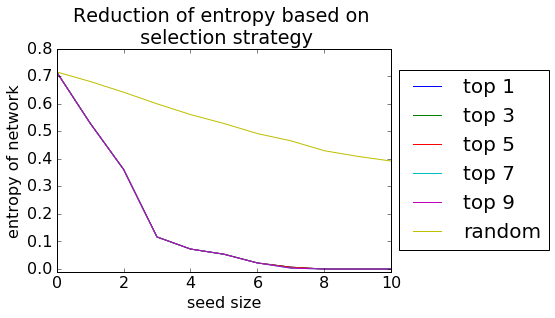

In [904]:
#plot entropy reduction
for i in [1,3,5,7,9]:
    plt.plot(xvalues,eval('ltop'+str(i)),label='top '+str(i))
#plt.plot(xvalues,top8,label='top 8') #reduces to 0 entropy faster
plt.plot(xvalues,lyrnd,label='random')
plt.legend(bbox_to_anchor=(1.5, 0.95), fontsize=20)
plt.title("Reduction of entropy based on \n selection strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.ylim([-.01,0.8])

In [444]:
#compare to FVS drivers
lfvs=fvs_set(NL) #method='bruteforce'
print len(lfvs)
for x in sorted(lfvs,key=lambda x: config_entropy(lmodules[x],base=2,normalized=True)[0][10]): 
    #print x,lsunit_map[ltranslator[x][0]]
    seed_entropy,seed_configs=config_entropy(lmodules[x],base=2,normalized=True)
    print x,lsunit_map[ltranslator[x][0]],seed_entropy[10]

50
(109,) PDGF-1 0.444146982587
(28,) NFKB-0 0.469544781917
(111,) IL15-1 0.485243894269
(76,) Fas-0 0.509146264804
(80,) Ceramide-0 0.512956373511
(18,) RAS-0 0.514055464482
(21,) GAP-1 0.516609263017
(81,) Ceramide-1 0.530931865685
(77,) Fas-1 0.54080059504
(20,) GAP-0 0.552534789182
(19,) RAS-1 0.552800472014
(112,) Stimuli-0 0.566580148579
(110,) IL15-0 0.567147377317
(117,) CD45-1 0.572517138736
(13,) ZAP70-1 0.585711693164
(45,) JAK-1 0.586066699269
(114,) Stimuli2-0 0.586885676514
(63,) P2-1 0.588070680016
(60,) IFNG-0 0.588317226147
(108,) PDGF-0 0.589584891587
(91,) BID-1 0.595296636143
(115,) Stimuli2-1 0.597129780341
(54,) TBET-0 0.598646953171
(119,) TAX-1 0.6001595387
(12,) ZAP70-0 0.604596962189
(9,) Cytoskeleton_signaling-1 0.60650923407
(8,) Cytoskeleton_signaling-0 0.60650923407
(113,) Stimuli-1 0.609500759235
(52,) Proliferation-0 0.609895402524
(53,) Proliferation-1 0.609895402524
(92,) IAP-0 0.610767514434
(118,) TAX-0 0.610993032542
(116,) CD45-0 0.612611890313
(62

In [447]:
#determine top selection based on FVS nodes
#NOTE: the selection is different but the minimum is still 8 nodes
selections,entropies=top_selection(NL,lsunits,lsunit_map,lmodules,ltranslator,seeds=lfvs,max_s=10,top=1,reduced=True,ds=dl,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False)
for seed in selections: 
    print seed, entropies[seed], to_list(seed,lsunit_map,ltranslator)
print to_list(reduce_selection(seed,NL,lsunits,lsunit_map,lmodules,ltranslator,reduced=True,ds=dl,t=10),lsunit_map)

1118 1118
() 0.623129765665 []
(109,) 0.444146982587 ['PDGF-1']
(109, 111) 0.279474783886 ['PDGF-1', 'IL15-1']
(109, 111, 116) 0.133514219982 ['PDGF-1', 'IL15-1', 'CD45-0']
(109, 111, 112, 116) 0.0864212922622 ['PDGF-1', 'IL15-1', 'Stimuli-0', 'CD45-0']
(76, 109, 111, 112, 116) 0.0397961016767 ['Fas-0', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'CD45-0']
(76, 109, 111, 112, 115, 116) 0.0208698091386 ['Fas-0', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0']
(76, 109, 111, 112, 115, 116, 119) 0.00410207022489 ['Fas-0', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
(76, 90, 109, 111, 112, 115, 116, 119) 0.0 ['Fas-0', 'BID-0', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
(70, 76, 90, 109, 111, 112, 115, 116, 119) 0.0 ['TRADD-0', 'Fas-0', 'BID-0', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1']
(70, 76, 90, 109, 111, 112, 115, 116, 119) 0.0 ['TRADD-0', 'Fas-0', 'BID-0', 'PDGF-1', 'IL15-1', 'Stimuli-0', 'Stimuli2-1', 'CD45-0', 'TAX-1

#### Thaliana

In [64]:
#recreate pipeline with thaliana
#TODO: rerun all results with the updated Thaliana file
#NT = THALIANA()
NT = cana.BooleanNetwork.from_file('cana/thaliana_edit.txt',) #file_type='logical'
#fix input nodes
for node in NT.nodes:
    if not node.inputs:
        node.inputs=[node.name]

In [65]:
dt={node.name: LUT_reduce(look_up_table(node)) for node in NT.nodes}
tnodes=dt.keys()
print len(dt),tnodes
tmodules,ttranslator={},{}
tsunits,tsunit_map=get_sunits(NT)
print len(tsunits),len(tsunit_map)

15 ['WUS', 'FT', 'AG', 'UFO', 'AP2', 'AP3', 'CLF', 'AP1', 'SEP', 'TFL1', 'EMF1', 'LUG', 'FUL', 'PI', 'LFY']
30 30


In [905]:
#find pathway modules
start_time = time.time()
tmodules,ttranslator=find_modules(NT,2,tsunits,tsunit_map,tmodules,ttranslator,reduced=True,ds=dt,pinning={},iterations=10,data=True)
print("--- %s seconds ---" % (time.time() - start_time))
len(tmodules)
#for node in NT.nodes: print node.name,node.inputs, node.outputs

seeds: 435
--- 14.8820002079 seconds ---


466

In [909]:
length=0
seeds=reduce_seeds(tmodules,tsunit_map,ttranslator,length=length)
submodules={seed:tmodules[seed] for seed in seeds}
len(submodules)
seeds=submodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
#tstats={}
start_time = time.time()
simulations=compare_simulations(NT,seeds,tsunit_map,tmodules,ttranslator,length=length,runs=100,tau=0.0,iterations=10,
                        unknown_prob=0.5,stats=tstats,results=True,time_limit=12)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 1
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.6, 0.33]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07, 0.4, 0.67]
accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.6, 0.33]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
average similarity: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
errors: [0.01, 0.006, 0.014, 0.016, 0.019, 0.024, 0.029, 0.032, 0.033, 0.034, 0.034]
--- Total time: 0.416999816895 seconds ---


In [910]:
#tact_prob_sim={}
for seed in simulations: tact_prob_sim[seed]={}
for seed in simulations:
    aggregate_simulation(seed,simulations,tact_prob_sim)

len(tact_prob_sim)

31

[]
Normalized entropy: [1.0, 0.93, 0.82, 0.64, 0.56, 0.53, 0.52, 0.52, 0.51, 0.51, 0.51] [1.0, 0.94, 0.82, 0.64, 0.56, 0.53, 0.52, 0.52, 0.52, 0.52, 0.52]
Probable configurations: ['9.61e+17', '6.90e+16', '6.16e+14', '3.84e+11', '1.07e+10', '3.31e+09', '2.21e+09', '2.09e+09', '1.91e+09', '1.91e+09', '1.91e+09']


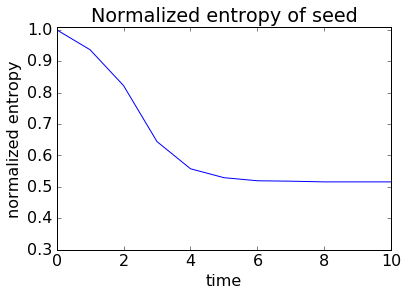

Total possible configurations: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


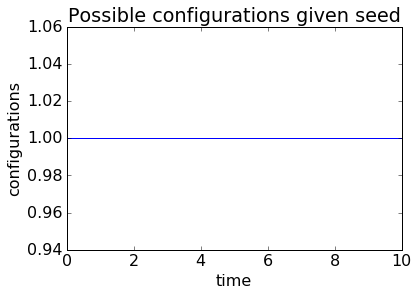

In [913]:
#single seed entropy
seed='()' #'(7,)'
print to_list(seed,tsunit_map,ttranslator)
diffusion=tact_prob_sim[seed] #todules[seed], tact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
xvalues=seed_entropy.keys()
yvalues=[seed_entropy[key] for key in seed_entropy]
#print [round(y*60,2) for y in yvalues]
plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues]) #normalize everything compared to the starting value
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.ylim([0.3,1.01])
plt.title("Normalized entropy of seed")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True,strict=True)
xvalues=seed_configs.keys()
y1values=[seed_configs[key] for key in seed_configs]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
print 'Total possible configurations:',[round(yvalue,5) for yvalue in y1values],[round(yvalue/y1values[0],5) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

seeds: 30
Average entropy: [55.62, 42.18, 35.1, 26.09, 21.6, 19.78, 18.96, 18.64, 18.53, 18.43, 18.49]
Normalized entropy: [0.93, 0.7, 0.58, 0.43, 0.36, 0.33, 0.32, 0.31, 0.31, 0.31, 0.31] [1.0, 0.76, 0.63, 0.47, 0.39, 0.36, 0.34, 0.34, 0.33, 0.33, 0.33]
Possible configurations: ['5.53e+16', '4.98e+12', '3.68e+10', '7.16e+07', '3.19e+06', '9.01e+05', '5.09e+05', '4.10e+05', '3.79e+05', '3.53e+05', '3.68e+05']


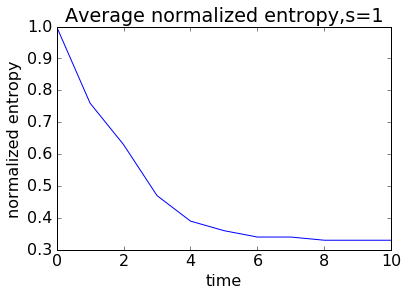

Total possible configurations: [0.5, 0.12, 0.11, 0.1, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.05] [1.0, 0.24, 0.23, 0.2, 0.12, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11]


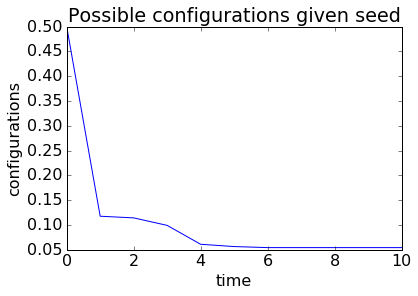

In [112]:
#multiple seed entropies
length,iterations=1,10
seeds=reduce_seeds(tmodules,tsunit_map,ttranslator,length=length) #['()','(3,)']
#seeds=simulations.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(tact_prob_sim,seeds,normalized=True,data=False) #dpmodules, submodules, dpact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * 60,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(tact_prob_sim,seeds,normalized=True,data=False,strict=True) #submodules,dact_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [109]:
#compare to FVS drivers
tfvs=fvs_set(NT,method='bruteforce') #method='bruteforce'
print len(tfvs)
for x in sorted(tfvs): 
    #print x,dpsunit_map[dptranslator[x][0]]
    seed_entropy,seed_configs=config_entropy(tmodules[x],base=2,normalized=True)
    print x,tsunit_map[ttranslator[x][0]],seed_entropy[10]

18
(0,) AP3-0 0.200000000001
(1,) AP3-1 0.200000000001
(12,) LFY-0 0.546238489502
(13,) LFY-1 0.200888236793
(16,) WUS-0 0.203457587518
(17,) WUS-1 0.203247403243
(18,) AG-0 0.367951956209
(19,) AG-1 0.202663578045
(2,) UFO-0 0.135322552824
(20,) LUG-0 0.136580736577
(21,) LUG-1 0.136924309801
(22,) CLF-0 0.136580736577
(23,) CLF-1 0.136924309801
(24,) TFL1-0 0.201634226499
(25,) TFL1-1 0.727080724722
(26,) PI-0 0.266666666668
(27,) PI-1 0.202508153363
(3,) UFO-1 0.133333333334


In [111]:
#analyze attractors for thaliana
tattractors=attractors_to_dict(NT)
print len(tattractors)

10


In [116]:
#determine top selection based on FVS nodes or any node
#NOTE: the selection is different but the minimum is still 4 nodes; the reduction to 3 nodes is incorrect
selections,entropies=top_selection(NT,tsunits,tsunit_map,tmodules,ttranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dt,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False)
for seed in selections: 
    print seed, entropies[seed], to_list(seed,tsunit_map,ttranslator)
print to_list(reduce_selection(seed,NT,tsunits,tsunit_map,tmodules,ttranslator,reduced=True,ds=dt,t=10),tsunit_map)

101 101
() 0.20339944821 []
(3,) 0.133333333334 ['UFO-1']
(3, 22) 0.0666666666672 ['UFO-1', 'CLF-0']
(3, 21, 22) 4.88555208945e-13 ['UFO-1', 'LUG-1', 'CLF-0']
(3, 21, 22, 24) 0.0 ['UFO-1', 'LUG-1', 'CLF-0', 'TFL1-0']
(3, 14, 21, 22, 24) 0.0 ['UFO-1', 'AP2-0', 'LUG-1', 'CLF-0', 'TFL1-0']
(3, 10, 14, 21, 22, 24) 0.0 ['UFO-1', 'EMF1-0', 'AP2-0', 'LUG-1', 'CLF-0', 'TFL1-0']
(3, 10, 14, 21, 22, 24) 0.0 ['UFO-1', 'EMF1-0', 'AP2-0', 'LUG-1', 'CLF-0', 'TFL1-0']
(3, 10, 14, 21, 22, 24) 0.0 ['UFO-1', 'EMF1-0', 'AP2-0', 'LUG-1', 'CLF-0', 'TFL1-0']
(3, 10, 14, 21, 22, 24) 0.0 ['UFO-1', 'EMF1-0', 'AP2-0', 'LUG-1', 'CLF-0', 'TFL1-0']
(3, 10, 14, 21, 22, 24) 0.0 ['UFO-1', 'EMF1-0', 'AP2-0', 'LUG-1', 'CLF-0', 'TFL1-0']
['UFO-1', 'LUG-1', 'CLF-0']


In [147]:
#check the input nodes and attractor solutions
DCMT=NT.dynamics_canalization_map(output=None, )
seed=['UFO-1', 'LUG-1', 'CLF-0'] #mf ERROR
seed=['UFO-1', 'LUG-1', 'CLF-0', 'TFL1-0']
#seed=['UFO-1', 'AG-1', 'LUG-1', 'CLF-0'] #mf ERROR
#seed=['UFO-1', 'WUS-0', 'AG-1', 'LUG-1', 'CLF-0','PI-1'] #mf ERROR
seed=['UFO-0', 'WUS-0', 'AG-0', 'LUG-1', 'CLF-1'] #attractor1, ERROR
seed=['AP3-1', 'UFO-0', 'WUS-0', 'AG-0', 'LUG-1', 'CLF-1'] #attractor2, ERROR
seed=['AP3-1', 'UFO-0', 'LFY-1', 'LUG-1', 'CLF-1'] #attractor3, ERROR
seed=['UFO-1', 'EMF1-1', 'WUS-0', 'LUG-1', 'CLF-1', 'TFL1-1'] #attractor4
seed=['UFO-1', 'EMF1-0', 'LUG-1', 'CLF-1'] #attractor5, ERROR
seed=['UFO-1', 'EMF1-1', 'WUS-1', 'LUG-1', 'CLF-1', 'TFL1-1'] #attractor6
seed=['UFO-0', 'EMF1-1', 'WUS-1', 'LUG-1', 'CLF-1', 'TFL1-1'] #attractor7
seed=['AP3-0', 'UFO-0', 'AG-1', 'LUG-1', 'CLF-1'] #attractor8, ERROR
seed=['UFO-1', 'WUS-0', 'AG-0', 'LUG-1', 'CLF-1'] #attractor9, ERROR
seed=['UFO-0', 'EMF1-1', 'WUS-0', 'LUG-1', 'CLF-1', 'TFL1-1'] #attractor10
diffusion=BFS_threshold(DCMT,seed,'steady',time_limit=10,pinned={})
print count_sunits(diffusion)
seed=(3, 21, 22)
find_modules(NT,1,tsunits,tsunit_map,{},ttranslator,seeds=[seed],data=True,verbose=True,iterations=15)[0][str(seed)][12]

15
seeds: 1


{'AG': 1.0,
 'AP1': 0.0,
 'AP2': 1.0,
 'AP3': 1.0,
 'CLF': 0.0,
 'EMF1': 0.0,
 'FT': 1.0,
 'FUL': 1.0,
 'LFY': 1.0,
 'LUG': 1.0,
 'PI': 1.0,
 'SEP': 1.0,
 'TFL1': 0.0,
 'UFO': 1.0,
 'WUS': 0.0}

In [804]:
#determine top selections for attractors
iterations=10
t=iterations
for i,attractor in enumerate(tattractors):
    selections,entropies=top_selection(NT,tsunits,tsunit_map,tmodules,ttranslator,seeds=None,max_s=15,top=1,reduced=True,
            ds=dt,attractor=attractor,attractors=tattractors,pin_start=True,force=True,t=t,iterations=iterations)
    exec('at'+str(i)+'=[entropies[x] for x in selections]') #entropy
    exec('st'+str(i)+'=[x for x in selections]') #selection
    print attractor #,eval('a'+str(i))
    for seed in selections: 
        print seed, entropies[seed], to_list(seed,tsunit_map,ttranslator),
        print to_list(reduce_selection(seed,NT,tsunits,tsunit_map,tmodules,ttranslator,reduced=True,ds=dt,t=t,
                                       iterations=iterations),tsunit_map)
        if entropies[seed]==0.0: break #no need to print out the rest

2096 2097
000110110011001
() 0.20339944821 [] []
(9,) 0.202575459975 ['AP1-1'] ['AP1-1']
(9, 21) 0.137397632585 ['AP1-1', 'LUG-1'] ['LUG-1']
(2, 9, 21) 0.0723117199528 ['UFO-0', 'AP1-1', 'LUG-1'] ['UFO-0', 'LUG-1']
(2, 9, 21, 26) 0.0674403718598 ['UFO-0', 'AP1-1', 'LUG-1', 'PI-0'] ['UFO-0', 'LUG-1', 'PI-0']
(2, 9, 21, 23, 26) 0.0570070558661 ['UFO-0', 'AP1-1', 'LUG-1', 'CLF-1', 'PI-0'] ['UFO-0', 'LUG-1', 'CLF-1', 'PI-0']
(2, 9, 13, 21, 23, 26) 0.0202752040813 ['UFO-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0'] ['UFO-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0']
(2, 9, 13, 21, 23, 26, 29) 0.0177509167278 ['UFO-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] ['UFO-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1']
(2, 4, 9, 13, 21, 23, 26, 29) 0.0177509167278 ['UFO-0', 'FUL-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] ['UFO-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1']
(0, 2, 4, 9, 13, 21, 23, 26, 29) 0.0177509167278 ['AP3-0', 'UFO-0', 'FUL-0', 'AP1-1', 'LFY-1', 'LUG-1', '

(-0.01, 0.9)

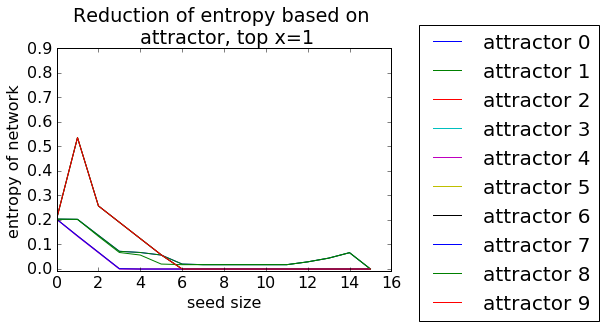

In [149]:
#graph attractors based on mf estimates
xvalues=range(16)
for i in range(len(tattractors)):
    plt.plot(xvalues,eval('at'+str(i)),label='attractor '+str(i)) #given top x value
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.65, 1.15), fontsize=20)
plt.title("Reduction of entropy based on \n attractor, top x=1")
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [802]:
#entropy of strategy; requires at and st variables above
#tentropies_sim={}
for i,strategy in enumerate(tattractors):
    print strategy
    selection=eval('st'+str(i))
    tentropies_sim=strategy_entropy(selection,NT,tsunit_map,tmodules,ttranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=tstats,results=False,time_limit=12,act_prob_sim=tact_prob_sim,entropies_sim=tentropies_sim,t=10)
    for j,seed in enumerate(selection): print to_list(seed,tsunit_map,ttranslator), eval('at'+str(i)+'['+str(j)+']'), tentropies_sim[seed]

000110110011001
[] 0.20339944821 0.354907055862
['AP1-1'] 0.202575459975 0.252444017958
['AP1-1', 'LUG-1'] 0.137397632585 0.223701583709
['UFO-0', 'AP1-1', 'LUG-1'] 0.0723117199528 0.139671210497
['UFO-0', 'AP1-1', 'LUG-1', 'PI-0'] 0.0674403718598 0.0634359230577
['UFO-0', 'AP1-1', 'LUG-1', 'CLF-1', 'PI-0'] 0.0570070558661 0.0657239150865
['UFO-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0'] 0.0202752040813 0.0233709213788
['UFO-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] 0.0177509167278 0.0190931304744
['UFO-0', 'FUL-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] 0.0177509167278 0.0219897380138
['AP3-0', 'UFO-0', 'FUL-0', 'AP1-1', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] 0.0177509167278 0.0271937320093
['AP3-0', 'UFO-0', 'FUL-0', 'AP1-1', 'EMF1-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] 0.0177509167278 0.0148189887124
['AP3-0', 'UFO-0', 'FUL-0', 'FT-1', 'AP1-1', 'EMF1-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] 0.0177509167278 0.0224860044411
['AP3-0

(-0.01, 0.9)

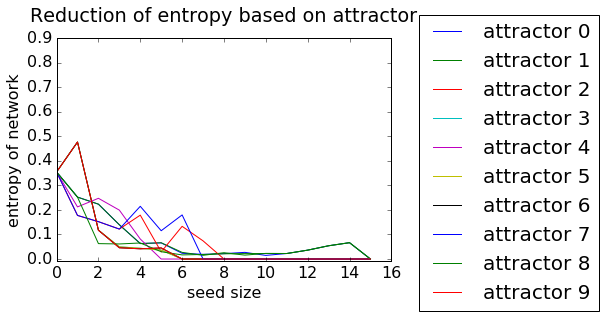

In [805]:
#graph attractors based on simulations of mf selections
xvalues=range(16)
for i in range(len(tattractors)):
    plt.plot(xvalues,[tentropies_sim[seed] for seed in eval('st'+str(i))],label='attractor '+str(i))
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.65, 1.15), fontsize=20)
plt.title("Reduction of entropy based on attractor",y=1.05)
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [806]:
#entropy of random seed selections averaged over multiple samples for different attractors
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s

for i,attractor in enumerate(tattractors): 
    selections_ls,avg=avg_random_selections(NT,tsunits,tsunit_map,tmodules,ttranslator,samples=samples,seeds=None,max_s=15,entropies=entropies,
        reduced=True,ds=dt,t=10,runs=runs,stats=tstats,act_prob_sim=tact_prob_sim,entropies_sim=tentropies_sim,attractor=attractor,attractors=tattractors)
    exec('tavg'+str(i)+'=[avg[x] for x in avg]') #entropy of selection
    print avg,len(selections_ls)

{0: 0.35490705586153437, 1: 0.32349179646320986, 2: 0.28590761709307999, 3: 0.22836933887803784, 4: 0.19141652287412048, 5: 0.17617559417640721, 6: 0.16178157043370858, 7: 0.1432592273433792, 8: 0.10980021523048387, 9: 0.081730099689797844, 10: 0.065850296048769477, 11: 0.039331604064739081, 12: 0.029081704165945535, 13: 0.019333333333333331, 14: 0.0093333333333333324, 15: 0.0} 100
{0: 0.35490705586153437, 1: 0.29898517763541194, 2: 0.28652755296735338, 3: 0.25301198943577746, 4: 0.22276933438055341, 5: 0.19654835806615573, 6: 0.1563453996121483, 7: 0.13653361364870378, 8: 0.10249513985715124, 9: 0.074725397533962512, 10: 0.052025912683939197, 11: 0.035982263805884117, 12: 0.023622556248918271, 13: 0.013081704165945509, 14: 0.0066666666666666662, 15: 0.0} 100
{0: 0.35490705586153437, 1: 0.30680633092364823, 2: 0.27253609234097204, 3: 0.22273604710141373, 4: 0.19930522966580697, 5: 0.18107308829300744, 6: 0.16036020868597498, 7: 0.13015590205071981, 8: 0.1017154945250842, 9: 0.089707020

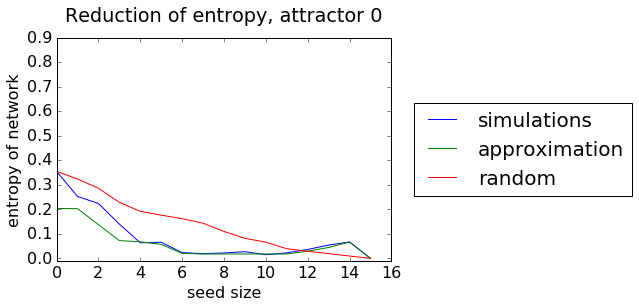

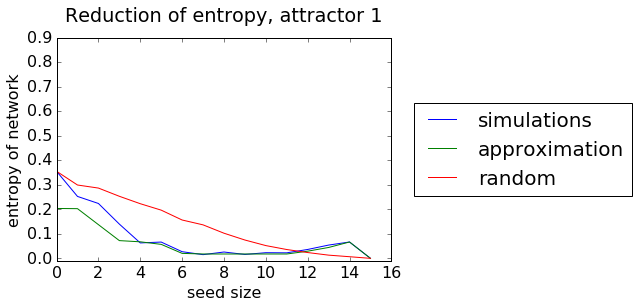

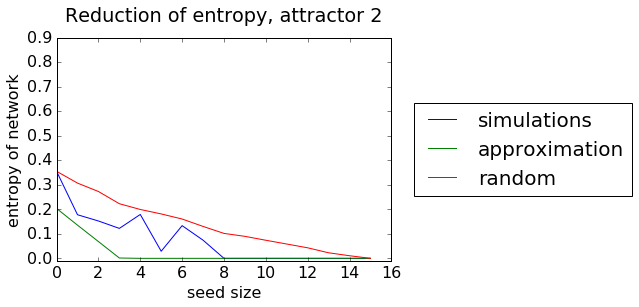

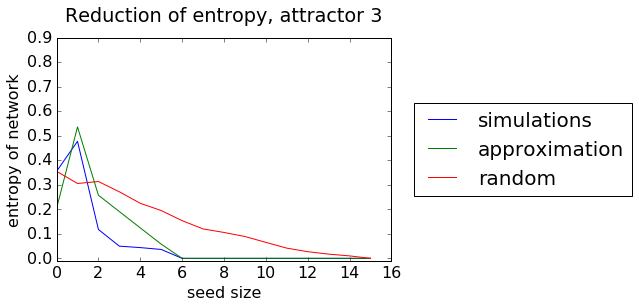

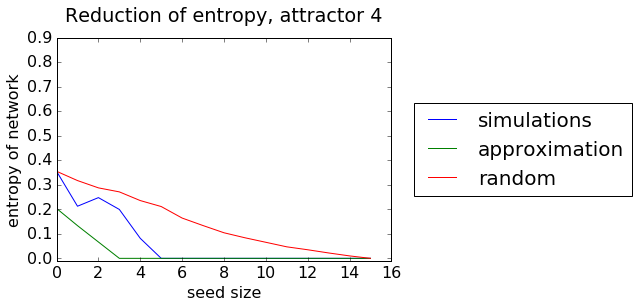

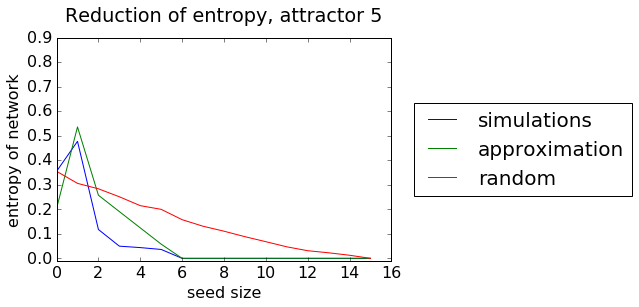

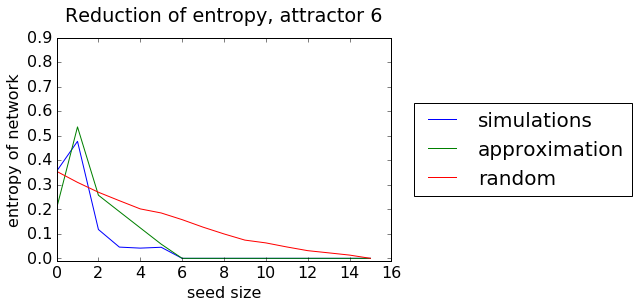

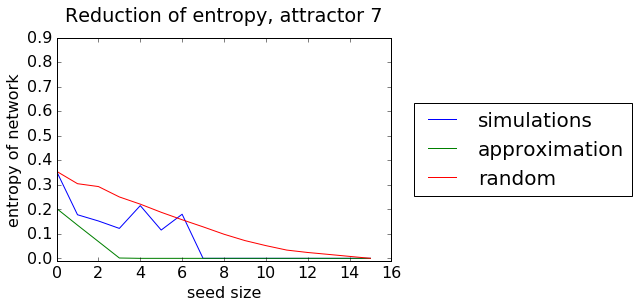

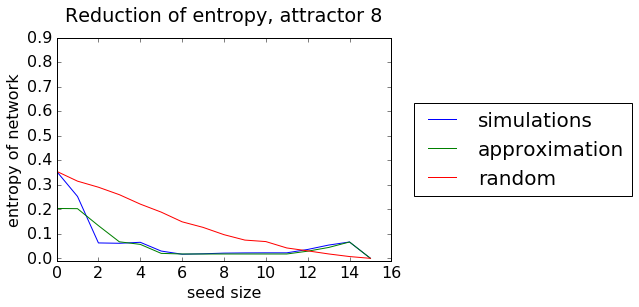

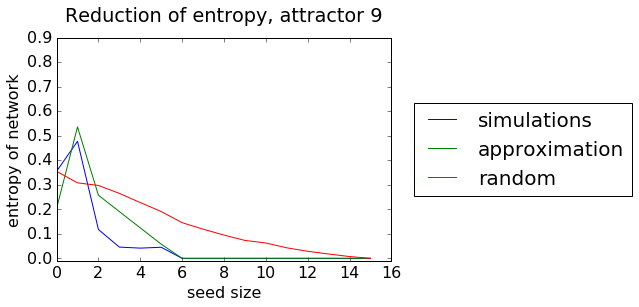

In [809]:
#graph single attractor to compare approximation with simulations of mf selections
xvalues=range(16)
for i,attractor in enumerate(tattractors):
    plt.plot(xvalues,[tentropies_sim[seed] for seed in eval('st'+str(i)+'[:]')],label='simulations')
    plt.plot(xvalues,eval('at'+str(i)+'[:]'),label='approximation')
    plt.plot(xvalues,eval('tavg'+str(i)),label='random')
    plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20)
    plt.title("Reduction of entropy, attractor "+str(i),y=1.05)
    plt.ylabel("entropy of network")
    plt.xlabel("seed size")
    plt.yticks(np.arange(0,1,.1))
    plt.ylim([-.01,0.9])
    plt.show()

[0.0, 0.0, 0.028979923506621343, 0.0, 0.081581196027795247, 0.0, 0.0, 0.11536551653441109, 0.0, 0.0]


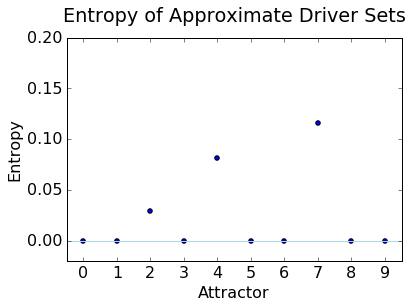

In [816]:
#graph actual entropy of approximate solutions based on simulations
yvalues=[]
for i,attractor in enumerate(tattractors):
    #print attractor
    for j,evalue in enumerate(eval('at'+str(i))):
        if evalue==0:
            seed=eval('st'+str(i)+'['+str(j)+']')
            yvalues.append(tentropies_sim[seed])
            break
print yvalues
plt.hlines(0.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],yvalues)
plt.ylim([-0.02,0.2])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Entropy")
plt.xlabel("Attractor")
plt.title("Entropy of Approximate Driver Sets",y=1.05)

In [823]:
#confirm approximate solutions by comparing to DCM modules
yvalues=[]
for i,attractor in enumerate(tattractors):
    print attractor,
    for j,evalue in enumerate(eval('at'+str(i))):
        if evalue==0:
            seed=eval('st'+str(i)+'['+str(j)+']')
            seed=to_list(seed,tsunit_map,ttranslator)
            diffusion=BFS_threshold(DCMT,seed,'steady',time_limit=10,pinned={})
            print count_sunits(diffusion)#seed
            yvalues.append(count_sunits(diffusion))
            diffusion=BFS_threshold(DCMT,seed,'steady',time_limit=15,pinned={})
            #print count_sunits(diffusion)
            break

000110110011001 15
100110110011011 15
101100110111011 11
010001000011100 15
111100110111011 11
010001001011100 15
000001001011100 15
001100110111011 6
110110110011011 15
000001000011100 15


[15, 15, 11, 15, 11, 15, 15, 6, 15, 15]


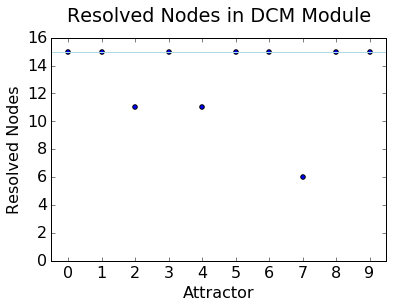

In [827]:
#graph nodes resolved of approximate solutions based on DCM modules
print yvalues
plt.hlines(15.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],yvalues)
plt.ylim([-0.0,16])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Resolved Nodes")
plt.xlabel("Attractor")
plt.title("Resolved Nodes in DCM Module",y=1.05)

In [915]:
#why can't simulations find driver sets for thaliana? --> fixed thaliana file
#NOTE: CLF and LUG were always 0 in simulations
#tsunit_map[2],tmodules['(2,)'][10] #UFO-0
#tsunit_map[9],tmodules['(9,)'][10] #AP1-1
#tsunit_map[21],tmodules['(21,)'][10] #LUG-1
#print tattractors.keys()
for node in NT.nodes:
    #if node.name=='CLF' or node.name=='LUG': node.outputs=[0,1]
    #print node.name,node.inputs,node.outputs#,node.look_up_table()
    if node.name=='CLF': break
#print node.inputs
CM=node.canalizing_map()
#draw_canalizing_map_graphviz(CM)
#draw_dynamics_canalization_map_graphviz(DCMT, overlap='true')
#display(SVG(gv.pipe(format='svg')),metadata={'isolated':True})
tact_prob_sim['(11,)'][1]

{'AG': 0.61,
 'AP1': 0.43,
 'AP2': 0.5,
 'AP3': 0.35,
 'CLF': 0.51,
 'EMF1': 1.0,
 'FT': 0.0,
 'FUL': 0.23,
 'LFY': 0.5,
 'LUG': 0.49,
 'PI': 0.38,
 'SEP': 0.46,
 'TFL1': 0.23,
 'UFO': 0.57,
 'WUS': 0.35}

In [916]:
#employ a greedy strategy based on simulations for comparison
#determine top selections for attractors
tsimulations={}
iterations=10
t=iterations
for i,attractor in enumerate(tattractors):
    selections,entropies=top_selection_simulations(NT,tsunits,tsunit_map,tmodules,ttranslator,seeds=None,max_s=15,top=1,reduced=True,t=t,
    ds=dt,attractor=attractor,attractors=tattractors,pin_start=True,force=True,iterations=iterations,simulations=tsimulations,act_prob_sim=tact_prob_sim)

    exec('atsim'+str(i)+'=[entropies[x] for x in selections]') #entropy of selection
    exec('stsim'+str(i)+'=[x for x in selections]') #selection
    print attractor #,eval('a'+str(i))
    for j,seed in enumerate(selections): 
        print seed, entropies[seed], to_list(seed,tsunit_map,ttranslator),
        print to_list(reduce_selection_simulations(seed,NT,tsunits,tsunit_map,ttranslator,t=t,iterations=iterations,length=j),tsunit_map)
        if entropies[seed]==0.0: break #no need to print out the rest

466 466
000110110011001
() 0.380673515141 [] []
(23,) 0.258055920194 ['CLF-1'] ['CLF-1']
(2, 23) 0.208732370716 ['UFO-0', 'CLF-1'] ['UFO-0', 'CLF-1']
(2, 10, 23) 0.122531610964 ['UFO-0', 'EMF1-0', 'CLF-1'] ['UFO-0', 'EMF1-0', 'CLF-1']
(2, 10, 21, 23) 0.066804104065 ['UFO-0', 'EMF1-0', 'LUG-1', 'CLF-1'] ['UFO-0', 'EMF1-0', 'LUG-1', 'CLF-1']
(2, 10, 21, 23, 26) 0.0161586271792 ['UFO-0', 'EMF1-0', 'LUG-1', 'CLF-1', 'PI-0'] ['UFO-0', 'EMF1-0', 'LUG-1', 'CLF-1', 'PI-0']
(2, 10, 13, 21, 23, 26) 0.0282881085084 ['UFO-0', 'EMF1-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0'] ['UFO-0', 'LUG-1', 'CLF-1', 'PI-0']
(2, 10, 13, 21, 23, 26, 29) 0.0161586271792 ['UFO-0', 'EMF1-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] ['UFO-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0']
(2, 9, 10, 13, 21, 23, 26, 29) 0.00942936950279 ['UFO-0', 'AP1-1', 'EMF1-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1'] ['UFO-0', 'AP1-1', 'EMF1-0', 'LFY-1', 'LUG-1', 'CLF-1', 'PI-0', 'SEP-1']
(2, 4, 9, 10, 13, 21, 23, 26, 29) 0.0190931304744 ['

In [930]:
#check the similarity between driver sets chosen by the approximation and by the simulations
asets,ssets=[],[]
for i,attractor in enumerate(tattractors):
    for j,evalue in enumerate(eval('at'+str(i))):
        if evalue==0:
            #print attractor,j,eval('a'+str(i)+'[j]'),dtranslator[eval('sa'+str(i)+'[j]')]#,entropies_sim[eval('sa'+str(i)+'[j]')]
            try: dtranslator[eval('st'+str(i)+'[j]')]
            except KeyError: #dtranslator key error
                create_translator(NT,s=1,sunits=tsunits,sunit_map=tsunit_map,translator=ttranslator,seeds=[eval('st'+str(i)+'[j]')])
            #reduce selection for the solution
            seed=eval(eval('st'+str(i)+'[j]'))
            sel=reduce_selection(seed,NT,tsunits,tsunit_map,tmodules,ttranslator,reduced=True,ds=dt,t=t,iterations=iterations)
            asets.append({s for s in sel})
            break
    for k,evalue in enumerate(eval('atsim'+str(i))):
        if evalue==0:
            #print attractor,k,eval('asim'+str(i)+'[k]'),dtranslator[eval('sasim'+str(i)+'[k]')]
            seed=eval(eval('stsim'+str(i)+'[k]'))
            sel=reduce_selection_simulations(seed,NT,tsunits,tsunit_map,ttranslator,t=t,iterations=iterations,length=k)
            ssets.append({s for s in sel})
            break
        #fail safe in case a solution isn't found #TODO: find out why this is the case!
        if k==len(eval('atsim'+str(i)))-1:
            seed=eval(eval('stsim'+str(i)+'[k]'))
            sel=reduce_selection_simulations(seed,NT,tsunits,tsunit_map,ttranslator,t=t,iterations=iterations,length=k)
            ssets.append({s for s in sel})
jmeasures=[]
for set1,set2 in zip(asets,ssets):
    print set1,set2,compute_jaccard(set1,set2)
    jmeasures.append(compute_jaccard(set1,set2))

set([16, 2, 23, 18, 21]) set([16, 2, 23, 18, 21]) 1.0
set([1, 2, 16, 18, 21, 23]) set([7]) 0.0
set([1, 2, 23, 13, 21]) set([1, 2, 8, 10, 21, 23]) 0.571428571429
set([3, 11, 16, 21, 23, 25]) set([3, 11, 16, 21, 23, 25]) 1.0
set([10, 3, 21, 23]) set([19, 10, 3, 21, 23]) 0.8
set([3, 11, 17, 21, 23, 25]) set([3, 11, 17, 21, 23, 25]) 1.0
set([2, 11, 17, 21, 23, 25]) set([2, 8, 12, 17, 21, 23]) 0.5
set([0, 2, 19, 21, 23]) set([0, 2, 8, 10, 21, 23]) 0.571428571429
set([16, 18, 3, 21, 23]) set([7]) 0.0
set([2, 11, 16, 21, 23, 25]) set([2, 11, 16, 21, 23, 25]) 1.0


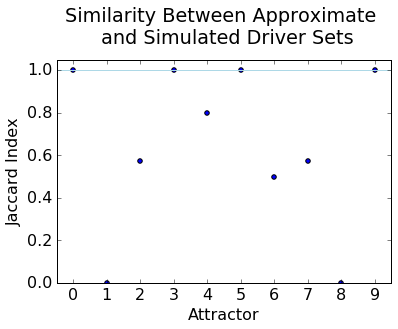

In [931]:
#graph differences in driver sets chosen via the Jaccard measure
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(10)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,9.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Approximate \n and Simulated Driver Sets",y=1.05)

#### Yeast

In [74]:
#recreate pipeline with thaliana
NY = BUDDING_YEAST()
dy={node.name: LUT_reduce(look_up_table(node)) for node in NY.nodes}
ynodes=dy.keys()
print len(dy),ynodes
ymodules,ytranslator={},{}
ysunits,ysunit_map=get_sunits(NY)
print len(ysunits),len(ysunit_map)

12 ['Mcm1/SFF', 'MBF', 'Sic1', 'CellSize', 'Swi5', 'SBF', 'Clb1,2', 'Cdh1', 'Cln3', 'Cln1,2', 'Cdc20/14', 'Clb5,6']
24 24


In [75]:
#sequential block udpate order from Goles "Deconstruction and Dynamical Robustness of Regulatory Networks" 2012 paper, Fig. 14
#NOTE: CellSize is constant so update it first without loss of generality
order=generate_blocks(NY,[['CellSize','Swi5','Cdc20/14','Clb5,6'],['MBF','Sic1'],['Cln3','SBF','Clb1,2','Mcm1/SFF'],['Cln1,2'],['Cdh1']])
[[node.name for node in block] for block in order]
print ysunit_map

{0: 'CellSize-0', 1: 'CellSize-1', 2: 'Cln3-0', 3: 'Cln3-1', 4: 'SBF-0', 5: 'SBF-1', 6: 'MBF-0', 7: 'MBF-1', 8: 'Cln1,2-0', 9: 'Cln1,2-1', 10: 'Sic1-0', 11: 'Sic1-1', 12: 'Clb5,6-0', 13: 'Clb5,6-1', 14: 'Cdh1-0', 15: 'Cdh1-1', 16: 'Clb1,2-0', 17: 'Clb1,2-1', 18: 'Mcm1/SFF-0', 19: 'Mcm1/SFF-1', 20: 'Cdc20/14-0', 21: 'Cdc20/14-1', 22: 'Swi5-0', 23: 'Swi5-1'}


In [1133]:
start_time = time.time()
ymodules,ytranslator=find_modules(NY,0,ysunits,ysunit_map,ymodules,ytranslator,reduced=True,ds=dy,pinning={},iterations=10,
                                  data=True,update='synchronous',order=None,regenerate=False,seeds=[(1, 6, 11)])
print("--- %s seconds ---" % (time.time() - start_time))
len(ymodules)
#for node in NY.nodes: print node.name,node.inputs, node.outputs

seeds: 1
--- 0.0789999961853 seconds ---


30

In [1137]:
ymodules['(1, 11, 12)'][10]

{'Cdc20/14': 0.0,
 'Cdh1': 0.0,
 'CellSize': 1.0,
 'Clb1,2': 0.0,
 'Clb5,6': 0.0,
 'Cln1,2': 1.0,
 'Cln3': 1.0,
 'MBF': 1.0,
 'Mcm1/SFF': 0.0,
 'SBF': 1.0,
 'Sic1': 1.0,
 'Swi5': 0.0}

In [263]:
for node in NY.nodes: print node.name,node.inputs, node.outputs

CellSize ['CellSize'] [0, 1]
Cln3 ['CellSize'] [0, 1]
SBF ['Cln3', 'SBF', 'Clb1,2'] [0, 0, 1, 0, 1, 0, 1, 1]
MBF ['Cln3', 'MBF', 'Clb1,2'] [0, 0, 1, 0, 1, 0, 1, 1]
Cln1,2 ['SBF'] [0, 1]
Sic1 ['Cln1,2', 'Sic1', 'Clb5,6', 'Clb1,2', 'Cdc20/14', 'Swi5'] [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
Clb5,6 ['MBF', 'Sic1', 'Clb5,6', 'Cdc20/14'] [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
Cdh1 ['Cln1,2', 'Clb5,6', 'Cdh1', 'Clb1,2', 'Cdc20/14'] [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Clb1,2 ['Sic1', 'Clb5,6', 'Cdh1', 'Clb1,2', 'Mcm1/SFF', 'Cdc20/14'] [0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]
Mcm1/SFF ['Clb5,6', 'Clb1,2'] [0, 1, 1, 1]
Cdc20/

In [774]:
length=1
seeds=reduce_seeds(ymodules,ysunit_map,ytranslator,length=length)
#submodules={seed:ymodules[seed] for seed in seeds}
#len(submodules)
#seeds=submodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=['()']#subsample #['(0, 33)'], ['(7,)'], ['(13,)']
ystats={}
start_time = time.time()
lsimulations=compare_simulations(NY,seeds,ysunit_map,ymodules,ytranslator,length=length,runs=100,tau=0.0,iterations=15,
                        unknown_prob=0.5,stats=ystats,results=True,time_limit=iterations+2)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 24
true positives: [1.0, 1.0, 0.98, 0.91, 0.89, 0.88, 0.86, 0.83, 0.82, 0.82, 0.77, 0.76, 0.75, 0.74, 0.74, 0.74]
false negatives: [0.0, 0.0, 0.02, 0.09, 0.11, 0.12, 0.14, 0.17, 0.18, 0.18, 0.23, 0.24, 0.25, 0.26, 0.26, 0.26]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99, 0.97, 0.96, 0.95, 0.95, 0.95, 0.94, 0.94, 0.94]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.03, 0.04, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06]
accuracy: [1.0, 1.0, 1.0, 0.98, 0.98, 0.97, 0.97, 0.94, 0.92, 0.91, 0.89, 0.88, 0.86, 0.85, 0.84, 0.84]
recall: [1.0, 1.0, 0.98, 0.91, 0.89, 0.88, 0.86, 0.83, 0.82, 0.82, 0.77, 0.76, 0.75, 0.74, 0.74, 0.74]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98, 0.93, 0.93, 0.92, 0.92, 0.92, 0.91, 0.9, 0.9]
average similarity: [1.0, 1.0, 0.98, 0.91, 0.89, 0.88, 0.86, 0.81, 0.77, 0.74, 0.69, 0.68, 0.66, 0.65, 0.64, 0.65]
errors: [0.002, 0.002, 0.004, 0.01, 0.019, 0.027, 0.036, 0.046, 0.045, 0.041, 0.036, 0.034, 0.039, 0.048, 0.06, 0.068]
--- Tota

In [70]:
#compare to baselines
ybstats={}
compare_baseline(NY,seeds,ysunit_map,ytranslator,simulations,length=length,tau=0.0,iterations=10,stats=ybstats,results=True)

100 total runs, 1.0 seeds
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
average similarity: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errors: [0.145, 0.134, 0.135, 0.138, 0.136, 0.123, 0.113, 0.11, 0.109, 0.108, 0.108]


In [1043]:
#compare synchronous vs asynchronous updates
iterations=15
ystats={}
seed='()'
simulations=compare_simulations(NY,[seed],ysunit_map,ymodules,ytranslator,length=0,runs=100,tau=0.0,iterations=iterations,
         unknown_prob=0.5,stats=ystats,results=True,update='synchronous',order=None,regenerate=False)
#d,s=compare_simulations_asynchronous(NY,[seed],ysunit_map,length=0,runs=100,tau=0.0,iterations=iterations,unknown_prob=0.5,reduced=True,ds=dy,
#    stats=ystats,results=False,deterministic=False,replacement=True,models=100)

total seeds: 1
true positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
errors: [0.003, 0.003, 0.004, 0.011, 0.023, 0.032, 0.045, 0.072, 0.082, 0.083, 0.089, 0.096, 0.113, 0.12, 0.111, 0.092]


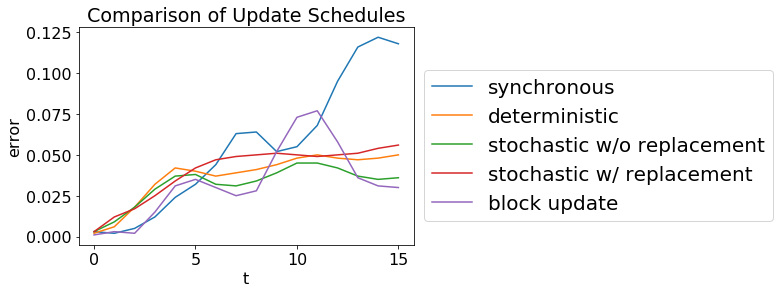

In [807]:
#graph different update schedules
#errors=[0.016, 0.013, 0.013, 0.028, 0.043, 0.052, 0.062, 0.073, 0.077, 0.078, 0.085, 0.091, 0.099, 0.103, 0.1, 0.092]
#errors1=[0.014, 0.02, 0.037, 0.052, 0.062, 0.061, 0.058, 0.059, 0.06, 0.064, 0.068, 0.07, 0.068, 0.066, 0.067, 0.067]
#errors2=[0.014, 0.026, 0.038, 0.052, 0.06, 0.058, 0.054, 0.052, 0.054, 0.058, 0.063, 0.064, 0.06, 0.057, 0.055, 0.057]
#errors3=[0.015, 0.03, 0.034, 0.042, 0.049, 0.055, 0.059, 0.06, 0.061, 0.06, 0.06, 0.06, 0.061, 0.063, 0.066, 0.069]
#errors4=[0.017, 0.013, 0.019, 0.036, 0.052, 0.055, 0.048, 0.044, 0.049, 0.066, 0.077, 0.078, 0.067, 0.053, 0.05, 0.051]
#removed math.sqrt from formula
errors=[0.003, 0.002, 0.005, 0.012, 0.024, 0.032, 0.044, 0.063, 0.064, 0.052, 0.055, 0.068, 0.095, 0.116, 0.122, 0.118]
errors1=[0.002, 0.006, 0.018, 0.032, 0.042, 0.04, 0.037, 0.039, 0.041, 0.044, 0.048, 0.05, 0.048, 0.047, 0.048, 0.05]
errors2=[0.003, 0.009, 0.018, 0.029, 0.037, 0.038, 0.032, 0.031, 0.034, 0.039, 0.045, 0.045, 0.042, 0.037, 0.035, 0.036]
errors3=[0.003, 0.012, 0.017, 0.025, 0.034, 0.042, 0.047, 0.049, 0.05, 0.051, 0.05, 0.049, 0.05, 0.051, 0.054, 0.056]
errors4=[0.001, 0.003, 0.002, 0.015, 0.031, 0.035, 0.03, 0.025, 0.028, 0.052, 0.073, 0.077, 0.058, 0.036, 0.031, 0.03]
xvalues=range(iterations+1)

plt.title("Comparison of Update Schedules")
plt.xlabel("t")
plt.ylabel("error")
plt.plot(xvalues,errors,label='synchronous')
plt.plot(xvalues,errors1,label='deterministic')
plt.plot(xvalues,errors2,label='stochastic w/o replacement')
plt.plot(xvalues,errors3,label='stochastic w/ replacement')
plt.plot(xvalues,errors4,label='block update')
plt.legend(bbox_to_anchor=(1.0, 0.85), fontsize=20)

In [775]:
#yact_prob_sim={}
for seed in lsimulations: yact_prob_sim[seed]={}
for seed in lsimulations:
    aggregate_simulation(seed,lsimulations,yact_prob_sim)

len(yact_prob_sim)

25

In [948]:
#check CellSize; it appears that this network does not have the same error as thaliana
print yact_prob_sim['(21,)'][10]['CellSize']
for node in NY.nodes:
    if node.name=='CellSize': break
print node.name,node.inputs,node.outputs

0.44
CellSize ['CellSize'] [0, 1]


In [76]:
#compare entropies across different update schedules
def compare_entropies_asynchronous(N,seeds,sunits,sunit_map,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,reduced=False,ds=None,
    stats={},pinning={},results=False,schedule='synchronous',models=100,order=None,verbose=False):
    """ possible udpate schedules are 'synchronous', 'deterministic asynchronous', 'stochastic without replacement', 'stochastic with replacement', 'block udpate' 
    NOTE: this can only accept seeds of the same length; order argument ignored unless update='block update' """
    
    entropy_modules,entropy_sim={seed:[0.0 for i in range(iterations+1)] for seed in seeds},{seed:[0.0 for i in range(iterations+1)] for seed in seeds}
    modules,translator={},{}
    time_limit=iterations+2
    act_prob_sim={seed:{} for seed in seeds}
    simulations={}
    for seed in seeds:
        length=len(eval(seed)) #seed expected to be a string!
        if verbose: print seed
        #get deterministic modules and updates
        if schedule=='synchronous': update='synchronous'
        if schedule=='block update': update='asynchronous'
        if schedule=='synchronous' or schedule=='block update':
            modules,translator=find_modules(N,length,sunits,sunit_map,modules,translator,reduced=reduced,ds=ds,pinning=pinning,iterations=iterations,
                                  data=True,seeds=[eval(seed)],update=update,order=order,regenerate=False,verbose=False)
            simulations=compare_simulations(N,[seed],sunit_map,modules,translator,length=length,runs=runs,tau=tau,iterations=iterations,
             unknown_prob=unknown_prob,stats={},results=results,time_limit=time_limit,update=update,order=order,regenerate=False)
            aggregate_simulation(seed,simulations,act_prob_sim)
            #print act_prob_sim[seed][iterations]          
            #calculate entropy for modules
            seed_entropy,seed_configs=config_entropy(modules[seed],base=2,normalized=True)
            entropy_modules[seed]=[seed_entropy[x] for x in seed_entropy]
            #calculate entropy for simulations
            seed_entropy,seed_configs=config_entropy(act_prob_sim[seed],base=2,normalized=True) 
            entropy_sim[seed]=[seed_entropy[x] for x in seed_entropy]

        else: #get stochastic modules and updates
            deterministic=False
            replacement=False
            if schedule=='deterministic asynchronous':
                deterministic=True
            if schedule=='stochastic with replacement':
                replacement=True
            d,s=compare_simulations_asynchronous(N,[seed],sunit_map,length=length,runs=runs,tau=tau,iterations=iterations,unknown_prob=unknown_prob,
                reduced=reduced,ds=ds,stats={},results=results,time_limit=time_limit,deterministic=deterministic,replacement=replacement,models=models,verbose=verbose)
            for m in range(len(d)):
                modules[seed]=d[m][seed]
                act_prob_sim[seed]={}
                aggregate_simulation(seed,s[m],act_prob_sim)
                #print 'Model:',m,len(modules[seed]),len(act_prob_sim[seed]),len(entropy_modules[seed])
                #calculate entropy for modules
                seed_entropy,seed_configs=config_entropy(modules[seed],base=2,normalized=True)
                entropy_modules[seed]=[entropy_modules[seed][i]+[seed_entropy[x] for x in seed_entropy][i] for i in range(iterations+1)]
                #calculate entropy for simulations
                seed_entropy,seed_configs=config_entropy(act_prob_sim[seed],base=2,normalized=True)
                entropy_sim[seed]=[entropy_sim[seed][i]+[seed_entropy[x] for x in seed_entropy][i] for i in range(iterations+1)]
                #print 'Entropy:',[seed_entropy[x] for x in seed_entropy]
            entropy_modules[seed]=[entropy_modules[seed][i]/len(d) for i in range(iterations+1)]
            entropy_sim[seed]=[entropy_sim[seed][i]/len(d) for i in range(iterations+1)]
    
    return entropy_modules,entropy_sim
        
#seeds=['()','(1,)'] #ymodules.keys()
#compare_entropies_asynchronous(NY,seeds,ysunits,ysunit_map,schedule='asynchronous',iterations=15,order=order)

In [1155]:
#driver_entropy_modules,driver_entropy_sim={key:{} for key in keys},{key:{} for key in keys}
key='synchronous' #deterministic asynchronous
seeds=['(1, 6, 11)'] #ymodules.keys(), ['()','(1,)']
#seeds=['(0, 4, 6, 11, 15)','(1, 5, 7, 10, 12, 17)','(1, 5, 7, 13)','(0, 4, 6, 10, 12, 14, 16)','(1, 5, 6, 10, 17)','(0, 5, 6, 12, 16)','(0, 4, 7, 11, 12, 15)','(1, 4, 7, 10, 13)','(0, 4, 7, 11, 12, 14)','(0, 4, 6, 10, 12, 15)','(0, 4, 6, 11, 14)']
avm,avs=compare_entropies_asynchronous(NY,seeds,ysunits,ysunit_map,schedule=key,iterations=15,order=order,runs=100,models=100,verbose=True)
driver_entropy_modules[key][seeds[0]]=avm[seeds[0]]
driver_entropy_sim[key][seeds[0]]=avs[seeds[0]]
len(avm),len(avs)

(1, 6, 11)


(1, 1)

In [1156]:
#driver_entropy_modules
avm

{'(1, 6, 11)': [0.75,
  0.501248397430713,
  0.3827343503644916,
  0.25697017622268575,
  0.13963087205935323,
  0.020975426399975013,
  0.0006863817996256559,
  9.699076360773117e-06,
  8.089456150570721e-09,
  7.89418418524265e-14,
  4.0598451415386596e-22,
  1.3252672028912262e-35,
  1.4180636164441406e-57,
  3.061731629333925e-93,
  4.371347542086831e-151,
  8.32833030291283e-245]}

In [108]:
#compare entropies over different update schedules for different seeds
#yact_prob_sim={}
keys=['synchronous','deterministic asynchronous','stochastic without replacement','stochastic with replacement','block update']
#avg_entropy_modules,avg_entropy_sim={key:{} for key in keys},{key:{} for key in keys}

{'block update': {},
 'deterministic asynchronous': {},
 'stochastic with replacement': {},
 'stochastic without replacement': {},
 'synchronous': {}}

In [222]:
#aggregate synchronous simulations
key='block update' #'synchronous', 'block update'
seed='(3,)' #SPECIFY SEED, '()', '(1,)', '(2,)', '(3,)'
yact_prob_sim[seed]={}
aggregate_simulation(seed,simulations,yact_prob_sim)
#calculate entropy for modules
diffusion=ymodules[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
yvalues=[seed_entropy[x] for x in seed_entropy]
avg_entropy_modules[key][seed]=yvalues
#calculate entropy for simulations
diffusion=yact_prob_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
yvalues=[seed_entropy[x] for x in seed_entropy] 
avg_entropy_sim[key][seed]=yvalues
avg_entropy_sim[key][seed]

[0.9109068084977667,
 0.7956851409925022,
 0.6716557046083403,
 0.6302562039367877,
 0.5500060804363517,
 0.34686742372382123,
 0.24441200414337805,
 0.1647208369633754,
 0.15274365613509358,
 0.15274365613509358,
 0.15274365613509358,
 0.15274365613509358,
 0.15274365613509358,
 0.15274365613509358,
 0.15274365613509358,
 0.15274365613509358]

In [282]:
#avg_entropy_sim[keys[3]]

In [253]:
#run entropy comparisons based on various models, then average
key=keys[3] #['synchronous','deterministic asynchronous','stochastic without replacement','stochastic with replacement','block update']
seed='(3,)' #SPECIFY SEED, '()', '(7,)', '(28,)', '(29)'

avg_entropy_modules[key][seed]=[0.0 for i in range(iterations+1)]
avg_entropy_sim[key][seed]=[0.0 for i in range(iterations+1)]
for m in range(len(d)):
    ymodules[seed]=d[m][seed]
    yact_prob_sim[seed]={}
    aggregate_simulation(seed,s[m],yact_prob_sim)
    #print 'Model:',m,len(ymodules[seed]),len(yact_prob_sim[seed]),len(avg_entropy_modules[seed])
    #calculate entropy for modules
    diffusion=ymodules[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    yvalues=[seed_entropy[x] for x in seed_entropy]
    avg_entropy_modules[key][seed]=[avg_entropy_modules[key][seed][i]+yvalues[i] for i in range(iterations+1)]
    #calculate entropy for simulations
    diffusion=yact_prob_sim[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    yvalues=[seed_entropy[x] for x in seed_entropy] 
    avg_entropy_sim[key][seed]=[avg_entropy_sim[key][seed][i]+yvalues[i] for i in range(iterations+1)]
    #print 'Entropy:',yvalues
avg_entropy_modules[key][seed]=[avg_entropy_modules[key][seed][i]/len(d) for i in range(iterations+1)]
avg_entropy_sim[key][seed]=[avg_entropy_sim[key][seed][i]/len(d) for i in range(iterations+1)]
print avg_entropy_modules[key][seed]
print avg_entropy_sim[key][seed]

[0.9166666666666674, 0.8150292912257158, 0.7194341852574708, 0.638678068406708, 0.5951056475734988, 0.5666414594891546, 0.5423953620862937, 0.5240327826269167, 0.5173011929160675, 0.49891173327097527, 0.4743468573062202, 0.4532492693692919, 0.44064535749601563, 0.43445893535207625, 0.43556102212443953, 0.43405082595628836]
[0.9098875815064583, 0.8747792459461489, 0.8361400314058116, 0.801972478601691, 0.7664187324042859, 0.7235638606698223, 0.671944388470687, 0.6117167883988891, 0.5443652973664078, 0.48217325290655816, 0.42334257209810994, 0.3710813211976765, 0.3290905233733445, 0.2935200130937985, 0.2676683061044042, 0.2481847715307743]


In [328]:
seed='(1, 11, 16)'
for key in keys: print key+':','\n',[round(driver_entropy_modules[key][seed][i],3) for i in range(iterations+1)]
print
for key in keys: print key+':','\n',[round(driver_entropy_sim[key][seed][i],3) for i in range(iterations+1)]

synchronous: 
[0.75, 0.573, 0.366, 0.237, 0.121, 0.069, 0.057, 0.054, 0.053, 0.052, 0.051, 0.051, 0.05, 0.049, 0.048, 0.048]
deterministic asynchronous: 
[0.75, 0.472, 0.274, 0.194, 0.16, 0.147, 0.138, 0.131, 0.125, 0.119, 0.114, 0.11, 0.106, 0.102, 0.098, 0.095]
stochastic without replacement: 
[0.75, 0.46, 0.285, 0.194, 0.154, 0.139, 0.13, 0.123, 0.117, 0.112, 0.108, 0.104, 0.1, 0.097, 0.093, 0.09]
stochastic with replacement: 
[0.75, 0.554, 0.394, 0.29, 0.211, 0.155, 0.128, 0.104, 0.091, 0.081, 0.075, 0.071, 0.068, 0.065, 0.062, 0.06]
block update: 
[0.75, 0.521, 0.193, 0.12, 0.096, 0.091, 0.089, 0.086, 0.084, 0.081, 0.079, 0.077, 0.075, 0.074, 0.072, 0.07]

synchronous: 
[0.747, 0.561, 0.376, 0.236, 0.085, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
deterministic asynchronous: 
[0.745, 0.465, 0.18, 0.043, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
stochastic without replacement: 
[0.745, 0.525, 0.285, 0.106, 0.024, 0.003, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

synchronous
deterministic asynchronous
stochastic without replacement
stochastic with replacement
block update


Text(0.5,0,'t')

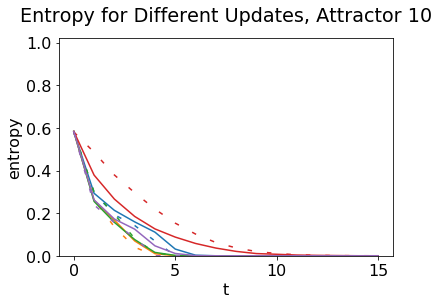

In [560]:
#graph average entropy
seeds=['(0, 4, 6, 11, 15)','(1, 5, 7, 10, 12, 17)','(1, 5, 7, 13)','(0, 4, 6, 10, 12, 14, 16)','(1, 5, 6, 10, 17)','(0, 5, 6, 12, 16)','(0, 4, 7, 11, 12, 15)','(1, 4, 7, 10, 13)','(0, 4, 7, 11, 12, 14)','(0, 4, 6, 10, 12, 15)','(0, 4, 6, 11, 14)']
k=10
seed=seeds[k]  #'(1, 11, 16)'
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
xvalues=[i for i in range(iterations+1)]
for i,key in enumerate(keys):
    print key
    yvalues=driver_entropy_modules[key][seed]
    yvalues_sim=driver_entropy_sim[key][seed]
    plt.plot(xvalues,yvalues,label=key)
    plt.plot(xvalues,yvalues_sim,'--',dashes=(3, 10),color=colors[i],markersize=10)

plt.title("Entropy for Different Updates, Attractor "+str(k),y=1.05) #seed={Cln3-1}, "Attractor "+str(k)
plt.ylim([0.0,1.02])
#plt.xticks([1,3,5,7,9,11,13,15])
plt.ylabel("entropy")
plt.xlabel("t")
#plt.legend(bbox_to_anchor=(1,0.9), fontsize=20)

In [385]:
driver_entropy_modules['stochastic without replacement'].keys()

['(0, 4, 6, 10, 12, 15)',
 '(1, 5, 7, 13)',
 '(0, 4, 6, 11, 15)',
 '(1, 5, 7, 10, 12, 17)',
 '(1, 4, 7, 10, 13)',
 '(0, 4, 7, 11, 12, 15)',
 '(1, 5, 6, 10, 17)',
 '(0, 4, 7, 11, 12, 14)',
 '(0, 4, 6, 11, 14)',
 '(0, 5, 6, 12, 16)',
 '(0, 4, 6, 10, 12, 14, 16)']

[]
{0: 1.0, 1: 0.9226275738639753, 2: 0.8973408899560379, 3: 0.8800001371643957, 4: 0.8220519244059825, 5: 0.7565567327250425, 6: 0.7021462195434114, 7: 0.6719825968314033, 8: 0.6892164520237477, 9: 0.7138865545668621, 10: 0.6719007542905882, 11: 0.6207083914928222, 12: 0.5654705413481519, 13: 0.5531533246271375, 14: 0.5945587878326727, 15: 0.6424440921102123}
Normalized entropy: [1.0, 0.92, 0.9, 0.88, 0.82, 0.76, 0.7, 0.67, 0.69, 0.71, 0.67, 0.62, 0.57, 0.55, 0.59, 0.64] [1.0, 0.92, 0.9, 0.88, 0.82, 0.76, 0.7, 0.67, 0.69, 0.71, 0.67, 0.62, 0.57, 0.55, 0.59, 0.64]
Probable configurations: ['1.15e+18', '4.62e+16', '1.61e+16', '7.84e+15', '7.04e+14', '4.62e+13', '4.81e+12', '1.37e+12', '2.81e+12', '7.84e+12', '1.37e+12', '1.63e+11', '1.63e+10', '9.79e+09', '5.48e+10', '4.02e+11']


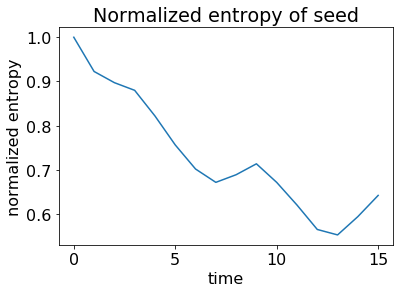

Total possible configurations: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


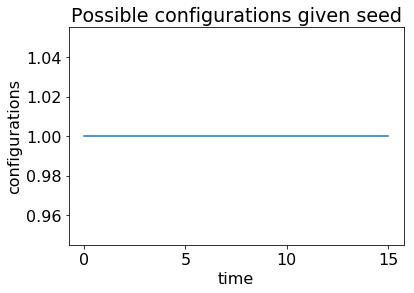

In [776]:
#single seed entropy
seed='()' #'(7,)'
print to_list(seed,ysunit_map,ytranslator)
diffusion=ymodules[seed] #ymodules[seed], yact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
print seed_entropy
xvalues=seed_entropy.keys()
yvalues=[seed_entropy[key] for key in seed_entropy]
#print [round(y*60,2) for y in yvalues]
plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues]) #normalize everything compared to the starting value
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
#plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True,strict=True)
xvalues=seed_configs.keys()
y1values=[seed_configs[key] for key in seed_configs]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
print 'Total possible configurations:',[round(yvalue,5) for yvalue in y1values],[round(yvalue/y1values[0],5) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

seeds: 24
Average entropy: [54.6, 47.87, 45.25, 44.56, 42.93, 40.86, 39.31, 37.33, 35.93, 34.88, 33.97, 33.4, 32.89, 32.69, 32.56, 32.55]
Normalized entropy: [0.91, 0.8, 0.75, 0.74, 0.72, 0.68, 0.66, 0.62, 0.6, 0.58, 0.57, 0.56, 0.55, 0.54, 0.54, 0.54] [1.0, 0.88, 0.83, 0.82, 0.79, 0.75, 0.72, 0.68, 0.66, 0.64, 0.62, 0.61, 0.6, 0.6, 0.6, 0.6]
Possible configurations: ['2.74e+16', '2.57e+14', '4.17e+13', '2.60e+13', '8.41e+12', '2.00e+12', '6.80e+11', '1.73e+11', '6.53e+10', '3.17e+10', '1.68e+10', '1.13e+10', '7.94e+09', '6.93e+09', '6.35e+09', '6.28e+09']


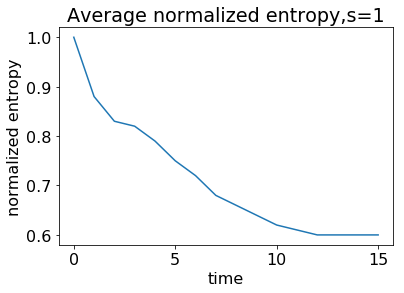

Total possible configurations: [0.5, 0.42, 0.4, 0.36, 0.35, 0.35, 0.34, 0.31, 0.31, 0.3, 0.27, 0.27, 0.26, 0.26, 0.26, 0.26] [1.0, 0.84, 0.8, 0.73, 0.71, 0.7, 0.68, 0.63, 0.61, 0.59, 0.55, 0.54, 0.53, 0.52, 0.52, 0.52]


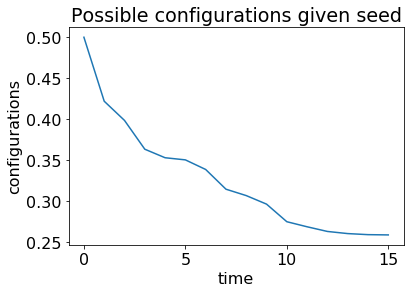

In [779]:
#multiple seed entropies
length,iterations=1,15
seeds=reduce_seeds(yact_prob_sim,ysunit_map,ytranslator,length=length) #['()','(3,)']
#seeds=simulations.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(yact_prob_sim,seeds,normalized=True,data=False) #dpmodules, submodules, dpact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * 60,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(yact_prob_sim,seeds,normalized=True,data=False,strict=True) #submodules,dact_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

(1,) 0.07969038251321008
(3,) 0.151727703086021
(0,) 0.1653669545834489
(2,) 0.343250525854329
(4,) 0.43474922464170646
(11,) 0.44784874876877373
(17,) 0.46086722196837293
(13,) 0.4944484409410462
(20,) 0.5345955354839466
(5,) 0.539415724993695
(21,) 0.5486197995134634
(6,) 0.5635168882384988
(16,) 0.5785837193667032
(12,) 0.5893319672169728
(19,) 0.6243701909847091
(9,) 0.6299752884107196
(23,) 0.6595939340517235
(8,) 0.6686087094897037
(7,) 0.6903198701762188
(10,) 0.6952814246008904
(22,) 0.7668482258452127
(18,) 0.8307997161494244
(15,) 0.9158311909951536
(14,) 0.9162556772214114


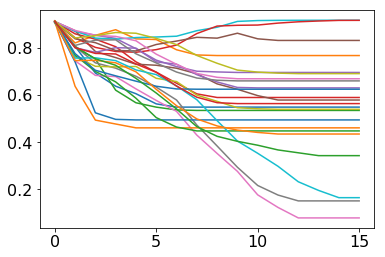

In [176]:
#find the seed that reduces entropy the most
for seed in sorted(seed_entropy,key=lambda x: seed_entropy[x][15]): print seed,seed_entropy[seed][15]
for seed in seed_entropy:
    plt.plot([i for i in range(16)],[seed_entropy[seed][i] for i in range(16)],label=seed)
#plt.legend()

In [210]:
#compare to FVS drivers
yfvs=fvs_set(NY,method='bruteforce') #method='bruteforce'
print len(yfvs)
for x in sorted(yfvs): 
    #print x,dpsunit_map[dptranslator[x][0]]
    seed_entropy,seed_configs=config_entropy(ymodules[x],base=2,normalized=True)
    print x,ysunit_map[ytranslator[x][0]],seed_entropy[10]
#analyze attractors for thaliana
yattractors=attractors_to_dict(NY)
print len(yattractors)

16
(0,) CellSize-0 0.4101234735611215
(1,) CellSize-1 0.22913712807153053
(10,) Sic1-0 0.8142331435823507
(11,) Sic1-1 0.17605118616050727
(12,) Clb5,6-0 0.2705954422964643
(13,) Clb5,6-1 0.1920999821666172
(14,) Cdh1-0 0.682846094449267
(15,) Cdh1-1 0.6055192142388767
(16,) Clb1,2-0 0.4484907955923769
(17,) Clb1,2-1 0.1761934936811761
(22,) Swi5-0 0.6986553867046476
(23,) Swi5-1 0.5830099383420647
(4,) SBF-0 0.4274879270539129
(5,) SBF-1 0.6594633678760923
(6,) MBF-0 0.22108937293812647
(7,) MBF-1 0.723951714764752
11


In [986]:
#determine top selection based on FVS nodes or any node 
selections,entropies=top_selection(NY,ysunits,ysunit_map,ymodules,ytranslator,seeds=None,max_s=10,top=1,reduced=True,ds=dy,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=True)
for seed in selections: 
    print seed, entropies[seed], to_list(seed,ysunit_map,ytranslator)
print to_list(reduce_selection(seed,NY,ysunits,ysunit_map,ymodules,ytranslator,reduced=True,ds=dy,t=10),ysunit_map)

193 193
() 0.6719007542905882 []
(11,) 0.17605118616050727 ['Sic1-1']
(1, 11) 0.007480228501862943 ['CellSize-1', 'Sic1-1']
(1, 6, 11) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1']
(1, 6, 9, 11) 0.0 ['CellSize-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1']
(1, 6, 9, 11, 15) 0.0 ['CellSize-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1', 'Cdh1-1']
(1, 3, 6, 9, 11, 15) 0.0 ['CellSize-1', 'Cln3-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1', 'Cdh1-1']
(1, 3, 6, 9, 11, 15, 21) 0.0 ['CellSize-1', 'Cln3-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1', 'Cdh1-1', 'Cdc20/14-1']
(1, 3, 6, 9, 11, 15, 16, 21) 0.0 ['CellSize-1', 'Cln3-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1', 'Cdh1-1', 'Clb1,2-0', 'Cdc20/14-1']
(1, 3, 6, 9, 11, 12, 15, 16, 21) 0.0 ['CellSize-1', 'Cln3-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0', 'Cdc20/14-1']
(1, 3, 6, 9, 11, 12, 15, 16, 21, 22) 0.0 ['CellSize-1', 'Cln3-1', 'MBF-0', 'Cln1,2-1', 'Sic1-1', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0', 'Cdc20/14-1', 'Swi5-0']
['CellSize-1', 'Sic1-1', 'Cdh1-1', 'Cdc20/14-1']


In [1072]:
#del ytranslator['(0, 10, 15, 17)']
for key in ytranslator:
    if type(ytranslator[key])==str: print key,ytranslator[key]
#diffusion=ymodules['(1, 6, 11)'] #ymodules[seed], yact_prob_sim[seed], low_sim[seed]
#config_entropy(diffusion,base=2,normalized=True)[0]

In [78]:
#print entropies['(1, 6, 11)']#[10]
#determine selections based on different updating schemes
ymodules,ytranslator={},{}
selections,entropies=top_selection(NY,ysunits,ysunit_map,ymodules,ytranslator,seeds=None,max_s=15,top=1,reduced=True,ds=dy,t=10,
        iterations=10,attractor=None,attractors=None,force=False,pin_start=True,update='synchronous',regenerate=False)
for seed in selections: print seed, entropies[seed], to_list(seed,ysunit_map,ytranslator)
print reduce_selection(seed,NY,ysunits,ysunit_map,ymodules,ytranslator,reduced=True,ds=dy,t=10)

25 25
() 0.6719007542905882 []
(11,) 0.17605118616050727 ['Sic1-1']
(1, 11) 0.007480228501862943 ['CellSize-1', 'Sic1-1']
(1, 6, 11) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1']
(1, 6, 11, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
(1, 6, 11, 13, 16) 0.0 ['CellSize-1

In [87]:
#average over different models
#yavg_drivers={'synchronous':{},'deterministic asynchronous':{},'stochastic without replacement':{},'stochastic with replacement':{},'block update':{}}
models=100
key='stochastic with replacement'
for m in range(models):
    print m
    selection=driver_selection(NY,ysunits,ysunit_map,{},ytranslator,attractor=None,attractors=None,pin_start=True,
                               update='stochastic asynchronous',order=None,regenerate=True)
    print selection
    yavg_drivers[key].setdefault(str(selection),0)
    yavg_drivers[key][str(selection)]+=1
yavg_drivers[key]

0
25 740
(0, 15, 17)
1
25 740
(0, 13, 20)
2
25 740
(0, 15, 17)
3
25 740
(1, 6, 11, 15)
4
25 754
(1, 11, 12)
5
25 754
(0, 15, 17)
6
25 822
(1, 3, 6, 11)
7
25 822
(0, 15, 17)
8
25 822
(0, 13, 20)
9
25 822
(0, 15, 17)
10
25 822
(1, 6, 11, 18)
11
25 822
(0, 15, 17)
12
25 822
(1, 11, 12, 15)
13
25 822
(1, 11, 12, 15)
14
25 822
(1, 13, 16, 22)
15
25 886
(1, 11, 12, 15)
16
25 886
(0, 15, 17)
17
25 886
(0, 13, 20)
18
25 933
(0, 14, 17)
19
25 950
(0, 15, 17)
20
25 950
(1, 11, 12, 15)
21
25 950
(1, 12, 16)
22
25 1041
(1, 2, 5, 13)
23
25 1106
(1, 6, 11, 16)
24
25 1106
(0, 13, 20)
25
25 1120
(0, 3, 11, 12, 18)
26
25 1183
(0, 13, 20)
27
25 1183
(0, 15, 17)
28
25 1183
None
29
25 1183
(0, 15, 17)
30
25 1183
(0, 15, 17)
31
25 1183
(0, 15, 17)
32
25 1183
(1, 12, 16)
33
25 1246
(1, 11, 12, 15)
34
25 1246
(1, 11, 12, 15)
35
25 1246
(0, 15, 17)
36
25 1246
(1, 11, 12, 15)
37
25 1246
(0, 15, 17)
38
25 1246
(0, 13, 20)
39
25 1246
(0, 15, 17)
40
25 1246
(1, 6, 11, 16)
41
25 1246
(0, 3, 11, 12, 18)
42
25 1246


{'(0, 10, 13)': 3,
 '(0, 13, 20)': 11,
 '(0, 14, 17)': 3,
 '(0, 15, 17)': 31,
 '(0, 3, 11, 12, 18)': 2,
 '(0, 3, 6, 11, 15)': 1,
 '(0, 5, 13)': 1,
 '(0, 9, 13)': 1,
 '(1, 11, 12)': 4,
 '(1, 11, 12, 15)': 14,
 '(1, 11, 12, 22)': 1,
 '(1, 11, 12, 23)': 1,
 '(1, 12, 16)': 4,
 '(1, 13, 16, 22)': 1,
 '(1, 2, 15, 17)': 1,
 '(1, 2, 5, 13)': 1,
 '(1, 3, 11, 12)': 1,
 '(1, 3, 6, 11)': 1,
 '(1, 4, 21)': 2,
 '(1, 6, 11, 15)': 2,
 '(1, 6, 11, 16)': 6,
 '(1, 6, 11, 18)': 1,
 '(1, 6, 11, 22)': 1,
 '(1, 8, 19)': 1,
 '(1, 8, 21)': 1,
 'None': 4}

Text(0,0.5,'proportion of driver sets')

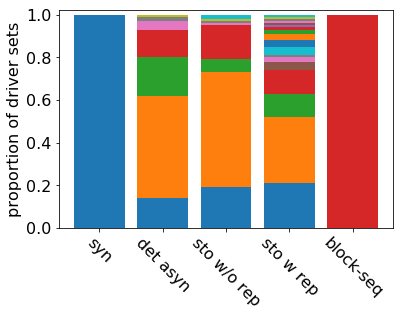

In [112]:
#graph attractor basins for the unconstrained greedy selection process; G1 attractor driver is {0,4,6,11,15}
xvalues=[0,1,2,3,4]
yvalues=[1,0.14,0.19,0.21,0] #(1, 11, 12, 15) [1,0.2,0.1,0.2], [1,0.14,0.19,0.21,0]
yvalues1=[0,0.48,0.54,0.31,0] #(0, 15, 17) [0,0.6,0.4,0.2], [0,0.48,0.54,0.31,0]
yvalues2=[0,0.18,0.06,0.11,0] #(0, 13, 20) [0,0.2,0.3,0.3], [0,0.18,0.06,0.11,0]
yvalues3=[0,0.13,0.16,0.11,1] #(1, 6, 11, 16) [0,0,0.1,0.1], [0,0.13,0.16,0.11,1]
yvalues4=[0,0,0,0,0] #(1, 3, 6, 11, 20) [0,0,0.1,0], [0,0,0,0,0]
yvalues5=[0,0,0,0.04,0] #(1, 12, 16) [0,0,0,0.1], [0,0,0,0.04,0]
yvalues6=[0,0.04,0.01,0.02,0] #(1, 4, 21) [0,0,0,0.1], [0,0.04,0.01,0.02,0]
yvalues7=[0,0.02,0.01,0.01,0] #(1, 8, 21) [0,0.02,0.01,0.01,0]
yvalues8=[0,0.01,0.01,0,0] #(1, 14, 19) [0,0.01,0.01,0,0]
yvalues9=[0,0,0.02,0.04,0] #None (force=True should prevent this because all nodes will eventually be selected) [0,0,0.02,0.04,0]
yvalues10=[0,0,0,0.03,0] #(0, 10, 13)
yvalues11=[0,0,0,0.03,0] #(0, 14, 17)
yvalues12=[0,0,0,0.02,0] #(0, 3, 11, 12, 18)
yvalues13,yvalues14,yvalues15,yvalues16,yvalues17,yvalues18,yvalues19=[0,0,0,0.01,0],[0,0,0,0.01,0],[0,0,0,0.01,0],[0,0,0,0.01,0],[0,0,0,0.01,0],[0,0,0,0.01,0],[0,0,0,0.01,0]
plt.bar(xvalues,yvalues)
plt.bar(xvalues,yvalues1,bottom=yvalues)
#plt.bar(xvalues,yvalues2,bottom=[yvalues[i]+yvalues1[i] for i in range(4)])
#plt.bar(xvalues,yvalues3,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i] for i in range(4)])
#plt.bar(xvalues,yvalues4,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i]+yvalues3[i] for i in range(4)])
#plt.bar(xvalues,yvalues5,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i]+yvalues3[i]+yvalues4[i] for i in range(4)])
#plt.bar(xvalues,yvalues6,bottom=[yvalues[i]+yvalues1[i]+yvalues2[i]+yvalues3[i]+yvalues4[i]+yvalues5[i] for i in range(4)])
for y in range(2,20):
    string='yvalues[i]'
    for z in range(1,y):
        string+='+yvalues'+str(z)+'[i]'
    #print eval('['+string+' for i in range(5)]'),'yvalues'+str(y)
    plt.bar(xvalues,eval('yvalues'+str(y)),bottom=eval('['+string+' for i in range(5)]'))
plt.ylim([0.0,1.02])
plt.xticks(xvalues,['syn','det asyn','sto w/o rep','sto w rep','block-seq'],rotation=-45)
plt.ylabel("proportion of driver sets")
#plt.legend()

In [209]:
#simulation entropy of strategy
yentropies_sim={}
entropies_sim=strategy_entropy(selections,NY,ysunit_map,ymodules,ytranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=ystats,results=False,time_limit=12,act_prob_sim=yact_prob_sim,entropies_sim=yentropies_sim,t=10)
for j,seed in enumerate(selections): print to_list(seed,ysunit_map,ytranslator), entropies_sim[seed]
        

[] 0.6724123633922702
['Sic1-1'] 0.6372097664954347
['CellSize-1', 'Sic1-1'] 0.22059532258448575
['CellSize-1', 'MBF-0', 'Sic1-1'] 0.20882359968396783
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb1,2-0'] 0.0
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0'] 0.0
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0'] 0.0
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0'] 0.0
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0'] 0.0
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0'] 0.0
['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0'] 0.0


In [264]:
#check solutions
DCMY=NY.dynamics_canalization_map(output=None, )
seed=['CellSize-1','MBF-0','Sic1-1'] #mf ERROR
seed=['CellSize-1', 'Sic1-1', 'Clb1,2-0'] #mf ERROR
seed=['CellSize-1', 'MBF-0', 'Sic1-1', 'Clb5,6-1', 'Clb1,2-0']
seed=['CellSize-1', 'SBF-1', 'MBF-0', 'Sic1-1', 'Clb5,6-0'] #mf ERROR
seed=['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-1'] #attractor 1, ERROR
seed=['CellSize-1', 'SBF-1', 'MBF-1', 'Sic1-0', 'Clb5,6-0', 'Clb1,2-1'] #attractor 2
seed=['CellSize-1', 'SBF-1', 'MBF-1', 'Clb5,6-1'] #attractor 3, ERROR
seed=['CellSize-1', 'SBF-1', 'MBF-1', 'Clb5,6-1', 'Cdh1-0', 'Clb1,2-1'] #attractor 3, non-reduced
seed=['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-0', 'Clb1,2-0'] #attractor 4
seed=['CellSize-1', 'SBF-1', 'MBF-0', 'Sic1-0', 'Clb1,2-1'] #attractor 5, ERROR
seed=['CellSize-0', 'SBF-1', 'MBF-0', 'Clb5,6-0', 'Clb1,2-0'] #attractor 6, ERROR
seed=['CellSize-0', 'SBF-0', 'MBF-1', 'Sic1-1', 'Clb5,6-0', 'Cdh1-1'] #attractor 7, ERROR
seed=['CellSize-0', 'SBF-0', 'MBF-1', 'Sic1-1', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0'] #attractor 7, non-reduced
seed=['CellSize-1', 'SBF-0', 'MBF-1', 'Sic1-0', 'Clb5,6-1'] #attractor 8, ERROR
seed=['CellSize-1', 'SBF-0', 'MBF-1', 'Sic1-0', 'Clb5,6-1', 'Cdh1-0', 'Clb1,2-1', 'Mcm1/SFF-1', 'Cdc20/14-1', 'Swi5-1'] #a8, non-reduced
seed=['CellSize-0', 'SBF-0', 'MBF-1', 'Sic1-1', 'Clb5,6-0', 'Cdh1-0'] #attractor 9, ERROR
seed=['CellSize-0', 'SBF-0', 'MBF-1', 'Sic1-1', 'Clb5,6-0', 'Cdh1-0', 'Clb1,2-0'] #attractor 9, non-reduced
seed=['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-1'] #attractor 10, ERROR
seed=['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0'] #attractor 10, non-reduced
seed=['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-0'] #attractor 11, ERROR
diffusion=BFS_threshold(DCMY,seed,'steady',time_limit=10,pinned={})
print count_sunits(diffusion)
#seed=(3, 21, 22)
#find_modules(NY,1,ysunits,ysunit_map,{},ytranslator,seeds=[seed],data=True,verbose=True,iterations=15)[0][str(seed)][12]

7


In [211]:
#determine top selections for attractors
iterations=10
t=iterations
for i,attractor in enumerate(yattractors):
    selections,entropies=top_selection(NY,ysunits,ysunit_map,ymodules,ytranslator,seeds=None,max_s=10,top=1,reduced=True,
            ds=dy,attractor=attractor,attractors=yattractors,pin_start=True,force=True,t=t,iterations=iterations)
    exec('ay'+str(i)+'=[entropies[x] for x in selections]') #entropy
    exec('sy'+str(i)+'=[x for x in selections]') #selection
    print attractor #,eval('a'+str(i))
    for seed in selections: 
        print seed, entropies[seed], to_list(seed,ysunit_map,ytranslator),
        print to_list(reduce_selection(seed,NY,ysunits,ysunit_map,ymodules,ytranslator,reduced=True,ds=dy,t=t,
                                       iterations=iterations),ysunit_map)
        if entropies[seed]==0.0: break #no need to print out the rest

118 118
000001010000
() 0.6719007542905882 [] []
(11,) 0.17605118616050727 ['Sic1-1'] ['Sic1-1']
(6, 11) 0.17038663591566794 ['MBF-0', 'Sic1-1'] ['MBF-0', 'Sic1-1']
(6, 11, 16) 0.16810409845015542 ['MBF-0', 'Sic1-1', 'Clb1,2-0'] ['MBF-0', 'Sic1-1', 'Clb1,2-0']
(0, 6, 11, 16) 0.13524147660671235 ['CellSize-0', 'MBF-0', 'Sic1-1', 'Clb1,2-0'] ['CellSize-0', 'MBF-0', 'Sic1-1', 'Clb1,2-0']
(0, 4, 6, 11, 16) 0.05516467200929711 ['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1']
(0, 4, 6, 11, 15, 16) 0.0 ['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-1']
229 229
111110001111
() 0.6719007542905882 [] []
(17,) 0.1761934936811761 ['Clb1,2-1'] ['Clb1,2-1']
(14, 17) 0.16861037867321552 ['Cdh1-0', 'Clb1,2-1'] ['Cdh1-0', 'Clb1,2-1']
(7, 14, 17) 0.16810409848154348 ['MBF-1', 'Cdh1-0', 'Clb1,2-1'] ['MBF-1', 'Cdh1-0', 'Clb1,2-1']
(1, 7, 14, 17) 0.13549699244934185 ['CellSize-1', 'MBF-1', 'C

(0, 4, 6, 15, 16) 0.004345691226334742 ['CellSize-0', 'SBF-0', 'MBF-0', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Cdh1-1']
(0, 4, 6, 8, 15, 16) 0.0030553573151403447 ['CellSize-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1']
(0, 2, 4, 6, 8, 15, 16) 0.0030553573151403447 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1']
(0, 2, 4, 6, 8, 12, 15, 16) 0.005492867695270141 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1']
(0, 2, 4, 6, 8, 10, 12, 15, 16) 0.0 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-1']
1012 1012
000001000000
() 0.6719007542905882 [] []
(11,) 0.17605118616050727 ['Sic1-1'] ['Sic1-1']
(6, 11) 0.17038663591566794 

(-0.01, 0.9)

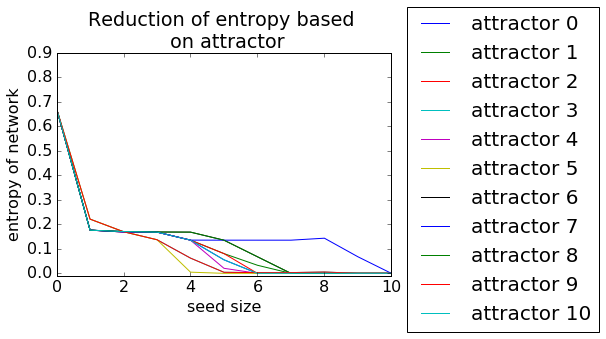

In [190]:
#graph attractors based on mf estimates
xvalues=range(11)
for i in range(len(yattractors)):
    plt.plot(xvalues,eval('ay'+str(i)),label='attractor '+str(i)) #given top x value
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.65, 1.25), fontsize=20)
plt.title("Reduction of entropy based \n on attractor", y=1.0)
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [212]:
#entropy of strategy; requires at and st variables above
#yentropies_sim={}
for i,strategy in enumerate(yattractors):
    print strategy
    selection=eval('sy'+str(i))
    entropies_sim=strategy_entropy(selection,NY,ysunit_map,ymodules,ytranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=ystats,results=False,time_limit=12,act_prob_sim=yact_prob_sim,entropies_sim=yentropies_sim,t=10)
    for j,seed in enumerate(selection): print to_list(seed,ysunit_map,ytranslator), eval('ay'+str(i)+'['+str(j)+']'), entropies_sim[seed]

000001010000
[] 0.6719007542905882 0.6724123633922702
['Sic1-1'] 0.17605118616050727 0.6372097664954347
['MBF-0', 'Sic1-1'] 0.17038663591566794 0.571397463328433
['MBF-0', 'Sic1-1', 'Clb1,2-0'] 0.16810409845015542 0.28760636667302925
['CellSize-0', 'MBF-0', 'Sic1-1', 'Clb1,2-0'] 0.13524147660671235 0.18590709012867465
['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Clb1,2-0'] 0.05516467200929711 0.0390829661324401
['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-1', 'Clb1,2-0'] 0.0 0.0
['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-1', 'Clb1,2-0', 'Mcm1/SFF-0'] 0.0 0.0
['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Cdh1-1', 'Clb1,2-0', 'Mcm1/SFF-0', 'Cdc20/14-0'] 0.0 0.0
['CellSize-0', 'SBF-0', 'MBF-0', 'Sic1-1', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0', 'Mcm1/SFF-0', 'Cdc20/14-0'] 0.0 0.0
['CellSize-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Sic1-1', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0', 'Mcm1/SFF-0', 'Cdc20/14-0'] 0.0 0.0
111110001111
[] 0.6719007542905882 0.6724123633922702
['Clb1,2-1'] 0.1761934936811761 0

[] 0.6719007542905882 0.6724123633922702
['MBF-0'] 0.22108937293812647 0.7755680053272781
['MBF-0', 'Clb1,2-0'] 0.1696497915139066 0.35764168180003314
['CellSize-0', 'MBF-0', 'Clb1,2-0'] 0.13704485180032847 0.20682158304190312
['CellSize-0', 'SBF-0', 'MBF-0', 'Clb1,2-0'] 0.062140043854641204 0.06315356330119609
['CellSize-0', 'SBF-0', 'MBF-0', 'Cdh1-1', 'Clb1,2-0'] 0.004345691226334742 0.034484737525302823
['CellSize-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1', 'Clb1,2-0'] 0.0030553573151403447 0.011253016900177298
['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1', 'Clb1,2-0'] 0.0030553573151403447 0.01713270901542358
['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0'] 0.005492867695270141 0.028107505551417823
['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0'] 0.0 0.0
['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Sic1-0', 'Clb5,6-0', 'Cdh1-1', 'Clb1,2-0', 'Mcm1/SFF-0'] 0.0 0.0
00

[0.6724123633922702, 0.6372097664954347, 0.571397463328433, 0.28760636667302925, 0.18590709012867465, 0.0390829661324401, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.6724123633922702, 0.35085576757830844, 0.37212179562405506, 0.4097331803783812, 0.2690950905482233, 0.10993215578858989, 0.027690552518467925, 0.0, 0.0, 0.0, 0.0]
[0.6724123633922702, 0.35085576757830844, 0.37212179562405506, 0.4097331803783812, 0.2690950905482233, 0.10993215578858989, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.6724123633922702, 0.7755680053272781, 0.35764168180003314, 0.20682158304190312, 0.06315356330119609, 0.03332817061991899, 0.012174520843344706, 0.01713270901542358, 0.028107505551417823, 0.0, 0.0]
[0.6724123633922702, 0.35085576757830844, 0.37212179562405506, 0.29573490427379623, 0.16827566051440968, 0.028429491095431355, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.6724123633922702, 0.7755680053272781, 0.35764168180003314, 0.20682158304190312, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.6724123633922702, 0.6372097664954347, 0.5793570838502057, 0.33782

(-0.01, 0.9)

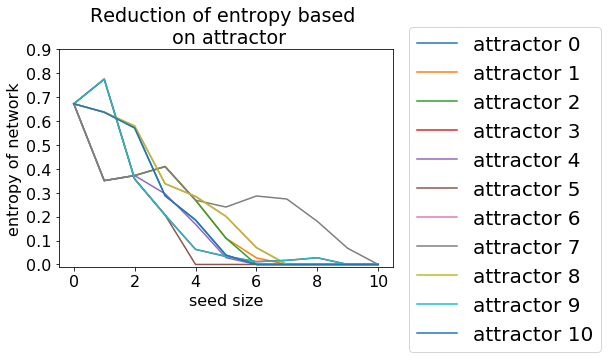

In [213]:
#graph attractors based on simulations of mf selections
xvalues=range(11)
for i in range(len(yattractors)):
    plt.plot(xvalues,[entropies_sim[seed] for seed in eval('sy'+str(i))],label='attractor '+str(i))
    print [entropies_sim[seed] for seed in eval('sy'+str(i))]
#plt.plot(xvalues,yrnd,label='random')
plt.legend(bbox_to_anchor=(1.65, 1.15), fontsize=20)
plt.title("Reduction of entropy based \n on attractor",y=1.0)
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

In [214]:
#entropy of random seed selections averaged over multiple samples
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s

selections_ls,avg=avg_random_selections(NY,ysunits,ysunit_map,ymodules,ytranslator,samples=samples,seeds=None,max_s=10,entropies={},
        reduced=True,ds=dy,t=10,runs=runs,stats=ystats,act_prob_sim=yact_prob_sim,entropies_sim=yentropies_sim,attractor=None,attractors=None)
print avg,len(selections_ls)

{0: 0.6724123633922692, 1: 0.5571141414741188, 2: 0.4614853497771497, 3: 0.3872605782407361, 4: 0.31590583770354114, 5: 0.2592009752820338, 6: 0.2070882716860438, 7: 0.15225319872623794, 8: 0.11061027237748287, 9: 0.06785770246906146, 10: 0.040565789059344944} 100


In [1000]:
#entropy of random seed selections averaged over multiple samples for different attractors
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s

for i,attractor in enumerate(yattractors): 
    selections_ls,avg=avg_random_selections(NY,ysunits,ysunit_map,ymodules,ytranslator,samples=samples,seeds=None,max_s=10,entropies={},
        reduced=True,ds=dy,t=10,runs=runs,stats=ystats,act_prob_sim=yact_prob_sim,entropies_sim=yentropies_sim,attractor=attractor,attractors=yattractors)
    exec('yavg'+str(i)+'=[avg[x] for x in avg]') #entropy of selection
    print avg,len(selections_ls)

{0: 0.70941398006439893, 1: 0.54771470807266442, 2: 0.4628250632586941, 3: 0.37931823442614471, 4: 0.31164785878393947, 5: 0.24439999793699496, 6: 0.19835707170040184, 7: 0.14395210455809829, 8: 0.096991575630457558, 9: 0.077119449808896567, 10: 0.041917919266776835} 100
{0: 0.70941398006439893, 1: 0.58087711186243318, 2: 0.47062023021249549, 3: 0.37555277662261838, 4: 0.31711159529739957, 5: 0.24389675721286977, 6: 0.19283758003903376, 7: 0.14461906135092265, 8: 0.10543636114335571, 9: 0.076080759758023794, 10: 0.047326440096504364} 100
{0: 0.70941398006439893, 1: 0.59702592704155233, 2: 0.50337311190778555, 3: 0.40278459917367082, 4: 0.32307173173717652, 5: 0.24023603407467548, 6: 0.18010269465736153, 7: 0.12711148304063763, 8: 0.084990482727394262, 9: 0.066382939773115671, 10: 0.044936716140875389} 100
{0: 0.70941398006439893, 1: 0.56952297826434817, 2: 0.47624305553355506, 3: 0.39001293982663143, 4: 0.32756430470944109, 5: 0.25555394748480625, 6: 0.19442707243501306, 7: 0.153143892

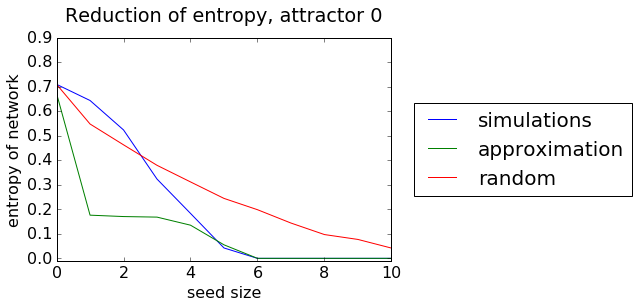

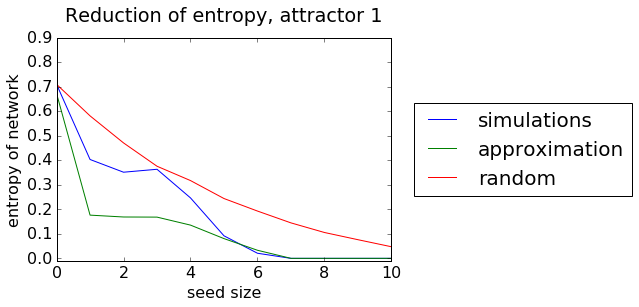

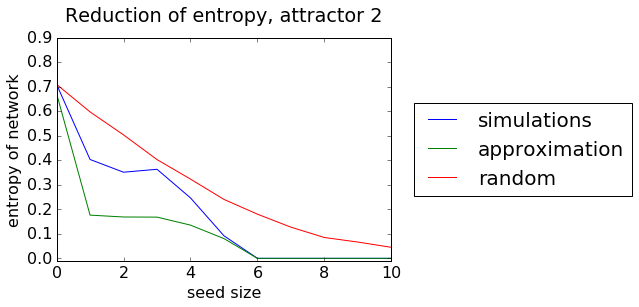

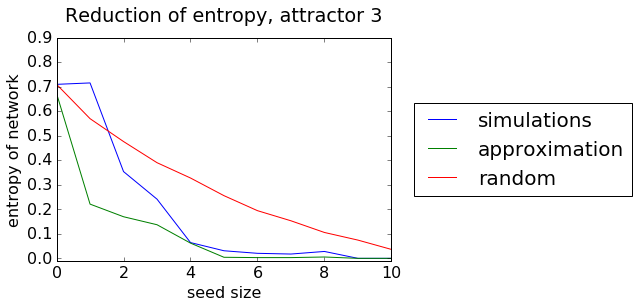

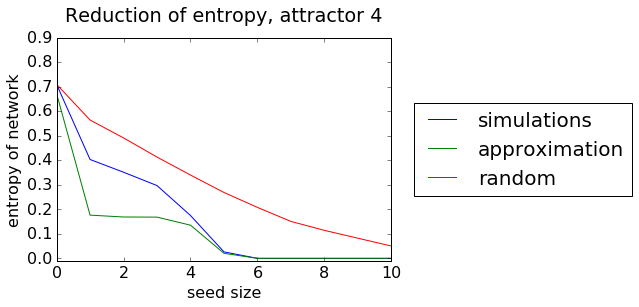

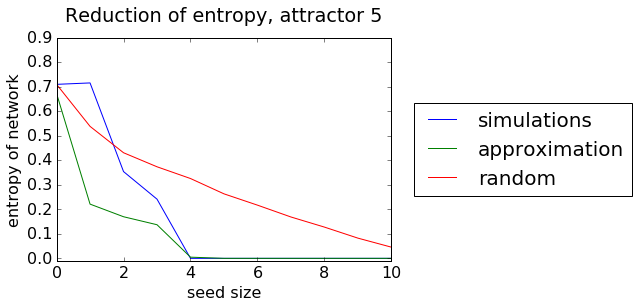

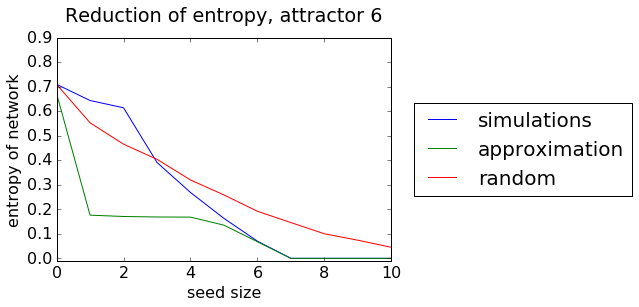

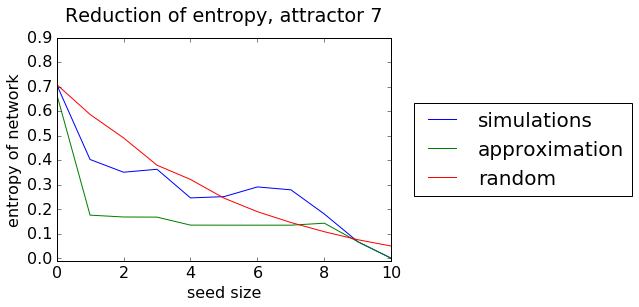

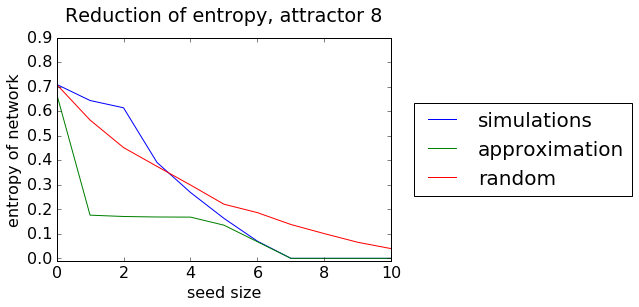

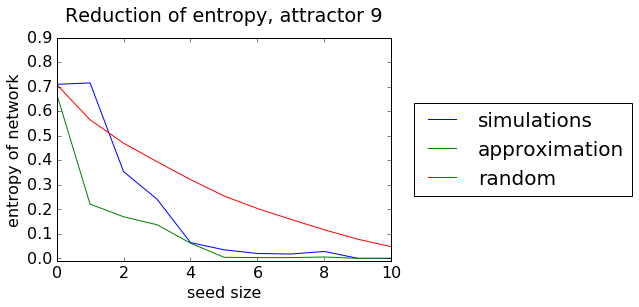

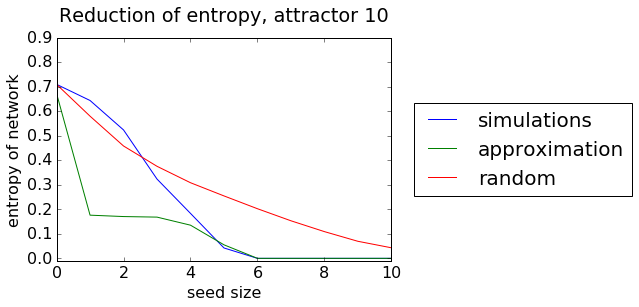

In [1001]:
#graph single attractor to compare approximation with simulations of mf selections
xvalues=range(11)
for i,attractor in enumerate(yattractors):
    plt.plot(xvalues,[yentropies_sim[seed] for seed in eval('sy'+str(i)+'[:]')],label='simulations')
    plt.plot(xvalues,eval('ay'+str(i)+'[:]'),label='approximation')
    plt.plot(xvalues,eval('yavg'+str(i)),label='random')
    plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20)
    plt.title("Reduction of entropy, attractor "+str(i),y=1.05)
    plt.ylabel("entropy of network")
    plt.xlabel("seed size")
    plt.yticks(np.arange(0,1,.1))
    plt.ylim([-.01,0.9])
    plt.show()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


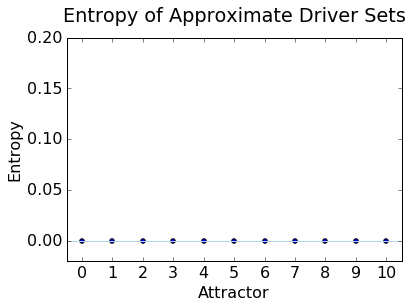

In [954]:
#graph actual entropy of approximate solutions based on simulations
yvalues=[]
for i,attractor in enumerate(yattractors):
    #print attractor
    for j,evalue in enumerate(eval('ay'+str(i))):
        if evalue==0:
            seed=eval('sy'+str(i)+'['+str(j)+']')
            yvalues.append(yentropies_sim[seed])
            break
print yvalues
plt.hlines(0.0,-1,11,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(11)],yvalues)
plt.ylim([-0.02,0.2])
plt.xlim([-0.5,10.5])
plt.xticks([i for i in range(11)])
plt.ylabel("Entropy")
plt.xlabel("Attractor")
plt.title("Entropy of Approximate Driver Sets",y=1.05)

In [958]:
#confirm approximate solutions by comparing to DCM modules
yvalues=[]
for i,attractor in enumerate(yattractors):
    print attractor,
    for j,evalue in enumerate(eval('ay'+str(i))):
        if evalue==0:
            seed=eval('sy'+str(i)+'['+str(j)+']')
            seed=to_list(seed,ysunit_map,ytranslator)
            diffusion=BFS_threshold(DCMY,seed,'steady',time_limit=10,pinned={})
            print count_sunits(diffusion)#seed
            yvalues.append(count_sunits(diffusion))
            #diffusion=BFS_threshold(DCMY,seed,'steady',time_limit=25,pinned={})
            #print count_sunits(diffusion)
            break

000001010000 8
111110001111 12
111110101111 12
000000000000 12
111010001111 11
001010000000 11
000101010000 12
110100101111 12
000101000000 12
000000010000 12
000001000000 8


[8, 12, 12, 12, 11, 11, 12, 12, 12, 12, 8]


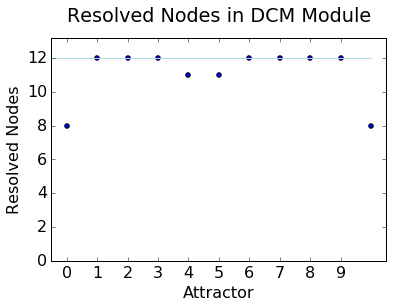

In [962]:
#graph nodes resolved of approximate solutions based on DCM modules
print yvalues
plt.hlines(12.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(11)],yvalues)
plt.ylim([-0.0,13.2])
plt.xlim([-0.5,10.5])
plt.xticks([i for i in range(10)])
plt.ylabel("Resolved Nodes")
plt.xlabel("Attractor")
plt.title("Resolved Nodes in DCM Module",y=1.05)

In [963]:
#employ a greedy strategy based on simulations for comparison
#determine top selections for attractors
#ysimulations={}
iterations=10
t=iterations
for i,attractor in enumerate(yattractors):
    selections,entropies=top_selection_simulations(NY,ysunits,ysunit_map,ymodules,ytranslator,seeds=None,max_s=10,top=1,reduced=True,t=t,
    ds=dy,attractor=attractor,attractors=yattractors,pin_start=True,force=True,iterations=iterations,simulations={},act_prob_sim=yact_prob_sim)

    exec('aysim'+str(i)+'=[entropies[x] for x in selections]') #entropy of selection
    exec('sysim'+str(i)+'=[x for x in selections]') #selection
    print attractor #,eval('a'+str(i))
    for j,seed in enumerate(selections): 
        print seed, entropies[seed], to_list(seed,ysunit_map,ytranslator),
        print to_list(reduce_selection_simulations(seed,NY,ysunits,ysunit_map,ytranslator,t=t,iterations=iterations,length=j),ysunit_map)
        if entropies[seed]==0.0: break #no need to print out the rest

1132 1132
000001010000
() 0.721904589454 [] []
(8,) 0.478391806011 ['Cln1,2-0'] ['Cln1,2-0']
(2, 8) 0.331216879464 ['Cln3-0', 'Cln1,2-0'] ['Cln3-0', 'Cln1,2-0']
(2, 6, 8) 0.198337851035 ['Cln3-0', 'MBF-0', 'Cln1,2-0'] ['Cln3-0', 'MBF-0', 'Cln1,2-0']
(0, 2, 6, 8) 0.185241914064 ['CellSize-0', 'Cln3-0', 'MBF-0', 'Cln1,2-0'] ['CellSize-0', 'Cln3-0', 'MBF-0', 'Cln1,2-0']
(0, 2, 4, 6, 8) 0.107687840109 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0'] ['CellSize-0', 'MBF-0']
(0, 2, 4, 6, 8, 16) 0.0537059482737 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Clb1,2-0'] ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Clb1,2-0']
(0, 2, 4, 6, 8, 15, 16) 0.0201910157569 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Cdh1-1', 'Clb1,2-0']
(0, 2, 4, 6, 8, 11, 15, 16) 0.0 ['CellSize-0', 'Cln3-0', 'SBF-0', 'MBF-0', 'Cln1,2-0', 'Sic1-1', 'Cdh1-1', 'Clb1,2-0'] ['CellSize-0', 'SBF-0', 'MBF-0', 'Sic

In [964]:
#check the similarity between driver sets chosen by the approximation and by the simulations
asets,ssets=[],[]
for i,attractor in enumerate(yattractors):
    for j,evalue in enumerate(eval('ay'+str(i))):
        if evalue==0:
            #print attractor,j,eval('a'+str(i)+'[j]'),dtranslator[eval('sa'+str(i)+'[j]')]#,entropies_sim[eval('sa'+str(i)+'[j]')]
            try: ytranslator[eval('sy'+str(i)+'[j]')]
            except KeyError: #dtranslator key error
                create_translator(NY,s=1,sunits=ysunits,sunit_map=ysunit_map,translator=ytranslator,seeds=[eval('sy'+str(i)+'[j]')])
            #reduce selection for the solution
            seed=eval(eval('sy'+str(i)+'[j]'))
            sel=reduce_selection(seed,NY,ysunits,ysunit_map,ymodules,ytranslator,reduced=True,ds=dy,t=t,iterations=iterations)
            asets.append({s for s in sel})
            break
    for k,evalue in enumerate(eval('aysim'+str(i))):
        if evalue==0:
            #print attractor,k,eval('asim'+str(i)+'[k]'),dtranslator[eval('sasim'+str(i)+'[k]')]
            seed=eval(eval('sysim'+str(i)+'[k]'))
            sel=reduce_selection_simulations(seed,NY,ysunits,ysunit_map,ytranslator,t=t,iterations=iterations,length=k)
            ssets.append({s for s in sel})
            break
        #fail safe in case a solution isn't found #TODO: find out why this is the case!
        if k==len(eval('aysim'+str(i)))-1:
            seed=eval(eval('sysim'+str(i)+'[k]'))
            sel=reduce_selection_simulations(seed,NY,ysunits,ysunit_map,ytranslator,t=t,iterations=iterations,length=k)
            ssets.append({s for s in sel})
jmeasures=[]
for set1,set2 in zip(asets,ssets):
    print set1,set2,compute_jaccard(set1,set2)
    jmeasures.append(compute_jaccard(set1,set2))

set([0, 11, 4, 6, 15]) set([0, 11, 4, 6, 15]) 1.0
set([1, 5, 7, 10, 12, 17]) set([1, 5, 7, 10, 12, 17]) 1.0
set([1, 13, 5, 7]) set([1]) 0.25
set([0, 4, 6, 10, 12, 14, 16]) set([0, 4, 6, 10, 12, 14, 16]) 1.0
set([1, 10, 5, 6, 17]) set([1, 10, 5, 6, 17]) 1.0
set([0, 16, 12, 5, 6]) set([0, 16, 12, 5, 6]) 1.0
set([0, 4, 7, 11, 12, 15]) set([0, 15, 11, 4, 7]) 0.833333333333
set([1, 10, 4, 13, 7]) set([1]) 0.2
set([0, 4, 7, 11, 12, 14]) set([0, 11, 4, 14, 7]) 0.833333333333
set([0, 4, 6, 10, 12, 15]) set([0, 4, 6, 10, 15, 16]) 0.714285714286
set([0, 11, 4, 14, 6]) set([0, 11, 4, 14, 6]) 1.0


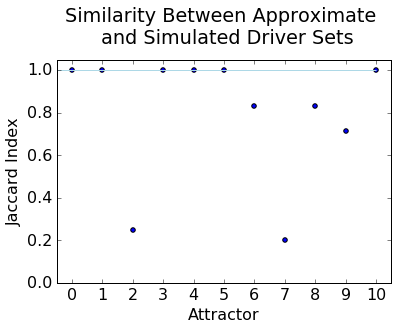

In [965]:
#graph differences in driver sets chosen via the Jaccard measure
plt.hlines(1.0,-1,10,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(11)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,10.5])
plt.xticks([i for i in range(11)])
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Approximate \n and Simulated Driver Sets",y=1.05)

In [267]:
#compare to FVS drivers and attractors from cana
yfvs=fvs_set(NY,method='bruteforce') #method='bruteforce'
print len(yfvs)
for x in sorted(yfvs): 
    print x,ysunit_map[ytranslator[x][0]]
#analyze attractors
yattractors=attractors_to_dict(NY)
print len(yattractors)

16
(0,) CellSize-0
(1,) CellSize-1
(10,) Sic1-0
(11,) Sic1-1
(12,) Clb5,6-0
(13,) Clb5,6-1
(14,) Cdh1-0
(15,) Cdh1-1
(16,) Clb1,2-0
(17,) Clb1,2-1
(22,) Swi5-0
(23,) Swi5-1
(4,) SBF-0
(5,) SBF-1
(6,) MBF-0
(7,) MBF-1
11


In [518]:
#check yeast attractors
#for node in NY.nodes: print node
print yattractors.keys() #attractor 0 is G1
#print ysunit_map
#print yattractors[yattractors.keys()[0]]
fixed_points=find_attractors_bruteforce(NY,DCMY,ysunits,ysunit_map,{},{},time_limit=16)

['000001010000', '111110001111', '111110101111', '000000000000', '111010001111', '001010000000', '000101010000', '110100101111', '000101000000', '000000010000', '000001000000']


In [523]:
print {len(x) for x in fixed_points},len(fixed_points)
for x in fixed_points:
    found=False
    for a in yattractors:
        if x==yattractors[a]:
            print "Found previous attractor"
            found=True
            break
    if not found: 
        print "New attractor found:",x
        break

set([12]) 11
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor
Found previous attractor


In [517]:
#check each solution that it's a valid driver set using brute-force computation
solutions=[{1,11,16},{1,11}] #unspecified attractor finds a newly created fixed point
solutions=[{0,11,4,6,15},{1,5,7,10,12,17},{1,13,5,7},{0,4,6,10,12,14,16},{1,10,5,6,17},{0,16,12,5,6},{0,4,7,11,12,15},{1,10,4,13,7},{0,4,7,11,12,14},{0,4,6,10,12,15},{0,11,4,14,6}]
for solution in solutions:
    fixed_points=find_attractors_bruteforce(NY,DCMY,ysunits,ysunit_map,solution,{},time_limit=16)
    print solution,len(fixed_points)
    for x in fixed_points:
        if len(x)==len(NY.nodes):
            for i,a in enumerate(yattractors):
                if x==yattractors[a]:
                    print "Attractor found:",i,a,fixed_points[x],[fixed_points[x] for x in fixed_points]
                    break
            #print "Fixed point:",x

set([0, 11, 4, 6, 15]) 1
Attractor found: 0 000001010000 128 [128]
set([1, 5, 7, 10, 12, 17]) 1
Attractor found: 1 111110001111 64 [64]
set([1, 7, 13, 5]) 2
Attractor found: 2 111110101111 238 [238, 18]
set([0, 4, 6, 10, 12, 14, 16]) 1
Attractor found: 3 000000000000 32 [32]
set([1, 10, 5, 6, 17]) 1
Attractor found: 4 111010001111 128 [128]
set([0, 16, 12, 5, 6]) 1
Attractor found: 5 001010000000 128 [128]
set([0, 4, 7, 11, 12, 15]) 1
Attractor found: 6 000101010000 64 [64]
set([1, 10, 4, 13, 7]) 2
Attractor found: 7 110100101111 124 [4, 124]
set([0, 4, 7, 11, 12, 14]) 1
Attractor found: 8 000101000000 64 [64]
set([0, 4, 6, 10, 12, 15]) 1
Attractor found: 9 000000010000 64 [64]
set([0, 11, 4, 6, 14]) 1
Attractor found: 10 000001000000 128 [128]


In [64]:
#configs=find_attractors_bruteforce(NY,DCMY,ysunits,ysunit_map,solution,{},time_limit=16)
#print configs[0]
#for node in NY.nodes: 
#    if node.name=='Cdh1': break
#print node.inputs,node.look_up_table(),node.schemata_look_up_table(type='pi'),node.schemata_look_up_table(type='ts')
#for t in diffusion: print reduce_step(diffusion[t]),len(reduce_step(diffusion[t]))

In [534]:
#search for smaller solutions using FVS nodes (NOTE: solutions must be at least 1 because there is 1 input node)
nodes=[str((x,)) for x in ysunits] #yfvs, [str((x,)) for x in ysunits]
#nodes=yfvs
seeds=combinations(nodes,6)
for seed in seeds:
    seed=[ytranslator[s][0] for s in sorted(list(seed))] #extract number from tuple
    #quick check for contradiction
    vals=[ysunit_map[x][:-2] for x in seed]
    if len(set(vals))<len(vals): #we have multiple nodes sharing the same variable
        continue
    if not 'CellSize' in vals: continue #solution must contain the input node
    #print seed,vals
    fixed_points=find_attractors_bruteforce(NY,DCMY,ysunits,ysunit_map,seed,{},time_limit=16)
    #print {len(x) for x in fixed_points},len(fixed_points)
    if len(fixed_points)==1: 
        #print seed,vals,{len(x) for x in fixed_points},len(fixed_points)
        for i,a in enumerate(yattractors):
            if list(fixed_points)[0]==yattractors[a]:
                print seed,vals,{len(x) for x in fixed_points},len(fixed_points)
                print "Attractor found:",i,a,[fixed_points[x] for x in fixed_points]

[0, 10, 15, 2, 4, 6] ['CellSize', 'Sic1', 'Cdh1', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 9 000000010000 [64]
[0, 11, 14, 2, 4, 6] ['CellSize', 'Sic1', 'Cdh1', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 10 000001000000 [64]
[0, 11, 15, 2, 4, 6] ['CellSize', 'Sic1', 'Cdh1', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 0 000001010000 [64]
[0, 11, 14, 2, 4, 7] ['CellSize', 'Sic1', 'Cdh1', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 8 000101000000 [64]
[0, 11, 15, 2, 4, 7] ['CellSize', 'Sic1', 'Cdh1', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 6 000101010000 [64]
[0, 14, 16, 2, 4, 7] ['CellSize', 'Cdh1', 'Clb1,2', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 8 000101000000 [64]
[0, 15, 16, 2, 4, 7] ['CellSize', 'Cdh1', 'Clb1,2', 'Cln3', 'SBF', 'MBF'] set([12]) 1
Attractor found: 6 000101010000 [64]
[0, 10, 14, 18, 2, 4] ['CellSize', 'Sic1', 'Cdh1', 'Mcm1/SFF', 'Cln3', 'SBF'] set([12]) 1
Attractor found: 3 000000000000 [64]
[0, 16, 2, 5, 6, 9] [

[0, 10, 18, 22, 5, 6] ['CellSize', 'Sic1', 'Mcm1/SFF', 'Swi5', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 12, 14, 16, 5, 6] ['CellSize', 'Clb5,6', 'Cdh1', 'Clb1,2', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 12, 14, 18, 5, 6] ['CellSize', 'Clb5,6', 'Cdh1', 'Mcm1/SFF', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 12, 16, 18, 5, 6] ['CellSize', 'Clb5,6', 'Clb1,2', 'Mcm1/SFF', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 12, 16, 20, 5, 6] ['CellSize', 'Clb5,6', 'Clb1,2', 'Cdc20/14', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 12, 16, 22, 5, 6] ['CellSize', 'Clb5,6', 'Clb1,2', 'Swi5', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 12, 18, 22, 5, 6] ['CellSize', 'Clb5,6', 'Mcm1/SFF', 'Swi5', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 001010000000 [64]
[0, 14, 16, 22, 5, 6] ['CellSize', 'Cdh1', 'Clb1,2', 'Swi5', 'SBF', 'MBF'] set([12]) 1
Attractor found: 5 

In [508]:
seed=[0, 18, 5]
print find_attractors_bruteforce(NY,DCMY,ysunits,ysunit_map,seed,{},time_limit=16)
config=[0,2,5,6,9,10,12,14,16,18,20,22] #attractor 5
config=translate_config_to_vars(config,NY,ysunit_map)
network_dynamics(config,{},time_limit=16)

{frozenset(['Mcm1/SFF-0', 'Cln3-0', 'Sic1-0', 'Cdc20/14-0', 'SBF-1', 'Cln1,2-1', 'Swi5-0', 'CellSize-0', 'Clb5,6-0', 'Clb1,2-0', 'Cdh1-0', 'MBF-0']): 512}


{0: {'Cdc20/14-0',
  'Cdh1-0',
  'CellSize-0',
  'Clb1,2-0',
  'Clb5,6-0',
  'Cln1,2-1',
  'Cln3-0',
  'MBF-0',
  'Mcm1/SFF-0',
  'SBF-1',
  'Sic1-0',
  'Swi5-0'}}

Text(0.5,1.05,'Similarity Between Approximate \n and Actual Driver Sets')

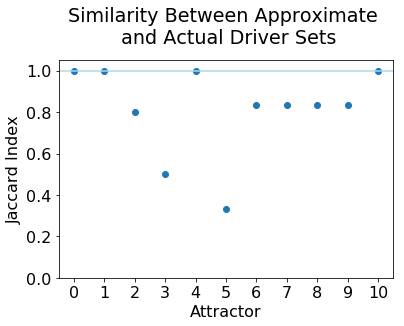

In [535]:
#compare brute-force solutions with the mean-field approximation (G1 solution is the same)
mf_solutions=[{0,11,4,6,15},{1,5,7,10,12,17},{1,13,5,7},{0,4,6,10,12,14,16},{1,10,5,6,17},{0,16,12,5,6},{0,4,7,11,12,15},{1,10,4,13,7},{0,4,7,11,12,14},{0,4,6,10,12,15},{0,11,4,14,6}]
bf_solutions=[{0,11,15,4,6},{1,10,12,17,5,7},{1,13,17,5,7},{0,10,14,16,4,6},{1,10,17,5,6},{0,16,5,6},{0,11,15,4,7},{1,10,13,17,4,7},{0,11,14,4,7},{0,10,15,4,6},{0,11,14,4,6}] #fvs
bf_solutions=[{0,11,15,4,6},{1,10,12,17,5,7},{1,13,17,5,7},{0,10,14,18,4},{1,10,17,5,6},{0,18,5},{0,11,15,4,7},{1,10,13,17,4,7},{0,11,14,4,7},{0,10,15,4,6},{0,11,14,4,6}] #non-fvs
#graph differences in driver sets chosen via the Jaccard measure
jmeasures=[]
for set1,set2 in zip(mf_solutions,bf_solutions):
    jmeasures.append(compute_jaccard(set1,set2))
plt.hlines(1.0,-1,11,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(11)],jmeasures)
plt.ylim([0,1.05])
plt.xlim([-0.5,10.5])
plt.xticks([i for i in range(11)])
plt.ylabel("Jaccard Index")
plt.xlabel("Attractor")
plt.title("Similarity Between Approximate \n and Actual Driver Sets",y=1.05)

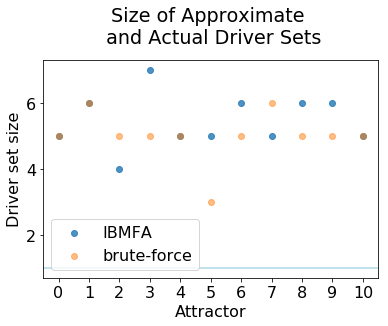

In [536]:
#graph size of driver set of IBMFA compared to brute-force solution
plt.hlines(1.0,-1,11,colors=["lightblue"],linestyles='solid')
plt.scatter([i for i in range(11)],[len(x) for x in mf_solutions],label='IBMFA',alpha=0.8)
plt.scatter([i for i in range(11)],[len(x) for x in bf_solutions],label='brute-force',alpha=0.5)
#plt.ylim([0,1.05])
plt.xlim([-0.5,10.5])
plt.xticks([i for i in range(11)])
plt.ylabel("Driver set size")
plt.xlabel("Attractor")
plt.title("Size of Approximate \n and Actual Driver Sets",y=1.05)
plt.legend()

#### Breast Cancer

In [820]:
#recreate pipeline with breast cancer
NB = BREAST_CANCER()
db={node.name: LUT_reduce(look_up_table(node)) for node in NB.nodes}
bnodes=db.keys()
print len(db),bnodes
bmodules,btranslator={},{}
bsunits,bsunit_map=get_sunits(NB)
print len(bsunits),len(bsunit_map)

80 ['RAS_2', 'RAS_3', 'Proliferation_2', 'MYC', 'Proliferation_4', 'PDK1_pm', 'BIM_T', 'cyclinD', 'MYC_2', 'mTORC2', 'mTORC1', 'AKT', 'TSC', 'BAD', 'E2F_2', 'FOXO3_Ub', 'ESR1_2', 'BCL2', 'BCL2_T', 'Alpelisib', 'PBX1', 'FOXA1', 'BIM', 'PRAS40', 'PIM', 'Neratinib', 'p21_p27_T', 'Trametinib', 'KMT2D', 'pRb_3', 'ER_transcription_2', 'E2F', 'HER3_2', 'PI3K_2', 'pRb', 'HER3', 'HER2', 'mTORC2_pm', 'ER', 'MAPK_2', 'RAS', 'HER2_3_2', 'cycD_CDK46_2', 'IGF1R', 'Apoptosis_2', 'Everolimus', 'PIP3', 'PI3K', 'HER2_3', 'IGF1R_T', 'HER3_T', 'Proliferation', 'Apoptosis_3', 'MCL1', 'cyclinD_2', 'EIF4F', 'cycE_CDK2', 'Translation', 'Palbociclib', 'FOXO3', 'CDK46', 'cycD_CDK46', 'Ipatasertib', 'SGK1', 'ESR1', 'p21_p27', 'MAPK', 'IGF1R_2', 'E2F_3', 'PDK1', 'PTEN', 'S6K', 'Proliferation_3', 'Apoptosis', 'SGK1_T', 'PIP3_2', 'ER_transcription', 'Fulvestrant', 'pRb_2', 'cycE_CDK2_T']
160 160


In [822]:
drugs=[(7,),(9,),(11,),(13,),(15,),(17,),(19,),(6,),(8,),(10,),(12,),(14,),(16,),(18,)]
drug_sunits={6,7,8,9,10,11,12,13,14,15,16,17,18,19}

In [825]:
start_time = time.time()
bmodules,btranslator=find_modules(NB,0,drug_sunits,bsunit_map,bmodules,btranslator,reduced=True,ds=db,pinning={},iterations=15,data=True)
print("--- %s seconds ---" % (time.time() - start_time))
len(bmodules)
#for node in NB.nodes: print node.name,node.inputs, node.outputs

seeds: 1
--- 0.944000005722 seconds ---


1

In [829]:
length=0
seeds=reduce_seeds(bmodules,bsunit_map,btranslator,length=length)
submodules={seed:bmodules[seed] for seed in seeds}
len(submodules)
seeds=submodules.keys() #dmodules.keys(), ['(67,)','(66,)'], ['(2, 66)','(3, 67)','(2, 67)'] (odd numbers are positive)
#seeds=subsample #['(0, 33)'], ['(7,)'], ['(13,)']
bstats={}
t=15
start_time = time.time()
simulations=compare_simulations(NB,seeds,bsunit_map,bmodules,btranslator,length=length,runs=100,tau=0.0,iterations=t,
                        unknown_prob=0.5,stats=bstats,results=True) #time_limit=12
print("--- Total time: %s seconds ---" % (time.time()-start_time))

total seeds: 1
true positives: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false negatives: [0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
true negatives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
false positives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
accuracy: [1.0, 0.99, 1.0, 0.97, 0.97, 0.96, 0.97, 0.99, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96]
recall: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
precision: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
average similarity: [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
errors: [0.002, 0.001, 0.003, 0.006, 0.006, 0.007, 0.007, 0.007, 0.007, 0.008, 0.009, 0.01, 0.01, 0.01, 0.01, 0.011]
--- Total time: 1.3069999218 seconds ---


In [830]:
#compare to baselines
bbstats={}
compare_baseline(NB,seeds,bsunit_map,btranslator,simulations,length=length,tau=0.0,iterations=15,stats=bbstats,results=True)

100 total runs, 1.0 seeds
true positives: [1.0, 0.99, 0.97, 0.99, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0]
false negatives: [0.0, 0.01, 0.03, 0.01, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
true negatives: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
false positives: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
accuracy: [0.0, 0.01, 0.0, 0.02, 0.02, 0.04, 0.02, 0.01, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]
recall: [1.0, 0.99, 0.97, 0.99, 1.0, 1.0, 1.0, 0.99, 1.0, 1.0, 0.99, 1.0, 1.0, 1.0, 1.0, 1.0]
precision: [0.0, 0.01, 0.0, 0.03, 0.03, 0.04, 0.03, 0.01, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]
average similarity: [0.0, 0.01, 0.0, 0.02, 0.02, 0.04, 0.02, 0.01, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04]
errors: [0.253, 0.185, 0.185, 0.184, 0.183, 0.18, 0.178, 0.173, 0.17, 0.17, 0.169, 0.169, 0.17, 0.17, 0.169, 0.168]


In [63]:
#bact_prob_sim={}
for seed in simulations: bact_prob_sim[seed]={}
for seed in simulations:
    aggregate_simulation(seed,simulations,bact_prob_sim)

len(bact_prob_sim)

15

[]
Normalized entropy: [0.99, 0.79, 0.77, 0.78, 0.76, 0.76, 0.75, 0.73, 0.72, 0.72, 0.72] [1.0, 0.8, 0.77, 0.78, 0.77, 0.76, 0.75, 0.74, 0.73, 0.72, 0.72]
Probable configurations: ['8.64e+17', '1.94e+14', '7.66e+13', '1.13e+14', '6.33e+13', '4.47e+13', '3.01e+13', '1.54e+13', '1.12e+13', '8.86e+12', '9.42e+12']


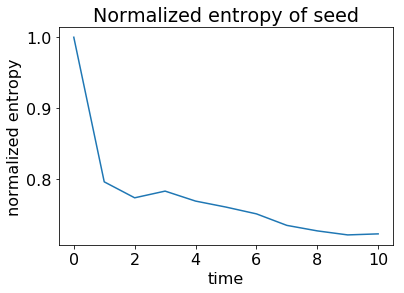

Total possible configurations: [1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 0.0625, 0.0625, 0.0625, 0.03125, 0.03125] [1.0, 1.0, 1.0, 1.0, 1.0, 0.125, 0.0625, 0.0625, 0.0625, 0.03125, 0.03125]


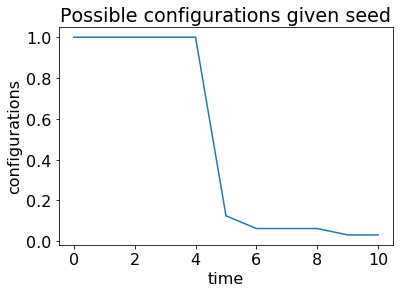

In [76]:
#single seed entropy
seed='()' #'(7,)'
print to_list(seed,bsunit_map,btranslator)
diffusion=bact_prob_sim[seed] #bmodules[seed], bact_prob_sim[seed], low_sim[seed]
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
xvalues=seed_entropy.keys()
yvalues=[seed_entropy[key] for key in seed_entropy]
#print [round(y*60,2) for y in yvalues]
plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues]) #normalize everything compared to the starting value
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
#plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed")
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True,strict=True)
xvalues=seed_configs.keys()
y1values=[seed_configs[key] for key in seed_configs]
#print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
print 'Total possible configurations:',[round(yvalue,5) for yvalue in y1values],[round(yvalue/y1values[0],5) for yvalue in y1values]
#print [round(seed_entropy[key],2) for key in seed_entropy]#,yvalues
plt.plot(xvalues,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

seeds: 160
Average entropy: [58.82, 46.26, 44.82, 45.03, 44.33, 43.51, 42.95, 42.21, 41.92, 41.65, 41.58]
Normalized entropy: [0.98, 0.77, 0.75, 0.75, 0.74, 0.73, 0.72, 0.7, 0.7, 0.69, 0.69] [1.0, 0.79, 0.76, 0.77, 0.75, 0.74, 0.73, 0.72, 0.71, 0.71, 0.71]
Possible configurations: ['5.08e+17', '8.43e+13', '3.10e+13', '3.58e+13', '2.21e+13', '1.26e+13', '8.50e+12', '5.10e+12', '4.17e+12', '3.45e+12', '3.29e+12']


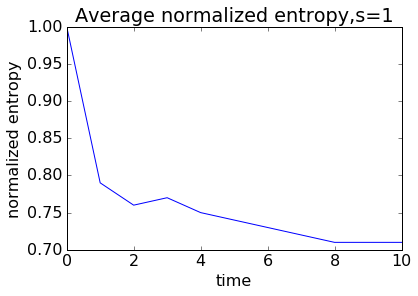

Total possible configurations: [0.5, 0.26, 0.17, 0.08, 0.1, 0.06, 0.07, 0.06, 0.06, 0.07, 0.07] [1.0, 0.52, 0.33, 0.16, 0.19, 0.12, 0.13, 0.12, 0.12, 0.13, 0.14]


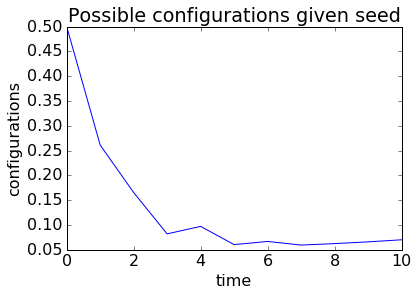

In [224]:
#multiple seed entropies
length,iterations=1,10
seeds=reduce_seeds(bmodules,bsunit_map,btranslator,length=length) #['()','(3,)']
#seeds=simulations.keys() #simulation entropies
print 'seeds:',len(seeds)
seed_entropy,seed_configs=seed_entropies(bact_prob_sim,seeds,normalized=True,data=False) #dpmodules, submodules, dpact_prob_sim
xvalues=[t for t in range(iterations+1)]
yvalues=[np.mean([seed_entropy[seed][t] for seed in seed_entropy]) for t in xvalues]
print 'Average entropy:',[round(y * 60,2) for y in yvalues]
print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
y1values=[2**(y * 60) for y in yvalues]
print 'Possible configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
plt.plot(xvalues,[round(yvalue/yvalues[0],2) for yvalue in yvalues])
#plt.ylim([.5,1.01])
plt.title("Average normalized entropy,s="+str(length))
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.show()
#plot configs
seed_entropy,seed_configs=seed_entropies(bact_prob_sim,seeds,normalized=True,data=False,strict=True) #submodules,dact_prob_sim
x1values=xvalues
y1values=[np.mean([seed_configs[seed][t] for seed in seed_configs]) for t in x1values]
print 'Total possible configurations:',[round(yvalue,2) for yvalue in y1values],[round(yvalue/y1values[0],2) for yvalue in y1values]
plt.plot(x1values,y1values)
#plt.yscale('log')
#plt.ylim([0,1e8])
plt.title("Possible configurations given seed")
plt.ylabel("configurations")
plt.xlabel("time")
plt.show()

In [ ]:
#compare to FVS drivers
#NOTE: the default grasp method throws an error and bruteforce takes too long to run
bfvs=fvs_set(NB,method='bruteforce') #method='bruteforce'
print len(bfvs)
for x in sorted(bfvs): 
    #print x,bsunit_map[btranslator[x][0]]
    seed_entropy,seed_configs=config_entropy(bmodules[x],base=2,normalized=True)
    print x,bsunit_map[btranslator[x][0]],seed_entropy[10]

In [241]:
#determine top selection based on any node 
selections,entropies=top_selection(NB,bsunits,bsunit_map,bmodules,btranslator,seeds=None,max_s=20,top=1,reduced=True,ds=db,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False)
ab=[entropies[x] for x in selections] #entropy
sb=[x for x in selections] #selection
for seed in selections: 
    print seed, entropies[seed], to_list(seed,bsunit_map,btranslator)
print to_list(reduce_selection(seed,NB,bsunits,bsunit_map,bmodules,btranslator,reduced=True,ds=db,t=10),bsunit_map)

2847 2847
() 0.595408583619 []
(36,) 0.479109908241 ['PIM-0']
(36, 52) 0.373683683399 ['PIM-0', 'PI3K-0']
(7, 36, 52) 0.275454113184 ['Fulvestrant-1', 'PIM-0', 'PI3K-0']
(7, 19, 36, 52) 0.234211412491 ['Fulvestrant-1', 'Neratinib-1', 'PIM-0', 'PI3K-0']
(1, 7, 19, 36, 52) 0.202924812094 ['IGF1R_T-1', 'Fulvestrant-1', 'Neratinib-1', 'PIM-0', 'PI3K-0']
(1, 7, 19, 36, 52, 90) 0.176246045616 ['IGF1R_T-1', 'Fulvestrant-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0']
(1, 7, 17, 19, 36, 52, 90) 0.151246045451 ['IGF1R_T-1', 'Fulvestrant-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0']
(1, 7, 11, 17, 19, 36, 52, 90) 0.1375 ['IGF1R_T-1', 'Fulvestrant-1', 'Everolimus-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0']
(1, 7, 11, 15, 17, 19, 36, 52, 90) 0.125 ['IGF1R_T-1', 'Fulvestrant-1', 'Everolimus-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0']
(1, 7, 11, 15, 17, 19, 36, 52, 89, 90) 0.1125 ['IGF1R_T-1', 'Fulvestrant-1', 'Eve

In [ ]:
#TODO: determine top selection based on FVS nodes
selections,entropies=top_selection(NB,bsunits,bsunit_map,bmodules,btranslator,seeds=None,max_s=10,top=1,reduced=True,ds=db,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False)
for seed in selections: 
    print seed, entropies[seed], to_list(seed,bsunit_map,btranslator)
print to_list(reduce_selection(seed,NB,bsunits,bsunit_map,bmodules,btranslator,reduced=True,ds=db,t=10),bsunit_map)

In [77]:
#check solutions
seed=['IGF1R_T-1', 'Fulvestrant-1', 'Alpelisib-0', 'Everolimus-1', 'Trametinib-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1',
      'HER2-1', 'HER3_T-0', 'PDK1-0', 'SGK1_T-1', 'PIM-0', 'PI3K-0', 'PTEN-0', 'BIM_T-1', 'BCL2_T-0', 'ER-1', 'PBX1-0'] #19 nodes
seed=['IGF1R_T-1', 'Fulvestrant-1', 'Alpelisib-0', 'Everolimus-1', 'Trametinib-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1',
      'HER2-1', 'HER3_T-0', 'PDK1-0', 'SGK1_T-1', 'PIM-0', 'PTEN-0', 'BIM_T-1', 'BCL2_T-0', 'ER-1', 'PBX1-0'] #18 nodes, ERROR
DCMB=NB.dynamics_canalization_map(output=None, )
diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=10,pinned={})
print count_sunits(diffusion)
#seed=(3, 21, 22)
#find_modules(NB,1,bsunits,bsunit_map,{},btranslator,seeds=[seed],data=True,verbose=True,iterations=15)[0][str(seed)][12]

78


In [244]:
#compare solution to simulations
#entropy of strategy; requires at and st variables above
entropies_sim={}
entropies_sim=strategy_entropy(sb,NB,bsunit_map,bmodules,btranslator,runs=100,tau=0.0,iterations=10,unknown_prob=0.5,
                               stats=bstats,results=False,time_limit=12,act_prob_sim=bact_prob_sim,entropies_sim=entropies_sim,t=10)
for j,seed in enumerate(sb): print to_list(seed,bsunit_map,btranslator), eval('ab['+str(j)+']'), entropies_sim[seed]

[] 0.595408583619 0.725585583144
['PIM-0'] 0.479109908241 0.596513389358
['PIM-0', 'PI3K-0'] 0.373683683399 0.520152206985
['Fulvestrant-1', 'PIM-0', 'PI3K-0'] 0.275454113184 0.349252917763
['Fulvestrant-1', 'Neratinib-1', 'PIM-0', 'PI3K-0'] 0.234211412491 0.320057756258
['IGF1R_T-1', 'Fulvestrant-1', 'Neratinib-1', 'PIM-0', 'PI3K-0'] 0.202924812094 0.258312860319
['IGF1R_T-1', 'Fulvestrant-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0'] 0.176246045616 0.210233162552
['IGF1R_T-1', 'Fulvestrant-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0'] 0.151246045451 0.196382571355
['IGF1R_T-1', 'Fulvestrant-1', 'Everolimus-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0'] 0.1375 0.136439458417
['IGF1R_T-1', 'Fulvestrant-1', 'Everolimus-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BCL2_T-0'] 0.125 0.124060166335
['IGF1R_T-1', 'Fulvestrant-1', 'Everolimus-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1', 'PIM-0', 'PI3K-0', 'BIM_T-

In [262]:
bentropies_sim=entropies_sim
len(bentropies_sim)

996

In [254]:
#entropy of random seed selections averaged over multiple samples
runs=100 #runs per sample to get simulation ground truth
samples=100 #number of samples to try per seed size s
#selections_rnd,entropies=random_selection(NL,lsunits,lsunit_map,lmodules,ltranslator,seeds=None,max_s=10,entropies=entropies,
#                            reduced=True,ds=dl,pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True)
bselections_ls,bavg=avg_random_selections(NB,bsunits,bsunit_map,bmodules,btranslator,samples=samples,seeds=None,max_s=10,entropies=entropies,
                      reduced=True,ds=db,t=10,runs=runs,stats=bstats,act_prob_sim=bact_prob_sim,entropies_sim=entropies_sim)
#print selections_rnd,len(entropies),len(lentropies_sim)
print bavg,len(bselections_ls)
byrnd=[bavg[x] for x in bavg] #average of multiple random samples

{0: 0.72558558314403987, 1: 0.69309923325814093, 2: 0.66940625805870413, 3: 0.65009395153687821, 4: 0.62926395125087309, 5: 0.60962809847470745, 6: 0.5918697017286294, 7: 0.56380106363171367, 8: 0.54496915980726635, 9: 0.52561278713070925, 10: 0.51419357013709777} 100


(-0.01, 0.9)

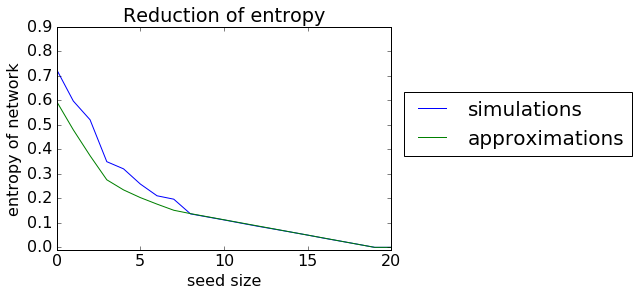

In [261]:
#graph the difference between the approximation and the simulations
#print norm.interval(alpha=0.95, loc=np.mean(ab), scale=sem(ab))
xvalues=range(21)
plt.plot(xvalues,[entropies_sim[seed] for seed in sb[:]],label='simulations')
plt.plot(xvalues,ab[:],label='approximations')
#plt.plot(xvalues,byrnd,label='random')
plt.legend(bbox_to_anchor=(1.75, 0.75), fontsize=20)
plt.title("Reduction of entropy",y=1.0)
#plt.title("Reduction of entropy based on \n attractor, best strategy")
plt.ylabel("entropy of network")
plt.xlabel("seed size")
plt.yticks(np.arange(0,1,.1))
plt.ylim([-.01,0.9])

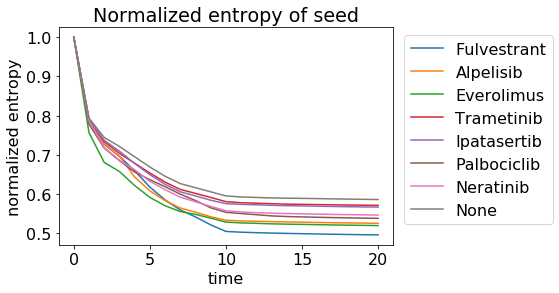

In [301]:
#check each of the 7 drugs in breast cancer
drugs=['(7,)','(9,)','(11,)','(13,)','(15,)','(17,)','(19,)','()'] #Fulvestrant,Alpelisib,Everolimus,Trametinib,Ipatasertib,Palbociclib,Neratinib
#drugs=['(6,)','(8,)','(10,)','(12,)','(14,)','(16,)','(18,)'] #OFF states
names=['Fulvestrant','Alpelisib','Everolimus','Trametinib','Ipatasertib','Palbociclib','Neratinib','None']
#single seed entropy
for i,drug in enumerate(drugs):
    #print to_list(drug,bsunit_map,btranslator)
    diffusion=bmodules[drug] #bmodules[seed], bact_prob_sim[seed], low_sim[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    xvalues=seed_entropy.keys()
    yvalues=[seed_entropy[key] for key in seed_entropy]
    #print [round(y*60,2) for y in yvalues]
    plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues],label=names[i]) #normalize everything compared to the starting value
    #print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
    y1values=[2**(y * 60) for y in yvalues]
    #print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
    #plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed") #"Normalized entropy of seed, OFF state"
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.legend(bbox_to_anchor=(1.5, 1.0))

In [1180]:
#check each of the 7 drugs in breast cancer: Fulvestrant,Alpelisib,Everolimus,Trametinib,Ipatasertib,Palbociclib,Neratinib
length=3
print drug_sunits,len(bmodules)
drug_modules=set([])
for module in bmodules:
    include=True
    for unit in btranslator[module]:
        if unit not in drug_sunits: include=False
    if include: drug_modules.add(module)
print len(drug_modules)
seeds=reduce_seeds(drug_modules,bsunit_map,btranslator,length=length)
print len(seeds)

set([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]) 16259
3484
280


In [54]:
#baseline used in effective graph paper
baseline={105,20,22,1,113,56,32,36,28,30,88,90}
abaseline=baseline.union({9})
print [bsunit_map[b] for b in abaseline]
drug_modules={tuple(sorted(abaseline))} #baseline or abaseline
for d in [ds for ds in drug_sunits if ds%2==1]: #ON nodes only
    drug_modules.add(tuple(sorted(abaseline.union({d})))) #baseline or abaseline
    #print tuple(sorted(abaseline.union({d})))
seeds=drug_modules
print len(seeds)

['SGK1_T-0', 'IGF1R_T-1', 'PIM-0', 'ER-1', 'PBX1-1', 'HER2-0', 'HER3_T-0', 'Alpelisib-1', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'PDK1-0', 'mTORC2-0']
7


In [96]:
#baseline used in effective graph paper but with assumed OFF states for the drugs
baseline={105,20,22,1,113,56,32,36,28,30,88,90}
for d in [ds for ds in drug_sunits if ds%2==0]: #OFF nodes only
    baseline.add(d)
abaseline=baseline.union({9})
abaseline.remove(8)
print [bsunit_map[b] for b in baseline]
drug_modules={tuple(sorted(abaseline))} #baseline or abaseline
for d in [ds for ds in drug_sunits if ds%2==1]: #ON nodes only
    module=abaseline.union({d}) #baseline or abaseline
    if d-1 in module: module.remove(d-1)
    print tuple(sorted(module))
    drug_modules.add(tuple(sorted(module)))
seeds=drug_modules
print len(seeds)

['SGK1_T-0', 'IGF1R_T-1', 'PIM-0', 'Fulvestrant-0', 'Alpelisib-0', 'ER-1', 'Everolimus-0', 'Trametinib-0', 'Ipatasertib-0', 'Palbociclib-0', 'PBX1-1', 'Neratinib-0', 'HER2-0', 'HER3_T-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'PDK1-0', 'mTORC2-0']
(1, 7, 9, 10, 12, 14, 16, 18, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
(1, 6, 9, 10, 12, 14, 16, 18, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
(1, 6, 9, 11, 12, 14, 16, 18, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
(1, 6, 9, 10, 13, 14, 16, 18, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
(1, 6, 9, 10, 12, 15, 16, 18, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
(1, 6, 9, 10, 12, 14, 17, 18, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
(1, 6, 9, 10, 12, 14, 16, 19, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
7


In [98]:
#drug simulations
start_time = time.time()
length=19 #modules will be length 12 or 13 with the baseline (or 14 with Alpelisib, 19 with OFF defaults)
#simulations=compare_simulations(NB,seeds,bsunit_map,bmodules,btranslator,length=length,runs=100,tau=0.0,iterations=10,
#                        unknown_prob=0.5,stats=bstats,results=True,time_limit=12)
simulations=create_simulations(NB,seeds,bsunit_map,btranslator,length=length,runs=100,iterations=10,unknown_prob=0.5,time_limit=12)
print("--- Total time: %s seconds ---" % (time.time()-start_time))

--- Total time: 16.375 seconds ---


In [99]:
simulations=simulations[0]
for seed in simulations: bact_prob_sim[seed]={}
for seed in simulations:
    aggregate_simulation(seed,simulations,bact_prob_sim)

len(bact_prob_sim)

43

In [55]:
seeds=sorted(seeds,reverse=False) #sort reverse if using OFF defaults
seeds

[(1, 7, 9, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113),
 (1, 9, 11, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113),
 (1, 9, 13, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113),
 (1, 9, 15, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113),
 (1, 9, 17, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113),
 (1, 9, 19, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113),
 (1, 9, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)]

In [56]:
#find approximation values for drug modules
start_time = time.time()
bmodules,btranslator=find_modules(NB,1,bsunits,bsunit_map,bmodules,btranslator,reduced=True,ds=db,
                                  pinning={},iterations=20,data=True,seeds=seeds)
print("--- %s seconds ---" % (time.time() - start_time))
len(bmodules)

seeds: 7
--- 6.8140001297 seconds ---


22

['IGF1R_T-1', 'Fulvestrant-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 47
['IGF1R_T-1', 'Alpelisib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 52
['IGF1R_T-1', 'Everolimus-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 45
['IGF1R_T-1', 'Trametinib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 25
['IGF1R_T-1', 'Ipatasertib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 44
['IGF1R_T-1', 'Palbociclib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 33
['IGF1R_T-1', 'Neratinib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 

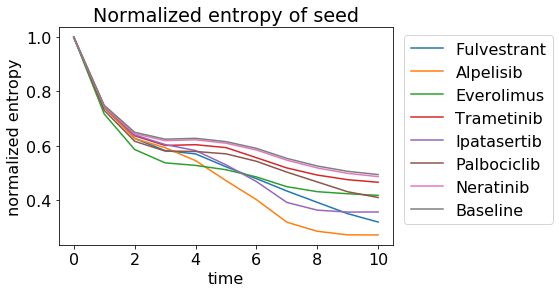

In [257]:
#check each of the 7 drugs in breast cancer against the baseline
names=['Fulvestrant','Alpelisib','Everolimus','Trametinib','Ipatasertib','Palbociclib','Neratinib','Baseline']
#single seed entropy
for i,drug in enumerate(seeds):
    seed=to_list(drug,bsunit_map,btranslator)
    DCMB=NB.dynamics_canalization_map(output=None, )
    diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=20,pinned={})
    l=str(count_variables(diffusion))
    print seed,l
    diffusion=bmodules[str(drug)] #bmodules[seed], bact_prob_sim[seed], low_sim[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    xvalues=seed_entropy.keys()
    yvalues=[seed_entropy[key] for key in seed_entropy]
    #print [round(y*60,2) for y in yvalues]
    plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues],label=names[i])#+', '+l) #normalize everything compared to the starting value
    #print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
    y1values=[2**(y * 60) for y in yvalues]
    #print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
    #plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed") #"Normalized entropy of seed, OFF state"
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.legend(bbox_to_anchor=(1.5, 1.0))

['IGF1R_T-1', 'Fulvestrant-1', 'Alpelisib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 74
['IGF1R_T-1', 'Alpelisib-1', 'Everolimus-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 53
['IGF1R_T-1', 'Alpelisib-1', 'Trametinib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 53
['IGF1R_T-1', 'Alpelisib-1', 'Ipatasertib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 53
['IGF1R_T-1', 'Alpelisib-1', 'Palbociclib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 65
['IGF1R_T-1', 'Alpelisib-1', 'Neratinib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1'] 53
['IGF1R_T-1', 

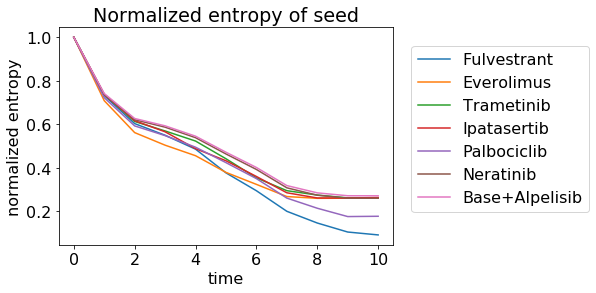

In [62]:
#check each of the 7 drugs in breast cancer against the baseline WITH Alpelisib
names=['Fulvestrant','Everolimus','Trametinib','Ipatasertib','Palbociclib','Neratinib','Base+Alpelisib']
#single seed entropy
seed_entropies={}
for i,drug in enumerate(seeds):
    seed=to_list(drug,bsunit_map,btranslator)
    DCMB=NB.dynamics_canalization_map(output=None, )
    diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=20,pinned={})
    l=str(count_variables(diffusion))
    print seed,l
    diffusion=bmodules[str(drug)] #bmodules[seed], bact_prob_sim[seed], low_sim[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    seed_entropies[str(drug)]=seed_entropy
    xvalues=seed_entropy.keys()[:11]
    yvalues=[seed_entropy[key] for key in seed_entropy][:11]
    #print [round(y*60,2) for y in yvalues]
    plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues],label=names[i])#+', '+l) #normalize everything compared to the starting value
    #print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
    y1values=[2**(y * 60) for y in yvalues]
    #print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
    #plt.ylim([.5,1.01])
plt.title("Normalized entropy of seed") #"Normalized entropy of seed, OFF state"
plt.ylabel("normalized entropy")
plt.xlabel("time")
plt.legend(bbox_to_anchor=(1.03, 0.95))

In [65]:
#json dump for paper figure
#with open('breast_cancer_drug_entropies_abaseline.json', 'w') as fp:
#    json.dump(seed_entropies, fp)
#with open('breast_cancer_sunit_map.json', 'w') as fp:
#    json.dump(bsunit_map, fp)
#with open('breast_cancer_drug_translator_abaseline.json', 'w') as fp:
#    json.dump(btranslator, fp)

In [103]:
#investigate the effects of the baselines via DCM modules
#diffusions={}
for i,drug in enumerate(seeds):
    seed=to_list(drug,bsunit_map,btranslator)
    DCMB=NB.dynamics_canalization_map(output=None, )
    diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=20,pinned={})
    #print max(diffusion) #max across drug experiments is 14, so use at least time_limit=16
    diffusions[str(seed)]=diffusion
len(diffusions.keys())

28

In [164]:
baseline=['IGF1R_T-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
base_off=['IGF1R_T-1', 'Fulvestrant-0', 'Alpelisib-0', 'Everolimus-0', 'Trametinib-0', 'Ipatasertib-0', 'Palbociclib-0', 'Neratinib-0', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
abaseline=['IGF1R_T-1', 'Alpelisib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
abase_off=['IGF1R_T-1', 'Fulvestrant-0', 'Alpelisib-1', 'Everolimus-0', 'Trametinib-0', 'Ipatasertib-0', 'Palbociclib-0', 'Neratinib-0', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
seed=['IGF1R_T-1', 'Neratinib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
seed=['IGF1R_T-1', 'Alpelisib-1', 'Trametinib-1', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
#seed=abaseline
#seed=['IGF1R_T-1', 'Fulvestrant-0', 'Alpelisib-1', 'Everolimus-0', 'Trametinib-0', 'Ipatasertib-0', 'Palbociclib-0', 'Neratinib-0', 'HER2-0', 'HER3_T-0', 'PDK1-0', 'mTORC2-0', 'SGK1_T-0', 'PIM-0', 'PTEN-0', 'BIM_T-0', 'BCL2_T-0', 'ER-1', 'PBX1-1']
diff=extract_sunits(diffusions[str(seed)])-extract_sunits(diffusions[str(abaseline)])
diff,len(diff)
#print extract_sunits(diffusions[str(seed)]),count_sunits(diffusions[str(seed)]),count_variables(diffusions[str(seed)])

({'Trametinib-1'}, 1)

In [292]:
#Note: Need to rerun with a longer time limit...
#diffusions[str(seed)][8]
#BFS_threshold(DCMB,seed,'steady',time_limit=20,pinned={})[10]
#NOTE the agreement that Fulvestrant and Alpelisib resolve every Apoptosis and Proliferation node
seed=(1, 7, 9, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
seed=(1, 9, 19, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
#seed=(1, 9, 20, 22, 28, 30, 32, 36, 56, 88, 90, 105, 113)
#for node in sorted(bact_prob_sim[seed][10]): #simulations
#    if 'Apoptosis' in node or 'Proliferation' in node: print node,bact_prob_sim[seed][10][node]
for node in sorted(bmodules[str(seed)][10]): #approximation
    if 'Apoptosis' in node or 'Proliferation' in node: print node,bmodules[str(seed)][15][node]

Apoptosis 1.0
Apoptosis_2 1.0
Apoptosis_3 0.999999166127
Proliferation 0.462843266284
Proliferation_2 0.00511454992998
Proliferation_3 0.0
Proliferation_4 0.0


[(3, 4), (2, 2), (2, 2), (2, 2), (2, 4), (2, 2), (2, 2)]
[-1, 3, 4, -1, 2, 2, -1, 2, 2, -1, 2, 2, -1, 2, 4, -1, 2, 2, -1, 2, 2]


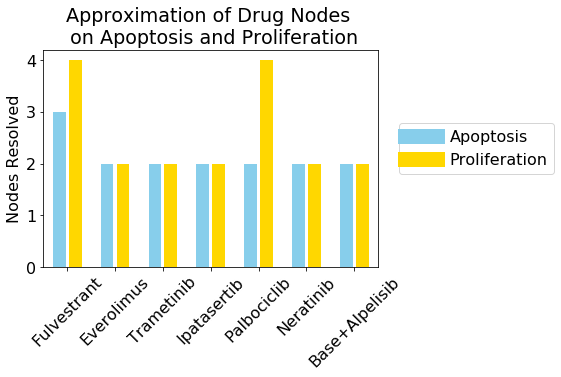

In [293]:
#create bar graphs representing just apoptosis and proliferation
from matplotlib.lines import Line2D
names=['Fulvestrant','Everolimus','Trametinib','Ipatasertib','Palbociclib','Neratinib','Base+Alpelisib']
previous={'Fulvestrant':[3,4],'Everolimus':[2,1],'Trametinib':[2,1],'Ipatasertib':[2,1],'Palbociclib':[2,4],'Neratinib':[2,1],'Base+Alpelisib':[2,1]}
approx={'Fulvestrant':[3,4],'Everolimus':[2,2],'Trametinib':[2,2],'Ipatasertib':[2,2],'Palbociclib':[2,4],'Neratinib':[2,2],'Base+Alpelisib':[2,2]}
xvalues=range(21)
yvalues1=[approx[name][0] for name in names] #previous or approx
yvalues2=[approx[name][1] for name in names] #previous or approx
print zip(yvalues1,yvalues2)
yvalues,colors=[],[]
for i in range(21):
    if i%3==0:
        yvalues.append(-1)
        colors.append('grey')
    elif i%3==1:
        yvalues.append(yvalues1[i//3])
        colors.append('skyblue')
    else:
        yvalues.append(yvalues2[i//3])
        colors.append('gold')
print yvalues
plt.bar(xvalues,yvalues,color=colors)
plt.ylim([0,4.2])
plt.xlim([0,21])
plt.xticks([1.5,4.5,7.5,10.5,13.5,16.5,19.5],names,rotation=45)
#plt.title("Previous Results of Drug Nodes \n on Apoptosis and Proliferation")
plt.title("Approximation of Drug Nodes \n on Apoptosis and Proliferation")
plt.ylabel("Nodes Resolved")
aline = Line2D([], [], color='skyblue', markersize=100, linewidth=15)
pline = Line2D([], [], color='gold', markersize=100, linewidth=15)
plt.legend([aline,pline],['Apoptosis','Proliferation'],bbox_to_anchor=(1.55, 0.7))

In [ ]:
#TODO: get above graphs for approximation values, rather than simulations?

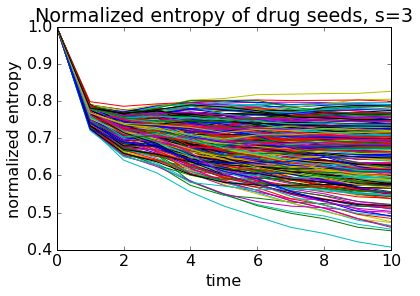

In [1181]:
names=['Fulvestrant','Alpelisib','Everolimus','Trametinib','Ipatasertib','Palbociclib','Neratinib']
#single seed entropy
final_entropies={}
for i,drug in enumerate(seeds):
    #print to_list(drug,bsunit_map,btranslator)
    diffusion=bact_prob_sim[drug] #bmodules[seed], bact_prob_sim[seed], low_sim[seed]
    seed_entropy,seed_configs=config_entropy(diffusion,base=2,normalized=True)
    xvalues=seed_entropy.keys()
    yvalues=[seed_entropy[key] for key in seed_entropy]
    #print [round(y*60,2) for y in yvalues]
    plt.plot(xvalues,[yvalue/yvalues[0] for yvalue in yvalues]) #normalize everything compared to the starting value
    final_entropies[str(drug)]=yvalues[-1]/yvalues[0]
    #print 'Normalized entropy:',[round(yvalue,2) for yvalue in yvalues],[round(yvalue/yvalues[0],2) for yvalue in yvalues]
    y1values=[2**(y * 60) for y in yvalues]
    #print 'Probable configurations:',["{:.2e}".format(yvalue) for yvalue in y1values]
    #plt.ylim([.5,1.01])
plt.title("Normalized entropy of drug seeds, s="+str(length)) #"Normalized entropy of seed, OFF state"
plt.ylabel("normalized entropy")
plt.xlabel("time")
#plt.legend(bbox_to_anchor=(1.6, 1.0))

In [1149]:
#check for proliferation or apoptosis
proliferation_units=[146,147,148,149,150,151,152,153]
apoptosis_units=[154,155,156,157,158,159]

In [1182]:
for drug in sorted(final_entropies,key=lambda x: final_entropies[x])[:10]:
    #print to_list(drug,bsunit_map,btranslator),final_entropies[drug],
    #for sunit in resolved_sunits(bmodules[str(drug)][10],tau=0.0): #bmodules or bact_prob_sim
    #    if 'Proliferation' in sunit or 'Apoptosis' in sunit: print sunit,
    #print #'None'
    #compare to DCM modules
    seed=[d for d in to_list(drug,bsunit_map,btranslator)]
    DCMB=NB.dynamics_canalization_map(output=None, )
    diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=10,pinned={})
    print seed,count_sunits(diffusion),
    for sunit in extract_sunits(diffusion):
        if 'Proliferation' in sunit or 'Apoptosis' in sunit: print sunit,
    print

['Fulvestrant-1', 'Everolimus-1', 'Neratinib-1'] 40 Proliferation_4-0
['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1'] 33 Proliferation_4-0
['Fulvestrant-1', 'Everolimus-1', 'Palbociclib-1'] 33 Proliferation_4-0 Proliferation_3-0 Proliferation_2-0
['Fulvestrant-1', 'Everolimus-1', 'Trametinib-1'] 29 Proliferation_4-0
['Fulvestrant-1', 'Everolimus-1', 'Palbociclib-0'] 30 Proliferation_4-0
['Fulvestrant-1', 'Everolimus-1', 'Ipatasertib-1'] 29 Proliferation_4-0
['Fulvestrant-1', 'Alpelisib-1', 'Neratinib-1'] 35
['Fulvestrant-1', 'Everolimus-1', 'Trametinib-0'] 29 Proliferation_4-0
['Fulvestrant-1', 'Alpelisib-0', 'Everolimus-1'] 29 Proliferation_4-0
['Fulvestrant-1', 'Everolimus-1', 'Ipatasertib-0'] 29 Proliferation_4-0


In [1170]:
#compare to DCM modules
drugs=['Fulvestrant', 'Alpelisib', 'Everolimus', 'Trametinib', 'Ipatasertib', 'Palbociclib', 'Neratinib']
drugs=[drug+'-1' for drug in drugs] #ON or OFF states
#seed=['Fulvestrant-1']
for seed in drugs:
    DCMB=NB.dynamics_canalization_map(output=None, )
    diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=10,pinned={})
    print seed,count_sunits(diffusion),
    for sunit in extract_sunits(diffusion):
        if 'Proliferation' in sunit or 'Apoptosis' in sunit: print sunit,
    print

Fulvestrant-1 18
Alpelisib-1 3
Everolimus-1 10 Proliferation_4-0
Trametinib-1 1
Ipatasertib-1 1
Palbociclib-1 10 Proliferation_4-0 Proliferation_3-0
Neratinib-1 9


In [1193]:
#run a top selection, based only on drugs nodes
drug_units={'(7,)','(9,)','(11,)','(13,)','(15,)','(17,)','(19,)','(6,)','(8,)','(10,)','(12,)','(14,)','(16,)','(18,)'}
selections,entropies=top_selection(NB,bsunits,bsunit_map,bmodules,btranslator,seeds=drug_units,max_s=20,top=1,reduced=True,ds=db,
                                   pinning={},tau=0.0,iterations=10,unknown_prob=0.5,t=10,base=2,normalized=True,force=False)
abd=[entropies[x] for x in selections] #entropy
sbd=[x for x in selections] #selection
for seed in selections: 
    print seed, entropies[seed], to_list(seed,bsunit_map,btranslator)
    #for sunit in resolved_sunits(bmodules[str(seed)][10],tau=0.0):
    #    if 'Proliferation' in sunit or 'Apoptosis' in sunit: print sunit,
    #seed=[d for d in to_list(seed,bsunit_map,btranslator)]
    #diffusion=BFS_threshold(DCMB,seed,'steady',time_limit=10,pinned={})
    #print seed,count_sunits(diffusion),
    #for sunit in extract_sunits(diffusion):
    #    if 'Proliferation' in sunit or 'Apoptosis' in sunit: print sunit,
    #print
print to_list(reduce_selection(seed,NB,bsunits,bsunit_map,bmodules,btranslator,reduced=True,ds=db,t=10),bsunit_map)

16261 16261
() 0.595408583619 []
(7,) 0.498451658394 ['Fulvestrant-1']
(7, 11) 0.421859119324 ['Fulvestrant-1', 'Everolimus-1']
(7, 9, 11) 0.364576093073 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1']
(7, 9, 11, 19) 0.31708714969 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1', 'Neratinib-1']
(7, 9, 11, 17, 19) 0.292087097518 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1', 'Palbociclib-1', 'Neratinib-1']
(7, 9, 11, 13, 17, 19) 0.27846033989 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1', 'Trametinib-1', 'Palbociclib-1', 'Neratinib-1']
(7, 9, 11, 13, 15, 17, 19) 0.265292390259 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1', 'Trametinib-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1']
(7, 9, 11, 13, 15, 17, 19) 0.265292390259 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1', 'Trametinib-1', 'Ipatasertib-1', 'Palbociclib-1', 'Neratinib-1']
(7, 9, 11, 13, 15, 17, 19) 0.265292390259 ['Fulvestrant-1', 'Alpelisib-1', 'Everolimus-1', 'Trametinib-1', 'Ipatasertib-1', 'Palbociclib-1', 'N